TP1 - Recalage d'images
=============

In [1]:
import numpy as np
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt
import numpy.linalg as npl
import pandas as pd
#import cv2

Un problème fréquemment rencontré dans le domaine du traitement d’images est celui du recalage. On dispose de plusieurs images prises à des temps différents, ou par des appareils différents, et on aimerait les mettre en correspondence, c’est-à-dire trouver une déformation du plan, qui assure une correspondence point à point des objets sous-jacents. Donnons quelques exemples d’applications :
* Traitements/retouches d’images. Par exemple, on peut vouloir construire un panoramique à partir d’images de petite taille. Il faut les recaler préalablement.
* Evaluation des déplacements d’objets dans des séquences vidéos (e.g. trouver un défaut de fonctionnement d’un organe, caméras de surveillance, design de robots intelligents ou de systèmes de navigation automatiques ...)
* Couplage d’informations. Par exemple, en imagerie médicale, on obtient une information plus riche en utilisant à la fois une radio et une angiographie. L’une apporte des informations structurelles, l’autre des informations fonctionnelles. Le couplage des deux images donne plus d’information au praticien.
* Beaucoup d’autres applications...

Dans ce TP, nous allons proposer un modèle de recalage assez élémentaire. Les idées constitutives se retrouvent cependant dans presque toutes les techniques récentes.

In [7]:
def get_images() :
    n=21
    sigma=0.3
    [X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,n), indexing='xy')
    Z=np.sqrt(X*X+Y*Y)
    im1=np.zeros((n,n))
    im1[Z<=.7]=1.
    im1[Z<=.3]=.5
    im1[Z<=.1]=.7
    im2=np.zeros((n,n));
    Z=np.sqrt((X-.3)**2+(Y+.2)**2)
    im2[Z<=.7]=1
    im2[Z<=.3]=.5
    im2[Z<=.1]=.7
    G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
    f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
    g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
    f=f/np.max(f)
    g=g/np.max(g)
    return f,g

In [8]:
f,g=get_images()

# 1. Formalisation du problème

1.1 Formalisme continu
---------------------

On modélise les images en niveaux de gris comme des fonctions d’un ensemble borné $\Omega\subset \mathbb{R}$ (typiquement un carré) dans $\mathbb{R}$. La valeur de la fonction en chaque point représente l’intensité lumineuse de l’image. 

Soient $f$ et $g$ deux images. On a donc :
$$
f:\Omega\subset \mathbb{R}^2 \to \mathbb{R},  g:\Omega\subset \mathbb{R}^2 \to \mathbb{R} 
$$
En supposant que les images $f$ et $g$ dépendent seulement d’une transformation géométrique qui conserve la luminosité, le problème de recalage peut être formulé comme suit:

> Problème inverse $(P_1)$ : 

> Etant donnés $f$ et $g$ dans $H_1(\Omega)$ (les images ont une amplitude bornée et une énergie finie), trouver un champ de vecteurs $u = (u_1, u_2) \in H_1(\Omega)^2$ tel que:
$$f(x + u(x)) = g(x), \forall x\in \Omega.$$


Le problème inverse est mal posé: tout d'abord, l'existence d'une solution n'est pas garantie, et dans le cas où il existe une solution, on n'a pas nécessairement unicité de cette solution. Par exemple, si $f$ et $g$ sont des fonctions constantes, n'importe quel déplacement $u$ est solution

Pour le résoudre, on se propose de le reformuler comme un problème d'optimisation: 

> $(P_2)$ On cherche une déformation $u$ du plan qui minimise:
$$
E(u)=\displaystyle\frac{1}{2}\int_\Omega (f(x+u(x))-g(x))^2 dx=\frac{1}{2}\|f\circ (id+u)-g\|^2.
$$

Sans hypothèse supplémentaire, le problème $\displaystyle \min_{u \in H^1(\Omega)^2} E(u)$ n'est a priori pas convexe, toujours mal posé et même éventuellement non différentiable si $u$ et $f$ ne sont pas assez régulières. On pourrait facilement rendre $f$ différentiable (en ajoutant du bruit par exemple à l'image, ce qui revient à convoler $f$ avec une gaussienne) mais il faut également "forcer" $u$ à être différentiable. Pour cela on propose de régulariser le problème de façon à assurer la convexité du problème d'optimisation considéré ainsi que l'existence et l'unicité des solutions.

Pour régulariser le problème inverse, nous allons faire une analogie avec l’élasticité linéaire. La fonction $u = (u_x,u_y)$ représente un champ de déformations. En notant $\partial x$ et $\partial y$ les opérateurs de dérivation partielle par rapport à chacun des axes du plan, on peut définir un potentiel élastique linéarisé :
$$
R(u)= \frac{\mu}{2}\int_{\Omega} \underbrace{ (\partial_x u_y + \partial_y u_x)^2(x,y) dxdy}_{R_1(u)=\textrm{cisaillement}} +\frac{\lambda+\mu}{2}\int_{\Omega} \underbrace{(\partial_x u_x + \partial_y u_y)^2(x,y) dxdy}_{R_2(u)=\textrm{variations \ de \ volume}}.
$$ 
En mécanique des structures, $\mu$ et $\lambda$ sont appelées constantes de Lamé. Le paramètre $\lambda$ n’a pas d’interprétation directe, tandis que le paramètre $\mu$ est appelé module de cisaillement.

Le problème d'optimisation à résoudre dans ce TP est le suivant:
> $$(P)\qquad \min_{u} E(u)+R(u).$$

Q1. A l'aide d'un développement de Taylor, vérifier que le gradient de $E$ s'écrit:

$$\nabla E(u) = \left(f\circ (id+u) -g\right)\nabla f\circ (id+u)$$

au sens où la différentielle de $E$ est définie par:

$$\langle \nabla E(u),h\rangle = \displaystyle\int_\Omega \langle (f(x+u(x))-g(x))\nabla f(x+u(x)),h(x)\rangle dx.$$

# 2. Discrétisation

Pour pouvoir résoudre numériquement le problème $(P)$ (dont les variables de l'optimisation sont des fonctions !), on propose de le discrétiser au préalable. 

Soit $1\le i \le n$ and $1\le j\le m$. Notons $(x_i,y_j)$ le point de la grille $(i,j)$ et $f_{i,j}$ la valeur de $f$ au point $(x_i,y_j)$. Le produit scalaire sur $V=\mathbb{R}^n\times \mathbb{R}^m$ est défini par:
$$\langle f,g\rangle_V=\sum_{i=1}^n\sum_{j=1}^m f_{i,j}g_{i,j},$$
défini sur $\mathbb{R}^n\times \mathbb{R}^m$. 

2.1. Calcul du $E$ et de son gradient
-----------------------------------

Pour pouvoir calculer $E$ et son gradient, on va avoir besoin d'évaluer $f\circ (Id+u)$ et $\nabla f\circ(id+u)$. C'est ce que fait la fonciton interpol ci-dessous.

In [2]:
def interpol(f,ux,uy) :
    # function that computes f \circ Id+u and interpolates it on a mesh
    nx,ny=f.shape
    ip=interpolate.RectBivariateSpline(np.arange(nx),np.arange(ny),f)
    [X,Y]=np.meshgrid(np.arange(nx),np.arange(ny), indexing='ij')
    X=X+ux
    Y=Y+uy
    return np.reshape(ip.ev(X.ravel(),Y.ravel()),(nx,ny))

2.2. Calcul de $R$ et de son gradient
-------------------------------------
On discrétise également les opérateurs de dérivation partielles par différences finies ; par exemple la dérivée partielle par rapport à $x$ est donnée par:
$$\begin{cases}(\partial_x f)_{i,j}=f_{i+1,j}-f_{i,j} \text{ si } i<n \\
(\partial_x f)_{n,j}=0 \end{cases} $$

On peut alors écrire :
$$
R(u)= \frac{\mu}{2}\sum_{i}(\partial_x u_y + \partial_y u_x)^2(i) + \frac{\lambda+\mu}{2} \sum_i(\partial_x u_x + \partial_y u_y)^2(i).
$$ 
où:
* $u_x\in\mathbb{R}^n$ et $u_y\in\mathbb{R}^n$ sont les discrétisations des composantes du champ de vecteurs $u$ sur la grille choisie et $\partial_x:\mathbb{R}^n\rightarrow\mathbb{R}^n$
* $\partial_y:\mathbb{R}^n\rightarrow\mathbb{R}^n$ représentent des opérateurs de différences finies.

On peut ré-écrire $R(u)=\frac{1}{2}R_1(u)+ \frac{1}{2} R_2(u)$ avec : 
$$
R_1(u)=\langle A_1 u , A_1 u\rangle,\qquad R_2(u)=\langle A_2 u , A_2 u\rangle.
$$

Q2. Donner les formules de discrétisation des opérateurs $\partial_y$, $\partial_x^\top$ et $\partial_y^\top$. Implémenter ces opérateurs ci-après.

In [3]:
def dx(im) :
    d=np.zeros(im.shape)
    d[:-1,:]=im[1:,:]-im[:-1,:]
    return d
def dy(im) :
    d=np.zeros(im.shape)
    # To be implemented
    d[:,:-1]=im[:,1:]-im[:,:-1]
    return d
def dyT(im) :
    d=np.zeros(im.shape)
    # To be implemented
    d[:,0]=-im[:,0]
    d[:,-1]=im[:,-2]
    d[:,1:-1]=im[:,:-2]-im[:,1:-1]
    return d  
def dxT(im) :
    d=np.zeros(im.shape)
    # To be implemented
    d[0,:]=-im[0,:]
    d[-1,:]=im[-2,:]
    d[1:-1,:]=im[:-2,:]-im[1:-1,:]
    return d

Q3. On écrit $R(u)$ comme un opérateur de $V^2$ dans $\mathbb{R}$. Montrer que $R(u)$ peut s'écrire sous la forme:
$$R(u)=\frac{1}{2} \langle A\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right),\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\rangle_{V^2},$$
et donnez l'expression des matrices $A_1$ et $A_2$ en fonction des opérateurs $\partial_x$, $\partial_x^\top$, $\partial_y$ et $\partial_y^\top$.

Q4. Donner l'expression du gradient de $R$.

2.3. Implémentation de la fonction objectif $E+R$
----------------------------------------------

In [4]:
def objective_function(f,g,ux,uy,lamb,mu) :
    #raise ValueError('to be implemented') 
    fu=interpol(f,ux,uy)
    E=1/2*npl.norm(fu-g)**2
    R1=npl.norm(dx(uy)+dy(ux))**2
    R2=npl.norm(dx(ux)+dy(uy))**2
    R=0.5*mu*R1+0.5*(lamb+mu)*R2
    obj=E+R
    return obj,fu

# 3. Un algorithme de gradient

Une itération de la méthode de descente de gradient est de la forme:

$$
u_{k+1}=u_k-s_k(\nabla E(u) + \nabla R(u))
$$

Q5. Compléter la fonction RecalageDG implémentant la descente de gradient et utilisant l'algorithme de recherche linéaire par rebroussement proposé ci-dessous.

In [16]:
def linesearch(ux,uy,step,descentx,descenty,obj_old,f,g,lamb,mu) :
    step=2*step
    tmpx=ux-step*descentx
    tmpy=uy-step*descenty
    obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    while obj >obj_old and step > 1.e-8:
        step=0.5*step
        tmpx=ux-step*descentx
        tmpy=uy-step*descenty
        obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    return tmpx,tmpy,step

In [17]:
def RecalageDG(f,g,lamb,mu,nitermax,stepini) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)   
        # Gradient of E at point u
        gradEx = (fu - g)*interpol(dx(f),ux,uy)
        gradEy = (fu - g)*interpol(dy(f),ux,uy)
        
        # Gradient of R at point u
        gradRx = mu*(dyT(dy(ux))+dyT(dx(uy))) + (lamb+mu)*(dxT(dx(ux))+dxT(dy(uy)))
        gradRy = mu*(dxT(dy(ux))+dxT(dx(uy))) + (lamb+mu)*(dyT(dx(ux))+dyT(dy(uy)))
        # Gradient of E+R at point u
        gradx = gradEx + gradRx
        grady = gradEy + gradRy
        
        ux,uy,step=linesearch(ux,uy,step,gradx,grady,obj,f,g,lamb,mu)
        step_list.append(step)
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter

Q5. Ecrire un compte-rendu des expériences réalisées et des résultats obtenus. Commentez.

In [14]:
tab1 = []
stepini = 0.01
nitermax = 5000
for i in range(-1,5):
    for j in range(-1,5):
        mu = 10/(10**j)
        lamb = 10/(10**i)
        ux,uy,CF,step,niter=RecalageDG(f,g,lamb,mu,nitermax,stepini)
        tab1+= [((lamb,mu),niter,CF[-1],step[-1])]

iteration : 3  cost function : 19.107314976100596 step : 0.0025
iteration : 6  cost function : 19.10436593051019 step : 0.00125
iteration : 9  cost function : 19.101503906413654 step : 0.00125
iteration : 12  cost function : 19.100416389845964 step : 0.00125
iteration : 15  cost function : 19.099160173728894 step : 0.0025
iteration : 18  cost function : 19.098053911639642 step : 0.000625
iteration : 21  cost function : 19.09725377584653 step : 0.000625
iteration : 24  cost function : 19.096290575583566 step : 0.00125
iteration : 27  cost function : 19.095463268794255 step : 0.00125
iteration : 30  cost function : 19.094753423817853 step : 0.000625
iteration : 33  cost function : 19.093842591018692 step : 0.00125
iteration : 36  cost function : 19.093076214666624 step : 0.000625
iteration : 39  cost function : 19.092261584709043 step : 0.00125
iteration : 42  cost function : 19.091471838024056 step : 0.00125
iteration : 45  cost function : 19.090873402326576 step : 0.000625
iteration : 

iteration : 411  cost function : 19.004849251374104 step : 0.00125
iteration : 414  cost function : 19.004260634751137 step : 0.000625
iteration : 417  cost function : 19.003519964429945 step : 0.00125
iteration : 420  cost function : 19.002904430087877 step : 0.000625
iteration : 423  cost function : 19.00219405637142 step : 0.00125
iteration : 426  cost function : 19.0015569033543 step : 0.000625
iteration : 429  cost function : 19.000871116981067 step : 0.00125
iteration : 432  cost function : 19.000216625138297 step : 0.000625
iteration : 435  cost function : 18.999763340644165 step : 0.000625
iteration : 438  cost function : 18.99888243653663 step : 0.00125
iteration : 441  cost function : 18.998376722359332 step : 0.000625
iteration : 444  cost function : 18.99755339733797 step : 0.00125
iteration : 447  cost function : 18.997005441547557 step : 0.000625
iteration : 450  cost function : 18.996228744147142 step : 0.00125
iteration : 453  cost function : 18.99564677747402 step : 0.

iteration : 840  cost function : 18.91228366289974 step : 0.00125
iteration : 843  cost function : 18.911751509149646 step : 0.000625
iteration : 846  cost function : 18.91101404713322 step : 0.00125
iteration : 849  cost function : 18.910450227385688 step : 0.000625
iteration : 852  cost function : 18.90974728246243 step : 0.00125
iteration : 855  cost function : 18.909157927362322 step : 0.000625
iteration : 858  cost function : 18.90848291734721 step : 0.00125
iteration : 861  cost function : 18.907872980387566 step : 0.000625
iteration : 864  cost function : 18.90722058594619 step : 0.00125
iteration : 867  cost function : 18.906594069400604 step : 0.000625
iteration : 870  cost function : 18.906155034643533 step : 0.000625
iteration : 873  cost function : 18.905320129175976 step : 0.00125
iteration : 876  cost function : 18.904831791557488 step : 0.000625
iteration : 879  cost function : 18.90405029800375 step : 0.00125
iteration : 882  cost function : 18.903522171089488 step : 0.

iteration : 1257  cost function : 18.825204229298198 step : 0.000625
iteration : 1260  cost function : 18.82457056668416 step : 0.00125
iteration : 1263  cost function : 18.823952461592988 step : 0.00125
iteration : 1266  cost function : 18.823506947522972 step : 0.000625
iteration : 1269  cost function : 18.822705086025724 step : 0.00125
iteration : 1272  cost function : 18.822214068177882 step : 0.000625
iteration : 1275  cost function : 18.82146131170454 step : 0.00125
iteration : 1278  cost function : 18.82093355236073 step : 0.000625
iteration : 1281  cost function : 18.82022049914794 step : 0.00125
iteration : 1284  cost function : 18.819663078654298 step : 0.000625
iteration : 1287  cost function : 18.81898213122978 step : 0.00125
iteration : 1290  cost function : 18.818400770807873 step : 0.000625
iteration : 1293  cost function : 18.817745789700652 step : 0.00125
iteration : 1296  cost function : 18.81714511230265 step : 0.000625
iteration : 1299  cost function : 18.8165111362

iteration : 1644  cost function : 18.745663822125902 step : 0.00125
iteration : 1647  cost function : 18.745080731270786 step : 0.000625
iteration : 1650  cost function : 18.74444160766402 step : 0.00125
iteration : 1653  cost function : 18.743840922061068 step : 0.000625
iteration : 1656  cost function : 18.743220864916363 step : 0.00125
iteration : 1659  cost function : 18.742605980500155 step : 0.00125
iteration : 1662  cost function : 18.742150009146652 step : 0.000625
iteration : 1665  cost function : 18.741375006685132 step : 0.00125
iteration : 1668  cost function : 18.740877089356832 step : 0.000625
iteration : 1671  cost function : 18.74014727324165 step : 0.00125
iteration : 1674  cost function : 18.739615479488243 step : 0.000625
iteration : 1677  cost function : 18.738922192213273 step : 0.00125
iteration : 1680  cost function : 18.738363042713 step : 0.000625
iteration : 1683  cost function : 18.73769928830544 step : 0.00125
iteration : 1686  cost function : 18.73711805213

iteration : 2085  cost function : 18.65601644168967 step : 0.00125
iteration : 2088  cost function : 18.6554170210982 step : 0.000625
iteration : 2091  cost function : 18.655001109266614 step : 0.000625
iteration : 2094  cost function : 18.654194655406112 step : 0.00125
iteration : 2097  cost function : 18.65373026475966 step : 0.000625
iteration : 2100  cost function : 18.65297595077891 step : 0.00125
iteration : 2103  cost function : 18.65247239910971 step : 0.000625
iteration : 2106  cost function : 18.651760229026948 step : 0.00125
iteration : 2109  cost function : 18.651225045766296 step : 0.000625
iteration : 2112  cost function : 18.650546942030726 step : 0.00125
iteration : 2115  cost function : 18.649986211480467 step : 0.000625
iteration : 2118  cost function : 18.649335646777747 step : 0.00125
iteration : 2121  cost function : 18.64875428546697 step : 0.000625
iteration : 2124  cost function : 18.64812598519056 step : 0.00125
iteration : 2127  cost function : 18.647527966000

iteration : 2520  cost function : 18.568302138220186 step : 0.00125
iteration : 2523  cost function : 18.567702761208942 step : 0.00125
iteration : 2526  cost function : 18.56727454920893 step : 0.000625
iteration : 2529  cost function : 18.56649003907992 step : 0.00125
iteration : 2532  cost function : 18.566016588511687 step : 0.000625
iteration : 2535  cost function : 18.565280713779753 step : 0.00125
iteration : 2538  cost function : 18.564770717974966 step : 0.000625
iteration : 2541  cost function : 18.564074152736513 step : 0.00125
iteration : 2544  cost function : 18.563534636511477 step : 0.000625
iteration : 2547  cost function : 18.562869844733047 step : 0.00125
iteration : 2550  cost function : 18.562306484621228 step : 0.000625
iteration : 2553  cost function : 18.561667376616285 step : 0.00125
iteration : 2556  cost function : 18.56108475963989 step : 0.000625
iteration : 2559  cost function : 18.560466414476682 step : 0.00125
iteration : 2562  cost function : 18.55986824

iteration : 2955  cost function : 18.481142541308035 step : 0.00125
iteration : 2958  cost function : 18.48054262273513 step : 0.00125
iteration : 2961  cost function : 18.480102435425476 step : 0.000625
iteration : 2964  cost function : 18.47933790834324 step : 0.00125
iteration : 2967  cost function : 18.47885550564169 step : 0.000625
iteration : 2970  cost function : 18.478136354018098 step : 0.00125
iteration : 2973  cost function : 18.477619847162078 step : 0.000625
iteration : 2976  cost function : 18.47693736966862 step : 0.00125
iteration : 2979  cost function : 18.47639331313402 step : 0.000625
iteration : 2982  cost function : 18.475740478426697 step : 0.00125
iteration : 2985  cost function : 18.47517416870939 step : 0.000625
iteration : 2988  cost function : 18.474545294916943 step : 0.00125
iteration : 2991  cost function : 18.47396101197064 step : 0.000625
iteration : 2994  cost function : 18.473351507697075 step : 0.00125
iteration : 2997  cost function : 18.472752710033

iteration : 3354  cost function : 18.401602781581026 step : 0.00125
iteration : 3357  cost function : 18.401148190621445 step : 0.000625
iteration : 3360  cost function : 18.400404763378884 step : 0.00125
iteration : 3363  cost function : 18.39991129532199 step : 0.000625
iteration : 3366  cost function : 18.399209653005617 step : 0.00125
iteration : 3369  cost function : 18.398684777464474 step : 0.000625
iteration : 3372  cost function : 18.398016907092718 step : 0.00125
iteration : 3375  cost function : 18.397466660067057 step : 0.000625
iteration : 3378  cost function : 18.396826086537825 step : 0.00125
iteration : 3381  cost function : 18.39625534556042 step : 0.000625
iteration : 3384  cost function : 18.395636836493534 step : 0.00125
iteration : 3387  cost function : 18.395049542968987 step : 0.000625
iteration : 3390  cost function : 18.39464663571177 step : 0.000625
iteration : 3393  cost function : 18.393848209067887 step : 0.00125
iteration : 3396  cost function : 18.3933965

iteration : 3783  cost function : 18.316479901557386 step : 0.00125
iteration : 3786  cost function : 18.316059607378115 step : 0.000625
iteration : 3789  cost function : 18.31528492804076 step : 0.00125
iteration : 3792  cost function : 18.314819737361166 step : 0.000625
iteration : 3795  cost function : 18.3140932935711 step : 0.00125
iteration : 3798  cost function : 18.313591830751637 step : 0.000625
iteration : 3801  cost function : 18.312904370815886 step : 0.00125
iteration : 3804  cost function : 18.312373604967302 step : 0.000625
iteration : 3807  cost function : 18.31171765283 step : 0.00125
iteration : 3810  cost function : 18.311163215498862 step : 0.000625
iteration : 3813  cost function : 18.310532729950438 step : 0.00125
iteration : 3816  cost function : 18.3099591718326 step : 0.000625
iteration : 3819  cost function : 18.309349271125416 step : 0.00125
iteration : 3822  cost function : 18.30876026950957 step : 0.00125
iteration : 3825  cost function : 18.308343326517107

iteration : 4215  cost function : 18.231127222725934 step : 0.00125
iteration : 4218  cost function : 18.230535592347277 step : 0.00125
iteration : 4221  cost function : 18.23010240888103 step : 0.000625
iteration : 4224  cost function : 18.229346766830485 step : 0.00125
iteration : 4227  cost function : 18.228871693176448 step : 0.000625
iteration : 4230  cost function : 18.228161057018987 step : 0.00125
iteration : 4233  cost function : 18.227652139988194 step : 0.000625
iteration : 4236  cost function : 18.226977877624076 step : 0.00125
iteration : 4239  cost function : 18.22644161963827 step : 0.000625
iteration : 4242  cost function : 18.225796755679923 step : 0.00125
iteration : 4245  cost function : 18.225238411178857 step : 0.000625
iteration : 4248  cost function : 18.224617308985984 step : 0.00125
iteration : 4251  cost function : 18.224041123946687 step : 0.000625
iteration : 4254  cost function : 18.223439228686857 step : 0.00125
iteration : 4257  cost function : 18.2228486

iteration : 4635  cost function : 18.14852163750035 step : 0.000625
iteration : 4638  cost function : 18.147888473006446 step : 0.00125
iteration : 4641  cost function : 18.14732515615315 step : 0.000625
iteration : 4644  cost function : 18.14671387498663 step : 0.00125
iteration : 4647  cost function : 18.146134130208093 step : 0.000625
iteration : 4650  cost function : 18.14573731655224 step : 0.000625
iteration : 4653  cost function : 18.144947524791455 step : 0.00125
iteration : 4656  cost function : 18.14450233723099 step : 0.000625
iteration : 4659  cost function : 18.143764503641616 step : 0.00125
iteration : 4662  cost function : 18.14328023312937 step : 0.000625
iteration : 4665  cost function : 18.142584390990404 step : 0.00125
iteration : 4668  cost function : 18.14206854530259 step : 0.000625
iteration : 4671  cost function : 18.141406640760323 step : 0.00125
iteration : 4674  cost function : 18.140865286733877 step : 0.000625
iteration : 4677  cost function : 18.1402308116

iteration : 60  cost function : 19.041381801706002 step : 0.0025
iteration : 63  cost function : 19.038870471199097 step : 0.005
iteration : 66  cost function : 19.036278523673687 step : 0.005
iteration : 69  cost function : 19.03369684868891 step : 0.005
iteration : 72  cost function : 19.03112494321566 step : 0.005
iteration : 75  cost function : 19.028562280807442 step : 0.005
iteration : 78  cost function : 19.026008476087714 step : 0.0025
iteration : 81  cost function : 19.023463121858835 step : 0.0025
iteration : 84  cost function : 19.020925909438645 step : 0.0025
iteration : 87  cost function : 19.018396516415145 step : 0.0025
iteration : 90  cost function : 19.01587468723393 step : 0.0025
iteration : 93  cost function : 19.013360162502313 step : 0.0025
iteration : 96  cost function : 19.0108527246608 step : 0.0025
iteration : 99  cost function : 19.008352162428242 step : 0.0025
iteration : 102  cost function : 19.005858285958737 step : 0.0025
iteration : 105  cost function : 1

iteration : 492  cost function : 18.729532116408187 step : 0.00125
iteration : 495  cost function : 18.727430481176363 step : 0.00125
iteration : 498  cost function : 18.72533034111968 step : 0.00125
iteration : 501  cost function : 18.722709648306203 step : 0.0025
iteration : 504  cost function : 18.72196437582673 step : 0.00125
iteration : 507  cost function : 18.719868029316554 step : 0.00125
iteration : 510  cost function : 18.717773134523345 step : 0.00125
iteration : 513  cost function : 18.715679982981435 step : 0.00125
iteration : 516  cost function : 18.713588259572365 step : 0.00125
iteration : 519  cost function : 18.711498258354396 step : 0.00125
iteration : 522  cost function : 18.708888086044666 step : 0.0025
iteration : 525  cost function : 18.70814803942488 step : 0.00125
iteration : 528  cost function : 18.70606133010394 step : 0.00125
iteration : 531  cost function : 18.703976298258716 step : 0.00125
iteration : 534  cost function : 18.70189263143399 step : 0.00125
it

iteration : 918  cost function : 18.458057786631525 step : 0.00125
iteration : 921  cost function : 18.45560047003838 step : 0.0025
iteration : 924  cost function : 18.454903665189693 step : 0.00125
iteration : 927  cost function : 18.452938339289858 step : 0.00125
iteration : 930  cost function : 18.450973591607397 step : 0.00125
iteration : 933  cost function : 18.44900969990193 step : 0.00125
iteration : 936  cost function : 18.44704637967142 step : 0.00125
iteration : 939  cost function : 18.445083910659367 step : 0.00125
iteration : 942  cost function : 18.4426328162839 step : 0.0025
iteration : 945  cost function : 18.441936571253443 step : 0.00125
iteration : 948  cost function : 18.439975265374294 step : 0.00125
iteration : 951  cost function : 18.43801479471838 step : 0.00125
iteration : 954  cost function : 18.436054877266738 step : 0.00125
iteration : 957  cost function : 18.434095790565372 step : 0.00125
iteration : 960  cost function : 18.432137250759517 step : 0.00125
ite

iteration : 1347  cost function : 18.197207297778395 step : 0.00125
iteration : 1350  cost function : 18.195305757128423 step : 0.00125
iteration : 1353  cost function : 18.19292796259062 step : 0.0025
iteration : 1356  cost function : 18.192255643793317 step : 0.00125
iteration : 1359  cost function : 18.19035484648883 step : 0.00125
iteration : 1362  cost function : 18.188454350304976 step : 0.00125
iteration : 1365  cost function : 18.18655440630873 step : 0.00125
iteration : 1368  cost function : 18.18465476130939 step : 0.00125
iteration : 1371  cost function : 18.182755667924397 step : 0.00125
iteration : 1374  cost function : 18.180382652772952 step : 0.0025
iteration : 1377  cost function : 18.179709379827443 step : 0.00125
iteration : 1380  cost function : 18.17781075760072 step : 0.00125
iteration : 1383  cost function : 18.175912678792535 step : 0.00125
iteration : 1386  cost function : 18.17401489288452 step : 0.00125
iteration : 1389  cost function : 18.17211764989045 step

iteration : 1767  cost function : 17.94754076839414 step : 0.0025
iteration : 1770  cost function : 17.946881648746395 step : 0.00125
iteration : 1773  cost function : 17.94501924240758 step : 0.00125
iteration : 1776  cost function : 17.943157046901593 step : 0.00125
iteration : 1779  cost function : 17.94129527790706 step : 0.00125
iteration : 1782  cost function : 17.93943371921585 step : 0.00125
iteration : 1785  cost function : 17.93757258761928 step : 0.00125
iteration : 1788  cost function : 17.93524766312975 step : 0.0025
iteration : 1791  cost function : 17.934587047842637 step : 0.00125
iteration : 1794  cost function : 17.93272614583641 step : 0.00125
iteration : 1797  cost function : 17.930865665316894 step : 0.00125
iteration : 1800  cost function : 17.92900539291668 step : 0.00125
iteration : 1803  cost function : 17.92714554259683 step : 0.00125
iteration : 1806  cost function : 17.925285899930604 step : 0.00125
iteration : 1809  cost function : 17.922965324022737 step :

iteration : 2199  cost function : 17.6966605407804 step : 0.00125
iteration : 2202  cost function : 17.694828308252333 step : 0.00125
iteration : 2205  cost function : 17.692537032097597 step : 0.0025
iteration : 2208  cost function : 17.691889032905582 step : 0.00125
iteration : 2211  cost function : 17.690057106382245 step : 0.00125
iteration : 2214  cost function : 17.68822536317131 step : 0.00125
iteration : 2217  cost function : 17.68639397254123 step : 0.00125
iteration : 2220  cost function : 17.684562765497073 step : 0.00125
iteration : 2223  cost function : 17.682731911914594 step : 0.00125
iteration : 2226  cost function : 17.68044459297736 step : 0.0025
iteration : 2229  cost function : 17.679794855210996 step : 0.00125
iteration : 2232  cost function : 17.67796413525258 step : 0.00125
iteration : 2235  cost function : 17.676133764362508 step : 0.00125
iteration : 2238  cost function : 17.674303576491724 step : 0.00125
iteration : 2241  cost function : 17.672473738560235 ste

iteration : 2625  cost function : 17.452670914493122 step : 0.00125
iteration : 2628  cost function : 17.450863471692497 step : 0.00125
iteration : 2631  cost function : 17.44905633141971 step : 0.00125
iteration : 2634  cost function : 17.447249377043615 step : 0.00125
iteration : 2637  cost function : 17.445442726023405 step : 0.00125
iteration : 2640  cost function : 17.443636261661712 step : 0.00125
iteration : 2643  cost function : 17.441379096212927 step : 0.0025
iteration : 2646  cost function : 17.440738377330497 step : 0.00125
iteration : 2649  cost function : 17.438932134855833 step : 0.00125
iteration : 2652  cost function : 17.43712607835855 step : 0.00125
iteration : 2655  cost function : 17.435320322324255 step : 0.00125
iteration : 2658  cost function : 17.433514753035773 step : 0.00125
iteration : 2661  cost function : 17.431709485036354 step : 0.00125
iteration : 2664  cost function : 17.429456133995792 step : 0.0025
iteration : 2667  cost function : 17.428813574793654

iteration : 3057  cost function : 17.207598653413196 step : 0.00125
iteration : 3060  cost function : 17.205369813683927 step : 0.0025
iteration : 3063  cost function : 17.20473653879114 step : 0.00125
iteration : 3066  cost function : 17.202952517870084 step : 0.00125
iteration : 3069  cost function : 17.201168755016045 step : 0.00125
iteration : 3072  cost function : 17.199385195283938 step : 0.00125
iteration : 3075  cost function : 17.197601894251576 step : 0.00125
iteration : 3078  cost function : 17.19581879749221 step : 0.00125
iteration : 3081  cost function : 17.19359373449678 step : 0.0025
iteration : 3084  cost function : 17.192958534531993 step : 0.00125
iteration : 3087  cost function : 17.191175601417708 step : 0.00125
iteration : 3090  cost function : 17.18939287179901 step : 0.00125
iteration : 3093  cost function : 17.18761039833693 step : 0.00125
iteration : 3096  cost function : 17.18582812952414 step : 0.00125
iteration : 3099  cost function : 17.18404611749238 step

iteration : 3480  cost function : 16.97157793531729 step : 0.00125
iteration : 3483  cost function : 16.96981500201584 step : 0.00125
iteration : 3486  cost function : 16.968052295627974 step : 0.00125
iteration : 3489  cost function : 16.96628980780097 step : 0.00125
iteration : 3492  cost function : 16.964527548360774 step : 0.00125
iteration : 3495  cost function : 16.962765507865633 step : 0.00125
iteration : 3498  cost function : 16.96056766473932 step : 0.0025
iteration : 3501  cost function : 16.959939053328792 step : 0.00125
iteration : 3504  cost function : 16.95817714163757 step : 0.00125
iteration : 3507  cost function : 16.956415446191063 step : 0.00125
iteration : 3510  cost function : 16.954653979601648 step : 0.00125
iteration : 3513  cost function : 16.952892729621716 step : 0.00125
iteration : 3516  cost function : 16.951131709997963 step : 0.00125
iteration : 3519  cost function : 16.949370907355863 step : 0.00125
iteration : 3522  cost function : 16.947169554007978 s

iteration : 3909  cost function : 16.73417266557471 step : 0.00125
iteration : 3912  cost function : 16.732430997758016 step : 0.00125
iteration : 3915  cost function : 16.730689509135164 step : 0.00125
iteration : 3918  cost function : 16.728511095313127 step : 0.0025
iteration : 3921  cost function : 16.727895660936607 step : 0.00125
iteration : 3924  cost function : 16.726154326841325 step : 0.00125
iteration : 3927  cost function : 16.724413169697097 step : 0.00125
iteration : 3930  cost function : 16.722672271943672 step : 0.00125
iteration : 3933  cost function : 16.720931551218307 step : 0.00125
iteration : 3936  cost function : 16.71919109171855 step : 0.00125
iteration : 3939  cost function : 16.71701628790974 step : 0.0025
iteration : 3942  cost function : 16.71639897576151 step : 0.00125
iteration : 3945  cost function : 16.714658588420594 step : 0.00125
iteration : 3948  cost function : 16.712918460937132 step : 0.00125
iteration : 3951  cost function : 16.711178508337433 s

iteration : 4341  cost function : 16.498537527021757 step : 0.00125
iteration : 4344  cost function : 16.49681632722599 step : 0.00125
iteration : 4347  cost function : 16.495095264293884 step : 0.00125
iteration : 4350  cost function : 16.493374494934592 step : 0.00125
iteration : 4353  cost function : 16.491653862203734 step : 0.00125
iteration : 4356  cost function : 16.48950516543221 step : 0.0025
iteration : 4359  cost function : 16.488893723786077 step : 0.00125
iteration : 4362  cost function : 16.48717328123158 step : 0.00125
iteration : 4365  cost function : 16.48545297357546 step : 0.00125
iteration : 4368  cost function : 16.48373295989313 step : 0.00125
iteration : 4371  cost function : 16.48201308085614 step : 0.00125
iteration : 4374  cost function : 16.48029349796062 step : 0.00125
iteration : 4377  cost function : 16.478148323135724 step : 0.0025
iteration : 4380  cost function : 16.477535060093626 step : 0.00125
iteration : 4383  cost function : 16.475815508162174 step

iteration : 4773  cost function : 16.264589596843766 step : 0.0025
iteration : 4776  cost function : 16.26398406436289 step : 0.00125
iteration : 4779  cost function : 16.262283118122568 step : 0.00125
iteration : 4782  cost function : 16.260582500182473 step : 0.00125
iteration : 4785  cost function : 16.258881976142693 step : 0.00125
iteration : 4788  cost function : 16.257181782876366 step : 0.00125
iteration : 4791  cost function : 16.255481682929446 step : 0.00125
iteration : 4794  cost function : 16.253781916261868 step : 0.00125
iteration : 4797  cost function : 16.25165539576996 step : 0.0025
iteration : 4800  cost function : 16.251054862182492 step : 0.00125
iteration : 4803  cost function : 16.249355083986362 step : 0.00125
iteration : 4806  cost function : 16.24765563685471 step : 0.00125
iteration : 4809  cost function : 16.245956281245693 step : 0.00125
iteration : 4812  cost function : 16.244257259202453 step : 0.00125
iteration : 4815  cost function : 16.242558328082737 

iteration : 183  cost function : 18.93304171430265 step : 0.0025
iteration : 186  cost function : 18.930889815717535 step : 0.0025
iteration : 189  cost function : 18.928786602162983 step : 0.0025
iteration : 192  cost function : 18.926740361658396 step : 0.0025
iteration : 195  cost function : 18.92476132888125 step : 0.0025
iteration : 198  cost function : 18.922861108110595 step : 0.0025
iteration : 201  cost function : 18.92105398714482 step : 0.0025
iteration : 204  cost function : 18.919356219707435 step : 0.0025
iteration : 207  cost function : 18.917787751349135 step : 0.0025
iteration : 210  cost function : 18.916371353243413 step : 0.0025
iteration : 213  cost function : 18.915134871293034 step : 0.0025
iteration : 216  cost function : 18.91411021105669 step : 0.0025
iteration : 219  cost function : 18.913336253635375 step : 0.0025
iteration : 222  cost function : 18.912857704572247 step : 0.0025
iteration : 225  cost function : 18.91272886301407 step : 0.00125
iteration : 22

iteration : 612  cost function : 18.582353929068734 step : 0.0025
iteration : 615  cost function : 18.58112724237035 step : 0.0025
iteration : 618  cost function : 18.580082570701517 step : 0.0025
iteration : 621  cost function : 18.57925387902447 step : 0.0025
iteration : 624  cost function : 18.578679582731112 step : 0.0025
iteration : 627  cost function : 18.578407048637825 step : 0.0025
iteration : 630  cost function : 18.56401903021504 step : 0.005
iteration : 633  cost function : 18.560272250384187 step : 0.0025
iteration : 636  cost function : 18.558321776368594 step : 0.0025
iteration : 639  cost function : 18.556419922804455 step : 0.0025
iteration : 642  cost function : 18.554574967588813 step : 0.0025
iteration : 645  cost function : 18.55279760683802 step : 0.0025
iteration : 648  cost function : 18.551099512559862 step : 0.0025
iteration : 651  cost function : 18.549495561336318 step : 0.0025
iteration : 654  cost function : 18.54800219100629 step : 0.0025
iteration : 657 

iteration : 1044  cost function : 18.24491683258347 step : 0.0025
iteration : 1047  cost function : 18.243209507037147 step : 0.0025
iteration : 1050  cost function : 18.24157090978781 step : 0.0025
iteration : 1053  cost function : 18.240013994553074 step : 0.0025
iteration : 1056  cost function : 18.238553006363638 step : 0.0025
iteration : 1059  cost function : 18.237205971617506 step : 0.0025
iteration : 1062  cost function : 18.23599293887897 step : 0.0025
iteration : 1065  cost function : 18.23493901497344 step : 0.0025
iteration : 1068  cost function : 18.234072391054507 step : 0.0025
iteration : 1071  cost function : 18.23342806079165 step : 0.0025
iteration : 1074  cost function : 18.233045635208185 step : 0.0025
iteration : 1077  cost function : 18.22039009430404 step : 0.0025
iteration : 1080  cost function : 18.2167877158113 step : 0.0025
iteration : 1083  cost function : 18.214943472381766 step : 0.0025
iteration : 1086  cost function : 18.213141113033938 step : 0.0025
ite

iteration : 1479  cost function : 17.93917018550236 step : 0.0025
iteration : 1482  cost function : 17.926293375474415 step : 0.005
iteration : 1485  cost function : 17.922954405031398 step : 0.0025
iteration : 1488  cost function : 17.921214210559473 step : 0.0025
iteration : 1491  cost function : 17.9195172587319 step : 0.0025
iteration : 1494  cost function : 17.917870946632085 step : 0.0025
iteration : 1497  cost function : 17.916284870847363 step : 0.0025
iteration : 1500  cost function : 17.91476946469751 step : 0.0025
iteration : 1503  cost function : 17.913338071295946 step : 0.0025
iteration : 1506  cost function : 17.912005387965145 step : 0.0025
iteration : 1509  cost function : 17.91078998507872 step : 0.0025
iteration : 1512  cost function : 17.90971254493368 step : 0.0025
iteration : 1515  cost function : 17.908798934534886 step : 0.0025
iteration : 1518  cost function : 17.908078232866462 step : 0.0025
iteration : 1521  cost function : 17.90758649620366 step : 0.0025
ite

iteration : 1908  cost function : 17.63296337960089 step : 0.0025
iteration : 1911  cost function : 17.631728570198703 step : 0.0025
iteration : 1914  cost function : 17.630613597057057 step : 0.0025
iteration : 1917  cost function : 17.62964097085154 step : 0.0025
iteration : 1920  cost function : 17.628835919895973 step : 0.0025
iteration : 1923  cost function : 17.628229814582962 step : 0.0025
iteration : 1926  cost function : 17.627858108084414 step : 0.0025
iteration : 1929  cost function : 17.61649810741254 step : 0.0025
iteration : 1932  cost function : 17.613202440995728 step : 0.0025
iteration : 1935  cost function : 17.611520654282614 step : 0.0025
iteration : 1938  cost function : 17.60987620341457 step : 0.0025
iteration : 1941  cost function : 17.60827620317113 step : 0.0025
iteration : 1944  cost function : 17.606728291400714 step : 0.0025
iteration : 1947  cost function : 17.605242351195812 step : 0.0025
iteration : 1950  cost function : 17.60382915294904 step : 0.0025
i

iteration : 2325  cost function : 17.35949179751936 step : 0.0025
iteration : 2328  cost function : 17.358988102054187 step : 0.0025
iteration : 2331  cost function : 17.358726126122683 step : 0.0025
iteration : 2334  cost function : 17.347147157579975 step : 0.005
iteration : 2337  cost function : 17.344038036157556 step : 0.0025
iteration : 2340  cost function : 17.342428291029854 step : 0.0025
iteration : 2343  cost function : 17.340857173514664 step : 0.0025
iteration : 2346  cost function : 17.339331303473248 step : 0.0025
iteration : 2349  cost function : 17.337859288568264 step : 0.0025
iteration : 2352  cost function : 17.336450467705607 step : 0.0025
iteration : 2355  cost function : 17.335116807004805 step : 0.0025
iteration : 2358  cost function : 17.33387146425826 step : 0.0025
iteration : 2361  cost function : 17.332731091069665 step : 0.0025
iteration : 2364  cost function : 17.33171420583745 step : 0.0025
iteration : 2367  cost function : 17.330844000154293 step : 0.0025

iteration : 2745  cost function : 17.08228931980484 step : 0.0025
iteration : 2748  cost function : 17.080781882616947 step : 0.0025
iteration : 2751  cost function : 17.079321257604064 step : 0.0025
iteration : 2754  cost function : 17.07791554457151 step : 0.0025
iteration : 2757  cost function : 17.07657516185221 step : 0.0025
iteration : 2760  cost function : 17.075311525287844 step : 0.0025
iteration : 2763  cost function : 17.07413912877664 step : 0.0025
iteration : 2766  cost function : 17.07307404359488 step : 0.0025
iteration : 2769  cost function : 17.072136451600347 step : 0.0025
iteration : 2772  cost function : 17.07134895667752 step : 0.0025
iteration : 2775  cost function : 17.07073968232063 step : 0.0025
iteration : 2778  cost function : 17.07034039530779 step : 0.0025
iteration : 2781  cost function : 17.07019031140376 step : 0.00125
iteration : 2784  cost function : 17.057781542322918 step : 0.01
iteration : 2787  cost function : 17.055421698185295 step : 0.0025
itera

iteration : 3171  cost function : 16.8210884842987 step : 0.0025
iteration : 3174  cost function : 16.820222894758547 step : 0.0025
iteration : 3177  cost function : 16.819512232879816 step : 0.0025
iteration : 3180  cost function : 16.818984085472813 step : 0.0025
iteration : 3183  cost function : 16.818672567756085 step : 0.0025
iteration : 3186  cost function : 16.808228502369754 step : 0.0025
iteration : 3189  cost function : 16.805262044509927 step : 0.0025
iteration : 3192  cost function : 16.803742028054216 step : 0.0025
iteration : 3195  cost function : 16.80225657619935 step : 0.0025
iteration : 3198  cost function : 16.80081162433914 step : 0.0025
iteration : 3201  cost function : 16.7994148886444 step : 0.0025
iteration : 3204  cost function : 16.7980747423101 step : 0.0025
iteration : 3207  cost function : 16.796801912171496 step : 0.0025
iteration : 3210  cost function : 16.79560819528538 step : 0.0025
iteration : 3213  cost function : 16.79450851879297 step : 0.0025
itera

iteration : 3591  cost function : 16.5630263502636 step : 0.005
iteration : 3594  cost function : 16.560189037720818 step : 0.0025
iteration : 3597  cost function : 16.558717392018583 step : 0.0025
iteration : 3600  cost function : 16.557280954736022 step : 0.0025
iteration : 3603  cost function : 16.55588644344946 step : 0.0025
iteration : 3606  cost function : 16.55454112673938 step : 0.0025
iteration : 3609  cost function : 16.553254341176473 step : 0.0025
iteration : 3612  cost function : 16.55203632993587 step : 0.0025
iteration : 3615  cost function : 16.550900083087715 step : 0.0025
iteration : 3618  cost function : 16.549860019678388 step : 0.0025
iteration : 3621  cost function : 16.548934228929753 step : 0.0025
iteration : 3624  cost function : 16.548142989315913 step : 0.0025
iteration : 3627  cost function : 16.547511509877836 step : 0.0025
iteration : 3630  cost function : 16.547068287461936 step : 0.0025
iteration : 3633  cost function : 16.546848475875482 step : 0.0025
i

iteration : 4026  cost function : 16.31020692612588 step : 0.0025
iteration : 4029  cost function : 16.309478778450302 step : 0.0025
iteration : 4032  cost function : 16.308914306204013 step : 0.0025
iteration : 4035  cost function : 16.30854408800965 step : 0.0025
iteration : 4038  cost function : 16.308402901912427 step : 0.00125
iteration : 4041  cost function : 16.29695568709634 step : 0.01
iteration : 4044  cost function : 16.29477394351187 step : 0.0025
iteration : 4047  cost function : 16.29335062674775 step : 0.0025
iteration : 4050  cost function : 16.291963605590862 step : 0.0025
iteration : 4053  cost function : 16.29061979129943 step : 0.0025
iteration : 4056  cost function : 16.28932670488944 step : 0.0025
iteration : 4059  cost function : 16.28809395616905 step : 0.0025
iteration : 4062  cost function : 16.28693213921309 step : 0.0025
iteration : 4065  cost function : 16.285854629080138 step : 0.0025
iteration : 4068  cost function : 16.28487633307903 step : 0.0025
iterat

iteration : 4452  cost function : 16.060050917234864 step : 0.0025
iteration : 4455  cost function : 16.058704801450013 step : 0.0025
iteration : 4458  cost function : 16.05740280175268 step : 0.0025
iteration : 4461  cost function : 16.056153278715982 step : 0.0025
iteration : 4464  cost function : 16.05496543911595 step : 0.0025
iteration : 4467  cost function : 16.053850918299222 step : 0.0025
iteration : 4470  cost function : 16.05282267263978 step : 0.0025
iteration : 4473  cost function : 16.051896908674387 step : 0.0025
iteration : 4476  cost function : 16.05109184339032 step : 0.0025
iteration : 4479  cost function : 16.05043006670683 step : 0.0025
iteration : 4482  cost function : 16.04993717328474 step : 0.0025
iteration : 4485  cost function : 16.049644670062644 step : 0.0025
iteration : 4488  cost function : 16.039975092173496 step : 0.0025
iteration : 4491  cost function : 16.03721949128908 step : 0.0025
iteration : 4494  cost function : 16.035808245605846 step : 0.0025
it

iteration : 4881  cost function : 15.822881153574006 step : 0.0025
iteration : 4884  cost function : 15.822276580856386 step : 0.0025
iteration : 4887  cost function : 15.8218462811829 step : 0.0025
iteration : 4890  cost function : 15.821621503901385 step : 0.0025
iteration : 4893  cost function : 15.811737738263412 step : 0.005
iteration : 4896  cost function : 15.809081097255442 step : 0.0025
iteration : 4899  cost function : 15.807705735668808 step : 0.0025
iteration : 4902  cost function : 15.806362934764712 step : 0.0025
iteration : 4905  cost function : 15.80505887828182 step : 0.0025
iteration : 4908  cost function : 15.803800335047054 step : 0.0025
iteration : 4911  cost function : 15.802595906976954 step : 0.0025
iteration : 4914  cost function : 15.801455124230102 step : 0.0025
iteration : 4917  cost function : 15.800389963487042 step : 0.0025
iteration : 4920  cost function : 15.799413829817594 step : 0.0025
iteration : 4923  cost function : 15.798543411697432 step : 0.0025

iteration : 294  cost function : 18.827664698061547 step : 0.0025
iteration : 297  cost function : 18.8251253579238 step : 0.0025
iteration : 300  cost function : 18.8225876485272 step : 0.0025
iteration : 303  cost function : 18.82005166287744 step : 0.0025
iteration : 306  cost function : 18.81751716396115 step : 0.0025
iteration : 309  cost function : 18.814984253671454 step : 0.0025
iteration : 312  cost function : 18.8124527086414 step : 0.0025
iteration : 315  cost function : 18.809922636837083 step : 0.0025
iteration : 318  cost function : 18.807393826871518 step : 0.0025
iteration : 321  cost function : 18.804866390610123 step : 0.0025
iteration : 324  cost function : 18.802340127363056 step : 0.0025
iteration : 327  cost function : 18.799815151215018 step : 0.0025
iteration : 330  cost function : 18.79729127117256 step : 0.0025
iteration : 333  cost function : 18.794768602240957 step : 0.0025
iteration : 336  cost function : 18.792246962329745 step : 0.0025
iteration : 339  co

iteration : 720  cost function : 18.473090817174278 step : 0.0025
iteration : 723  cost function : 18.470603799449382 step : 0.0025
iteration : 726  cost function : 18.468118663911863 step : 0.0025
iteration : 729  cost function : 18.465635611432333 step : 0.0025
iteration : 732  cost function : 18.463154315026873 step : 0.0025
iteration : 735  cost function : 18.460674969746833 step : 0.0025
iteration : 738  cost function : 18.45819726511213 step : 0.0025
iteration : 741  cost function : 18.455721390375125 step : 0.0025
iteration : 744  cost function : 18.453247050641764 step : 0.0025
iteration : 747  cost function : 18.450774429403694 step : 0.0025
iteration : 750  cost function : 18.448303246492028 step : 0.0025
iteration : 753  cost function : 18.445833679691713 step : 0.0025
iteration : 756  cost function : 18.443365462751203 step : 0.0025
iteration : 759  cost function : 18.44089876781632 step : 0.0025
iteration : 762  cost function : 18.438433341794486 step : 0.0025
iteration : 

iteration : 1146  cost function : 18.127604113056687 step : 0.0025
iteration : 1149  cost function : 18.125156530757863 step : 0.0025
iteration : 1152  cost function : 18.122711671757525 step : 0.0025
iteration : 1155  cost function : 18.120269763337483 step : 0.0025
iteration : 1158  cost function : 18.11783037916182 step : 0.0025
iteration : 1161  cost function : 18.11539374108324 step : 0.0025
iteration : 1164  cost function : 18.112959444998936 step : 0.0025
iteration : 1167  cost function : 18.110527707209673 step : 0.0025
iteration : 1170  cost function : 18.10809814456022 step : 0.0025
iteration : 1173  cost function : 18.10567096771131 step : 0.0025
iteration : 1176  cost function : 18.10324581325259 step : 0.0025
iteration : 1179  cost function : 18.100822886147355 step : 0.0025
iteration : 1182  cost function : 18.098401841604506 step : 0.0025
iteration : 1185  cost function : 18.095982878859644 step : 0.0025
iteration : 1188  cost function : 18.093565670686885 step : 0.0025


iteration : 1569  cost function : 17.792046418934383 step : 0.0025
iteration : 1572  cost function : 17.789703677260874 step : 0.0025
iteration : 1575  cost function : 17.787361848326313 step : 0.0025
iteration : 1578  cost function : 17.78502077353419 step : 0.0025
iteration : 1581  cost function : 17.782680570998107 step : 0.0025
iteration : 1584  cost function : 17.78034108965065 step : 0.0025
iteration : 1587  cost function : 17.77876901505203 step : 0.0025
iteration : 1590  cost function : 17.77636563887631 step : 0.0025
iteration : 1593  cost function : 17.773965966687147 step : 0.0025
iteration : 1596  cost function : 17.771569497809026 step : 0.0025
iteration : 1599  cost function : 17.769176465159134 step : 0.0025
iteration : 1602  cost function : 17.766786394774822 step : 0.0025
iteration : 1605  cost function : 17.76439951476392 step : 0.0025
iteration : 1608  cost function : 17.76201537629213 step : 0.0025
iteration : 1611  cost function : 17.759634202436555 step : 0.0025
i

iteration : 1992  cost function : 17.464929896262944 step : 0.0025
iteration : 1995  cost function : 17.462635317269665 step : 0.0025
iteration : 1998  cost function : 17.46034176057512 step : 0.0025
iteration : 2001  cost function : 17.458049370139733 step : 0.0025
iteration : 2004  cost function : 17.45575794468249 step : 0.0025
iteration : 2007  cost function : 17.453467623268594 step : 0.0025
iteration : 2010  cost function : 17.451178214409346 step : 0.0025
iteration : 2013  cost function : 17.44888985237937 step : 0.0025
iteration : 2016  cost function : 17.446602354964323 step : 0.0025
iteration : 2019  cost function : 17.44431585175708 step : 0.0025
iteration : 2022  cost function : 17.44203016933016 step : 0.0025
iteration : 2025  cost function : 17.439745432706804 step : 0.0025
iteration : 2028  cost function : 17.437461476787266 step : 0.0025
iteration : 2031  cost function : 17.43517842213983 step : 0.0025
iteration : 2034  cost function : 17.432896111559973 step : 0.0025
i

iteration : 2403  cost function : 17.154567758119104 step : 0.0025
iteration : 2406  cost function : 17.15230792366736 step : 0.0025
iteration : 2409  cost function : 17.150050000027726 step : 0.0025
iteration : 2412  cost function : 17.147793687009536 step : 0.0025
iteration : 2415  cost function : 17.145539160999128 step : 0.0025
iteration : 2418  cost function : 17.14328613706622 step : 0.0025
iteration : 2421  cost function : 17.141034786397032 step : 0.0025
iteration : 2424  cost function : 17.138784838466993 step : 0.0025
iteration : 2427  cost function : 17.136536459290074 step : 0.0025
iteration : 2430  cost function : 17.13428939194611 step : 0.0025
iteration : 2433  cost function : 17.132043797319653 step : 0.0025
iteration : 2436  cost function : 17.129799431343322 step : 0.0025
iteration : 2439  cost function : 17.127556449828038 step : 0.0025
iteration : 2442  cost function : 17.12531462085383 step : 0.0025
iteration : 2445  cost function : 17.123074095224965 step : 0.0025

iteration : 2832  cost function : 16.838095841069155 step : 0.0025
iteration : 2835  cost function : 16.83587080461334 step : 0.0025
iteration : 2838  cost function : 16.83364811209597 step : 0.0025
iteration : 2841  cost function : 16.831427960018633 step : 0.0025
iteration : 2844  cost function : 16.82920998027831 step : 0.0025
iteration : 2847  cost function : 16.82699436464256 step : 0.0025
iteration : 2850  cost function : 16.824780764233545 step : 0.0025
iteration : 2853  cost function : 16.82256936598282 step : 0.0025
iteration : 2856  cost function : 16.820359839125263 step : 0.0025
iteration : 2859  cost function : 16.818152365684046 step : 0.0025
iteration : 2862  cost function : 16.815946631966007 step : 0.0025
iteration : 2865  cost function : 16.81374281503987 step : 0.0025
iteration : 2868  cost function : 16.81154061731027 step : 0.0025
iteration : 2871  cost function : 16.80934021086862 step : 0.0025
iteration : 2874  cost function : 16.80714131330519 step : 0.0025
iter

iteration : 3258  cost function : 16.53035937581458 step : 0.0025
iteration : 3261  cost function : 16.52822516205593 step : 0.0025
iteration : 3264  cost function : 16.526091598434135 step : 0.0025
iteration : 3267  cost function : 16.523958786393113 step : 0.0025
iteration : 3270  cost function : 16.52250943925471 step : 0.0025
iteration : 3273  cost function : 16.520319110823035 step : 0.0025
iteration : 3276  cost function : 16.51813177388257 step : 0.0025
iteration : 3279  cost function : 16.515947631967197 step : 0.0025
iteration : 3282  cost function : 16.513766254420283 step : 0.0025
iteration : 3285  cost function : 16.511587840913975 step : 0.0025
iteration : 3288  cost function : 16.50941198379182 step : 0.0025
iteration : 3291  cost function : 16.507238878625078 step : 0.0025
iteration : 3294  cost function : 16.50506813939171 step : 0.0025
iteration : 3297  cost function : 16.50289995736972 step : 0.0025
iteration : 3300  cost function : 16.500733966895897 step : 0.0025
it

iteration : 3687  cost function : 16.227840671267877 step : 0.0025
iteration : 3690  cost function : 16.225750050775712 step : 0.0025
iteration : 3693  cost function : 16.223660385259574 step : 0.0025
iteration : 3696  cost function : 16.221571509935725 step : 0.0025
iteration : 3699  cost function : 16.219483540247925 step : 0.0025
iteration : 3702  cost function : 16.217396319388982 step : 0.0025
iteration : 3705  cost function : 16.215309958789707 step : 0.0025
iteration : 3708  cost function : 16.21322430920007 step : 0.0025
iteration : 3711  cost function : 16.21113947813336 step : 0.0025
iteration : 3714  cost function : 16.209055323501783 step : 0.0025
iteration : 3717  cost function : 16.206971948998717 step : 0.0025
iteration : 3720  cost function : 16.204889219326546 step : 0.0025
iteration : 3723  cost function : 16.202807234457953 step : 0.0025
iteration : 3726  cost function : 16.20072586553487 step : 0.0025
iteration : 3729  cost function : 16.199306721118514 step : 0.002

iteration : 4089  cost function : 15.950692922363348 step : 0.0025
iteration : 4092  cost function : 15.94862999716758 step : 0.0025
iteration : 4095  cost function : 15.946568726696697 step : 0.0025
iteration : 4098  cost function : 15.944508851169925 step : 0.0025
iteration : 4101  cost function : 15.942450523478815 step : 0.0025
iteration : 4104  cost function : 15.940393497017638 step : 0.0025
iteration : 4107  cost function : 15.938337920189893 step : 0.0025
iteration : 4110  cost function : 15.936283558827958 step : 0.0025
iteration : 4113  cost function : 15.93423055687033 step : 0.0025
iteration : 4116  cost function : 15.932178691896532 step : 0.0025
iteration : 4119  cost function : 15.93012810341609 step : 0.0025
iteration : 4122  cost function : 15.928078580107544 step : 0.0025
iteration : 4125  cost function : 15.926030257098736 step : 0.0025
iteration : 4128  cost function : 15.923982933559001 step : 0.0025
iteration : 4131  cost function : 15.921936740291494 step : 0.002

iteration : 4521  cost function : 15.659374254578129 step : 0.0025
iteration : 4524  cost function : 15.65734412549155 step : 0.0025
iteration : 4527  cost function : 15.655316198974257 step : 0.0025
iteration : 4530  cost function : 15.653290153413483 step : 0.0025
iteration : 4533  cost function : 15.651266158043898 step : 0.0025
iteration : 4536  cost function : 15.649243907966996 step : 0.0025
iteration : 4539  cost function : 15.647223568135331 step : 0.0025
iteration : 4542  cost function : 15.645204849400953 step : 0.0025
iteration : 4545  cost function : 15.64318791237444 step : 0.0025
iteration : 4548  cost function : 15.641172482756723 step : 0.0025
iteration : 4551  cost function : 15.63915871677917 step : 0.0025
iteration : 4554  cost function : 15.63714635414751 step : 0.0025
iteration : 4557  cost function : 15.6351355466967 step : 0.0025
iteration : 4560  cost function : 15.633126047346735 step : 0.0025
iteration : 4563  cost function : 15.631118003536564 step : 0.0025
i

iteration : 4944  cost function : 15.379931219298891 step : 0.0025
iteration : 4947  cost function : 15.377978455022166 step : 0.0025
iteration : 4950  cost function : 15.37602625806104 step : 0.005
iteration : 4953  cost function : 15.374682282358489 step : 0.0025
iteration : 4956  cost function : 15.372678054086283 step : 0.0025
iteration : 4959  cost function : 15.370676816431867 step : 0.0025
iteration : 4962  cost function : 15.368678166963386 step : 0.0025
iteration : 4965  cost function : 15.366682290530147 step : 0.0025
iteration : 4968  cost function : 15.364688806157151 step : 0.0025
iteration : 4971  cost function : 15.362697895043707 step : 0.0025
iteration : 4974  cost function : 15.360709196396858 step : 0.0025
iteration : 4977  cost function : 15.358722887572508 step : 0.0025
iteration : 4980  cost function : 15.356738626769268 step : 0.0025
iteration : 4983  cost function : 15.354756587343399 step : 0.0025
iteration : 4986  cost function : 15.352776445372879 step : 0.00

iteration : 363  cost function : 18.767155800469997 step : 0.0025
iteration : 366  cost function : 18.76454333315071 step : 0.0025
iteration : 369  cost function : 18.76193653452715 step : 0.0025
iteration : 372  cost function : 18.7593347672302 step : 0.0025
iteration : 375  cost function : 18.756738010043893 step : 0.0025
iteration : 378  cost function : 18.754145685282865 step : 0.0025
iteration : 381  cost function : 18.751557794922988 step : 0.0025
iteration : 384  cost function : 18.74897381448661 step : 0.0025
iteration : 387  cost function : 18.746393764625072 step : 0.0025
iteration : 390  cost function : 18.743817168434614 step : 0.0025
iteration : 393  cost function : 18.741244061486725 step : 0.0025
iteration : 396  cost function : 18.738674009523535 step : 0.0025
iteration : 399  cost function : 18.73610705990794 step : 0.0025
iteration : 402  cost function : 18.733542816696815 step : 0.0025
iteration : 405  cost function : 18.73098133643476 step : 0.0025
iteration : 408  

iteration : 786  cost function : 18.4094828874308 step : 0.0025
iteration : 789  cost function : 18.406933655568032 step : 0.0025
iteration : 792  cost function : 18.404388252878352 step : 0.0025
iteration : 795  cost function : 18.401846718939616 step : 0.0025
iteration : 798  cost function : 18.399308573313547 step : 0.0025
iteration : 801  cost function : 18.39677386672226 step : 0.0025
iteration : 804  cost function : 18.39424216177868 step : 0.0025
iteration : 807  cost function : 18.391713517985707 step : 0.0025
iteration : 810  cost function : 18.389187536739367 step : 0.0025
iteration : 813  cost function : 18.386664284311102 step : 0.0025
iteration : 816  cost function : 18.384143397070314 step : 0.0025
iteration : 819  cost function : 18.381624946349195 step : 0.0025
iteration : 822  cost function : 18.379108600087125 step : 0.0025
iteration : 825  cost function : 18.376594433232903 step : 0.0025
iteration : 828  cost function : 18.374082142253062 step : 0.0025
iteration : 83

iteration : 1209  cost function : 18.057495547006322 step : 0.0025
iteration : 1212  cost function : 18.05500216888883 step : 0.0025
iteration : 1215  cost function : 18.052511819115768 step : 0.0025
iteration : 1218  cost function : 18.050024106322518 step : 0.0025
iteration : 1221  cost function : 18.047539093419022 step : 0.0025
iteration : 1224  cost function : 18.04505642348496 step : 0.0025
iteration : 1227  cost function : 18.042576164556984 step : 0.0025
iteration : 1230  cost function : 18.040097990800376 step : 0.0025
iteration : 1233  cost function : 18.03762197394555 step : 0.0025
iteration : 1236  cost function : 18.03514781624087 step : 0.0025
iteration : 1239  cost function : 18.032675591903217 step : 0.0025
iteration : 1242  cost function : 18.030205028577623 step : 0.0025
iteration : 1245  cost function : 18.02773620195499 step : 0.0025
iteration : 1248  cost function : 18.02526886267141 step : 0.0025
iteration : 1251  cost function : 18.022803087047528 step : 0.0025
i

iteration : 1635  cost function : 17.708728287505437 step : 0.0025
iteration : 1638  cost function : 17.706288330206412 step : 0.0025
iteration : 1641  cost function : 17.703850506183286 step : 0.0025
iteration : 1644  cost function : 17.70141452597363 step : 0.0025
iteration : 1647  cost function : 17.698980458180202 step : 0.0025
iteration : 1650  cost function : 17.696548038177696 step : 0.0025
iteration : 1653  cost function : 17.694117336289153 step : 0.0025
iteration : 1656  cost function : 17.691688110362882 step : 0.0025
iteration : 1659  cost function : 17.689260431593215 step : 0.0025
iteration : 1662  cost function : 17.686834078184443 step : 0.0025
iteration : 1665  cost function : 17.684409121497186 step : 0.0025
iteration : 1668  cost function : 17.681985358192644 step : 0.0025
iteration : 1671  cost function : 17.679562859216563 step : 0.0025
iteration : 1674  cost function : 17.67788925680684 step : 0.0025
iteration : 1677  cost function : 17.67537166597992 step : 0.002

iteration : 2052  cost function : 17.372886549975348 step : 0.0025
iteration : 2055  cost function : 17.37049064537346 step : 0.0025
iteration : 2058  cost function : 17.368096376684885 step : 0.0025
iteration : 2061  cost function : 17.365703806358926 step : 0.0025
iteration : 2064  cost function : 17.363312701841156 step : 0.0025
iteration : 2067  cost function : 17.360923126851393 step : 0.0025
iteration : 2070  cost function : 17.35853486856457 step : 0.0025
iteration : 2073  cost function : 17.356147991250523 step : 0.0025
iteration : 2076  cost function : 17.353762299958746 step : 0.0025
iteration : 2079  cost function : 17.35137785891231 step : 0.0025
iteration : 2082  cost function : 17.349737549183278 step : 0.0025
iteration : 2085  cost function : 17.34725908861063 step : 0.0025
iteration : 2088  cost function : 17.344787544752116 step : 0.0025
iteration : 2091  cost function : 17.342322820646277 step : 0.0025
iteration : 2094  cost function : 17.339864194880032 step : 0.0025

iteration : 2472  cost function : 17.040141792971014 step : 0.0025
iteration : 2475  cost function : 17.037790293035577 step : 0.0025
iteration : 2478  cost function : 17.035440102237104 step : 0.0025
iteration : 2481  cost function : 17.03309127559092 step : 0.0025
iteration : 2484  cost function : 17.030743628597733 step : 0.0025
iteration : 2487  cost function : 17.028397216732856 step : 0.0025
iteration : 2490  cost function : 17.026790518037178 step : 0.0025
iteration : 2493  cost function : 17.024351135551683 step : 0.0025
iteration : 2496  cost function : 17.02191860637317 step : 0.0025
iteration : 2499  cost function : 17.01949281321279 step : 0.0025
iteration : 2502  cost function : 17.01707306345945 step : 0.0025
iteration : 2505  cost function : 17.014659271773006 step : 0.0025
iteration : 2508  cost function : 17.01225081278388 step : 0.0025
iteration : 2511  cost function : 17.009847628078184 step : 0.0025
iteration : 2514  cost function : 17.007449152435846 step : 0.0025


iteration : 2892  cost function : 16.71292351274106 step : 0.0025
iteration : 2895  cost function : 16.7106150667081 step : 0.0025
iteration : 2898  cost function : 16.70904223967691 step : 0.0025
iteration : 2901  cost function : 16.706641849329188 step : 0.0025
iteration : 2904  cost function : 16.70424825257389 step : 0.0025
iteration : 2907  cost function : 16.701861306954484 step : 0.0025
iteration : 2910  cost function : 16.69948035315877 step : 0.0025
iteration : 2913  cost function : 16.69710528192366 step : 0.0025
iteration : 2916  cost function : 16.694735498885844 step : 0.0025
iteration : 2919  cost function : 16.692370922912634 step : 0.0025
iteration : 2922  cost function : 16.690011017669278 step : 0.0025
iteration : 2925  cost function : 16.687655725772654 step : 0.0025
iteration : 2928  cost function : 16.685304562775343 step : 0.0025
iteration : 2931  cost function : 16.682957491257817 step : 0.0025
iteration : 2934  cost function : 16.680614073207 step : 0.0025
itera

iteration : 3324  cost function : 16.382407631544478 step : 0.0025
iteration : 3327  cost function : 16.38008155210912 step : 0.0025
iteration : 3330  cost function : 16.37776010738919 step : 0.0025
iteration : 3333  cost function : 16.375443215321397 step : 0.0025
iteration : 3336  cost function : 16.373130421276567 step : 0.0025
iteration : 3339  cost function : 16.370821664486353 step : 0.0025
iteration : 3342  cost function : 16.368516534745428 step : 0.0025
iteration : 3345  cost function : 16.36621498925413 step : 0.0025
iteration : 3348  cost function : 16.363916657531163 step : 0.0025
iteration : 3351  cost function : 16.361621511871835 step : 0.0025
iteration : 3354  cost function : 16.3593292173453 step : 0.0025
iteration : 3357  cost function : 16.35703975886249 step : 0.0025
iteration : 3360  cost function : 16.35475283333464 step : 0.0025
iteration : 3363  cost function : 16.35246843615239 step : 0.0025
iteration : 3366  cost function : 16.350186292772037 step : 0.0025
ite

iteration : 3714  cost function : 16.089094938511227 step : 0.0025
iteration : 3717  cost function : 16.086772145518623 step : 0.0025
iteration : 3720  cost function : 16.08445603544718 step : 0.0025
iteration : 3723  cost function : 16.082146405259245 step : 0.0025
iteration : 3726  cost function : 16.07984267160494 step : 0.0025
iteration : 3729  cost function : 16.07754466784157 step : 0.0025
iteration : 3732  cost function : 16.075251870359534 step : 0.0025
iteration : 3735  cost function : 16.07296414371705 step : 0.0025
iteration : 3738  cost function : 16.070681017508264 step : 0.0025
iteration : 3741  cost function : 16.068402382980384 step : 0.0025
iteration : 3744  cost function : 16.06612781714255 step : 0.0025
iteration : 3747  cost function : 16.06385723401496 step : 0.0025
iteration : 3750  cost function : 16.061590252892803 step : 0.0025
iteration : 3753  cost function : 16.059326807173534 step : 0.0025
iteration : 3756  cost function : 16.057066553891985 step : 0.0025
i

iteration : 4128  cost function : 15.782299388540489 step : 0.0025
iteration : 4131  cost function : 15.780028164776825 step : 0.0025
iteration : 4134  cost function : 15.77776279236228 step : 0.0025
iteration : 4137  cost function : 15.775503073994866 step : 0.0025
iteration : 4140  cost function : 15.773248523109888 step : 0.0025
iteration : 4143  cost function : 15.770998975304298 step : 0.0025
iteration : 4146  cost function : 15.768753994675262 step : 0.0025
iteration : 4149  cost function : 15.76651344512823 step : 0.0025
iteration : 4152  cost function : 15.764276935818947 step : 0.0025
iteration : 4155  cost function : 15.762044354968289 step : 0.0025
iteration : 4158  cost function : 15.75981535183238 step : 0.0025
iteration : 4161  cost function : 15.757589835476567 step : 0.0025
iteration : 4164  cost function : 15.75536749086812 step : 0.0025
iteration : 4167  cost function : 15.753148244902071 step : 0.0025
iteration : 4170  cost function : 15.75093181436959 step : 0.0025


iteration : 4542  cost function : 15.48081187429735 step : 0.0025
iteration : 4545  cost function : 15.478590236962498 step : 0.0025
iteration : 4548  cost function : 15.476373728643757 step : 0.0025
iteration : 4551  cost function : 15.474162156895044 step : 0.0025
iteration : 4554  cost function : 15.471955119290842 step : 0.0025
iteration : 4557  cost function : 15.469752453282693 step : 0.0025
iteration : 4560  cost function : 15.467553799192613 step : 0.0025
iteration : 4563  cost function : 15.465359020299674 step : 0.0025
iteration : 4566  cost function : 15.463167794884024 step : 0.0025
iteration : 4569  cost function : 15.460980008506214 step : 0.0025
iteration : 4572  cost function : 15.458795373170709 step : 0.0025
iteration : 4575  cost function : 15.45661379363187 step : 0.0025
iteration : 4578  cost function : 15.454435011874427 step : 0.0025
iteration : 4581  cost function : 15.452258949159711 step : 0.0025
iteration : 4584  cost function : 15.450085374140464 step : 0.00

iteration : 4965  cost function : 15.178091484722316 step : 0.0025
iteration : 4968  cost function : 15.175930456278554 step : 0.0025
iteration : 4971  cost function : 15.173773251513255 step : 0.0025
iteration : 4974  cost function : 15.171619575290446 step : 0.0025
iteration : 4977  cost function : 15.169469291951657 step : 0.0025
iteration : 4980  cost function : 15.167322138233338 step : 0.0025
iteration : 4983  cost function : 15.165177998914348 step : 0.0025
iteration : 4986  cost function : 15.163036638995187 step : 0.0025
iteration : 4989  cost function : 15.160897960940671 step : 0.0025
iteration : 4992  cost function : 15.158761754828099 step : 0.0025
iteration : 4995  cost function : 15.156627938409521 step : 0.0025
iteration : 4998  cost function : 15.154496324022809 step : 0.0025
iteration : 3  cost function : 19.104189334948504 step : 0.005
iteration : 6  cost function : 19.083000593232484 step : 0.005
iteration : 9  cost function : 19.077606379843186 step : 0.005
iterati

iteration : 396  cost function : 18.73829029033928 step : 0.0025
iteration : 399  cost function : 18.73572915619052 step : 0.0025
iteration : 402  cost function : 18.733170226403914 step : 0.0025
iteration : 405  cost function : 18.73061355610994 step : 0.0025
iteration : 408  cost function : 18.72805883775011 step : 0.0025
iteration : 411  cost function : 18.725506131894534 step : 0.0025
iteration : 414  cost function : 18.722955158069606 step : 0.0025
iteration : 417  cost function : 18.720405980728852 step : 0.0025
iteration : 420  cost function : 18.71785834380833 step : 0.0025
iteration : 423  cost function : 18.71531231435834 step : 0.0025
iteration : 426  cost function : 18.712767658347353 step : 0.0025
iteration : 429  cost function : 18.7102244443622 step : 0.0025
iteration : 432  cost function : 18.70768245828651 step : 0.0025
iteration : 435  cost function : 18.705931585028107 step : 0.0025
iteration : 438  cost function : 18.703286100652495 step : 0.0025
iteration : 441  co

iteration : 807  cost function : 18.390614738897373 step : 0.0025
iteration : 810  cost function : 18.388098617084527 step : 0.0025
iteration : 813  cost function : 18.385584238100307 step : 0.0025
iteration : 816  cost function : 18.38307134887669 step : 0.0025
iteration : 819  cost function : 18.380560020807916 step : 0.0025
iteration : 822  cost function : 18.378050022801375 step : 0.0025
iteration : 825  cost function : 18.375541426764332 step : 0.0025
iteration : 828  cost function : 18.373034021458317 step : 0.005
iteration : 831  cost function : 18.371270894308903 step : 0.0025
iteration : 834  cost function : 18.368663729698593 step : 0.0025
iteration : 837  cost function : 18.366064457026386 step : 0.0025
iteration : 840  cost function : 18.363472220538302 step : 0.0025
iteration : 843  cost function : 18.360886928761044 step : 0.0025
iteration : 846  cost function : 18.35830781084192 step : 0.0025
iteration : 849  cost function : 18.355734808591226 step : 0.0025
iteration : 8

iteration : 1311  cost function : 17.9709912814046 step : 0.0025
iteration : 1314  cost function : 17.96852347535763 step : 0.0025
iteration : 1317  cost function : 17.966057095989605 step : 0.0025
iteration : 1320  cost function : 17.963591932495504 step : 0.0025
iteration : 1323  cost function : 17.96192049679655 step : 0.0025
iteration : 1326  cost function : 17.959353334652267 step : 0.0025
iteration : 1329  cost function : 17.956794229892854 step : 0.0025
iteration : 1332  cost function : 17.954242321421336 step : 0.0025
iteration : 1335  cost function : 17.95169750234333 step : 0.0025
iteration : 1338  cost function : 17.949158997554353 step : 0.0025
iteration : 1341  cost function : 17.946626734968095 step : 0.0025
iteration : 1344  cost function : 17.94410001612186 step : 0.0025
iteration : 1347  cost function : 17.94157879796934 step : 0.0025
iteration : 1350  cost function : 17.93906245041846 step : 0.0025
iteration : 1353  cost function : 17.936550954510338 step : 0.0025
ite

iteration : 1758  cost function : 17.605109687338796 step : 0.0025
iteration : 1761  cost function : 17.60265049500758 step : 0.0025
iteration : 1764  cost function : 17.600194518975098 step : 0.0025
iteration : 1767  cost function : 17.597741783187704 step : 0.0025
iteration : 1770  cost function : 17.595291885613015 step : 0.0025
iteration : 1773  cost function : 17.59284486057259 step : 0.0025
iteration : 1776  cost function : 17.590400343576295 step : 0.0025
iteration : 1779  cost function : 17.58795837713965 step : 0.0025
iteration : 1782  cost function : 17.58551863045061 step : 0.0025
iteration : 1785  cost function : 17.583081152368912 step : 0.0025
iteration : 1788  cost function : 17.580645642325898 step : 0.0025
iteration : 1791  cost function : 17.578212153961825 step : 0.0025
iteration : 1794  cost function : 17.57578041389592 step : 0.0025
iteration : 1797  cost function : 17.573350479231955 step : 0.0025
iteration : 1800  cost function : 17.570922101056436 step : 0.0025


iteration : 2253  cost function : 17.206671223125426 step : 0.0025
iteration : 2256  cost function : 17.20425723376883 step : 0.0025
iteration : 2259  cost function : 17.201846543344114 step : 0.0025
iteration : 2262  cost function : 17.199438760139696 step : 0.0025
iteration : 2265  cost function : 17.197033900425104 step : 0.0025
iteration : 2268  cost function : 17.1946316096906 step : 0.0025
iteration : 2271  cost function : 17.192231913738762 step : 0.0025
iteration : 2274  cost function : 17.189834491382815 step : 0.0025
iteration : 2277  cost function : 17.187439375996302 step : 0.0025
iteration : 2280  cost function : 17.18504627627124 step : 0.0025
iteration : 2283  cost function : 17.182655231486915 step : 0.0025
iteration : 2286  cost function : 17.180265977153564 step : 0.0025
iteration : 2289  cost function : 17.177878557047304 step : 0.0025
iteration : 2292  cost function : 17.175492730774625 step : 0.0025
iteration : 2295  cost function : 17.173108545420476 step : 0.0025

iteration : 2637  cost function : 16.902664247241738 step : 0.0025
iteration : 2640  cost function : 16.900272049739904 step : 0.0025
iteration : 2643  cost function : 16.8978839236038 step : 0.0025
iteration : 2646  cost function : 16.895499422250225 step : 0.0025
iteration : 2649  cost function : 16.89311852001356 step : 0.0025
iteration : 2652  cost function : 16.890740814190703 step : 0.0025
iteration : 2655  cost function : 16.888366294114018 step : 0.0025
iteration : 2658  cost function : 16.885994596262375 step : 0.0025
iteration : 2661  cost function : 16.883625722299584 step : 0.0025
iteration : 2664  cost function : 16.881259343724334 step : 0.0025
iteration : 2667  cost function : 16.87889547225223 step : 0.0025
iteration : 2670  cost function : 16.876533810711862 step : 0.0025
iteration : 2673  cost function : 16.874174378925776 step : 0.0025
iteration : 2676  cost function : 16.87181690777885 step : 0.0025
iteration : 2679  cost function : 16.869461423545243 step : 0.0025


iteration : 3054  cost function : 16.577181095109612 step : 0.0025
iteration : 3057  cost function : 16.574848209242074 step : 0.0025
iteration : 3060  cost function : 16.572517749496043 step : 0.0025
iteration : 3063  cost function : 16.570189710530535 step : 0.0025
iteration : 3066  cost function : 16.56786382166824 step : 0.0025
iteration : 3069  cost function : 16.56554008642245 step : 0.0025
iteration : 3072  cost function : 16.563218260194407 step : 0.0025
iteration : 3075  cost function : 16.560898353690593 step : 0.0025
iteration : 3078  cost function : 16.558580145647483 step : 0.0025
iteration : 3081  cost function : 16.55626365254903 step : 0.0025
iteration : 3084  cost function : 16.553948674032394 step : 0.0025
iteration : 3087  cost function : 16.55163523115544 step : 0.0025
iteration : 3090  cost function : 16.549323142293936 step : 0.0025
iteration : 3093  cost function : 16.54701243205919 step : 0.0025
iteration : 3096  cost function : 16.544702935644025 step : 0.0025


iteration : 3468  cost function : 16.25925494887719 step : 0.0025
iteration : 3471  cost function : 16.256970607674873 step : 0.0025
iteration : 3474  cost function : 16.25468792312837 step : 0.0025
iteration : 3477  cost function : 16.25240689500614 step : 0.0025
iteration : 3480  cost function : 16.25012734554355 step : 0.0025
iteration : 3483  cost function : 16.2478492799371 step : 0.0025
iteration : 3486  cost function : 16.245572537527146 step : 0.0025
iteration : 3489  cost function : 16.24329712788984 step : 0.0025
iteration : 3492  cost function : 16.24102290567732 step : 0.0025
iteration : 3495  cost function : 16.238749883953517 step : 0.005
iteration : 3498  cost function : 16.237139334973165 step : 0.0025
iteration : 3501  cost function : 16.234776810890533 step : 0.0025
iteration : 3504  cost function : 16.2324211391023 step : 0.0025
iteration : 3507  cost function : 16.230072083376236 step : 0.0025
iteration : 3510  cost function : 16.227729046594206 step : 0.0025
iterat

iteration : 3912  cost function : 15.924275170769555 step : 0.0025
iteration : 3915  cost function : 15.921985516283037 step : 0.0025
iteration : 3918  cost function : 15.919700379451317 step : 0.0025
iteration : 3921  cost function : 15.917419602835757 step : 0.0025
iteration : 3924  cost function : 15.915142805878054 step : 0.0025
iteration : 3927  cost function : 15.912869857852685 step : 0.0025
iteration : 3930  cost function : 15.910600419274814 step : 0.0025
iteration : 3933  cost function : 15.908334382296808 step : 0.0025
iteration : 3936  cost function : 15.906071443815401 step : 0.0025
iteration : 3939  cost function : 15.903811515540363 step : 0.0025
iteration : 3942  cost function : 15.90155432661509 step : 0.0025
iteration : 3945  cost function : 15.899299805434014 step : 0.0025
iteration : 3948  cost function : 15.897047709741592 step : 0.0025
iteration : 3951  cost function : 15.894797982133673 step : 0.0025
iteration : 3954  cost function : 15.892550405739987 step : 0.0

iteration : 4332  cost function : 15.612211780448494 step : 0.0025
iteration : 4335  cost function : 15.609987898377176 step : 0.0025
iteration : 4338  cost function : 15.60776668252629 step : 0.0025
iteration : 4341  cost function : 15.605548037975584 step : 0.0025
iteration : 4344  cost function : 15.603331755803234 step : 0.0025
iteration : 4347  cost function : 15.601117756456821 step : 0.0025
iteration : 4350  cost function : 15.598905853916664 step : 0.0025
iteration : 4353  cost function : 15.596695981821467 step : 0.0025
iteration : 4356  cost function : 15.594487974416955 step : 0.0025
iteration : 4359  cost function : 15.592281776647047 step : 0.0025
iteration : 4362  cost function : 15.590077240700234 step : 0.0025
iteration : 4365  cost function : 15.587874321192873 step : 0.0025
iteration : 4368  cost function : 15.585672886209384 step : 0.0025
iteration : 4371  cost function : 15.583472898625939 step : 0.0025
iteration : 4374  cost function : 15.58127424061841 step : 0.00

iteration : 4767  cost function : 15.294698782585993 step : 0.0025
iteration : 4770  cost function : 15.292535295678508 step : 0.0025
iteration : 4773  cost function : 15.29037306323311 step : 0.0025
iteration : 4776  cost function : 15.288212000225746 step : 0.0025
iteration : 4779  cost function : 15.286052067271147 step : 0.005
iteration : 4782  cost function : 15.28452671015768 step : 0.0025
iteration : 4785  cost function : 15.282281416935328 step : 0.0025
iteration : 4788  cost function : 15.280042738893844 step : 0.0025
iteration : 4791  cost function : 15.277810314111662 step : 0.0025
iteration : 4794  cost function : 15.275583705268136 step : 0.0025
iteration : 4797  cost function : 15.27336259843488 step : 0.0025
iteration : 4800  cost function : 15.271146608737437 step : 0.0025
iteration : 4803  cost function : 15.2689354640133 step : 0.0025
iteration : 4806  cost function : 15.266728825444332 step : 0.0025
iteration : 4809  cost function : 15.264526457203903 step : 0.0025
i

iteration : 210  cost function : 19.023806575458426 step : 0.00125
iteration : 213  cost function : 19.02357125638178 step : 0.000625
iteration : 216  cost function : 19.020725792947623 step : 0.0025
iteration : 219  cost function : 19.019967029154515 step : 0.00125
iteration : 222  cost function : 19.019357766756784 step : 0.00125
iteration : 225  cost function : 19.018939834827215 step : 0.00125
iteration : 228  cost function : 19.01686188276127 step : 0.00125
iteration : 231  cost function : 19.015698728598416 step : 0.00125
iteration : 234  cost function : 19.015009022954303 step : 0.00125
iteration : 237  cost function : 19.014458854658816 step : 0.00125
iteration : 240  cost function : 19.01413345517147 step : 0.00125
iteration : 243  cost function : 19.011828464935565 step : 0.0025
iteration : 246  cost function : 19.0107367965735 step : 0.00125
iteration : 249  cost function : 19.010091097660684 step : 0.00125
iteration : 252  cost function : 19.00960930848808 step : 0.00125
it

iteration : 657  cost function : 18.878739639507685 step : 0.00125
iteration : 660  cost function : 18.878520872091112 step : 0.000625
iteration : 663  cost function : 18.87590383144761 step : 0.0025
iteration : 666  cost function : 18.875201692217754 step : 0.00125
iteration : 669  cost function : 18.87463754405429 step : 0.00125
iteration : 672  cost function : 18.874248464805124 step : 0.00125
iteration : 675  cost function : 18.872335313450264 step : 0.00125
iteration : 678  cost function : 18.871256524304435 step : 0.00125
iteration : 681  cost function : 18.870616068350373 step : 0.00125
iteration : 684  cost function : 18.870103193017574 step : 0.00125
iteration : 687  cost function : 18.869796330500257 step : 0.00125
iteration : 690  cost function : 18.867672250600087 step : 0.0025
iteration : 693  cost function : 18.866654530850052 step : 0.00125
iteration : 696  cost function : 18.866051739478888 step : 0.00125
iteration : 699  cost function : 18.865599095015078 step : 0.0012

iteration : 1077  cost function : 18.749412244132177 step : 0.00125
iteration : 1080  cost function : 18.749266683979453 step : 0.000625
iteration : 1083  cost function : 18.74656405328742 step : 0.0025
iteration : 1086  cost function : 18.745929435349105 step : 0.00125
iteration : 1089  cost function : 18.745413052338233 step : 0.00125
iteration : 1092  cost function : 18.74508428411914 step : 0.00125
iteration : 1095  cost function : 18.74310635996291 step : 0.00125
iteration : 1098  cost function : 18.742096515616808 step : 0.00125
iteration : 1101  cost function : 18.741497740875616 step : 0.00125
iteration : 1104  cost function : 18.74103565973642 step : 0.00125
iteration : 1107  cost function : 18.740794358707653 step : 0.00125
iteration : 1110  cost function : 18.738589687774944 step : 0.0025
iteration : 1113  cost function : 18.737644198580952 step : 0.00125
iteration : 1116  cost function : 18.73708514947838 step : 0.00125
iteration : 1119  cost function : 18.736686978445807 s

iteration : 1506  cost function : 18.619862827968806 step : 0.00125
iteration : 1509  cost function : 18.61938416962457 step : 0.00125
iteration : 1512  cost function : 18.619106654119978 step : 0.00125
iteration : 1515  cost function : 18.617048110635967 step : 0.0025
iteration : 1518  cost function : 18.616090057370748 step : 0.00125
iteration : 1521  cost function : 18.615522786529375 step : 0.00125
iteration : 1524  cost function : 18.61510205272799 step : 0.00125
iteration : 1527  cost function : 18.614918000383863 step : 0.000625
iteration : 1530  cost function : 18.61237673571113 step : 0.0025
iteration : 1533  cost function : 18.611726481139502 step : 0.00125
iteration : 1536  cost function : 18.61120150866896 step : 0.00125
iteration : 1539  cost function : 18.610848985135732 step : 0.00125
iteration : 1542  cost function : 18.608990038429724 step : 0.00125
iteration : 1545  cost function : 18.60797799306616 step : 0.00125
iteration : 1548  cost function : 18.607377176415714 s

iteration : 1965  cost function : 18.48399471523528 step : 0.00125
iteration : 1968  cost function : 18.48341848336352 step : 0.00125
iteration : 1971  cost function : 18.48297695784923 step : 0.00125
iteration : 1974  cost function : 18.482752627515225 step : 0.00125
iteration : 1977  cost function : 18.480592403120884 step : 0.0025
iteration : 1980  cost function : 18.47968328201198 step : 0.00125
iteration : 1983  cost function : 18.47914592091269 step : 0.00125
iteration : 1986  cost function : 18.47876678538603 step : 0.00125
iteration : 1989  cost function : 18.4786431862863 step : 0.000625
iteration : 1992  cost function : 18.475986586615967 step : 0.0025
iteration : 1995  cost function : 18.475384509950942 step : 0.00125
iteration : 1998  cost function : 18.474892665206898 step : 0.00125
iteration : 2001  cost function : 18.474586996861586 step : 0.00125
iteration : 2004  cost function : 18.472642057627496 step : 0.00125
iteration : 2007  cost function : 18.471674097315876 step

iteration : 2349  cost function : 18.372557593428777 step : 0.00125
iteration : 2352  cost function : 18.37237680656897 step : 0.000625
iteration : 2355  cost function : 18.369890454639865 step : 0.0025
iteration : 2358  cost function : 18.369253408297112 step : 0.00125
iteration : 2361  cost function : 18.368739205909797 step : 0.00125
iteration : 2364  cost function : 18.368393498760863 step : 0.00125
iteration : 2367  cost function : 18.36657461217566 step : 0.00125
iteration : 2370  cost function : 18.365583215713716 step : 0.00125
iteration : 2373  cost function : 18.364994669133324 step : 0.00125
iteration : 2376  cost function : 18.364528871180784 step : 0.00125
iteration : 2379  cost function : 18.36426130470516 step : 0.00125
iteration : 2382  cost function : 18.36223840807587 step : 0.0025
iteration : 2385  cost function : 18.361304151023734 step : 0.00125
iteration : 2388  cost function : 18.360750919073187 step : 0.00125
iteration : 2391  cost function : 18.360342112457243 

iteration : 2748  cost function : 18.25597749321655 step : 0.00125
iteration : 2751  cost function : 18.255407125077728 step : 0.00125
iteration : 2754  cost function : 18.254967478292613 step : 0.00125
iteration : 2757  cost function : 18.254738906628997 step : 0.00125
iteration : 2760  cost function : 18.25263166150889 step : 0.0025
iteration : 2763  cost function : 18.251730675736837 step : 0.00125
iteration : 2766  cost function : 18.251197877473228 step : 0.00125
iteration : 2769  cost function : 18.250818857682198 step : 0.00125
iteration : 2772  cost function : 18.25068788512719 step : 0.000625
iteration : 2775  cost function : 18.24809490346357 step : 0.0025
iteration : 2778  cost function : 18.247495569309404 step : 0.00125
iteration : 2781  cost function : 18.247006992168696 step : 0.00125
iteration : 2784  cost function : 18.246699114357423 step : 0.00125
iteration : 2787  cost function : 18.24480091913124 step : 0.00125
iteration : 2790  cost function : 18.2438424669953 ste

iteration : 3144  cost function : 18.14231630996902 step : 0.00125
iteration : 3147  cost function : 18.141967999244567 step : 0.00125
iteration : 3150  cost function : 18.14019076500532 step : 0.00125
iteration : 3153  cost function : 18.139206837274674 step : 0.00125
iteration : 3156  cost function : 18.13862253599084 step : 0.00125
iteration : 3159  cost function : 18.138157529024163 step : 0.00125
iteration : 3162  cost function : 18.1378849647025 step : 0.00125
iteration : 3165  cost function : 18.13590958766593 step : 0.0025
iteration : 3168  cost function : 18.134981043590788 step : 0.00125
iteration : 3171  cost function : 18.134431062482744 step : 0.00125
iteration : 3174  cost function : 18.13402127580893 step : 0.00125
iteration : 3177  cost function : 18.13383782006465 step : 0.000625
iteration : 3180  cost function : 18.131397988594117 step : 0.0025
iteration : 3183  cost function : 18.13076595555335 step : 0.00125
iteration : 3186  cost function : 18.130256242461815 step 

iteration : 3549  cost function : 18.02618078129699 step : 0.00125
iteration : 3552  cost function : 18.0257989842518 step : 0.00125
iteration : 3555  cost function : 18.025658193889676 step : 0.000625
iteration : 3558  cost function : 18.023123605522244 step : 0.0025
iteration : 3561  cost function : 18.022523296974917 step : 0.00125
iteration : 3564  cost function : 18.022035064467666 step : 0.00125
iteration : 3567  cost function : 18.021722409323782 step : 0.00125
iteration : 3570  cost function : 18.019867222875074 step : 0.00125
iteration : 3573  cost function : 18.01891350613824 step : 0.00125
iteration : 3576  cost function : 18.01834777194167 step : 0.00125
iteration : 3579  cost function : 18.017909950983114 step : 0.00125
iteration : 3582  cost function : 18.01767852236497 step : 0.00125
iteration : 3585  cost function : 18.01561081139241 step : 0.0025
iteration : 3588  cost function : 18.01471645328763 step : 0.00125
iteration : 3591  cost function : 18.01418748561737 step 

iteration : 3954  cost function : 17.910678931132626 step : 0.00125
iteration : 3957  cost function : 17.910266731034696 step : 0.00125
iteration : 3960  cost function : 17.910074343502874 step : 0.000625
iteration : 3963  cost function : 17.907687860117267 step : 0.0025
iteration : 3966  cost function : 17.907055022574045 step : 0.00125
iteration : 3969  cost function : 17.90654574281458 step : 0.00125
iteration : 3972  cost function : 17.906196599204065 step : 0.00125
iteration : 3975  cost function : 17.90445113926731 step : 0.00125
iteration : 3978  cost function : 17.90347463780763 step : 0.00125
iteration : 3981  cost function : 17.90289467004467 step : 0.00125
iteration : 3984  cost function : 17.902431365490873 step : 0.00125
iteration : 3987  cost function : 17.90215633294884 step : 0.00125
iteration : 3990  cost function : 17.90021701826092 step : 0.0025
iteration : 3993  cost function : 17.89929467452843 step : 0.00125
iteration : 3996  cost function : 17.898748238584933 ste

iteration : 4362  cost function : 17.795337984957005 step : 0.00125
iteration : 4365  cost function : 17.795098731769425 step : 0.00125
iteration : 4368  cost function : 17.793078149089983 step : 0.0025
iteration : 4371  cost function : 17.79218530125106 step : 0.00125
iteration : 4374  cost function : 17.791657020274435 step : 0.00125
iteration : 4377  cost function : 17.791274791443314 step : 0.00125
iteration : 4380  cost function : 17.79112831516541 step : 0.000625
iteration : 4383  cost function : 17.788638759779094 step : 0.0025
iteration : 4386  cost function : 17.788039858340433 step : 0.00125
iteration : 4389  cost function : 17.78755350647921 step : 0.00125
iteration : 4392  cost function : 17.78723890507526 step : 0.00125
iteration : 4395  cost function : 17.78541685360417 step : 0.00125
iteration : 4398  cost function : 17.78446931634047 step : 0.00125
iteration : 4401  cost function : 17.78390714466605 step : 0.00125
iteration : 4404  cost function : 17.78347009896602 step

iteration : 4776  cost function : 17.677894514331804 step : 0.00125
iteration : 4779  cost function : 17.6773491212647 step : 0.00125
iteration : 4782  cost function : 17.67693699553045 step : 0.00125
iteration : 4785  cost function : 17.676739856988398 step : 0.000625
iteration : 4788  cost function : 17.674394949571365 step : 0.0025
iteration : 4791  cost function : 17.67376399016071 step : 0.00125
iteration : 4794  cost function : 17.67325689336691 step : 0.00125
iteration : 4797  cost function : 17.67290641159753 step : 0.00125
iteration : 4800  cost function : 17.671191535446464 step : 0.00125
iteration : 4803  cost function : 17.67022141866443 step : 0.00125
iteration : 4806  cost function : 17.669645167976263 step : 0.00125
iteration : 4809  cost function : 17.669183010177704 step : 0.00125
iteration : 4812  cost function : 17.66890506142927 step : 0.00125
iteration : 4815  cost function : 17.667000523953014 step : 0.0025
iteration : 4818  cost function : 17.666083391884577 step

iteration : 186  cost function : 18.43835279013349 step : 0.01
iteration : 189  cost function : 18.42993872187282 step : 0.01
iteration : 192  cost function : 18.421537904034953 step : 0.01
iteration : 195  cost function : 18.413150066597787 step : 0.01
iteration : 198  cost function : 18.404775068272038 step : 0.01
iteration : 201  cost function : 18.396412652425152 step : 0.01
iteration : 204  cost function : 18.388062688866228 step : 0.01
iteration : 207  cost function : 18.379724933325203 step : 0.01
iteration : 210  cost function : 18.371399265783054 step : 0.01
iteration : 213  cost function : 18.36308545340406 step : 0.01
iteration : 216  cost function : 18.354783385505712 step : 0.01
iteration : 219  cost function : 18.346492839845865 step : 0.01
iteration : 222  cost function : 18.338213714323743 step : 0.01
iteration : 225  cost function : 18.329945796527454 step : 0.01
iteration : 228  cost function : 18.321688992254586 step : 0.01
iteration : 231  cost function : 18.3134430

iteration : 603  cost function : 17.353660174339744 step : 0.005
iteration : 606  cost function : 17.346155550746197 step : 0.005
iteration : 609  cost function : 17.338657222046955 step : 0.005
iteration : 612  cost function : 17.331164246194472 step : 0.005
iteration : 615  cost function : 17.32367746539154 step : 0.005
iteration : 618  cost function : 17.31619596243095 step : 0.005
iteration : 621  cost function : 17.308720557580774 step : 0.005
iteration : 624  cost function : 17.301250357956174 step : 0.005
iteration : 627  cost function : 17.293786162313392 step : 0.005
iteration : 630  cost function : 17.28632710158151 step : 0.005
iteration : 633  cost function : 17.27887395342179 step : 0.005
iteration : 636  cost function : 17.271425872078073 step : 0.005
iteration : 639  cost function : 17.26398361452753 step : 0.005
iteration : 642  cost function : 17.25654635783866 step : 0.005
iteration : 645  cost function : 17.249114838709442 step : 0.005
iteration : 648  cost function 

iteration : 987  cost function : 16.433900890976354 step : 0.005
iteration : 990  cost function : 16.42688604424097 step : 0.005
iteration : 993  cost function : 16.419875348046777 step : 0.005
iteration : 996  cost function : 16.412868566163226 step : 0.005
iteration : 999  cost function : 16.405865881980503 step : 0.005
iteration : 1002  cost function : 16.398867074024988 step : 0.005
iteration : 1005  cost function : 16.39187231256001 step : 0.005
iteration : 1008  cost function : 16.384881390462752 step : 0.005
iteration : 1011  cost function : 16.377894465222543 step : 0.005
iteration : 1014  cost function : 16.37091134367002 step : 0.005
iteration : 1017  cost function : 16.3639321708664 step : 0.005
iteration : 1020  cost function : 16.35695676720708 step : 0.005
iteration : 1023  cost function : 16.34998526566417 step : 0.005
iteration : 1026  cost function : 16.343017499817613 step : 0.005
iteration : 1029  cost function : 16.33605359088259 step : 0.005
iteration : 1032  cost 

iteration : 1389  cost function : 15.526894882120349 step : 0.02
iteration : 1392  cost function : 15.520304293168598 step : 0.02
iteration : 1395  cost function : 15.513716312715335 step : 0.02
iteration : 1398  cost function : 15.507131108085076 step : 0.02
iteration : 1401  cost function : 15.500548504553997 step : 0.02
iteration : 1404  cost function : 15.493968670288943 step : 0.02
iteration : 1407  cost function : 15.487391429913963 step : 0.02
iteration : 1410  cost function : 15.48081695236344 step : 0.02
iteration : 1413  cost function : 15.4742450616785 step : 0.02
iteration : 1416  cost function : 15.467675927488445 step : 0.02
iteration : 1419  cost function : 15.46110937331866 step : 0.02
iteration : 1422  cost function : 15.454545569422871 step : 0.02
iteration : 1425  cost function : 15.447984338875948 step : 0.02
iteration : 1428  cost function : 15.441425852487622 step : 0.02
iteration : 1431  cost function : 15.434869932945574 step : 0.02
iteration : 1434  cost functi

iteration : 1812  cost function : 14.624018653979855 step : 0.01
iteration : 1815  cost function : 14.617782377774777 step : 0.01
iteration : 1818  cost function : 14.611548725841214 step : 0.01
iteration : 1821  cost function : 14.605317350259684 step : 0.01
iteration : 1824  cost function : 14.599088594005767 step : 0.01
iteration : 1827  cost function : 14.592862112169017 step : 0.01
iteration : 1830  cost function : 14.586638244784607 step : 0.01
iteration : 1833  cost function : 14.580416649951037 step : 0.01
iteration : 1836  cost function : 14.574197664761428 step : 0.01
iteration : 1839  cost function : 14.567980950322282 step : 0.01
iteration : 1842  cost function : 14.561766840783955 step : 0.01
iteration : 1845  cost function : 14.555555000259188 step : 0.01
iteration : 1848  cost function : 14.549345759955727 step : 0.01
iteration : 1851  cost function : 14.543138786989983 step : 0.01
iteration : 1854  cost function : 14.536934409628092 step : 0.01
iteration : 1857  cost fu

iteration : 2232  cost function : 13.777498514800055 step : 0.005
iteration : 2235  cost function : 13.771532451921468 step : 0.005
iteration : 2238  cost function : 13.7655713850416 step : 0.005
iteration : 2241  cost function : 13.759612124835142 step : 0.005
iteration : 2244  cost function : 13.75365779986155 step : 0.005
iteration : 2247  cost function : 13.747705259921862 step : 0.005
iteration : 2250  cost function : 13.741757596097269 step : 0.005
iteration : 2253  cost function : 13.73581169692535 step : 0.005
iteration : 2256  cost function : 13.72987061634518 step : 0.005
iteration : 2259  cost function : 13.72393128124302 step : 0.005
iteration : 2262  cost function : 13.717996708751958 step : 0.005
iteration : 2265  cost function : 13.71206386372102 step : 0.005
iteration : 2268  cost function : 13.706135726813304 step : 0.005
iteration : 2271  cost function : 13.700209300456702 step : 0.005
iteration : 2274  cost function : 13.694287529180077 step : 0.005
iteration : 2277 

iteration : 2661  cost function : 12.955479220195343 step : 0.02
iteration : 2664  cost function : 12.94989234739644 step : 0.02
iteration : 2667  cost function : 12.944307159803836 step : 0.02
iteration : 2670  cost function : 12.93872486291451 step : 0.02
iteration : 2673  cost function : 12.93314425581604 step : 0.02
iteration : 2676  cost function : 12.927566527327425 step : 0.02
iteration : 2679  cost function : 12.921990493209165 step : 0.02
iteration : 2682  cost function : 12.916417325810551 step : 0.02
iteration : 2685  cost function : 12.910845857354168 step : 0.02
iteration : 2688  cost function : 12.905277243925793 step : 0.02
iteration : 2691  cost function : 12.899710334001453 step : 0.02
iteration : 2694  cost function : 12.894146267607546 step : 0.02
iteration : 2697  cost function : 12.888583909267124 step : 0.02
iteration : 2700  cost function : 12.883024383149243 step : 0.02
iteration : 2703  cost function : 12.87746656961975 step : 0.02
iteration : 2706  cost functi

iteration : 3087  cost function : 12.185261674749752 step : 0.01
iteration : 3090  cost function : 12.179985828954324 step : 0.01
iteration : 3093  cost function : 12.174711587443696 step : 0.01
iteration : 3096  cost function : 12.169440095038617 step : 0.01
iteration : 3099  cost function : 12.164170213037249 step : 0.01
iteration : 3102  cost function : 12.15890306921805 step : 0.01
iteration : 3105  cost function : 12.153637541851735 step : 0.01
iteration : 3108  cost function : 12.148374741914003 step : 0.01
iteration : 3111  cost function : 12.143113564407685 step : 0.01
iteration : 3114  cost function : 12.137855103742625 step : 0.01
iteration : 3117  cost function : 12.13259827141662 step : 0.01
iteration : 3120  cost function : 12.1273441455075 step : 0.01
iteration : 3123  cost function : 12.122091653773984 step : 0.01
iteration : 3126  cost function : 12.116841858192721 step : 0.01
iteration : 3129  cost function : 12.111593702552359 step : 0.01
iteration : 3132  cost functi

iteration : 3471  cost function : 11.5280841096454 step : 0.01
iteration : 3474  cost function : 11.523078427058966 step : 0.01
iteration : 3477  cost function : 11.518074270150414 step : 0.01
iteration : 3480  cost function : 11.513072779500256 step : 0.01
iteration : 3483  cost function : 11.508072821423125 step : 0.01
iteration : 3486  cost function : 11.503075518781756 step : 0.01
iteration : 3489  cost function : 11.498079755508117 step : 0.01
iteration : 3492  cost function : 11.493086637012427 step : 0.01
iteration : 3495  cost function : 11.488095064579452 step : 0.01
iteration : 3498  cost function : 11.483106126428469 step : 0.01
iteration : 3501  cost function : 11.478118740936397 step : 0.01
iteration : 3504  cost function : 11.473133979389226 step : 0.01
iteration : 3507  cost function : 11.468150776999035 step : 0.01
iteration : 3510  cost function : 11.463170188372306 step : 0.01
iteration : 3513  cost function : 11.458191165303083 step : 0.01
iteration : 3516  cost func

iteration : 3900  cost function : 10.835160949279674 step : 0.005
iteration : 3903  cost function : 10.830408562570149 step : 0.005
iteration : 3906  cost function : 10.82566238207738 step : 0.005
iteration : 3909  cost function : 10.820915351011772 step : 0.005
iteration : 3912  cost function : 10.816174443808448 step : 0.005
iteration : 3915  cost function : 10.81143271716387 step : 0.005
iteration : 3918  cost function : 10.806697033811181 step : 0.005
iteration : 3921  cost function : 10.80196056213203 step : 0.005
iteration : 3924  cost function : 10.797230054913038 step : 0.005
iteration : 3927  cost function : 10.792498790446732 step : 0.005
iteration : 3930  cost function : 10.787773413302698 step : 0.005
iteration : 3933  cost function : 10.783047309937356 step : 0.005
iteration : 3936  cost function : 10.778327018407202 step : 0.005
iteration : 3939  cost function : 10.773606031611795 step : 0.005
iteration : 3942  cost function : 10.768890782773617 step : 0.005
iteration : 3

iteration : 4356  cost function : 10.141358061183535 step : 0.02
iteration : 4359  cost function : 10.136940254024262 step : 0.02
iteration : 4362  cost function : 10.132525522883993 step : 0.02
iteration : 4365  cost function : 10.128111596220645 step : 0.02
iteration : 4368  cost function : 10.123700723835846 step : 0.02
iteration : 4371  cost function : 10.119290672572124 step : 0.02
iteration : 4374  cost function : 10.114883654218408 step : 0.02
iteration : 4377  cost function : 10.110477473361575 step : 0.02
iteration : 4380  cost function : 10.106074304412807 step : 0.02
iteration : 4383  cost function : 10.101671989072036 step : 0.02
iteration : 4386  cost function : 10.097272664998162 step : 0.02
iteration : 4389  cost function : 10.092874210383608 step : 0.01
iteration : 4392  cost function : 10.08847872673949 step : 0.01
iteration : 4395  cost function : 10.084084128139208 step : 0.01
iteration : 4398  cost function : 10.07969248057489 step : 0.01
iteration : 4401  cost func

iteration : 4782  cost function : 9.533985208185856 step : 0.01
iteration : 4785  cost function : 9.529834415447832 step : 0.01
iteration : 4788  cost function : 9.525686091515917 step : 0.01
iteration : 4791  cost function : 9.521538962921294 step : 0.01
iteration : 4794  cost function : 9.517394290819 step : 0.01
iteration : 4797  cost function : 9.513250822668438 step : 0.01
iteration : 4800  cost function : 9.509109798891973 step : 0.01
iteration : 4803  cost function : 9.504969987537308 step : 0.01
iteration : 4806  cost function : 9.500832608630386 step : 0.01
iteration : 4809  cost function : 9.496696450472754 step : 0.01
iteration : 4812  cost function : 9.492562713024782 step : 0.01
iteration : 4815  cost function : 9.48843020451277 step : 0.01
iteration : 4818  cost function : 9.48430010515705 step : 0.01
iteration : 4821  cost function : 9.482004857323707 step : 0.005
iteration : 4824  cost function : 9.477836128377472 step : 0.005
iteration : 4827  cost function : 9.4736658

iteration : 201  cost function : 17.52496749298638 step : 0.02
iteration : 204  cost function : 17.507331874140878 step : 0.02
iteration : 207  cost function : 17.490758324511056 step : 0.02
iteration : 210  cost function : 17.477593667545968 step : 0.02
iteration : 213  cost function : 17.458496625147855 step : 0.02
iteration : 216  cost function : 17.441145321896425 step : 0.02
iteration : 219  cost function : 17.424780226457557 step : 0.02
iteration : 222  cost function : 17.411309170465362 step : 0.02
iteration : 225  cost function : 17.392586744427827 step : 0.02
iteration : 228  cost function : 17.375492644168336 step : 0.02
iteration : 231  cost function : 17.35932022439662 step : 0.04
iteration : 234  cost function : 17.345590533258502 step : 0.02
iteration : 237  cost function : 17.327207758165542 step : 0.02
iteration : 240  cost function : 17.310350989762863 step : 0.02
iteration : 243  cost function : 17.29435921899449 step : 0.04
iteration : 246  cost function : 17.2804052

iteration : 690  cost function : 15.137598920834877 step : 0.02
iteration : 693  cost function : 15.121751729504869 step : 0.02
iteration : 696  cost function : 15.107557130403352 step : 0.02
iteration : 699  cost function : 15.094294186208979 step : 0.02
iteration : 702  cost function : 15.08470202269645 step : 0.02
iteration : 705  cost function : 15.069114031903814 step : 0.02
iteration : 708  cost function : 15.055087958193175 step : 0.02
iteration : 711  cost function : 15.04194267430247 step : 0.02
iteration : 714  cost function : 15.032061693626446 step : 0.02
iteration : 717  cost function : 15.016720897893254 step : 0.02
iteration : 720  cost function : 15.0028563496958 step : 0.02
iteration : 723  cost function : 14.989824531486107 step : 0.02
iteration : 726  cost function : 14.979673751432657 step : 0.02
iteration : 729  cost function : 14.964568793557772 step : 0.02
iteration : 732  cost function : 14.95085914249762 step : 0.02
iteration : 735  cost function : 14.937936811

iteration : 1074  cost function : 13.556052323811219 step : 0.02
iteration : 1077  cost function : 13.547902491595652 step : 0.02
iteration : 1080  cost function : 13.533994400295713 step : 0.02
iteration : 1083  cost function : 13.521535178096148 step : 0.02
iteration : 1086  cost function : 13.509890524571533 step : 0.02
iteration : 1089  cost function : 13.50146061442919 step : 0.02
iteration : 1092  cost function : 13.487772457992575 step : 0.02
iteration : 1095  cost function : 13.475453797196131 step : 0.02
iteration : 1098  cost function : 13.463905275835984 step : 0.02
iteration : 1101  cost function : 13.455213302542715 step : 0.02
iteration : 1104  cost function : 13.441734882117705 step : 0.02
iteration : 1107  cost function : 13.429550957727848 step : 0.02
iteration : 1110  cost function : 13.418095191583634 step : 0.02
iteration : 1113  cost function : 13.409158163637212 step : 0.02
iteration : 1116  cost function : 13.395879834557817 step : 0.02
iteration : 1119  cost fun

iteration : 1482  cost function : 12.077330946852074 step : 0.02
iteration : 1485  cost function : 12.06706469302631 step : 0.02
iteration : 1488  cost function : 12.05927595917964 step : 0.02
iteration : 1491  cost function : 12.047310906595683 step : 0.02
iteration : 1494  cost function : 12.036484164885692 step : 0.02
iteration : 1497  cost function : 12.026297942708801 step : 0.02
iteration : 1500  cost function : 12.018292046309796 step : 0.02
iteration : 1503  cost function : 12.00650135842317 step : 0.02
iteration : 1506  cost function : 11.995786781178465 step : 0.02
iteration : 1509  cost function : 11.98567786775252 step : 0.02
iteration : 1512  cost function : 11.977469002975907 step : 0.02
iteration : 1515  cost function : 11.965844761322634 step : 0.02
iteration : 1518  cost function : 11.95523785251509 step : 0.02
iteration : 1521  cost function : 11.945203668965782 step : 0.02
iteration : 1524  cost function : 11.936805240108537 step : 0.02
iteration : 1527  cost functio

iteration : 1887  cost function : 10.77780170359024 step : 0.02
iteration : 1890  cost function : 10.76729812003472 step : 0.02
iteration : 1893  cost function : 10.757743284357707 step : 0.02
iteration : 1896  cost function : 10.748723473856254 step : 0.02
iteration : 1899  cost function : 10.741346771644187 step : 0.02
iteration : 1902  cost function : 10.730989917956272 step : 0.02
iteration : 1905  cost function : 10.721530016815525 step : 0.02
iteration : 1908  cost function : 10.712576133326511 step : 0.02
iteration : 1911  cost function : 10.70503248572778 step : 0.02
iteration : 1914  cost function : 10.694815794984821 step : 0.02
iteration : 1917  cost function : 10.685447107368027 step : 0.02
iteration : 1920  cost function : 10.676557022667877 step : 0.04
iteration : 1923  cost function : 10.668857596210517 step : 0.02
iteration : 1926  cost function : 10.658774857717228 step : 0.02
iteration : 1929  cost function : 10.64949386232219 step : 0.02
iteration : 1932  cost functi

iteration : 2379  cost function : 9.390810506846774 step : 0.02
iteration : 2382  cost function : 9.381536336792495 step : 0.02
iteration : 2385  cost function : 9.37316527862525 step : 0.02
iteration : 2388  cost function : 9.365301723232225 step : 0.02
iteration : 2391  cost function : 9.359241038499391 step : 0.02
iteration : 2394  cost function : 9.350103704692065 step : 0.02
iteration : 2397  cost function : 9.341820267016756 step : 0.02
iteration : 2400  cost function : 9.334016816741187 step : 0.02
iteration : 2403  cost function : 9.327794204503542 step : 0.02
iteration : 2406  cost function : 9.318787500946755 step : 0.02
iteration : 2409  cost function : 9.310588176288025 step : 0.02
iteration : 2412  cost function : 9.302842832769363 step : 0.02
iteration : 2415  cost function : 9.296468905702064 step : 0.02
iteration : 2418  cost function : 9.287586963397999 step : 0.02
iteration : 2421  cost function : 9.279468432834388 step : 0.02
iteration : 2424  cost function : 9.27177

iteration : 2787  cost function : 8.381770981829721 step : 0.02
iteration : 2790  cost function : 8.376203192858094 step : 0.02
iteration : 2793  cost function : 8.368171410874153 step : 0.02
iteration : 2796  cost function : 8.36085990194069 step : 0.02
iteration : 2799  cost function : 8.35394890862379 step : 0.02
iteration : 2802  cost function : 8.34824733955623 step : 0.02
iteration : 2805  cost function : 8.340326508547179 step : 0.02
iteration : 2808  cost function : 8.333086909934192 step : 0.02
iteration : 2811  cost function : 8.326226079665 step : 0.04
iteration : 2814  cost function : 8.320399604187594 step : 0.02
iteration : 2817  cost function : 8.312584806631298 step : 0.02
iteration : 2820  cost function : 8.305414335822508 step : 0.02
iteration : 2823  cost function : 8.298602078671486 step : 0.04
iteration : 2826  cost function : 8.292659078795417 step : 0.02
iteration : 2829  cost function : 8.284945662991204 step : 0.02
iteration : 2832  cost function : 8.2778416862

iteration : 3192  cost function : 7.494814580137831 step : 0.02
iteration : 3195  cost function : 7.488359881662634 step : 0.02
iteration : 3198  cost function : 7.482245336409654 step : 0.04
iteration : 3201  cost function : 7.477045693284151 step : 0.02
iteration : 3204  cost function : 7.4700829781211775 step : 0.02
iteration : 3207  cost function : 7.46368994796075 step : 0.02
iteration : 3210  cost function : 7.457618739580188 step : 0.04
iteration : 3213  cost function : 7.452315777132828 step : 0.02
iteration : 3216  cost function : 7.445443326130453 step : 0.02
iteration : 3219  cost function : 7.439109621470137 step : 0.02
iteration : 3222  cost function : 7.433080408811816 step : 0.04
iteration : 3225  cost function : 7.42768115076039 step : 0.02
iteration : 3228  cost function : 7.4208950537861185 step : 0.02
iteration : 3231  cost function : 7.414618456656929 step : 0.02
iteration : 3234  cost function : 7.408629968618729 step : 0.04
iteration : 3237  cost function : 7.4031

iteration : 3681  cost function : 6.557384669609674 step : 0.02
iteration : 3684  cost function : 6.5511515915941665 step : 0.02
iteration : 3687  cost function : 6.545496572383752 step : 0.02
iteration : 3690  cost function : 6.540168700501878 step : 0.02
iteration : 3693  cost function : 6.535903232155345 step : 0.02
iteration : 3696  cost function : 6.529758957227962 step : 0.02
iteration : 3699  cost function : 6.524161347009088 step : 0.02
iteration : 3702  cost function : 6.518873272129062 step : 0.02
iteration : 3705  cost function : 6.514506222577316 step : 0.02
iteration : 3708  cost function : 6.508446793528165 step : 0.02
iteration : 3711  cost function : 6.502904350062025 step : 0.02
iteration : 3714  cost function : 6.497654790281965 step : 0.04
iteration : 3717  cost function : 6.493192895748445 step : 0.02
iteration : 3720  cost function : 6.487214568488078 step : 0.02
iteration : 3723  cost function : 6.481725168933816 step : 0.02
iteration : 3726  cost function : 6.476

iteration : 4077  cost function : 5.8898460499973515 step : 0.02
iteration : 4080  cost function : 5.8860523155291045 step : 0.02
iteration : 4083  cost function : 5.8805688563027605 step : 0.02
iteration : 4086  cost function : 5.87557736844221 step : 0.02
iteration : 4089  cost function : 5.870860763954983 step : 0.02
iteration : 4092  cost function : 5.86697618438989 step : 0.02
iteration : 4095  cost function : 5.861568575510394 step : 0.02
iteration : 4098  cost function : 5.856626357387913 step : 0.02
iteration : 4101  cost function : 5.851944178747822 step : 0.04
iteration : 4104  cost function : 5.847974766414521 step : 0.02
iteration : 4107  cost function : 5.842639663700641 step : 0.02
iteration : 4110  cost function : 5.837744819072457 step : 0.02
iteration : 4113  cost function : 5.833095980051557 step : 0.04
iteration : 4116  cost function : 5.829047415229283 step : 0.02
iteration : 4119  cost function : 5.823781654192759 step : 0.02
iteration : 4122  cost function : 5.818

iteration : 4575  cost function : 5.156078395166308 step : 0.02
iteration : 4578  cost function : 5.151706055636393 step : 0.02
iteration : 4581  cost function : 5.147597053345543 step : 0.02
iteration : 4584  cost function : 5.144446998439964 step : 0.02
iteration : 4587  cost function : 5.139667721111573 step : 0.02
iteration : 4590  cost function : 5.135341322858488 step : 0.02
iteration : 4593  cost function : 5.131263984320479 step : 0.02
iteration : 4596  cost function : 5.12802972957106 step : 0.02
iteration : 4599  cost function : 5.123318940477592 step : 0.02
iteration : 4602  cost function : 5.119036659352745 step : 0.02
iteration : 4605  cost function : 5.114989940224202 step : 0.02
iteration : 4608  cost function : 5.111676975150179 step : 0.02
iteration : 4611  cost function : 5.107031623702712 step : 0.02
iteration : 4614  cost function : 5.102791732641038 step : 0.02
iteration : 4617  cost function : 5.098774643076756 step : 0.02
iteration : 4620  cost function : 5.09538

iteration : 4971  cost function : 4.645995577137107 step : 0.02
iteration : 4974  cost function : 4.641731005805472 step : 0.02
iteration : 4977  cost function : 4.637865010585672 step : 0.02
iteration : 4980  cost function : 4.634229210559445 step : 0.02
iteration : 4983  cost function : 4.631353620307079 step : 0.02
iteration : 4986  cost function : 4.627150316354645 step : 0.02
iteration : 4989  cost function : 4.6233239263252655 step : 0.02
iteration : 4992  cost function : 4.619715443289242 step : 0.02
iteration : 4995  cost function : 4.616769118710885 step : 0.02
iteration : 4998  cost function : 4.612624349187528 step : 0.02
iteration : 3  cost function : 19.071480641444136 step : 0.08
iteration : 6  cost function : 18.821102110791298 step : 0.64
iteration : 9  cost function : 18.583805764533007 step : 0.04
iteration : 12  cost function : 18.54479006634189 step : 0.02
iteration : 15  cost function : 18.496507019701504 step : 0.04
iteration : 18  cost function : 18.4727638382580

iteration : 381  cost function : 15.543488081758724 step : 0.04
iteration : 384  cost function : 15.522065573395336 step : 0.04
iteration : 387  cost function : 15.50078169838254 step : 0.04
iteration : 390  cost function : 15.483825019159319 step : 0.02
iteration : 393  cost function : 15.460480972510075 step : 0.02
iteration : 396  cost function : 15.437767109137313 step : 0.02
iteration : 399  cost function : 15.415537703550495 step : 0.02
iteration : 402  cost function : 15.393685650599123 step : 0.02
iteration : 405  cost function : 15.372126632585108 step : 0.02
iteration : 408  cost function : 15.35079929430428 step : 0.04
iteration : 411  cost function : 15.329654766113144 step : 0.04
iteration : 414  cost function : 15.308657948979066 step : 0.04
iteration : 417  cost function : 15.292864959469302 step : 0.02
iteration : 420  cost function : 15.269627644131171 step : 0.02
iteration : 423  cost function : 15.247067458558776 step : 0.02
iteration : 426  cost function : 15.225030

iteration : 792  cost function : 12.898792438842674 step : 0.02
iteration : 795  cost function : 12.881168522583959 step : 0.02
iteration : 798  cost function : 12.86377490664601 step : 0.04
iteration : 801  cost function : 12.846560953439512 step : 0.04
iteration : 804  cost function : 12.829490714705244 step : 0.04
iteration : 807  cost function : 12.812534727092325 step : 0.04
iteration : 810  cost function : 12.799530574678231 step : 0.02
iteration : 813  cost function : 12.780817606536896 step : 0.02
iteration : 816  cost function : 12.762636735817942 step : 0.02
iteration : 819  cost function : 12.744863684729973 step : 0.02
iteration : 822  cost function : 12.727408105068578 step : 0.02
iteration : 825  cost function : 12.71019795932873 step : 0.02
iteration : 828  cost function : 12.693181596597215 step : 0.04
iteration : 831  cost function : 12.676317170330037 step : 0.04
iteration : 834  cost function : 12.659575218422985 step : 0.04
iteration : 837  cost function : 12.647527

iteration : 1221  cost function : 10.69011657446643 step : 0.04
iteration : 1224  cost function : 10.676390159309964 step : 0.04
iteration : 1227  cost function : 10.662759447858694 step : 0.04
iteration : 1230  cost function : 10.652732077668151 step : 0.02
iteration : 1233  cost function : 10.637592611137453 step : 0.02
iteration : 1236  cost function : 10.622906926086571 step : 0.02
iteration : 1239  cost function : 10.608568174057725 step : 0.02
iteration : 1242  cost function : 10.594499464397805 step : 0.02
iteration : 1245  cost function : 10.580638766379368 step : 0.02
iteration : 1248  cost function : 10.566942204492543 step : 0.04
iteration : 1251  cost function : 10.553373673846162 step : 0.04
iteration : 1254  cost function : 10.539908212971941 step : 0.04
iteration : 1257  cost function : 10.530680935449169 step : 0.02
iteration : 1260  cost function : 10.515574467686664 step : 0.02
iteration : 1263  cost function : 10.500955511258123 step : 0.02
iteration : 1266  cost fun

iteration : 1641  cost function : 8.95662777016068 step : 0.04
iteration : 1644  cost function : 8.945560424331283 step : 0.04
iteration : 1647  cost function : 8.934575181442028 step : 0.04
iteration : 1650  cost function : 8.926883170540055 step : 0.02
iteration : 1653  cost function : 8.914594863119923 step : 0.02
iteration : 1656  cost function : 8.902692956055692 step : 0.02
iteration : 1659  cost function : 8.891091080808039 step : 0.02
iteration : 1662  cost function : 8.879718018434893 step : 0.02
iteration : 1665  cost function : 8.868524651127892 step : 0.02
iteration : 1668  cost function : 8.857469393826985 step : 0.04
iteration : 1671  cost function : 8.84652443098007 step : 0.04
iteration : 1674  cost function : 8.83566537909684 step : 0.04
iteration : 1677  cost function : 8.824876574931698 step : 0.04
iteration : 1680  cost function : 8.816370559581305 step : 0.02
iteration : 1683  cost function : 8.804513767818937 step : 0.02
iteration : 1686  cost function : 8.7929777

iteration : 2061  cost function : 7.556562685529348 step : 0.04
iteration : 2064  cost function : 7.5475786401234 step : 0.04
iteration : 2067  cost function : 7.5386625768133335 step : 0.04
iteration : 2070  cost function : 7.529803591280847 step : 0.04
iteration : 2073  cost function : 7.522706566013953 step : 0.02
iteration : 2076  cost function : 7.512995831671517 step : 0.02
iteration : 2079  cost function : 7.5035396821335345 step : 0.02
iteration : 2082  cost function : 7.494284861914161 step : 0.02
iteration : 2085  cost function : 7.485181405906335 step : 0.02
iteration : 2088  cost function : 7.476199704561984 step : 0.04
iteration : 2091  cost function : 7.467310034117795 step : 0.04
iteration : 2094  cost function : 7.4584961470545945 step : 0.04
iteration : 2097  cost function : 7.449740203445671 step : 0.04
iteration : 2100  cost function : 7.443116964001196 step : 0.02
iteration : 2103  cost function : 7.433430818572288 step : 0.02
iteration : 2106  cost function : 7.424

iteration : 2478  cost function : 6.427825492729278 step : 0.02
iteration : 2481  cost function : 6.420442892578796 step : 0.04
iteration : 2484  cost function : 6.413135414200094 step : 0.04
iteration : 2487  cost function : 6.405888020242976 step : 0.04
iteration : 2490  cost function : 6.3986881369434965 step : 0.04
iteration : 2493  cost function : 6.393156830788608 step : 0.02
iteration : 2496  cost function : 6.385211340758578 step : 0.02
iteration : 2499  cost function : 6.377490396866553 step : 0.02
iteration : 2502  cost function : 6.369941181136936 step : 0.02
iteration : 2505  cost function : 6.362525719075939 step : 0.02
iteration : 2508  cost function : 6.355213336678533 step : 0.02
iteration : 2511  cost function : 6.347982363386322 step : 0.04
iteration : 2514  cost function : 6.340814938848236 step : 0.04
iteration : 2517  cost function : 6.333698734128365 step : 0.04
iteration : 2520  cost function : 6.32856977367175 step : 0.02
iteration : 2523  cost function : 6.3206

iteration : 2904  cost function : 5.491335154112112 step : 0.04
iteration : 2907  cost function : 5.485428242296771 step : 0.04
iteration : 2910  cost function : 5.479562120371942 step : 0.04
iteration : 2913  cost function : 5.475268576068079 step : 0.02
iteration : 2916  cost function : 5.468747352629329 step : 0.02
iteration : 2919  cost function : 5.462422476668406 step : 0.02
iteration : 2922  cost function : 5.456247107037222 step : 0.02
iteration : 2925  cost function : 5.450188466912696 step : 0.02
iteration : 2928  cost function : 5.4442192499438775 step : 0.02
iteration : 2931  cost function : 5.438320844038006 step : 0.04
iteration : 2934  cost function : 5.4324772723448085 step : 0.04
iteration : 2937  cost function : 5.426678017237816 step : 0.04
iteration : 2940  cost function : 5.4227296723686615 step : 0.02
iteration : 2943  cost function : 5.4162172204844925 step : 0.02
iteration : 2946  cost function : 5.409915390235525 step : 0.02
iteration : 2949  cost function : 5.

iteration : 3318  cost function : 4.750203409826389 step : 0.02
iteration : 3321  cost function : 4.745273436991691 step : 0.02
iteration : 3324  cost function : 4.740399833273758 step : 0.04
iteration : 3327  cost function : 4.735571540082728 step : 0.04
iteration : 3330  cost function : 4.730778399489431 step : 0.04
iteration : 3333  cost function : 4.727462312952508 step : 0.02
iteration : 3336  cost function : 4.722090828042073 step : 0.02
iteration : 3339  cost function : 4.716891800936495 step : 0.02
iteration : 3342  cost function : 4.7118235376030215 step : 0.02
iteration : 3345  cost function : 4.706857585433175 step : 0.02
iteration : 3348  cost function : 4.701969558602578 step : 0.02
iteration : 3351  cost function : 4.697143374137824 step : 0.04
iteration : 3354  cost function : 4.692364704788508 step : 0.04
iteration : 3357  cost function : 4.687624518685619 step : 0.04
iteration : 3360  cost function : 4.682914349275048 step : 0.04
iteration : 3363  cost function : 4.679

iteration : 3738  cost function : 4.134695634157819 step : 0.02
iteration : 3741  cost function : 4.130654523361833 step : 0.02
iteration : 3744  cost function : 4.126664194601434 step : 0.04
iteration : 3747  cost function : 4.122711900274547 step : 0.04
iteration : 3750  cost function : 4.1187912537929625 step : 0.04
iteration : 3753  cost function : 4.114894537727925 step : 0.04
iteration : 3756  cost function : 4.111820940960648 step : 0.02
iteration : 3759  cost function : 4.10753745006266 step : 0.02
iteration : 3762  cost function : 4.103371445929281 step : 0.02
iteration : 3765  cost function : 4.09929308158539 step : 0.02
iteration : 3768  cost function : 4.095284890621503 step : 0.02
iteration : 3771  cost function : 4.091329090223623 step : 0.02
iteration : 3774  cost function : 4.087416121189405 step : 0.04
iteration : 3777  cost function : 4.083535291967429 step : 0.04
iteration : 3780  cost function : 4.0796814769130565 step : 0.04
iteration : 3783  cost function : 4.0768

iteration : 4158  cost function : 3.6302539578780033 step : 0.02
iteration : 4161  cost function : 3.626914761580606 step : 0.02
iteration : 4164  cost function : 3.623618241678431 step : 0.02
iteration : 4167  cost function : 3.6203565912455686 step : 0.04
iteration : 4170  cost function : 3.6171210990955194 step : 0.04
iteration : 4173  cost function : 3.61390757588358 step : 0.04
iteration : 4176  cost function : 3.611482791544708 step : 0.02
iteration : 4179  cost function : 3.60792601852975 step : 0.02
iteration : 4182  cost function : 3.604470031293449 step : 0.02
iteration : 4185  cost function : 3.6010938668333434 step : 0.02
iteration : 4188  cost function : 3.597777230354058 step : 0.02
iteration : 4191  cost function : 3.5945085310450535 step : 0.02
iteration : 4194  cost function : 3.5912756453087185 step : 0.04
iteration : 4197  cost function : 3.588072264158332 step : 0.04
iteration : 4200  cost function : 3.5848910751944514 step : 0.04
iteration : 4203  cost function : 3

iteration : 4581  cost function : 3.2102348664416955 step : 0.02
iteration : 4584  cost function : 3.20748316039045 step : 0.02
iteration : 4587  cost function : 3.2047621408616727 step : 0.04
iteration : 4590  cost function : 3.2020640044856448 step : 0.04
iteration : 4593  cost function : 3.1993850718665877 step : 0.04
iteration : 4596  cost function : 3.197452773529932 step : 0.02
iteration : 4599  cost function : 3.1944675796278057 step : 0.02
iteration : 4602  cost function : 3.1915716505396228 step : 0.02
iteration : 4605  cost function : 3.188746435001698 step : 0.02
iteration : 4608  cost function : 3.1859737882717374 step : 0.02
iteration : 4611  cost function : 3.1832434737627477 step : 0.02
iteration : 4614  cost function : 3.180544637559911 step : 0.04
iteration : 4617  cost function : 3.177871724478557 step : 0.04
iteration : 4620  cost function : 3.1752181772897363 step : 0.04
iteration : 4623  cost function : 3.1725810549958258 step : 0.04
iteration : 4626  cost function

iteration : 4989  cost function : 2.8718838539000298 step : 0.02
iteration : 4992  cost function : 2.8693604145374483 step : 0.02
iteration : 4995  cost function : 2.866913071529708 step : 0.02
iteration : 4998  cost function : 2.8645211712412233 step : 0.02
iteration : 3  cost function : 19.07141642913096 step : 0.08
iteration : 6  cost function : 18.819360722912435 step : 0.64
iteration : 9  cost function : 18.57771747858044 step : 0.04
iteration : 12  cost function : 18.530753302471897 step : 0.02
iteration : 15  cost function : 18.489370010598144 step : 0.04
iteration : 18  cost function : 18.459518653661654 step : 0.02
iteration : 21  cost function : 18.429521472144295 step : 0.04
iteration : 24  cost function : 18.403138264906445 step : 0.02
iteration : 27  cost function : 18.37164327078752 step : 0.04
iteration : 30  cost function : 18.343178481780388 step : 0.04
iteration : 33  cost function : 18.31914699682113 step : 0.02
iteration : 36  cost function : 18.287248981803927 step

iteration : 405  cost function : 15.136057830004356 step : 0.02
iteration : 408  cost function : 15.11133006309291 step : 0.02
iteration : 411  cost function : 15.087604131591682 step : 0.04
iteration : 414  cost function : 15.064489541766873 step : 0.04
iteration : 417  cost function : 15.045825120069928 step : 0.02
iteration : 420  cost function : 15.019461798898172 step : 0.02
iteration : 423  cost function : 14.994810183995288 step : 0.02
iteration : 426  cost function : 14.971194232232513 step : 0.04
iteration : 429  cost function : 14.948209207820522 step : 0.04
iteration : 432  cost function : 14.930058385075611 step : 0.02
iteration : 435  cost function : 14.903709867110923 step : 0.02
iteration : 438  cost function : 14.879131466144493 step : 0.02
iteration : 441  cost function : 14.855622895899005 step : 0.04
iteration : 444  cost function : 14.832766178114436 step : 0.04
iteration : 447  cost function : 14.815138951790242 step : 0.02
iteration : 450  cost function : 14.78880

iteration : 828  cost function : 12.157297855055344 step : 0.02
iteration : 831  cost function : 12.135503407883167 step : 0.02
iteration : 834  cost function : 12.11524595939088 step : 0.02
iteration : 837  cost function : 12.095915489057383 step : 0.04
iteration : 840  cost function : 12.07715191950167 step : 0.04
iteration : 843  cost function : 12.06319019073385 step : 0.02
iteration : 846  cost function : 12.041408260484014 step : 0.02
iteration : 849  cost function : 12.02121186970015 step : 0.02
iteration : 852  cost function : 12.001976783374849 step : 0.04
iteration : 855  cost function : 11.983324848116848 step : 0.04
iteration : 858  cost function : 11.969835391705198 step : 0.02
iteration : 861  cost function : 11.948056041697704 step : 0.02
iteration : 864  cost function : 11.927920751866457 step : 0.02
iteration : 867  cost function : 11.908775829132383 step : 0.04
iteration : 870  cost function : 11.890235959261853 step : 0.04
iteration : 873  cost function : 11.87722444

iteration : 1245  cost function : 9.790371394337127 step : 0.02
iteration : 1248  cost function : 9.7747306905148 step : 0.04
iteration : 1251  cost function : 9.759596979314496 step : 0.04
iteration : 1254  cost function : 9.74928780321658 step : 0.02
iteration : 1257  cost function : 9.731431269342828 step : 0.02
iteration : 1260  cost function : 9.715021398943636 step : 0.02
iteration : 1263  cost function : 9.699469701477849 step : 0.04
iteration : 1266  cost function : 9.684462962035754 step : 0.04
iteration : 1269  cost function : 9.669776599625564 step : 0.04
iteration : 1272  cost function : 9.656750042473345 step : 0.02
iteration : 1275  cost function : 9.640387077866599 step : 0.02
iteration : 1278  cost function : 9.624926127599208 step : 0.02
iteration : 1281  cost function : 9.610004979912754 step : 0.04
iteration : 1284  cost function : 9.595421745984266 step : 0.04
iteration : 1287  cost function : 9.582701035474305 step : 0.02
iteration : 1290  cost function : 9.5663839

iteration : 1671  cost function : 7.877178769740729 step : 0.02
iteration : 1674  cost function : 7.864671370015152 step : 0.02
iteration : 1677  cost function : 7.852635464826632 step : 0.04
iteration : 1680  cost function : 7.840897048810065 step : 0.04
iteration : 1683  cost function : 7.831069618194117 step : 0.02
iteration : 1686  cost function : 7.817802048378493 step : 0.02
iteration : 1689  cost function : 7.805340554033714 step : 0.02
iteration : 1692  cost function : 7.793379118712683 step : 0.04
iteration : 1695  cost function : 7.781715175277944 step : 0.04
iteration : 1698  cost function : 7.772163732560929 step : 0.02
iteration : 1701  cost function : 7.758909720245616 step : 0.02
iteration : 1704  cost function : 7.746506068082665 step : 0.02
iteration : 1707  cost function : 7.7346066684796275 step : 0.04
iteration : 1710  cost function : 7.723024367816555 step : 0.04
iteration : 1713  cost function : 7.713739448240903 step : 0.02
iteration : 1716  cost function : 7.700

iteration : 2064  cost function : 6.472700867477928 step : 0.02
iteration : 2067  cost function : 6.461875931956953 step : 0.02
iteration : 2070  cost function : 6.451745877620845 step : 0.02
iteration : 2073  cost function : 6.442037490519741 step : 0.04
iteration : 2076  cost function : 6.432586645219911 step : 0.04
iteration : 2079  cost function : 6.4250658798680576 step : 0.02
iteration : 2082  cost function : 6.414256392579913 step : 0.02
iteration : 2085  cost function : 6.404166660729295 step : 0.02
iteration : 2088  cost function : 6.394512314626079 step : 0.04
iteration : 2091  cost function : 6.385124601535975 step : 0.04
iteration : 2094  cost function : 6.377833890909831 step : 0.02
iteration : 2097  cost function : 6.367038171667479 step : 0.02
iteration : 2100  cost function : 6.356986014606206 step : 0.02
iteration : 2103  cost function : 6.347385089887039 step : 0.04
iteration : 2106  cost function : 6.338058868844549 step : 0.04
iteration : 2109  cost function : 6.331

iteration : 2490  cost function : 5.261169187886079 step : 0.02
iteration : 2493  cost function : 5.252373408741731 step : 0.02
iteration : 2496  cost function : 5.244233952705736 step : 0.02
iteration : 2499  cost function : 5.23649779318006 step : 0.04
iteration : 2502  cost function : 5.229002600435573 step : 0.04
iteration : 2505  cost function : 5.223729258966478 step : 0.02
iteration : 2508  cost function : 5.214931774454823 step : 0.02
iteration : 2511  cost function : 5.20682296790309 step : 0.02
iteration : 2514  cost function : 5.199124095778424 step : 0.04
iteration : 2517  cost function : 5.191679954431355 step : 0.04
iteration : 2520  cost function : 5.1866090273930885 step : 0.02
iteration : 2523  cost function : 5.177817868409813 step : 0.02
iteration : 2526  cost function : 5.16972979987952 step : 0.02
iteration : 2529  cost function : 5.162073371917707 step : 0.04
iteration : 2532  cost function : 5.154674436046011 step : 0.04
iteration : 2535  cost function : 5.147438

iteration : 2916  cost function : 4.308765850095189 step : 0.04
iteration : 2919  cost function : 4.303762768240151 step : 0.02
iteration : 2922  cost function : 4.297230427985569 step : 0.02
iteration : 2925  cost function : 4.29108187200892 step : 0.02
iteration : 2928  cost function : 4.285163155548009 step : 0.04
iteration : 2931  cost function : 4.2793881885254805 step : 0.04
iteration : 2934  cost function : 4.27451674372846 step : 0.02
iteration : 2937  cost function : 4.268002872455637 step : 0.02
iteration : 2940  cost function : 4.261881159369792 step : 0.02
iteration : 2943  cost function : 4.256000999870696 step : 0.04
iteration : 2946  cost function : 4.25026636902761 step : 0.04
iteration : 2949  cost function : 4.24553294552613 step : 0.02
iteration : 2952  cost function : 4.239030391933284 step : 0.02
iteration : 2955  cost function : 4.232938710512526 step : 0.02
iteration : 2958  cost function : 4.227092985270012 step : 0.04
iteration : 2961  cost function : 4.2214006

iteration : 3327  cost function : 3.5929197476299386 step : 0.04
iteration : 3330  cost function : 3.589312377594148 step : 0.02
iteration : 3333  cost function : 3.5840738336129028 step : 0.02
iteration : 3336  cost function : 3.579191642428169 step : 0.02
iteration : 3339  cost function : 3.5745207196020097 step : 0.04
iteration : 3342  cost function : 3.5699827477241057 step : 0.04
iteration : 3345  cost function : 3.5664882779438463 step : 0.02
iteration : 3348  cost function : 3.561261306405161 step : 0.02
iteration : 3351  cost function : 3.556396047424759 step : 0.02
iteration : 3354  cost function : 3.551754915527866 step : 0.04
iteration : 3357  cost function : 3.547246886722585 step : 0.04
iteration : 3360  cost function : 3.5438735148232485 step : 0.02
iteration : 3363  cost function : 3.538648597153411 step : 0.02
iteration : 3366  cost function : 3.5338055611076196 step : 0.02
iteration : 3369  cost function : 3.5291886367277394 step : 0.04
iteration : 3372  cost function 

iteration : 3747  cost function : 3.0225800113469647 step : 0.02
iteration : 3750  cost function : 3.0188862423575884 step : 0.04
iteration : 3753  cost function : 3.01531363899853 step : 0.04
iteration : 3756  cost function : 3.0128791233047143 step : 0.02
iteration : 3759  cost function : 3.0086609063602747 step : 0.02
iteration : 3762  cost function : 3.0047818209435095 step : 0.02
iteration : 3765  cost function : 3.001108300186852 step : 0.04
iteration : 3768  cost function : 2.997559632205653 step : 0.04
iteration : 3771  cost function : 2.9940881934618204 step : 0.04
iteration : 3774  cost function : 2.991010309233528 step : 0.02
iteration : 3777  cost function : 2.987143706664501 step : 0.02
iteration : 3780  cost function : 2.9834893347686084 step : 0.02
iteration : 3783  cost function : 2.979964466582981 step : 0.04
iteration : 3786  cost function : 2.976519073724192 step : 0.04
iteration : 3789  cost function : 2.9735194196046373 step : 0.02
iteration : 3792  cost function :

iteration : 4158  cost function : 2.58809091949127 step : 0.02
iteration : 4161  cost function : 2.5851605312610513 step : 0.02
iteration : 4164  cost function : 2.582341624847697 step : 0.04
iteration : 4167  cost function : 2.579592195102959 step : 0.04
iteration : 4170  cost function : 2.5772924510025366 step : 0.02
iteration : 4173  cost function : 2.5741851642521447 step : 0.02
iteration : 4176  cost function : 2.5712680371903045 step : 0.02
iteration : 4179  cost function : 2.568467721697697 step : 0.04
iteration : 4182  cost function : 2.5657380512553862 step : 0.04
iteration : 4185  cost function : 2.5635054784846227 step : 0.02
iteration : 4188  cost function : 2.5604038956806647 step : 0.02
iteration : 4191  cost function : 2.557501117000822 step : 0.02
iteration : 4194  cost function : 2.5547176870933126 step : 0.04
iteration : 4197  cost function : 2.5520084216446266 step : 0.04
iteration : 4200  cost function : 2.5498424397196593 step : 0.02
iteration : 4203  cost function

iteration : 4584  cost function : 2.237405278403185 step : 0.02
iteration : 4587  cost function : 2.235079797130908 step : 0.02
iteration : 4590  cost function : 2.232861194953139 step : 0.04
iteration : 4593  cost function : 2.230709627382078 step : 0.04
iteration : 4596  cost function : 2.229131807883721 step : 0.02
iteration : 4599  cost function : 2.2266341197132085 step : 0.02
iteration : 4602  cost function : 2.224322824109049 step : 0.02
iteration : 4605  cost function : 2.2221222221583936 step : 0.04
iteration : 4608  cost function : 2.2199908410641327 step : 0.04
iteration : 4611  cost function : 2.218470140702584 step : 0.02
iteration : 4614  cost function : 2.215975871055791 step : 0.02
iteration : 4617  cost function : 2.2136714205683665 step : 0.02
iteration : 4620  cost function : 2.211484008646424 step : 0.04
iteration : 4623  cost function : 2.209366268921595 step : 0.04
iteration : 4626  cost function : 2.207906481315507 step : 0.02
iteration : 4629  cost function : 2.

iteration : 6  cost function : 18.819183750720132 step : 0.64
iteration : 9  cost function : 18.577103475326812 step : 0.04
iteration : 12  cost function : 18.52952356978615 step : 0.02
iteration : 15  cost function : 18.488670724893954 step : 0.04
iteration : 18  cost function : 18.458428101307362 step : 0.02
iteration : 21  cost function : 18.428626578353875 step : 0.04
iteration : 24  cost function : 18.401301551618587 step : 0.02
iteration : 27  cost function : 18.370275816832798 step : 0.04
iteration : 30  cost function : 18.3419919849 step : 0.04
iteration : 33  cost function : 18.316226189999913 step : 0.02
iteration : 36  cost function : 18.285136213584188 step : 0.02
iteration : 39  cost function : 18.25652295961577 step : 0.04
iteration : 42  cost function : 18.23565545811498 step : 0.02
iteration : 45  cost function : 18.202168035129056 step : 0.02
iteration : 48  cost function : 18.172283274244283 step : 0.04
iteration : 51  cost function : 18.144184983174355 step : 0.04
it

iteration : 420  cost function : 14.984761673306734 step : 0.02
iteration : 423  cost function : 14.960875593837514 step : 0.04
iteration : 426  cost function : 14.93762577933288 step : 0.04
iteration : 429  cost function : 14.91792407379029 step : 0.02
iteration : 432  cost function : 14.89165284042337 step : 0.02
iteration : 435  cost function : 14.867051439424674 step : 0.02
iteration : 438  cost function : 14.843436181474289 step : 0.04
iteration : 441  cost function : 14.820408327567332 step : 0.04
iteration : 444  cost function : 14.800234665801659 step : 0.02
iteration : 447  cost function : 14.774433515745345 step : 0.02
iteration : 450  cost function : 14.750170165707447 step : 0.02
iteration : 453  cost function : 14.7268160269425 step : 0.04
iteration : 456  cost function : 14.711176487943172 step : 0.02
iteration : 459  cost function : 14.683411901777829 step : 0.02
iteration : 462  cost function : 14.658054912068234 step : 0.02
iteration : 465  cost function : 14.634114529

iteration : 843  cost function : 11.97097608793787 step : 0.02
iteration : 846  cost function : 11.951609120313803 step : 0.04
iteration : 849  cost function : 11.932731426508475 step : 0.04
iteration : 852  cost function : 11.916294937715104 step : 0.02
iteration : 855  cost function : 11.895117393976832 step : 0.02
iteration : 858  cost function : 11.87522172603048 step : 0.02
iteration : 861  cost function : 11.856082409378413 step : 0.04
iteration : 864  cost function : 11.843429297304187 step : 0.02
iteration : 867  cost function : 11.820628314425965 step : 0.02
iteration : 870  cost function : 11.799833055198608 step : 0.02
iteration : 873  cost function : 11.780215497475018 step : 0.04
iteration : 876  cost function : 11.761298496888866 step : 0.04
iteration : 879  cost function : 11.748020271111628 step : 0.02
iteration : 882  cost function : 11.725740702925942 step : 0.02
iteration : 885  cost function : 11.705303525557593 step : 0.02
iteration : 888  cost function : 11.685955

iteration : 1275  cost function : 9.498259337489738 step : 0.02
iteration : 1278  cost function : 9.48146689541658 step : 0.02
iteration : 1281  cost function : 9.465654877472153 step : 0.04
iteration : 1284  cost function : 9.450435653799902 step : 0.04
iteration : 1287  cost function : 9.440098893777401 step : 0.02
iteration : 1290  cost function : 9.422063346810141 step : 0.02
iteration : 1293  cost function : 9.405563724968928 step : 0.02
iteration : 1296  cost function : 9.389984255302691 step : 0.04
iteration : 1299  cost function : 9.37493936327615 step : 0.04
iteration : 1302  cost function : 9.364145555950575 step : 0.02
iteration : 1305  cost function : 9.346506274828576 step : 0.02
iteration : 1308  cost function : 9.330303050320413 step : 0.02
iteration : 1311  cost function : 9.314932003753052 step : 0.04
iteration : 1314  cost function : 9.30006694190478 step : 0.04
iteration : 1317  cost function : 9.28884517620411 step : 0.02
iteration : 1320  cost function : 9.27160274

iteration : 1698  cost function : 7.582629493611008 step : 0.02
iteration : 1701  cost function : 7.569381108001083 step : 0.02
iteration : 1704  cost function : 7.556914533025067 step : 0.04
iteration : 1707  cost function : 7.544894038982329 step : 0.04
iteration : 1710  cost function : 7.536637661360334 step : 0.02
iteration : 1713  cost function : 7.5224230895877255 step : 0.02
iteration : 1716  cost function : 7.509427209858597 step : 0.02
iteration : 1719  cost function : 7.4971277922907955 step : 0.04
iteration : 1722  cost function : 7.48525890951123 step : 0.04
iteration : 1725  cost function : 7.4766317286177 step : 0.02
iteration : 1728  cost function : 7.462755584664998 step : 0.02
iteration : 1731  cost function : 7.449971826871035 step : 0.02
iteration : 1734  cost function : 7.437853772860384 step : 0.04
iteration : 1737  cost function : 7.4261154472915285 step : 0.04
iteration : 1740  cost function : 7.417181608413326 step : 0.02
iteration : 1743  cost function : 7.4035

iteration : 2121  cost function : 6.070571592963936 step : 0.02
iteration : 2124  cost function : 6.060149620310335 step : 0.02
iteration : 2127  cost function : 6.050326394015557 step : 0.04
iteration : 2130  cost function : 6.040861715085661 step : 0.04
iteration : 2133  cost function : 6.034310479165665 step : 0.02
iteration : 2136  cost function : 6.023136452332809 step : 0.02
iteration : 2139  cost function : 6.012899852592604 step : 0.02
iteration : 2142  cost function : 6.003219701476538 step : 0.04
iteration : 2145  cost function : 5.993867558544178 step : 0.04
iteration : 2148  cost function : 5.987043006857564 step : 0.02
iteration : 2151  cost function : 5.976118243870513 step : 0.02
iteration : 2154  cost function : 5.966062130496311 step : 0.02
iteration : 2157  cost function : 5.9565159179311165 step : 0.04
iteration : 2160  cost function : 5.947275215569614 step : 0.04
iteration : 2163  cost function : 5.940202127844707 step : 0.02
iteration : 2166  cost function : 5.929

iteration : 2538  cost function : 4.895313002020402 step : 0.04
iteration : 2541  cost function : 4.887976349547407 step : 0.04
iteration : 2544  cost function : 4.881436541197957 step : 0.02
iteration : 2547  cost function : 4.87326075038842 step : 0.02
iteration : 2550  cost function : 4.865550854562409 step : 0.04
iteration : 2553  cost function : 4.858126673176119 step : 0.04
iteration : 2556  cost function : 4.852990513424327 step : 0.02
iteration : 2559  cost function : 4.844225987561534 step : 0.02
iteration : 2562  cost function : 4.836191724672216 step : 0.02
iteration : 2565  cost function : 4.828600089198241 step : 0.04
iteration : 2568  cost function : 4.821262504130865 step : 0.04
iteration : 2571  cost function : 4.815919942458097 step : 0.02
iteration : 2574  cost function : 4.807344984638236 step : 0.02
iteration : 2577  cost function : 4.799459894375425 step : 0.02
iteration : 2580  cost function : 4.791970391553662 step : 0.04
iteration : 2583  cost function : 4.78472

iteration : 2949  cost function : 3.9859861035051094 step : 0.04
iteration : 2952  cost function : 3.9810196751793407 step : 0.02
iteration : 2955  cost function : 3.9745315825197136 step : 0.02
iteration : 2958  cost function : 3.968432306156472 step : 0.02
iteration : 2961  cost function : 3.9625846568474836 step : 0.04
iteration : 2964  cost function : 3.956871737400921 step : 0.04
iteration : 2967  cost function : 3.951822569944069 step : 0.02
iteration : 2970  cost function : 3.9454412863180854 step : 0.02
iteration : 2973  cost function : 3.9394479297998313 step : 0.04
iteration : 2976  cost function : 3.9336646280039 step : 0.04
iteration : 2979  cost function : 3.9297262271739846 step : 0.02
iteration : 2982  cost function : 3.9228771820082486 step : 0.02
iteration : 2985  cost function : 3.9166302437019143 step : 0.02
iteration : 2988  cost function : 3.9107130416214737 step : 0.04
iteration : 2991  cost function : 3.9050114669037765 step : 0.04
iteration : 2994  cost function

iteration : 3366  cost function : 3.2672900988062805 step : 0.02
iteration : 3369  cost function : 3.262694335410005 step : 0.04
iteration : 3372  cost function : 3.2582185217094217 step : 0.04
iteration : 3375  cost function : 3.2544161939474323 step : 0.02
iteration : 3378  cost function : 3.2493664296465896 step : 0.02
iteration : 3381  cost function : 3.2446417461991386 step : 0.02
iteration : 3384  cost function : 3.2401031215653133 step : 0.04
iteration : 3387  cost function : 3.235681162388187 step : 0.04
iteration : 3390  cost function : 3.231798185014879 step : 0.02
iteration : 3393  cost function : 3.226851569461424 step : 0.02
iteration : 3396  cost function : 3.2221956464886428 step : 0.02
iteration : 3399  cost function : 3.217718625683018 step : 0.04
iteration : 3402  cost function : 3.2147134838354208 step : 0.02
iteration : 3405  cost function : 3.2093982038608773 step : 0.02
iteration : 3408  cost function : 3.204539121528226 step : 0.02
iteration : 3411  cost function

iteration : 3780  cost function : 2.7124148390570557 step : 0.04
iteration : 3783  cost function : 2.7095805355336644 step : 0.02
iteration : 3786  cost function : 2.7055782190395843 step : 0.02
iteration : 3789  cost function : 2.7018577401667265 step : 0.02
iteration : 3792  cost function : 2.698295795899414 step : 0.04
iteration : 3795  cost function : 2.694835064715869 step : 0.04
iteration : 3798  cost function : 2.691926087352627 step : 0.02
iteration : 3801  cost function : 2.6880119184948836 step : 0.02
iteration : 3804  cost function : 2.684346268987325 step : 0.02
iteration : 3807  cost function : 2.680835788608667 step : 0.04
iteration : 3810  cost function : 2.677412298432583 step : 0.04
iteration : 3813  cost function : 2.674446949393639 step : 0.02
iteration : 3816  cost function : 2.6706034572213806 step : 0.02
iteration : 3819  cost function : 2.66700004505986 step : 0.02
iteration : 3822  cost function : 2.6635317790783253 step : 0.04
iteration : 3825  cost function : 

iteration : 4203  cost function : 2.2732123132296986 step : 0.04
iteration : 4206  cost function : 2.271052039748447 step : 0.02
iteration : 4209  cost function : 2.2679486036282057 step : 0.02
iteration : 4212  cost function : 2.265061310948787 step : 0.02
iteration : 4215  cost function : 2.262306647350737 step : 0.04
iteration : 4218  cost function : 2.259627713399571 step : 0.04
iteration : 4221  cost function : 2.2574144575322075 step : 0.02
iteration : 4224  cost function : 2.2543714833873776 step : 0.02
iteration : 4227  cost function : 2.2515343261395735 step : 0.02
iteration : 4230  cost function : 2.2488148118858766 step : 0.04
iteration : 4233  cost function : 2.2461690521820374 step : 0.04
iteration : 4236  cost function : 2.2439036497355405 step : 0.02
iteration : 4239  cost function : 2.2409250161136978 step : 0.02
iteration : 4242  cost function : 2.238130375698866 step : 0.02
iteration : 4245  cost function : 2.2354489084701887 step : 0.04
iteration : 4248  cost functio

iteration : 4617  cost function : 1.9405869926725636 step : 0.02
iteration : 4620  cost function : 1.9383162976375725 step : 0.02
iteration : 4623  cost function : 1.9361562062033555 step : 0.04
iteration : 4626  cost function : 1.9340644716933921 step : 0.04
iteration : 4629  cost function : 1.9324304114420219 step : 0.02
iteration : 4632  cost function : 1.9300234457438452 step : 0.02
iteration : 4635  cost function : 1.9277895761359807 step : 0.02
iteration : 4638  cost function : 1.925661200869229 step : 0.04
iteration : 4641  cost function : 1.923593463636921 step : 0.04
iteration : 4644  cost function : 1.9219158053712984 step : 0.02
iteration : 4647  cost function : 1.919556871741538 step : 0.02
iteration : 4650  cost function : 1.9173619677592624 step : 0.02
iteration : 4653  cost function : 1.9152611739387821 step : 0.04
iteration : 4656  cost function : 1.9132190325737175 step : 0.04
iteration : 4659  cost function : 1.9114990680350152 step : 0.02
iteration : 4662  cost funct

iteration : 42  cost function : 19.081431084538483 step : 0.00125
iteration : 45  cost function : 19.080361709665414 step : 0.00125
iteration : 48  cost function : 19.07930077360812 step : 0.00125
iteration : 51  cost function : 19.078246884691048 step : 0.00125
iteration : 54  cost function : 19.07719906961274 step : 0.00125
iteration : 57  cost function : 19.07615663837041 step : 0.00125
iteration : 60  cost function : 19.075119074422883 step : 0.00125
iteration : 63  cost function : 19.074085990280278 step : 0.0025
iteration : 66  cost function : 19.07337645643438 step : 0.00125
iteration : 69  cost function : 19.07232301016835 step : 0.00125
iteration : 72  cost function : 19.07127565675642 step : 0.00125
iteration : 75  cost function : 19.07023377181234 step : 0.00125
iteration : 78  cost function : 19.069196857829372 step : 0.00125
iteration : 81  cost function : 19.068164542115177 step : 0.00125
iteration : 84  cost function : 19.06713650568028 step : 0.00125
iteration : 87  cos

iteration : 447  cost function : 18.954743538765168 step : 0.00125
iteration : 450  cost function : 18.95384393127496 step : 0.00125
iteration : 453  cost function : 18.9529453808535 step : 0.00125
iteration : 456  cost function : 18.952047904653362 step : 0.00125
iteration : 459  cost function : 18.951151431860758 step : 0.00125
iteration : 462  cost function : 18.95025597990279 step : 0.00125
iteration : 465  cost function : 18.94936148135147 step : 0.00125
iteration : 468  cost function : 18.948467953832957 step : 0.00125
iteration : 471  cost function : 18.9475753331194 step : 0.00125
iteration : 474  cost function : 18.946683636968 step : 0.00125
iteration : 477  cost function : 18.945792804176733 step : 0.00125
iteration : 480  cost function : 18.94490285257269 step : 0.00125
iteration : 483  cost function : 18.94401372381594 step : 0.00125
iteration : 486  cost function : 18.943125435748563 step : 0.00125
iteration : 489  cost function : 18.9422379327389 step : 0.00125
iteration

iteration : 867  cost function : 18.833569820139424 step : 0.00125
iteration : 870  cost function : 18.832720129234293 step : 0.00125
iteration : 873  cost function : 18.831870977118207 step : 0.00125
iteration : 876  cost function : 18.83102224796765 step : 0.00125
iteration : 879  cost function : 18.830174033285328 step : 0.00125
iteration : 882  cost function : 18.829326221934597 step : 0.00125
iteration : 885  cost function : 18.828478902324864 step : 0.00125
iteration : 888  cost function : 18.827631967804862 step : 0.00125
iteration : 891  cost function : 18.826785503780567 step : 0.00125
iteration : 894  cost function : 18.825939407894065 step : 0.00125
iteration : 897  cost function : 18.825093762636296 step : 0.00125
iteration : 900  cost function : 18.824248469759592 step : 0.00125
iteration : 903  cost function : 18.823403608926704 step : 0.00125
iteration : 906  cost function : 18.822559085825567 step : 0.00125
iteration : 909  cost function : 18.82171497737599 step : 0.001

iteration : 1290  cost function : 18.715855776708057 step : 0.00125
iteration : 1293  cost function : 18.71503266238878 step : 0.00125
iteration : 1296  cost function : 18.71420975453016 step : 0.00125
iteration : 1299  cost function : 18.713387111449855 step : 0.00125
iteration : 1302  cost function : 18.712564666708293 step : 0.00125
iteration : 1305  cost function : 18.71174247655452 step : 0.00125
iteration : 1308  cost function : 18.710920477197686 step : 0.00125
iteration : 1311  cost function : 18.7103655856052 step : 0.00125
iteration : 1314  cost function : 18.709524148037065 step : 0.00125
iteration : 1317  cost function : 18.708683734107634 step : 0.00125
iteration : 1320  cost function : 18.7078441475492 step : 0.00125
iteration : 1323  cost function : 18.707005521237228 step : 0.00125
iteration : 1326  cost function : 18.706167667369478 step : 0.00125
iteration : 1329  cost function : 18.705330714781542 step : 0.00125
iteration : 1332  cost function : 18.704494483741655 st

iteration : 1707  cost function : 18.60234853144476 step : 0.00125
iteration : 1710  cost function : 18.601529374828974 step : 0.00125
iteration : 1713  cost function : 18.60071083132921 step : 0.00125
iteration : 1716  cost function : 18.599892767793104 step : 0.00125
iteration : 1719  cost function : 18.5990752803678 step : 0.00125
iteration : 1722  cost function : 18.598258241586556 step : 0.00125
iteration : 1725  cost function : 18.597441744482573 step : 0.00125
iteration : 1728  cost function : 18.596625667014838 step : 0.00125
iteration : 1731  cost function : 18.5958100991798 step : 0.00125
iteration : 1734  cost function : 18.594994924115273 step : 0.00125
iteration : 1737  cost function : 18.59418022885815 step : 0.00125
iteration : 1740  cost function : 18.5933659014905 step : 0.00125
iteration : 1743  cost function : 18.59255202616676 step : 0.00125
iteration : 1746  cost function : 18.591738495690272 step : 0.00125
iteration : 1749  cost function : 18.59092539140978 step :

iteration : 2145  cost function : 18.484627936559964 step : 0.00125
iteration : 2148  cost function : 18.483827097443 step : 0.00125
iteration : 2151  cost function : 18.48302650686814 step : 0.00125
iteration : 2154  cost function : 18.48222609949862 step : 0.00125
iteration : 2157  cost function : 18.481425927542443 step : 0.00125
iteration : 2160  cost function : 18.48062592839421 step : 0.00125
iteration : 2163  cost function : 18.479826152425407 step : 0.00125
iteration : 2166  cost function : 18.479026539642053 step : 0.00125
iteration : 2169  cost function : 18.47822713863603 step : 0.00125
iteration : 2172  cost function : 18.47742789191048 step : 0.00125
iteration : 2175  cost function : 18.476628846333423 step : 0.00125
iteration : 2178  cost function : 18.475829946796203 step : 0.00125
iteration : 2181  cost function : 18.47503123849751 step : 0.00125
iteration : 2184  cost function : 18.474232668613084 step : 0.00125
iteration : 2187  cost function : 18.473434280725616 step

iteration : 2550  cost function : 18.377228751124687 step : 0.00125
iteration : 2553  cost function : 18.37641854104079 step : 0.00125
iteration : 2556  cost function : 18.375609077105437 step : 0.00125
iteration : 2559  cost function : 18.374800440372287 step : 0.00125
iteration : 2562  cost function : 18.373992497080536 step : 0.00125
iteration : 2565  cost function : 18.373185326003544 step : 0.00125
iteration : 2568  cost function : 18.372378799533415 step : 0.00125
iteration : 2571  cost function : 18.371572994185755 step : 0.00125
iteration : 2574  cost function : 18.370767788200347 step : 0.00125
iteration : 2577  cost function : 18.36996325586156 step : 0.00125
iteration : 2580  cost function : 18.3691592809682 step : 0.00125
iteration : 2583  cost function : 18.3683559356034 step : 0.00125
iteration : 2586  cost function : 18.367553108851908 step : 0.00125
iteration : 2589  cost function : 18.366750870628618 step : 0.00125
iteration : 2592  cost function : 18.36594911504579 st

iteration : 2961  cost function : 18.268613271067004 step : 0.00125
iteration : 2964  cost function : 18.267819225892808 step : 0.00125
iteration : 2967  cost function : 18.267025610443437 step : 0.00125
iteration : 2970  cost function : 18.266232350490213 step : 0.00125
iteration : 2973  cost function : 18.265439492731417 step : 0.00125
iteration : 2976  cost function : 18.26464696635574 step : 0.00125
iteration : 2979  cost function : 18.263854816588495 step : 0.00125
iteration : 2982  cost function : 18.263062975868095 step : 0.00125
iteration : 2985  cost function : 18.262271487975642 step : 0.00125
iteration : 2988  cost function : 18.261480288440552 step : 0.00125
iteration : 2991  cost function : 18.260689419629514 step : 0.00125
iteration : 2994  cost function : 18.259898820012648 step : 0.00125
iteration : 2997  cost function : 18.259108530572874 step : 0.00125
iteration : 3000  cost function : 18.258318492578596 step : 0.00125
iteration : 3003  cost function : 18.257528745660

iteration : 3375  cost function : 18.16006059196259 step : 0.00125
iteration : 3378  cost function : 18.159276567555306 step : 0.00125
iteration : 3381  cost function : 18.158492757656752 step : 0.00125
iteration : 3384  cost function : 18.157709125475606 step : 0.00125
iteration : 3387  cost function : 18.156925695019023 step : 0.00125
iteration : 3390  cost function : 18.15614243122095 step : 0.00125
iteration : 3393  cost function : 18.155359357263873 step : 0.00125
iteration : 3396  cost function : 18.154576439722135 step : 0.00125
iteration : 3399  cost function : 18.15379370097416 step : 0.00125
iteration : 3402  cost function : 18.15301110915436 step : 0.00125
iteration : 3405  cost function : 18.15222868585784 step : 0.00125
iteration : 3408  cost function : 18.151446400702905 step : 0.00125
iteration : 3411  cost function : 18.150664274522132 step : 0.00125
iteration : 3414  cost function : 18.149882278345554 step : 0.00125
iteration : 3417  cost function : 18.149100432264024 

iteration : 3789  cost function : 18.052399631531834 step : 0.00125
iteration : 3792  cost function : 18.051605430922063 step : 0.00125
iteration : 3795  cost function : 18.050811976199395 step : 0.00125
iteration : 3798  cost function : 18.05001920228537 step : 0.00125
iteration : 3801  cost function : 18.049227122952725 step : 0.00125
iteration : 3804  cost function : 18.048435676755606 step : 0.00125
iteration : 3807  cost function : 18.047644877514625 step : 0.00125
iteration : 3810  cost function : 18.046854667205146 step : 0.00125
iteration : 3813  cost function : 18.04606505964216 step : 0.00125
iteration : 3816  cost function : 18.045276000023875 step : 0.00125
iteration : 3819  cost function : 18.04448750211232 step : 0.00125
iteration : 3822  cost function : 18.043699514142233 step : 0.00125
iteration : 3825  cost function : 18.042912049780963 step : 0.00125
iteration : 3828  cost function : 18.042125060124825 step : 0.00125
iteration : 3831  cost function : 18.04133855870980

iteration : 4215  cost function : 17.941772206061362 step : 0.00125
iteration : 4218  cost function : 17.940993432267245 step : 0.00125
iteration : 4221  cost function : 17.940214967052505 step : 0.00125
iteration : 4224  cost function : 17.939436790939897 step : 0.00125
iteration : 4227  cost function : 17.938658903111257 step : 0.00125
iteration : 4230  cost function : 17.93788128538082 step : 0.00125
iteration : 4233  cost function : 17.93710393709858 step : 0.00125
iteration : 4236  cost function : 17.93632684128882 step : 0.00125
iteration : 4239  cost function : 17.93554999744601 step : 0.00125
iteration : 4242  cost function : 17.93477338972822 step : 0.00125
iteration : 4245  cost function : 17.933997017753104 step : 0.00125
iteration : 4248  cost function : 17.933220866741085 step : 0.00125
iteration : 4251  cost function : 17.932444936413884 step : 0.00125
iteration : 4254  cost function : 17.931669212987416 step : 0.00125
iteration : 4257  cost function : 17.930893696270367 

iteration : 4638  cost function : 17.832658073620173 step : 0.00125
iteration : 4641  cost function : 17.831887494280064 step : 0.00125
iteration : 4644  cost function : 17.83111705721737 step : 0.00125
iteration : 4647  cost function : 17.8303467539692 step : 0.00125
iteration : 4650  cost function : 17.829576584739314 step : 0.00125
iteration : 4653  cost function : 17.828806541384278 step : 0.00125
iteration : 4656  cost function : 17.828036624381735 step : 0.00125
iteration : 4659  cost function : 17.827266825890334 step : 0.00125
iteration : 4662  cost function : 17.82674208001612 step : 0.00125
iteration : 4665  cost function : 17.825954084510602 step : 0.00125
iteration : 4668  cost function : 17.82516688457847 step : 0.00125
iteration : 4671  cost function : 17.82438043951759 step : 0.00125
iteration : 4674  cost function : 17.82359473480856 step : 0.00125
iteration : 4677  cost function : 17.82280973187929 step : 0.00125
iteration : 4680  cost function : 17.822025418062555 ste

iteration : 54  cost function : 18.679380236440743 step : 0.02
iteration : 57  cost function : 18.668852537648295 step : 0.01
iteration : 60  cost function : 18.658371779100825 step : 0.01
iteration : 63  cost function : 18.64793648792508 step : 0.01
iteration : 66  cost function : 18.63754541897968 step : 0.01
iteration : 69  cost function : 18.62719766771856 step : 0.01
iteration : 72  cost function : 18.616892435500578 step : 0.01
iteration : 75  cost function : 18.6066291889926 step : 0.01
iteration : 78  cost function : 18.596407440710408 step : 0.01
iteration : 81  cost function : 18.586226937942502 step : 0.01
iteration : 84  cost function : 18.576087442483853 step : 0.01
iteration : 87  cost function : 18.56598894685077 step : 0.01
iteration : 90  cost function : 18.555931516990057 step : 0.01
iteration : 93  cost function : 18.545915235336295 step : 0.01
iteration : 96  cost function : 18.535940403107574 step : 0.01
iteration : 99  cost function : 18.526007358341882 step : 0.0

iteration : 459  cost function : 17.41557716232066 step : 0.02
iteration : 462  cost function : 17.406867951150794 step : 0.02
iteration : 465  cost function : 17.39816950412625 step : 0.02
iteration : 468  cost function : 17.389482374291813 step : 0.02
iteration : 471  cost function : 17.38080657896092 step : 0.01
iteration : 474  cost function : 17.372142742336827 step : 0.01
iteration : 477  cost function : 17.363490909188467 step : 0.01
iteration : 480  cost function : 17.35485178412373 step : 0.01
iteration : 483  cost function : 17.34622544498922 step : 0.01
iteration : 486  cost function : 17.33761268722715 step : 0.01
iteration : 489  cost function : 17.32901362849665 step : 0.01
iteration : 492  cost function : 17.320429167001056 step : 0.01
iteration : 495  cost function : 17.311859468099566 step : 0.01
iteration : 498  cost function : 17.30330554636061 step : 0.01
iteration : 501  cost function : 17.29476762410944 step : 0.01
iteration : 504  cost function : 17.2862468478037

iteration : 882  cost function : 16.244539606108802 step : 0.02
iteration : 885  cost function : 16.23659091468182 step : 0.02
iteration : 888  cost function : 16.22865091495967 step : 0.01
iteration : 891  cost function : 16.220720219116018 step : 0.01
iteration : 894  cost function : 16.212798847771257 step : 0.01
iteration : 897  cost function : 16.204887477860318 step : 0.01
iteration : 900  cost function : 16.19698616591 step : 0.01
iteration : 903  cost function : 16.18909566169451 step : 0.01
iteration : 906  cost function : 16.181216065006655 step : 0.01
iteration : 909  cost function : 16.17334820771122 step : 0.01
iteration : 912  cost function : 16.16549224142073 step : 0.01
iteration : 915  cost function : 16.15764909066119 step : 0.01
iteration : 918  cost function : 16.149818968830505 step : 0.01
iteration : 921  cost function : 16.14200290520398 step : 0.01
iteration : 924  cost function : 16.134201186562738 step : 0.01
iteration : 927  cost function : 16.126414960728855

iteration : 1308  cost function : 15.157340914109449 step : 0.01
iteration : 1311  cost function : 15.149974331215203 step : 0.01
iteration : 1314  cost function : 15.142616328242081 step : 0.01
iteration : 1317  cost function : 15.135267016942777 step : 0.01
iteration : 1320  cost function : 15.127927017973665 step : 0.01
iteration : 1323  cost function : 15.120596469392607 step : 0.01
iteration : 1326  cost function : 15.113276078402038 step : 0.01
iteration : 1329  cost function : 15.105966014775639 step : 0.01
iteration : 1332  cost function : 15.09866708405412 step : 0.01
iteration : 1335  cost function : 15.091379494129216 step : 0.01
iteration : 1338  cost function : 15.084104162309346 step : 0.01
iteration : 1341  cost function : 15.076841342166457 step : 0.01
iteration : 1344  cost function : 15.06959207804428 step : 0.01
iteration : 1347  cost function : 15.062356678144534 step : 0.01
iteration : 1350  cost function : 15.055136331347812 step : 0.01
iteration : 1353  cost func

iteration : 1734  cost function : 14.144895088975384 step : 0.01
iteration : 1737  cost function : 14.13802815442752 step : 0.01
iteration : 1740  cost function : 14.131170284097442 step : 0.01
iteration : 1743  cost function : 14.124320825210154 step : 0.01
iteration : 1746  cost function : 14.117481274481666 step : 0.01
iteration : 1749  cost function : 14.110650948458346 step : 0.01
iteration : 1752  cost function : 14.10383150157725 step : 0.01
iteration : 1755  cost function : 14.097022221129329 step : 0.01
iteration : 1758  cost function : 14.090224937055456 step : 0.01
iteration : 1761  cost function : 14.083438909564373 step : 0.01
iteration : 1764  cost function : 14.076666164024973 step : 0.01
iteration : 1767  cost function : 14.069905936676463 step : 0.01
iteration : 1770  cost function : 14.063160470786329 step : 0.01
iteration : 1773  cost function : 14.056428982748631 step : 0.01
iteration : 1776  cost function : 14.049713958895362 step : 0.01
iteration : 1779  cost func

iteration : 2133  cost function : 13.256602265889903 step : 0.02
iteration : 2136  cost function : 13.250126842254307 step : 0.02
iteration : 2139  cost function : 13.24365683434264 step : 0.02
iteration : 2142  cost function : 13.237193931984539 step : 0.02
iteration : 2145  cost function : 13.230736852361156 step : 0.01
iteration : 2148  cost function : 13.22428743982241 step : 0.01
iteration : 2151  cost function : 13.217844324111274 step : 0.01
iteration : 2154  cost function : 13.2114095191843 step : 0.01
iteration : 2157  cost function : 13.2049815628875 step : 0.01
iteration : 2160  cost function : 13.198562655409155 step : 0.01
iteration : 2163  cost function : 13.19215123835767 step : 0.01
iteration : 2166  cost function : 13.185749716585098 step : 0.01
iteration : 2169  cost function : 13.179356431227486 step : 0.01
iteration : 2172  cost function : 13.17297401223186 step : 0.01
iteration : 2175  cost function : 13.16660069623737 step : 0.01
iteration : 2178  cost function : 

iteration : 2556  cost function : 12.373544842570515 step : 0.02
iteration : 2559  cost function : 12.367487597613493 step : 0.02
iteration : 2562  cost function : 12.361437528008588 step : 0.02
iteration : 2565  cost function : 12.355392578270747 step : 0.01
iteration : 2568  cost function : 12.349355374456792 step : 0.01
iteration : 2571  cost function : 12.343323715113774 step : 0.01
iteration : 2574  cost function : 12.337300453514864 step : 0.01
iteration : 2577  cost function : 12.331283233305067 step : 0.01
iteration : 2580  cost function : 12.325275155776012 step : 0.01
iteration : 2583  cost function : 12.319273700499414 step : 0.01
iteration : 2586  cost function : 12.313282239685018 step : 0.01
iteration : 2589  cost function : 12.30729807938805 step : 0.01
iteration : 2592  cost function : 12.30132488794616 step : 0.01
iteration : 2595  cost function : 12.295359788254478 step : 0.01
iteration : 2598  cost function : 12.289406772557555 step : 0.01
iteration : 2601  cost func

iteration : 2979  cost function : 11.547355664367798 step : 0.02
iteration : 2982  cost function : 11.541696285788227 step : 0.02
iteration : 2985  cost function : 11.53604135688769 step : 0.01
iteration : 2988  cost function : 11.53039429433516 step : 0.01
iteration : 2991  cost function : 11.52475205745112 step : 0.01
iteration : 2994  cost function : 11.519118347894954 step : 0.01
iteration : 2997  cost function : 11.513489907135446 step : 0.01
iteration : 3000  cost function : 11.507870746781217 step : 0.01
iteration : 3003  cost function : 11.502257376500683 step : 0.01
iteration : 3006  cost function : 11.496654145195663 step : 0.01
iteration : 3009  cost function : 11.49105731614368 step : 0.01
iteration : 3012  cost function : 11.485471605501441 step : 0.01
iteration : 3015  cost function : 11.479893014963075 step : 0.01
iteration : 3018  cost function : 11.47432666079813 step : 0.01
iteration : 3021  cost function : 11.468768267334434 step : 0.01
iteration : 3024  cost functio

iteration : 3402  cost function : 10.775080823506196 step : 0.01
iteration : 3405  cost function : 10.769796293688133 step : 0.01
iteration : 3408  cost function : 10.764519758975236 step : 0.01
iteration : 3411  cost function : 10.759247361365958 step : 0.01
iteration : 3414  cost function : 10.753983629203775 step : 0.01
iteration : 3417  cost function : 10.748724425761 step : 0.01
iteration : 3420  cost function : 10.743474649324074 step : 0.01
iteration : 3423  cost function : 10.73822986587099 step : 0.01
iteration : 3426  cost function : 10.732995375275138 step : 0.01
iteration : 3429  cost function : 10.727766426664301 step : 0.01
iteration : 3432  cost function : 10.722548756059245 step : 0.01
iteration : 3435  cost function : 10.717337275191298 step : 0.01
iteration : 3438  cost function : 10.712138193982549 step : 0.01
iteration : 3441  cost function : 10.706946065256412 step : 0.01
iteration : 3444  cost function : 10.70176761420703 step : 0.01
iteration : 3447  cost functio

iteration : 3843  cost function : 10.024716763157523 step : 0.01
iteration : 3846  cost function : 10.019835546700905 step : 0.01
iteration : 3849  cost function : 10.014958546328078 step : 0.01
iteration : 3852  cost function : 10.010093561278996 step : 0.01
iteration : 3855  cost function : 10.005233323600157 step : 0.01
iteration : 3858  cost function : 10.000386191003093 step : 0.01
iteration : 3861  cost function : 9.995544456179942 step : 0.01
iteration : 3864  cost function : 9.990717146234097 step : 0.01
iteration : 3867  cost function : 9.985896007273986 step : 0.01
iteration : 3870  cost function : 9.981090791966649 step : 0.01
iteration : 3873  cost function : 9.976295790804324 step : 0.01
iteration : 3876  cost function : 9.971517890741628 step : 0.01
iteration : 3879  cost function : 9.96675010157875 step : 0.01
iteration : 3882  cost function : 9.961999839936901 step : 0.01
iteration : 3885  cost function : 9.95726111097163 step : 0.01
iteration : 3888  cost function : 9.

iteration : 4248  cost function : 9.382280339365634 step : 0.01
iteration : 4251  cost function : 9.377696096793981 step : 0.01
iteration : 4254  cost function : 9.373120025810273 step : 0.01
iteration : 4257  cost function : 9.368547844148042 step : 0.01
iteration : 4260  cost function : 9.363984557652232 step : 0.01
iteration : 4263  cost function : 9.35942557617655 step : 0.01
iteration : 4266  cost function : 9.35487631154142 step : 0.01
iteration : 4269  cost function : 9.350331845278967 step : 0.01
iteration : 4272  cost function : 9.345798029665353 step : 0.01
iteration : 4275  cost function : 9.341269596368313 step : 0.01
iteration : 4278  cost function : 9.336752875776746 step : 0.01
iteration : 4281  cost function : 9.332242227106326 step : 0.01
iteration : 4284  cost function : 9.327744499948446 step : 0.01
iteration : 4287  cost function : 9.323253657335544 step : 0.01
iteration : 4290  cost function : 9.318777113041294 step : 0.01
iteration : 4293  cost function : 9.314308

iteration : 4662  cost function : 8.76923153279409 step : 0.01
iteration : 4665  cost function : 8.76495225245748 step : 0.01
iteration : 4668  cost function : 8.760681965439922 step : 0.01
iteration : 4671  cost function : 8.75641320128944 step : 0.01
iteration : 4674  cost function : 8.752154177233583 step : 0.01
iteration : 4677  cost function : 8.747896877356865 step : 0.01
iteration : 4680  cost function : 8.743650156940564 step : 0.01
iteration : 4683  cost function : 8.739405416198549 step : 0.01
iteration : 4686  cost function : 8.735172199400287 step : 0.01
iteration : 4689  cost function : 8.7309412820007 step : 0.01
iteration : 4692  cost function : 8.726722952468783 step : 0.01
iteration : 4695  cost function : 8.722507317990296 step : 0.01
iteration : 4698  cost function : 8.71830547112792 step : 0.01
iteration : 4701  cost function : 8.714106804610026 step : 0.01
iteration : 4704  cost function : 8.709923280032537 step : 0.01
iteration : 4707  cost function : 8.7057435265

iteration : 63  cost function : 16.01583310590628 step : 0.16
iteration : 66  cost function : 15.962229753092082 step : 0.08
iteration : 69  cost function : 15.895163787521287 step : 0.08
iteration : 72  cost function : 15.834171973224402 step : 0.08
iteration : 75  cost function : 15.789724921871265 step : 0.08
iteration : 78  cost function : 15.71905508941247 step : 0.08
iteration : 81  cost function : 15.656464291677139 step : 0.08
iteration : 84  cost function : 15.598217879430806 step : 0.08
iteration : 87  cost function : 15.548852400084666 step : 0.08
iteration : 90  cost function : 15.483209024560342 step : 0.08
iteration : 93  cost function : 15.423647661336377 step : 0.08
iteration : 96  cost function : 15.367431388196726 step : 0.16
iteration : 99  cost function : 15.315306335395304 step : 0.08
iteration : 102  cost function : 15.253168665172154 step : 0.08
iteration : 105  cost function : 15.19587698951332 step : 0.08
iteration : 108  cost function : 15.154299023070116 step

iteration : 495  cost function : 9.537249986198049 step : 0.08
iteration : 498  cost function : 9.51181482176166 step : 0.08
iteration : 501  cost function : 9.473044147441954 step : 0.08
iteration : 504  cost function : 9.438175770013082 step : 0.08
iteration : 507  cost function : 9.405498894345769 step : 0.08
iteration : 510  cost function : 9.3790231628285 step : 0.08
iteration : 513  cost function : 9.341678232775804 step : 0.08
iteration : 516  cost function : 9.307807882800208 step : 0.08
iteration : 519  cost function : 9.275901372489377 step : 0.16
iteration : 522  cost function : 9.248573866140552 step : 0.08
iteration : 525  cost function : 9.212567384800543 step : 0.08
iteration : 528  cost function : 9.179641960331802 step : 0.08
iteration : 531  cost function : 9.148471189793547 step : 0.16
iteration : 534  cost function : 9.120417111559918 step : 0.08
iteration : 537  cost function : 9.085610257603156 step : 0.08
iteration : 540  cost function : 9.053550500274824 step : 

iteration : 927  cost function : 5.900617161458411 step : 0.08
iteration : 930  cost function : 5.88134551161148 step : 0.08
iteration : 933  cost function : 5.863084375927159 step : 0.16
iteration : 936  cost function : 5.846536094205332 step : 0.08
iteration : 939  cost function : 5.826177391678947 step : 0.08
iteration : 942  cost function : 5.807406829955669 step : 0.08
iteration : 945  cost function : 5.7949101095446505 step : 0.08
iteration : 948  cost function : 5.772664113669014 step : 0.08
iteration : 951  cost function : 5.752946145017492 step : 0.08
iteration : 954  cost function : 5.734646249760106 step : 0.08
iteration : 957  cost function : 5.721398369836137 step : 0.08
iteration : 960  cost function : 5.700021152034207 step : 0.08
iteration : 963  cost function : 5.680897674151508 step : 0.08
iteration : 966  cost function : 5.663040969038427 step : 0.08
iteration : 969  cost function : 5.64915804274062 step : 0.08
iteration : 972  cost function : 5.628577746298507 step 

iteration : 1338  cost function : 3.9133475805220943 step : 0.08
iteration : 1341  cost function : 3.901164461105294 step : 0.08
iteration : 1344  cost function : 3.889931935232565 step : 0.08
iteration : 1347  cost function : 3.8823947411888735 step : 0.08
iteration : 1350  cost function : 3.8690925247799854 step : 0.08
iteration : 1353  cost function : 3.8572798721250687 step : 0.08
iteration : 1356  cost function : 3.8463168195880257 step : 0.08
iteration : 1359  cost function : 3.838324334645586 step : 0.08
iteration : 1362  cost function : 3.82552691719227 step : 0.08
iteration : 1365  cost function : 3.8140576674860656 step : 0.08
iteration : 1368  cost function : 3.8033480746591914 step : 0.08
iteration : 1371  cost function : 3.794968658763727 step : 0.08
iteration : 1374  cost function : 3.782633964746794 step : 0.08
iteration : 1377  cost function : 3.771483809578166 step : 0.08
iteration : 1380  cost function : 3.7610132016395115 step : 0.08
iteration : 1383  cost function :

iteration : 1764  cost function : 2.680108497916613 step : 0.08
iteration : 1767  cost function : 2.6729776337107882 step : 0.08
iteration : 1770  cost function : 2.6663115474569326 step : 0.08
iteration : 1773  cost function : 2.660997324911574 step : 0.08
iteration : 1776  cost function : 2.6533432837778714 step : 0.08
iteration : 1779  cost function : 2.646400477466724 step : 0.08
iteration : 1782  cost function : 2.639873745547719 step : 0.08
iteration : 1785  cost function : 2.6343554424300777 step : 0.08
iteration : 1788  cost function : 2.62695335550704 step : 0.08
iteration : 1791  cost function : 2.6201856051955676 step : 0.08
iteration : 1794  cost function : 2.6137905226206675 step : 0.16
iteration : 1797  cost function : 2.6081006514912692 step : 0.08
iteration : 1800  cost function : 2.6009303944177686 step : 0.08
iteration : 1803  cost function : 2.5943260267236954 step : 0.08
iteration : 1806  cost function : 2.590113162415616 step : 0.08
iteration : 1809  cost function 

iteration : 2172  cost function : 1.9432743242965411 step : 0.08
iteration : 2175  cost function : 1.9397384734264518 step : 0.08
iteration : 2178  cost function : 1.93482811471715 step : 0.08
iteration : 2181  cost function : 1.9303617526995467 step : 0.08
iteration : 2184  cost function : 1.9261446255687895 step : 0.16
iteration : 2187  cost function : 1.9224824335640547 step : 0.08
iteration : 2190  cost function : 1.9177257954392586 step : 0.08
iteration : 2193  cost function : 1.9133656459564758 step : 0.08
iteration : 2196  cost function : 1.9092284920844471 step : 0.16
iteration : 2199  cost function : 1.905459942925955 step : 0.08
iteration : 2202  cost function : 1.900844788827881 step : 0.08
iteration : 2205  cost function : 1.8965838023878427 step : 0.08
iteration : 2208  cost function : 1.8937139949167001 step : 0.08
iteration : 2211  cost function : 1.8886652373785262 step : 0.08
iteration : 2214  cost function : 1.8841806088755568 step : 0.08
iteration : 2217  cost functi

iteration : 2589  cost function : 1.4544323210190626 step : 0.08
iteration : 2592  cost function : 1.4512946438988648 step : 0.08
iteration : 2595  cost function : 1.4484019660888503 step : 0.08
iteration : 2598  cost function : 1.446492570929883 step : 0.08
iteration : 2601  cost function : 1.4430526118684126 step : 0.08
iteration : 2604  cost function : 1.4400028352711947 step : 0.08
iteration : 2607  cost function : 1.4371719653016524 step : 0.08
iteration : 2610  cost function : 1.435133005498816 step : 0.08
iteration : 2613  cost function : 1.43181625559461 step : 0.08
iteration : 2616  cost function : 1.4288476508956118 step : 0.08
iteration : 2619  cost function : 1.4260747039488533 step : 0.08
iteration : 2622  cost function : 1.423924169285797 step : 0.08
iteration : 2625  cost function : 1.4207200085826253 step : 0.08
iteration : 2628  cost function : 1.4178265458070958 step : 0.08
iteration : 2631  cost function : 1.4151080248223273 step : 0.08
iteration : 2634  cost functio

iteration : 3003  cost function : 1.1304184001895665 step : 0.08
iteration : 3006  cost function : 1.1283716216129016 step : 0.08
iteration : 3009  cost function : 1.1264592567194975 step : 0.08
iteration : 3012  cost function : 1.1249871579338888 step : 0.08
iteration : 3015  cost function : 1.1227735941162478 step : 0.08
iteration : 3018  cost function : 1.120779386504661 step : 0.08
iteration : 3021  cost function : 1.118903641999034 step : 0.08
iteration : 3024  cost function : 1.1173633530305755 step : 0.08
iteration : 3027  cost function : 1.1152202842164383 step : 0.08
iteration : 3030  cost function : 1.1132731895198091 step : 0.08
iteration : 3033  cost function : 1.1114318977779414 step : 0.16
iteration : 3036  cost function : 1.1098333043912392 step : 0.08
iteration : 3039  cost function : 1.1077548501169843 step : 0.08
iteration : 3042  cost function : 1.1058515287824315 step : 0.08
iteration : 3045  cost function : 1.1040427368190961 step : 0.16
iteration : 3048  cost func

iteration : 3426  cost function : 0.9061205742665177 step : 0.08
iteration : 3429  cost function : 0.9046509586383036 step : 0.08
iteration : 3432  cost function : 0.9033035521077001 step : 0.08
iteration : 3435  cost function : 0.9020212458084643 step : 0.16
iteration : 3438  cost function : 0.9008424391011682 step : 0.08
iteration : 3441  cost function : 0.8994136209756001 step : 0.08
iteration : 3444  cost function : 0.8980940667830956 step : 0.08
iteration : 3447  cost function : 0.8971828028476647 step : 0.08
iteration : 3450  cost function : 0.8956242316071684 step : 0.08
iteration : 3453  cost function : 0.8942329525115704 step : 0.08
iteration : 3456  cost function : 0.8929393958899717 step : 0.08
iteration : 3459  cost function : 0.8919703301659933 step : 0.08
iteration : 3462  cost function : 0.8904645633943247 step : 0.08
iteration : 3465  cost function : 0.8891079066377936 step : 0.08
iteration : 3468  cost function : 0.8878386817029102 step : 0.08
iteration : 3471  cost fu

iteration : 3840  cost function : 0.7526803227802831 step : 0.08
iteration : 3843  cost function : 0.7516801205759956 step : 0.08
iteration : 3846  cost function : 0.750747996593258 step : 0.08
iteration : 3849  cost function : 0.7500294282458291 step : 0.08
iteration : 3852  cost function : 0.7489499819353224 step : 0.08
iteration : 3855  cost function : 0.7479736852957951 step : 0.08
iteration : 3858  cost function : 0.7470583070299852 step : 0.08
iteration : 3861  cost function : 0.7463048951384978 step : 0.08
iteration : 3864  cost function : 0.7452587673270765 step : 0.08
iteration : 3867  cost function : 0.7443045670132505 step : 0.08
iteration : 3870  cost function : 0.7434049002377614 step : 0.16
iteration : 3873  cost function : 0.7426215211238303 step : 0.08
iteration : 3876  cost function : 0.7416058587420684 step : 0.08
iteration : 3879  cost function : 0.7406721341120633 step : 0.08
iteration : 3882  cost function : 0.7397872488252732 step : 0.16
iteration : 3885  cost fun

iteration : 4254  cost function : 0.6428599561464277 step : 0.08
iteration : 4257  cost function : 0.6421603783253413 step : 0.08
iteration : 4260  cost function : 0.6414987624905694 step : 0.16
iteration : 4263  cost function : 0.64090489934229 step : 0.08
iteration : 4266  cost function : 0.640162931491908 step : 0.08
iteration : 4269  cost function : 0.639477560632485 step : 0.08
iteration : 4272  cost function : 0.6390327724478042 step : 0.08
iteration : 4275  cost function : 0.6382145642870456 step : 0.08
iteration : 4278  cost function : 0.6374919527055889 step : 0.08
iteration : 4281  cost function : 0.6368197834795082 step : 0.08
iteration : 4284  cost function : 0.6363415702440577 step : 0.08
iteration : 4287  cost function : 0.6355513628905216 step : 0.08
iteration : 4290  cost function : 0.6348465291298004 step : 0.08
iteration : 4293  cost function : 0.6341866601654687 step : 0.08
iteration : 4296  cost function : 0.6336793943121829 step : 0.08
iteration : 4299  cost functi

iteration : 4671  cost function : 0.5620536911077788 step : 0.08
iteration : 4674  cost function : 0.5616750544807034 step : 0.08
iteration : 4677  cost function : 0.5610918855005271 step : 0.08
iteration : 4680  cost function : 0.5605685273725646 step : 0.08
iteration : 4683  cost function : 0.5600757440707635 step : 0.08
iteration : 4686  cost function : 0.5596770674693141 step : 0.08
iteration : 4689  cost function : 0.5591116218090291 step : 0.08
iteration : 4692  cost function : 0.5585996399997285 step : 0.08
iteration : 4695  cost function : 0.558114888814317 step : 0.16
iteration : 4698  cost function : 0.5576988659553682 step : 0.08
iteration : 4701  cost function : 0.5571495837261806 step : 0.08
iteration : 4704  cost function : 0.5566481057286868 step : 0.08
iteration : 4707  cost function : 0.5561708840984407 step : 0.16
iteration : 4710  cost function : 0.5557399089364132 step : 0.08
iteration : 4713  cost function : 0.5552053969180331 step : 0.08
iteration : 4716  cost fun

iteration : 87  cost function : 11.310672961224318 step : 0.32
iteration : 90  cost function : 11.22514596624764 step : 0.16
iteration : 93  cost function : 11.065452390472393 step : 0.16
iteration : 96  cost function : 10.939939258765154 step : 0.32
iteration : 99  cost function : 10.831023673742628 step : 0.16
iteration : 102  cost function : 10.700127535191662 step : 0.32
iteration : 105  cost function : 10.609794681247147 step : 0.16
iteration : 108  cost function : 10.468727734116017 step : 0.16
iteration : 111  cost function : 10.353490380065114 step : 0.32
iteration : 114  cost function : 10.24691976024949 step : 0.16
iteration : 117  cost function : 10.127695706713704 step : 0.32
iteration : 120  cost function : 10.036714742324076 step : 0.16
iteration : 123  cost function : 9.909606351835528 step : 0.32
iteration : 126  cost function : 9.803087618497289 step : 0.32
iteration : 129  cost function : 9.700340206986631 step : 0.16
iteration : 132  cost function : 9.590868298135643

iteration : 504  cost function : 3.039273968942324 step : 0.16
iteration : 507  cost function : 3.0151599430046745 step : 0.32
iteration : 510  cost function : 2.9987596632302327 step : 0.16
iteration : 513  cost function : 2.972486310999269 step : 0.16
iteration : 516  cost function : 2.9510416359147267 step : 0.32
iteration : 519  cost function : 2.931651213968306 step : 0.16
iteration : 522  cost function : 2.9092653064430904 step : 0.32
iteration : 525  cost function : 2.8931188603430646 step : 0.16
iteration : 528  cost function : 2.868912215641129 step : 0.16
iteration : 531  cost function : 2.8488785621733914 step : 0.32
iteration : 534  cost function : 2.8302157002124937 step : 0.16
iteration : 537  cost function : 2.8094123866300444 step : 0.32
iteration : 540  cost function : 2.7935816056264393 step : 0.16
iteration : 543  cost function : 2.7712519880116386 step : 0.32
iteration : 546  cost function : 2.7525069140858927 step : 0.32
iteration : 549  cost function : 2.734585851

iteration : 918  cost function : 1.4423744693954033 step : 0.16
iteration : 921  cost function : 1.4365662520107745 step : 0.32
iteration : 924  cost function : 1.4312070949229985 step : 0.16
iteration : 927  cost function : 1.4251151107941413 step : 0.32
iteration : 930  cost function : 1.4205508963819735 step : 0.16
iteration : 933  cost function : 1.413947903906024 step : 0.32
iteration : 936  cost function : 1.4084158984847153 step : 0.32
iteration : 939  cost function : 1.4031288691150592 step : 0.16
iteration : 942  cost function : 1.3973607870570706 step : 0.32
iteration : 945  cost function : 1.3927647521815159 step : 0.16
iteration : 948  cost function : 1.3865652429949957 step : 0.32
iteration : 951  cost function : 1.3830312399592053 step : 0.16
iteration : 954  cost function : 1.3760843238180422 step : 0.16
iteration : 957  cost function : 1.3705981198004218 step : 0.32
iteration : 960  cost function : 1.3660097152534822 step : 0.16
iteration : 963  cost function : 1.360156

iteration : 1341  cost function : 0.910649132275513 step : 0.16
iteration : 1344  cost function : 0.9077685596847294 step : 0.32
iteration : 1347  cost function : 0.9053427052693039 step : 0.32
iteration : 1350  cost function : 0.9030094484367986 step : 0.16
iteration : 1353  cost function : 0.900471703824602 step : 0.32
iteration : 1356  cost function : 0.8984250385698839 step : 0.16
iteration : 1359  cost function : 0.8956914280441265 step : 0.32
iteration : 1362  cost function : 0.8940920193846973 step : 0.16
iteration : 1365  cost function : 0.8910264879559704 step : 0.16
iteration : 1368  cost function : 0.8885909001463239 step : 0.32
iteration : 1371  cost function : 0.8865172607390419 step : 0.16
iteration : 1374  cost function : 0.883915350381167 step : 0.32
iteration : 1377  cost function : 0.882229696831298 step : 0.16
iteration : 1380  cost function : 0.8793443024897929 step : 0.16
iteration : 1383  cost function : 0.8770027801991594 step : 0.32
iteration : 1386  cost functi

iteration : 1761  cost function : 0.6580650054035857 step : 0.16
iteration : 1764  cost function : 0.6567359799884114 step : 0.32
iteration : 1767  cost function : 0.6555570051651108 step : 0.16
iteration : 1770  cost function : 0.6541446502623678 step : 0.32
iteration : 1773  cost function : 0.6531574236658034 step : 0.16
iteration : 1776  cost function : 0.6516036450506884 step : 0.16
iteration : 1779  cost function : 0.6503203228176538 step : 0.32
iteration : 1782  cost function : 0.6491302491760351 step : 0.16
iteration : 1785  cost function : 0.6477765505826188 step : 0.32
iteration : 1788  cost function : 0.6467533359972004 step : 0.16
iteration : 1791  cost function : 0.6452820948802485 step : 0.32
iteration : 1794  cost function : 0.6440411844427405 step : 0.32
iteration : 1797  cost function : 0.6428494679659613 step : 0.16
iteration : 1800  cost function : 0.6415488388020902 step : 0.32
iteration : 1803  cost function : 0.6405017839795201 step : 0.16
iteration : 1806  cost fu

iteration : 2175  cost function : 0.5203358368989465 step : 0.32
iteration : 2178  cost function : 0.519603170187543 step : 0.16
iteration : 2181  cost function : 0.5188224070202747 step : 0.32
iteration : 2184  cost function : 0.5181711797951998 step : 0.16
iteration : 2187  cost function : 0.5173323803443158 step : 0.32
iteration : 2190  cost function : 0.5168092358446494 step : 0.16
iteration : 2193  cost function : 0.5158729962572921 step : 0.16
iteration : 2196  cost function : 0.515117339579048 step : 0.32
iteration : 2199  cost function : 0.5144560596586458 step : 0.16
iteration : 2202  cost function : 0.5136506911888941 step : 0.32
iteration : 2205  cost function : 0.5131007780245458 step : 0.16
iteration : 2208  cost function : 0.5122117006007805 step : 0.16
iteration : 2211  cost function : 0.5114820844850816 step : 0.32
iteration : 2214  cost function : 0.5108173430787492 step : 0.16
iteration : 2217  cost function : 0.5100513474031296 step : 0.32
iteration : 2220  cost func

iteration : 2598  cost function : 0.43782477644401985 step : 0.32
iteration : 2601  cost function : 0.4374434575450166 step : 0.16
iteration : 2604  cost function : 0.43692566368035085 step : 0.32
iteration : 2607  cost function : 0.43662899358853824 step : 0.16
iteration : 2610  cost function : 0.4360455906153792 step : 0.16
iteration : 2613  cost function : 0.43558286088729786 step : 0.32
iteration : 2616  cost function : 0.43519242461521757 step : 0.16
iteration : 2619  cost function : 0.4346960403354553 step : 0.32
iteration : 2622  cost function : 0.4343789531385779 step : 0.16
iteration : 2625  cost function : 0.43382630955822754 step : 0.16
iteration : 2628  cost function : 0.43337917425451106 step : 0.32
iteration : 2631  cost function : 0.4329804144982957 step : 0.16
iteration : 2634  cost function : 0.43250487706025303 step : 0.32
iteration : 2637  cost function : 0.4321693255724743 step : 0.16
iteration : 2640  cost function : 0.4316460164107653 step : 0.16
iteration : 2643 

iteration : 3021  cost function : 0.3866497165891206 step : 0.32
iteration : 3024  cost function : 0.3863647752856735 step : 0.32
iteration : 3027  cost function : 0.3860836935098346 step : 0.16
iteration : 3030  cost function : 0.38578578383739626 step : 0.32
iteration : 3033  cost function : 0.3855347058442647 step : 0.16
iteration : 3036  cost function : 0.38521475556760876 step : 0.32
iteration : 3039  cost function : 0.38501109464448935 step : 0.16
iteration : 3042  cost function : 0.38465440053418165 step : 0.16
iteration : 3045  cost function : 0.38436510626171716 step : 0.32
iteration : 3048  cost function : 0.38410912803586317 step : 0.16
iteration : 3051  cost function : 0.3838009477453141 step : 0.32
iteration : 3054  cost function : 0.3835861011250884 step : 0.16
iteration : 3057  cost function : 0.38324636752668134 step : 0.16
iteration : 3060  cost function : 0.38296603739721335 step : 0.32
iteration : 3063  cost function : 0.3827051430481897 step : 0.16
iteration : 3066 

iteration : 3447  cost function : 0.35295471975972675 step : 0.32
iteration : 3450  cost function : 0.3527828559389925 step : 0.16
iteration : 3453  cost function : 0.3525677719721713 step : 0.32
iteration : 3456  cost function : 0.3524264169938902 step : 0.16
iteration : 3459  cost function : 0.35218751265110193 step : 0.16
iteration : 3462  cost function : 0.35199310029933056 step : 0.32
iteration : 3465  cost function : 0.35181676775566006 step : 0.16
iteration : 3468  cost function : 0.3516102972440425 step : 0.32
iteration : 3471  cost function : 0.35146012676104543 step : 0.16
iteration : 3474  cost function : 0.3512335096065867 step : 0.16
iteration : 3477  cost function : 0.3510438412484582 step : 0.32
iteration : 3480  cost function : 0.3508651637415805 step : 0.16
iteration : 3483  cost function : 0.3506651393941792 step : 0.32
iteration : 3486  cost function : 0.35050919998302543 step : 0.16
iteration : 3489  cost function : 0.35029184501554933 step : 0.32
iteration : 3492  

iteration : 3867  cost function : 0.33013290346289864 step : 0.16
iteration : 3870  cost function : 0.32998394962917077 step : 0.32
iteration : 3873  cost function : 0.3298776288054812 step : 0.16
iteration : 3876  cost function : 0.32971368770206055 step : 0.16
iteration : 3879  cost function : 0.3295771989308206 step : 0.32
iteration : 3882  cost function : 0.3294494482540141 step : 0.16
iteration : 3885  cost function : 0.3293052526193351 step : 0.32
iteration : 3888  cost function : 0.3291941371662992 step : 0.16
iteration : 3891  cost function : 0.3290370987614149 step : 0.32
iteration : 3894  cost function : 0.3289041203648092 step : 0.32
iteration : 3897  cost function : 0.3287742702846187 step : 0.16
iteration : 3900  cost function : 0.3286348044538401 step : 0.32
iteration : 3903  cost function : 0.32851925623265255 step : 0.16
iteration : 3906  cost function : 0.3283689111008484 step : 0.32
iteration : 3909  cost function : 0.3282760946850897 step : 0.16
iteration : 3912  cos

iteration : 4296  cost function : 0.31339139304772656 step : 0.32
iteration : 4299  cost function : 0.31329430892063903 step : 0.16
iteration : 4302  cost function : 0.313190646739851 step : 0.32
iteration : 4305  cost function : 0.3131039431535639 step : 0.16
iteration : 4308  cost function : 0.3129923167642328 step : 0.32
iteration : 4311  cost function : 0.31292213246333744 step : 0.16
iteration : 4314  cost function : 0.3127973605838713 step : 0.16
iteration : 4317  cost function : 0.3126964556173337 step : 0.32
iteration : 4320  cost function : 0.31260733216375125 step : 0.16
iteration : 4323  cost function : 0.312499625374587 step : 0.32
iteration : 4326  cost function : 0.3124247516455915 step : 0.16
iteration : 4329  cost function : 0.31230579521809504 step : 0.16
iteration : 4332  cost function : 0.31220755264698485 step : 0.32
iteration : 4335  cost function : 0.3121162958945243 step : 0.16
iteration : 4338  cost function : 0.3120122939369958 step : 0.32
iteration : 4341  cos

iteration : 4716  cost function : 0.3012316795035275 step : 0.16
iteration : 4719  cost function : 0.3011550436040261 step : 0.32
iteration : 4722  cost function : 0.30108594115503656 step : 0.16
iteration : 4725  cost function : 0.3010043944547592 step : 0.32
iteration : 4728  cost function : 0.3009455467229094 step : 0.16
iteration : 4731  cost function : 0.3008558866121619 step : 0.16
iteration : 4734  cost function : 0.3007811871917829 step : 0.32
iteration : 4737  cost function : 0.3007104775797314 step : 0.16
iteration : 4740  cost function : 0.30063163106262636 step : 0.32
iteration : 4743  cost function : 0.30056972010863675 step : 0.16
iteration : 4746  cost function : 0.30048398956736977 step : 0.32
iteration : 4749  cost function : 0.30041085283624064 step : 0.32
iteration : 4752  cost function : 0.3003390833886105 step : 0.16
iteration : 4755  cost function : 0.3002624034383444 step : 0.32
iteration : 4758  cost function : 0.30019824339752677 step : 0.16
iteration : 4761  c

iteration : 141  cost function : 7.74764877945131 step : 0.16
iteration : 144  cost function : 7.616560238544235 step : 0.16
iteration : 147  cost function : 7.4974723511587635 step : 0.32
iteration : 150  cost function : 7.386121929779002 step : 0.32
iteration : 153  cost function : 7.27982209557806 step : 0.32
iteration : 156  cost function : 7.177148214576348 step : 0.32
iteration : 159  cost function : 7.077157397272544 step : 0.32
iteration : 162  cost function : 6.998222758512442 step : 0.16
iteration : 165  cost function : 6.886777699669041 step : 0.32
iteration : 168  cost function : 6.783661660716368 step : 0.32
iteration : 171  cost function : 6.68594545908231 step : 0.32
iteration : 174  cost function : 6.591941770908124 step : 0.32
iteration : 177  cost function : 6.500671068488609 step : 0.32
iteration : 180  cost function : 6.437362684537355 step : 0.16
iteration : 183  cost function : 6.332339272141529 step : 0.16
iteration : 186  cost function : 6.236337712947368 step :

iteration : 567  cost function : 1.591733724497271 step : 0.16
iteration : 570  cost function : 1.578831727223292 step : 0.16
iteration : 573  cost function : 1.5671765543533982 step : 0.32
iteration : 576  cost function : 1.556320143829572 step : 0.32
iteration : 579  cost function : 1.545986742632062 step : 0.32
iteration : 582  cost function : 1.5360226442276128 step : 0.32
iteration : 585  cost function : 1.5263298702299328 step : 0.32
iteration : 588  cost function : 1.5192074651627356 step : 0.16
iteration : 591  cost function : 1.508199105576143 step : 0.16
iteration : 594  cost function : 1.4980761261630167 step : 0.32
iteration : 597  cost function : 1.4885207953151074 step : 0.32
iteration : 600  cost function : 1.4793548853333527 step : 0.32
iteration : 603  cost function : 1.4704661143423725 step : 0.32
iteration : 606  cost function : 1.464977759826312 step : 0.16
iteration : 609  cost function : 1.4544838221620617 step : 0.16
iteration : 612  cost function : 1.44498009445

iteration : 993  cost function : 0.9187569744465683 step : 0.16
iteration : 996  cost function : 0.9165334141245522 step : 0.16
iteration : 999  cost function : 0.914468818104431 step : 0.32
iteration : 1002  cost function : 0.9124987036175465 step : 0.32
iteration : 1005  cost function : 0.9105933066604452 step : 0.32
iteration : 1008  cost function : 0.9087288398717448 step : 0.32
iteration : 1011  cost function : 0.9074621773976455 step : 0.16
iteration : 1014  cost function : 0.905270389814008 step : 0.16
iteration : 1017  cost function : 0.9032595849764489 step : 0.32
iteration : 1020  cost function : 0.9013553061537027 step : 0.32
iteration : 1023  cost function : 0.8995226815336743 step : 0.32
iteration : 1026  cost function : 0.8977343684699655 step : 0.32
iteration : 1029  cost function : 0.8967121098403859 step : 0.16
iteration : 1032  cost function : 0.8945362203717477 step : 0.16
iteration : 1035  cost function : 0.8925671935978989 step : 0.32
iteration : 1038  cost functio

iteration : 1398  cost function : 0.7426618613358793 step : 0.32
iteration : 1401  cost function : 0.7417199725704404 step : 0.32
iteration : 1404  cost function : 0.740807550873486 step : 0.32
iteration : 1407  cost function : 0.739915640626554 step : 0.32
iteration : 1410  cost function : 0.7393870425835486 step : 0.16
iteration : 1413  cost function : 0.738301825759454 step : 0.16
iteration : 1416  cost function : 0.7373100268147235 step : 0.32
iteration : 1419  cost function : 0.7363780206186485 step : 0.32
iteration : 1422  cost function : 0.735479581733916 step : 0.32
iteration : 1425  cost function : 0.7346042893391905 step : 0.32
iteration : 1428  cost function : 0.7337422008131551 step : 0.32
iteration : 1431  cost function : 0.73308084216941 step : 0.16
iteration : 1434  cost function : 0.732086953260644 step : 0.16
iteration : 1437  cost function : 0.7311617682219691 step : 0.32
iteration : 1440  cost function : 0.73027506776529 step : 0.32
iteration : 1443  cost function : 

iteration : 1827  cost function : 0.640182607686717 step : 0.16
iteration : 1830  cost function : 0.6394745092369133 step : 0.16
iteration : 1833  cost function : 0.6388300235589476 step : 0.32
iteration : 1836  cost function : 0.6382221275190805 step : 0.32
iteration : 1839  cost function : 0.637637255195014 step : 0.32
iteration : 1842  cost function : 0.6370656893088948 step : 0.32
iteration : 1845  cost function : 0.6365030710652695 step : 0.32
iteration : 1848  cost function : 0.6360715968817339 step : 0.16
iteration : 1851  cost function : 0.6354214435208141 step : 0.16
iteration : 1854  cost function : 0.6348136236752615 step : 0.32
iteration : 1857  cost function : 0.6342322610069311 step : 0.32
iteration : 1860  cost function : 0.6336661440633757 step : 0.32
iteration : 1863  cost function : 0.633110143752885 step : 0.32
iteration : 1866  cost function : 0.6327258849172133 step : 0.16
iteration : 1869  cost function : 0.6320675490059113 step : 0.16
iteration : 1872  cost funct

iteration : 2241  cost function : 0.5718705075159 step : 0.32
iteration : 2244  cost function : 0.5715991256165702 step : 0.16
iteration : 2247  cost function : 0.5710953705674047 step : 0.16
iteration : 2250  cost function : 0.5706316027455813 step : 0.32
iteration : 2253  cost function : 0.5701925412016364 step : 0.32
iteration : 2256  cost function : 0.5697676082179011 step : 0.32
iteration : 2259  cost function : 0.5693518276346654 step : 0.32
iteration : 2262  cost function : 0.5689413410740505 step : 0.32
iteration : 2265  cost function : 0.5686075645943922 step : 0.16
iteration : 2268  cost function : 0.5681396458533609 step : 0.32
iteration : 2271  cost function : 0.5677002180554345 step : 0.32
iteration : 2274  cost function : 0.5672770973615231 step : 0.32
iteration : 2277  cost function : 0.5668644276404404 step : 0.32
iteration : 2280  cost function : 0.5664577870364299 step : 0.32
iteration : 2283  cost function : 0.5661540261131588 step : 0.16
iteration : 2286  cost funct

iteration : 2643  cost function : 0.522248733699734 step : 0.16
iteration : 2646  cost function : 0.5218803052985455 step : 0.32
iteration : 2649  cost function : 0.5215345685847687 step : 0.32
iteration : 2652  cost function : 0.5212020462369402 step : 0.32
iteration : 2655  cost function : 0.5208777482204647 step : 0.32
iteration : 2658  cost function : 0.5205583141977637 step : 0.32
iteration : 2661  cost function : 0.5203231475410193 step : 0.16
iteration : 2664  cost function : 0.5199496333162832 step : 0.16
iteration : 2667  cost function : 0.5196023243443313 step : 0.32
iteration : 2670  cost function : 0.5192702777419558 step : 0.32
iteration : 2673  cost function : 0.5189476599940267 step : 0.32
iteration : 2676  cost function : 0.5186306039773474 step : 0.32
iteration : 2679  cost function : 0.518421920923605 step : 0.16
iteration : 2682  cost function : 0.5180419048770876 step : 0.16
iteration : 2685  cost function : 0.5176921709446203 step : 0.32
iteration : 2688  cost func

iteration : 3066  cost function : 0.4820487193888845 step : 0.32
iteration : 3069  cost function : 0.48179410861543803 step : 0.32
iteration : 3072  cost function : 0.48154541654953176 step : 0.32
iteration : 3075  cost function : 0.48140310534392117 step : 0.16
iteration : 3078  cost function : 0.48109724294422984 step : 0.16
iteration : 3081  cost function : 0.48081685135758756 step : 0.32
iteration : 3084  cost function : 0.4805542407934784 step : 0.32
iteration : 3087  cost function : 0.4803001546813578 step : 0.32
iteration : 3090  cost function : 0.4800528053492946 step : 0.32
iteration : 3093  cost function : 0.4798083508038555 step : 0.32
iteration : 3096  cost function : 0.4796231596460018 step : 0.16
iteration : 3099  cost function : 0.4793389283171536 step : 0.16
iteration : 3102  cost function : 0.4790751387109137 step : 0.32
iteration : 3105  cost function : 0.4788212495694221 step : 0.32
iteration : 3108  cost function : 0.47857504148725094 step : 0.32
iteration : 3111  c

iteration : 3474  cost function : 0.45146595981305154 step : 0.16
iteration : 3477  cost function : 0.45123492787163677 step : 0.32
iteration : 3480  cost function : 0.4510196298156784 step : 0.32
iteration : 3483  cost function : 0.4508121439970356 step : 0.32
iteration : 3486  cost function : 0.45061052937784574 step : 0.32
iteration : 3489  cost function : 0.4504115769187741 step : 0.32
iteration : 3492  cost function : 0.45026998970305104 step : 0.16
iteration : 3495  cost function : 0.4500351918216309 step : 0.16
iteration : 3498  cost function : 0.44981847967675564 step : 0.32
iteration : 3501  cost function : 0.4496108404251905 step : 0.32
iteration : 3504  cost function : 0.4494098996954766 step : 0.32
iteration : 3507  cost function : 0.44921203631966344 step : 0.32
iteration : 3510  cost function : 0.4490870239231709 step : 0.16
iteration : 3513  cost function : 0.4488475680280165 step : 0.16
iteration : 3516  cost function : 0.4486289152370837 step : 0.32
iteration : 3519  c

iteration : 3894  cost function : 0.4258621299221534 step : 0.32
iteration : 3897  cost function : 0.4256901185466202 step : 0.32
iteration : 3900  cost function : 0.42552403707216313 step : 0.32
iteration : 3903  cost function : 0.42536064492042214 step : 0.32
iteration : 3906  cost function : 0.4252641564086768 step : 0.16
iteration : 3909  cost function : 0.42506405986127915 step : 0.16
iteration : 3912  cost function : 0.4248822169835339 step : 0.32
iteration : 3915  cost function : 0.424709786481818 step : 0.32
iteration : 3918  cost function : 0.424544019814604 step : 0.32
iteration : 3921  cost function : 0.4243814414623095 step : 0.32
iteration : 3924  cost function : 0.4242214402686238 step : 0.32
iteration : 3927  cost function : 0.4240960605794496 step : 0.16
iteration : 3930  cost function : 0.423911791347902 step : 0.32
iteration : 3933  cost function : 0.42373844779560876 step : 0.32
iteration : 3936  cost function : 0.4235727318413182 step : 0.32
iteration : 3939  cost f

iteration : 4326  cost function : 0.4044071776160969 step : 0.16
iteration : 4329  cost function : 0.4042620094737688 step : 0.32
iteration : 4332  cost function : 0.40412347873315013 step : 0.32
iteration : 4335  cost function : 0.4039881609502341 step : 0.32
iteration : 4338  cost function : 0.40385536863346505 step : 0.32
iteration : 4341  cost function : 0.4037633159893018 step : 0.16
iteration : 4344  cost function : 0.40360586146200395 step : 0.16
iteration : 4347  cost function : 0.40345947364561413 step : 0.32
iteration : 4350  cost function : 0.40332068894916906 step : 0.32
iteration : 4353  cost function : 0.4031856301013298 step : 0.32
iteration : 4356  cost function : 0.4030534367892257 step : 0.32
iteration : 4359  cost function : 0.4029726717317793 step : 0.16
iteration : 4362  cost function : 0.4028118566609444 step : 0.16
iteration : 4365  cost function : 0.40266388483791704 step : 0.32
iteration : 4368  cost function : 0.4025246301287767 step : 0.32
iteration : 4371  c

iteration : 4734  cost function : 0.3876054662598997 step : 0.32
iteration : 4737  cost function : 0.38752932708683696 step : 0.16
iteration : 4740  cost function : 0.38739616348064465 step : 0.16
iteration : 4743  cost function : 0.38727258907453266 step : 0.32
iteration : 4746  cost function : 0.38715552531253533 step : 0.32
iteration : 4749  cost function : 0.38704169544429645 step : 0.32
iteration : 4752  cost function : 0.386930344990034 step : 0.32
iteration : 4755  cost function : 0.38686402099926254 step : 0.16
iteration : 4758  cost function : 0.38672833967096476 step : 0.16
iteration : 4761  cost function : 0.3866034686602567 step : 0.32
iteration : 4764  cost function : 0.3864863009199207 step : 0.32
iteration : 4767  cost function : 0.38637270002595425 step : 0.32
iteration : 4770  cost function : 0.3862620123042512 step : 0.32
iteration : 4773  cost function : 0.38615249962458675 step : 0.32
iteration : 4776  cost function : 0.38606742755294327 step : 0.16
iteration : 4779

iteration : 147  cost function : 7.229637261504109 step : 0.16
iteration : 150  cost function : 7.1083608905920626 step : 0.32
iteration : 153  cost function : 6.998475225661503 step : 0.32
iteration : 156  cost function : 6.894586023628974 step : 0.32
iteration : 159  cost function : 6.812397793413055 step : 0.16
iteration : 162  cost function : 6.693680700309461 step : 0.32
iteration : 165  cost function : 6.588481499192907 step : 0.32
iteration : 168  cost function : 6.490136195970995 step : 0.32
iteration : 171  cost function : 6.423720457735953 step : 0.16
iteration : 174  cost function : 6.306110046879243 step : 0.32
iteration : 177  cost function : 6.204698044649147 step : 0.32
iteration : 180  cost function : 6.111248172886114 step : 0.32
iteration : 183  cost function : 6.022077002460199 step : 0.32
iteration : 186  cost function : 5.944077821446844 step : 0.16
iteration : 189  cost function : 5.845548086855498 step : 0.32
iteration : 192  cost function : 5.756410908186241 ste

iteration : 564  cost function : 1.3282159318194078 step : 0.16
iteration : 567  cost function : 1.3161450227131908 step : 0.32
iteration : 570  cost function : 1.305593026399186 step : 0.32
iteration : 573  cost function : 1.2957797928784993 step : 0.32
iteration : 576  cost function : 1.2898743928491676 step : 0.16
iteration : 579  cost function : 1.2778281496899186 step : 0.32
iteration : 582  cost function : 1.2676247804492282 step : 0.32
iteration : 585  cost function : 1.258294406655741 step : 0.32
iteration : 588  cost function : 1.2494437438165513 step : 0.32
iteration : 591  cost function : 1.2421296570820164 step : 0.16
iteration : 594  cost function : 1.232161829859835 step : 0.32
iteration : 597  cost function : 1.223240668993679 step : 0.32
iteration : 600  cost function : 1.2148716819751515 step : 0.32
iteration : 603  cost function : 1.2088947651598028 step : 0.16
iteration : 606  cost function : 1.1990409249330174 step : 0.32
iteration : 609  cost function : 1.190456709

iteration : 990  cost function : 0.7368879678621306 step : 0.32
iteration : 993  cost function : 0.7360493259090681 step : 0.16
iteration : 996  cost function : 0.7341953102311979 step : 0.16
iteration : 999  cost function : 0.7326279159879586 step : 0.32
iteration : 1002  cost function : 0.7311896519175408 step : 0.32
iteration : 1005  cost function : 0.7298193418264239 step : 0.32
iteration : 1008  cost function : 0.7286929360367845 step : 0.16
iteration : 1011  cost function : 0.7271230819188312 step : 0.32
iteration : 1014  cost function : 0.7257110480223632 step : 0.32
iteration : 1017  cost function : 0.7243797003554321 step : 0.32
iteration : 1020  cost function : 0.7234238285609189 step : 0.16
iteration : 1023  cost function : 0.7218353567753324 step : 0.32
iteration : 1026  cost function : 0.7204407717901601 step : 0.32
iteration : 1029  cost function : 0.7191429478943264 step : 0.32
iteration : 1032  cost function : 0.7183820552253564 step : 0.16
iteration : 1035  cost functi

iteration : 1404  cost function : 0.6162168456124731 step : 0.32
iteration : 1407  cost function : 0.6159031694525098 step : 0.16
iteration : 1410  cost function : 0.6152118149199142 step : 0.16
iteration : 1413  cost function : 0.6146221161118136 step : 0.32
iteration : 1416  cost function : 0.6140803156465975 step : 0.32
iteration : 1419  cost function : 0.6135605593804263 step : 0.32
iteration : 1422  cost function : 0.6131285023436911 step : 0.16
iteration : 1425  cost function : 0.6125290525284142 step : 0.32
iteration : 1428  cost function : 0.6119881769686182 step : 0.32
iteration : 1431  cost function : 0.6114741608011736 step : 0.32
iteration : 1434  cost function : 0.6110955926254047 step : 0.16
iteration : 1437  cost function : 0.6104806532813508 step : 0.32
iteration : 1440  cost function : 0.6099380953162874 step : 0.32
iteration : 1443  cost function : 0.6094284400765986 step : 0.32
iteration : 1446  cost function : 0.6091132988268341 step : 0.16
iteration : 1449  cost fu

iteration : 1830  cost function : 0.5580610710086176 step : 0.32
iteration : 1833  cost function : 0.5578350924876453 step : 0.16
iteration : 1836  cost function : 0.5574448401926082 step : 0.32
iteration : 1839  cost function : 0.5571018746252901 step : 0.32
iteration : 1842  cost function : 0.5567809455744285 step : 0.32
iteration : 1845  cost function : 0.5565941719610914 step : 0.16
iteration : 1848  cost function : 0.5561861943296383 step : 0.32
iteration : 1851  cost function : 0.5558370817839506 step : 0.32
iteration : 1854  cost function : 0.5555152242947522 step : 0.32
iteration : 1857  cost function : 0.555205564199809 step : 0.32
iteration : 1860  cost function : 0.5549453340360417 step : 0.16
iteration : 1863  cost function : 0.5545876751691864 step : 0.32
iteration : 1866  cost function : 0.5542637849020814 step : 0.32
iteration : 1869  cost function : 0.55395494234762 step : 0.32
iteration : 1872  cost function : 0.5537230204023328 step : 0.16
iteration : 1875  cost funct

iteration : 2250  cost function : 0.5200144080960508 step : 0.32
iteration : 2253  cost function : 0.519779982863499 step : 0.32
iteration : 2256  cost function : 0.5195541107523253 step : 0.32
iteration : 2259  cost function : 0.5193573838282219 step : 0.16
iteration : 2262  cost function : 0.5190993288514268 step : 0.32
iteration : 2265  cost function : 0.5188632359243489 step : 0.32
iteration : 2268  cost function : 0.5186376691712803 step : 0.32
iteration : 2271  cost function : 0.5184596161654026 step : 0.16
iteration : 2274  cost function : 0.518193614553346 step : 0.32
iteration : 2277  cost function : 0.5179549545820927 step : 0.32
iteration : 2280  cost function : 0.5177292805710464 step : 0.32
iteration : 2283  cost function : 0.5175739506907142 step : 0.16
iteration : 2286  cost function : 0.5172975458508775 step : 0.32
iteration : 2289  cost function : 0.5170552038149026 step : 0.32
iteration : 2292  cost function : 0.5168289143139398 step : 0.32
iteration : 2295  cost func

iteration : 2631  cost function : 0.49426462809188987 step : 0.16
iteration : 2634  cost function : 0.4940552577488949 step : 0.32
iteration : 2637  cost function : 0.49386721334204886 step : 0.32
iteration : 2640  cost function : 0.49368892217164695 step : 0.32
iteration : 2643  cost function : 0.4935640898274628 step : 0.16
iteration : 2646  cost function : 0.4933465191992852 step : 0.32
iteration : 2649  cost function : 0.49315548414720695 step : 0.32
iteration : 2652  cost function : 0.49297653557358 step : 0.32
iteration : 2655  cost function : 0.49287287867205687 step : 0.16
iteration : 2658  cost function : 0.492644758497073 step : 0.32
iteration : 2661  cost function : 0.4924496749123948 step : 0.32
iteration : 2664  cost function : 0.4922695887985992 step : 0.32
iteration : 2667  cost function : 0.4920962792069964 step : 0.32
iteration : 2670  cost function : 0.4919503727535429 step : 0.16
iteration : 2673  cost function : 0.4917499254704959 step : 0.32
iteration : 2676  cost 

iteration : 3009  cost function : 0.4738524714757514 step : 0.32
iteration : 3012  cost function : 0.47370597272597886 step : 0.32
iteration : 3015  cost function : 0.4736147356259697 step : 0.16
iteration : 3018  cost function : 0.47343075376048893 step : 0.32
iteration : 3021  cost function : 0.47327189031334826 step : 0.32
iteration : 3024  cost function : 0.4731244530376471 step : 0.32
iteration : 3027  cost function : 0.47298214475809336 step : 0.32
iteration : 3030  cost function : 0.4728586170992226 step : 0.16
iteration : 3033  cost function : 0.47269560114473713 step : 0.32
iteration : 3036  cost function : 0.4725467763211737 step : 0.32
iteration : 3039  cost function : 0.47240429979622256 step : 0.32
iteration : 3042  cost function : 0.47229216500123605 step : 0.16
iteration : 3045  cost function : 0.47212375710034277 step : 0.32
iteration : 3048  cost function : 0.4719729875085654 step : 0.32
iteration : 3051  cost function : 0.47183008797829745 step : 0.32
iteration : 3054

iteration : 3417  cost function : 0.4557648169091404 step : 0.32
iteration : 3420  cost function : 0.45563401251840396 step : 0.32
iteration : 3423  cost function : 0.45551072285155775 step : 0.32
iteration : 3426  cost function : 0.4554312066675257 step : 0.16
iteration : 3429  cost function : 0.45527751758403084 step : 0.32
iteration : 3432  cost function : 0.4551440540538608 step : 0.32
iteration : 3435  cost function : 0.4550199060096422 step : 0.32
iteration : 3438  cost function : 0.45489984089695296 step : 0.32
iteration : 3441  cost function : 0.45479407249258486 step : 0.16
iteration : 3444  cost function : 0.45465714637698956 step : 0.32
iteration : 3447  cost function : 0.4545317789915159 step : 0.32
iteration : 3450  cost function : 0.45441147770645385 step : 0.32
iteration : 3453  cost function : 0.45431480775737404 step : 0.16
iteration : 3456  cost function : 0.4541734195909786 step : 0.32
iteration : 3459  cost function : 0.4540463846896361 step : 0.32
iteration : 3462 

iteration : 3846  cost function : 0.4397736158298262 step : 0.32
iteration : 3849  cost function : 0.43971712576795874 step : 0.16
iteration : 3852  cost function : 0.4395843395726214 step : 0.16
iteration : 3855  cost function : 0.4394702417654168 step : 0.32
iteration : 3858  cost function : 0.43936632715056156 step : 0.32
iteration : 3861  cost function : 0.43926580664705783 step : 0.32
iteration : 3864  cost function : 0.43918404132055827 step : 0.16
iteration : 3867  cost function : 0.4390662742628424 step : 0.32
iteration : 3870  cost function : 0.43896103363652456 step : 0.32
iteration : 3873  cost function : 0.4388600879103993 step : 0.32
iteration : 3876  cost function : 0.43878722246383756 step : 0.16
iteration : 3879  cost function : 0.4386647893420695 step : 0.32
iteration : 3882  cost function : 0.43855778597176204 step : 0.32
iteration : 3885  cost function : 0.43845621097105264 step : 0.32
iteration : 3888  cost function : 0.4383943008121379 step : 0.16
iteration : 3891 

iteration : 4263  cost function : 0.42653125870457076 step : 0.32
iteration : 4266  cost function : 0.4264339559953748 step : 0.32
iteration : 4269  cost function : 0.4263428462382756 step : 0.32
iteration : 4272  cost function : 0.4262556239375997 step : 0.32
iteration : 4275  cost function : 0.42618001671570543 step : 0.16
iteration : 4278  cost function : 0.426079954588478 step : 0.32
iteration : 4281  cost function : 0.42598771334601515 step : 0.32
iteration : 4284  cost function : 0.4259002083238956 step : 0.32
iteration : 4287  cost function : 0.4258314710882287 step : 0.16
iteration : 4290  cost function : 0.42572788261579264 step : 0.32
iteration : 4293  cost function : 0.42563415716625447 step : 0.32
iteration : 4296  cost function : 0.4255462154732784 step : 0.32
iteration : 4299  cost function : 0.42548594405977075 step : 0.16
iteration : 4302  cost function : 0.4253778746496917 step : 0.32
iteration : 4305  cost function : 0.42528222780237657 step : 0.32
iteration : 4308  c

iteration : 4674  cost function : 0.4150064610618301 step : 0.32
iteration : 4677  cost function : 0.4149200879371368 step : 0.32
iteration : 4680  cost function : 0.41484007149206215 step : 0.32
iteration : 4683  cost function : 0.41479485819293505 step : 0.16
iteration : 4686  cost function : 0.4146921690780162 step : 0.16
iteration : 4689  cost function : 0.4146035443103277 step : 0.32
iteration : 4692  cost function : 0.4145227135329704 step : 0.32
iteration : 4695  cost function : 0.41444439112668996 step : 0.32
iteration : 4698  cost function : 0.414379928150288 step : 0.16
iteration : 4701  cost function : 0.4142884492571969 step : 0.32
iteration : 4704  cost function : 0.4142073287498739 step : 0.32
iteration : 4707  cost function : 0.41412938586530823 step : 0.32
iteration : 4710  cost function : 0.414072711776085 step : 0.16
iteration : 4713  cost function : 0.4139783124098766 step : 0.32
iteration : 4716  cost function : 0.4138959762813872 step : 0.32
iteration : 4719  cost 

iteration : 78  cost function : 19.068680198849535 step : 0.00125
iteration : 81  cost function : 19.067656489354984 step : 0.00125
iteration : 84  cost function : 19.066637215737853 step : 0.00125
iteration : 87  cost function : 19.065622116781714 step : 0.00125
iteration : 90  cost function : 19.06461095250672 step : 0.00125
iteration : 93  cost function : 19.063603517733306 step : 0.00125
iteration : 96  cost function : 19.062599618522157 step : 0.00125
iteration : 99  cost function : 19.06159908713159 step : 0.00125
iteration : 102  cost function : 19.06093242443064 step : 0.00125
iteration : 105  cost function : 19.059880705432334 step : 0.00125
iteration : 108  cost function : 19.058837086697075 step : 0.00125
iteration : 111  cost function : 19.057800977663902 step : 0.00125
iteration : 114  cost function : 19.056771822539737 step : 0.00125
iteration : 117  cost function : 19.055749136470904 step : 0.00125
iteration : 120  cost function : 19.05473245896085 step : 0.00125
iterati

iteration : 492  cost function : 18.940081133762266 step : 0.00125
iteration : 495  cost function : 18.939178844894382 step : 0.00125
iteration : 498  cost function : 18.938279290821953 step : 0.00125
iteration : 501  cost function : 18.937382228807067 step : 0.00125
iteration : 504  cost function : 18.936487501381002 step : 0.00125
iteration : 507  cost function : 18.935594903347585 step : 0.00125
iteration : 510  cost function : 18.934704305946763 step : 0.00125
iteration : 513  cost function : 18.933815535484115 step : 0.00125
iteration : 516  cost function : 18.932928486877707 step : 0.00125
iteration : 519  cost function : 18.932043012885497 step : 0.00125
iteration : 522  cost function : 18.93115902793527 step : 0.00125
iteration : 525  cost function : 18.930276407014407 step : 0.00125
iteration : 528  cost function : 18.929395080608074 step : 0.00125
iteration : 531  cost function : 18.928514942399836 step : 0.00125
iteration : 534  cost function : 18.927635936074395 step : 0.00

iteration : 921  cost function : 18.81617540346004 step : 0.00125
iteration : 924  cost function : 18.815306336373833 step : 0.00125
iteration : 927  cost function : 18.81444021898741 step : 0.00125
iteration : 930  cost function : 18.813576685216848 step : 0.00125
iteration : 933  cost function : 18.812715641713016 step : 0.00125
iteration : 936  cost function : 18.811856773381425 step : 0.00125
iteration : 939  cost function : 18.811000012155475 step : 0.00125
iteration : 942  cost function : 18.810145086293048 step : 0.00125
iteration : 945  cost function : 18.809291947915092 step : 0.00125
iteration : 948  cost function : 18.80844036219435 step : 0.00125
iteration : 951  cost function : 18.807590297273705 step : 0.00125
iteration : 954  cost function : 18.806741549808887 step : 0.00125
iteration : 957  cost function : 18.80589410056616 step : 0.00125
iteration : 960  cost function : 18.805047773095936 step : 0.00125
iteration : 963  cost function : 18.804202558021675 step : 0.00125

iteration : 1341  cost function : 18.698894868536215 step : 0.00125
iteration : 1344  cost function : 18.698030560693798 step : 0.00125
iteration : 1347  cost function : 18.69717052102878 step : 0.00125
iteration : 1350  cost function : 18.696314243444597 step : 0.00125
iteration : 1353  cost function : 18.695461543318498 step : 0.00125
iteration : 1356  cost function : 18.694611987556005 step : 0.00125
iteration : 1359  cost function : 18.693765433580918 step : 0.00125
iteration : 1362  cost function : 18.692921510112374 step : 0.00125
iteration : 1365  cost function : 18.692080108587312 step : 0.00125
iteration : 1368  cost function : 18.691240910132006 step : 0.00125
iteration : 1371  cost function : 18.690403833596548 step : 0.00125
iteration : 1374  cost function : 18.68956860459947 step : 0.00125
iteration : 1377  cost function : 18.688735163989556 step : 0.00125
iteration : 1380  cost function : 18.687903275211987 step : 0.00125
iteration : 1383  cost function : 18.6870728966796

iteration : 1743  cost function : 18.58848832815955 step : 0.00125
iteration : 1746  cost function : 18.587669831128867 step : 0.00125
iteration : 1749  cost function : 18.58685262287152 step : 0.00125
iteration : 1752  cost function : 18.586036527534933 step : 0.00125
iteration : 1755  cost function : 18.58522152046974 step : 0.00125
iteration : 1758  cost function : 18.584407449536037 step : 0.00125
iteration : 1761  cost function : 18.583594299631628 step : 0.00125
iteration : 1764  cost function : 18.58278193886642 step : 0.00125
iteration : 1767  cost function : 18.581970359601073 step : 0.00125
iteration : 1770  cost function : 18.58115944726725 step : 0.0025
iteration : 1773  cost function : 18.58057679163914 step : 0.00125
iteration : 1776  cost function : 18.579723696719523 step : 0.00125
iteration : 1779  cost function : 18.578875018928574 step : 0.00125
iteration : 1782  cost function : 18.578030246316516 step : 0.00125
iteration : 1785  cost function : 18.57718916863561 ste

iteration : 2169  cost function : 18.47330371681337 step : 0.00125
iteration : 2172  cost function : 18.47249109905365 step : 0.00125
iteration : 2175  cost function : 18.471680050914813 step : 0.00125
iteration : 2178  cost function : 18.470870371250108 step : 0.00125
iteration : 2181  cost function : 18.470062010153278 step : 0.00125
iteration : 2184  cost function : 18.46925479456651 step : 0.00125
iteration : 2187  cost function : 18.46844868825287 step : 0.00125
iteration : 2190  cost function : 18.46764354203914 step : 0.00125
iteration : 2193  cost function : 18.46683933059097 step : 0.00125
iteration : 2196  cost function : 18.46603592507486 step : 0.00125
iteration : 2199  cost function : 18.465233308798478 step : 0.00125
iteration : 2202  cost function : 18.464431370276046 step : 0.00125
iteration : 2205  cost function : 18.463884181933757 step : 0.00125
iteration : 2208  cost function : 18.46303801473047 step : 0.00125
iteration : 2211  cost function : 18.462196437972523 ste

iteration : 2592  cost function : 18.36009994846932 step : 0.00125
iteration : 2595  cost function : 18.35928789182955 step : 0.00125
iteration : 2598  cost function : 18.35847787938207 step : 0.00125
iteration : 2601  cost function : 18.357669803295874 step : 0.00125
iteration : 2604  cost function : 18.356863433239237 step : 0.00125
iteration : 2607  cost function : 18.356058684901296 step : 0.00125
iteration : 2610  cost function : 18.35525536130211 step : 0.00125
iteration : 2613  cost function : 18.354453397217938 step : 0.00125
iteration : 2616  cost function : 18.353652623905354 step : 0.00125
iteration : 2619  cost function : 18.35285299158173 step : 0.00125
iteration : 2622  cost function : 18.352054355439204 step : 0.00125
iteration : 2625  cost function : 18.35125667814141 step : 0.00125
iteration : 2628  cost function : 18.350459835196855 step : 0.00125
iteration : 2631  cost function : 18.349663799259055 step : 0.00125
iteration : 2634  cost function : 18.348868463104743 s

iteration : 3009  cost function : 18.249447491359653 step : 0.00125
iteration : 3012  cost function : 18.248625613067762 step : 0.00125
iteration : 3015  cost function : 18.247807181870897 step : 0.00125
iteration : 3018  cost function : 18.246991829851247 step : 0.00125
iteration : 3021  cost function : 18.246179356272823 step : 0.00125
iteration : 3024  cost function : 18.24536944930562 step : 0.00125
iteration : 3027  cost function : 18.244561947100802 step : 0.00125
iteration : 3030  cost function : 18.24375658502643 step : 0.00125
iteration : 3033  cost function : 18.2429532331265 step : 0.00125
iteration : 3036  cost function : 18.242151666520442 step : 0.00125
iteration : 3039  cost function : 18.241351781366067 step : 0.00125
iteration : 3042  cost function : 18.240553386292948 step : 0.00125
iteration : 3045  cost function : 18.239756398801486 step : 0.00125
iteration : 3048  cost function : 18.23896065579761 step : 0.00125
iteration : 3051  cost function : 18.238166092188383 

iteration : 3417  cost function : 18.141594567019272 step : 0.00125
iteration : 3420  cost function : 18.140806576338708 step : 0.00125
iteration : 3423  cost function : 18.140019439389167 step : 0.00125
iteration : 3426  cost function : 18.13923305939959 step : 0.00125
iteration : 3429  cost function : 18.138447396342087 step : 0.00125
iteration : 3432  cost function : 18.137662367712004 step : 0.00125
iteration : 3435  cost function : 18.137110963946714 step : 0.00125
iteration : 3438  cost function : 18.136283933295978 step : 0.00125
iteration : 3441  cost function : 18.135461208604188 step : 0.00125
iteration : 3444  cost function : 18.134642359820944 step : 0.00125
iteration : 3447  cost function : 18.133827103187866 step : 0.00125
iteration : 3450  cost function : 18.133015076324973 step : 0.00125
iteration : 3453  cost function : 18.132206047146337 step : 0.00125
iteration : 3456  cost function : 18.13139971001371 step : 0.00125
iteration : 3459  cost function : 18.1305958754725

iteration : 3837  cost function : 18.03137052054726 step : 0.00125
iteration : 3840  cost function : 18.030582057319485 step : 0.00125
iteration : 3843  cost function : 18.029794855185415 step : 0.00125
iteration : 3846  cost function : 18.029008787957114 step : 0.00125
iteration : 3849  cost function : 18.028223776068202 step : 0.00125
iteration : 3852  cost function : 18.027439713105306 step : 0.00125
iteration : 3855  cost function : 18.026656534117354 step : 0.00125
iteration : 3858  cost function : 18.025874149285894 step : 0.00125
iteration : 3861  cost function : 18.025092505701277 step : 0.00125
iteration : 3864  cost function : 18.024311527480137 step : 0.00125
iteration : 3867  cost function : 18.023788916230334 step : 0.00125
iteration : 3870  cost function : 18.022963945815516 step : 0.00125
iteration : 3873  cost function : 18.02214346719548 step : 0.00125
iteration : 3876  cost function : 18.02132705640722 step : 0.00125
iteration : 3879  cost function : 18.02051439107329

iteration : 4248  cost function : 17.924142228530755 step : 0.00125
iteration : 4251  cost function : 17.923343827582514 step : 0.00125
iteration : 4254  cost function : 17.92254788139516 step : 0.00125
iteration : 4257  cost function : 17.92175418561898 step : 0.00125
iteration : 4260  cost function : 17.92096253773002 step : 0.00125
iteration : 4263  cost function : 17.920172768053764 step : 0.00125
iteration : 4266  cost function : 17.919384707566998 step : 0.00125
iteration : 4269  cost function : 17.91859821540365 step : 0.00125
iteration : 4272  cost function : 17.917813150485518 step : 0.00125
iteration : 4275  cost function : 17.9170293958777 step : 0.00125
iteration : 4278  cost function : 17.916246833815308 step : 0.00125
iteration : 4281  cost function : 17.915465367240408 step : 0.00125
iteration : 4284  cost function : 17.91468489783976 step : 0.00125
iteration : 4287  cost function : 17.91390534506263 step : 0.00125
iteration : 4290  cost function : 17.913126626827456 ste

iteration : 4674  cost function : 17.813527535139688 step : 0.00125
iteration : 4677  cost function : 17.812725781265925 step : 0.00125
iteration : 4680  cost function : 17.81192711917773 step : 0.00125
iteration : 4683  cost function : 17.81113126877953 step : 0.00125
iteration : 4686  cost function : 17.81033799729823 step : 0.00125
iteration : 4689  cost function : 17.809547070301953 step : 0.00125
iteration : 4692  cost function : 17.808758295209792 step : 0.00125
iteration : 4695  cost function : 17.807971475692142 step : 0.00125
iteration : 4698  cost function : 17.80718645254433 step : 0.00125
iteration : 4701  cost function : 17.806403061238452 step : 0.00125
iteration : 4704  cost function : 17.805621170277192 step : 0.00125
iteration : 4707  cost function : 17.804840641683764 step : 0.00125
iteration : 4710  cost function : 17.80406136695404 step : 0.00125
iteration : 4713  cost function : 17.80328323028615 step : 0.00125
iteration : 4716  cost function : 17.802506142249424 s

iteration : 81  cost function : 18.565391950473973 step : 0.02
iteration : 84  cost function : 18.556376013432935 step : 0.01
iteration : 87  cost function : 18.54432695821544 step : 0.01
iteration : 90  cost function : 18.533009930480176 step : 0.01
iteration : 93  cost function : 18.522143167494 step : 0.02
iteration : 96  cost function : 18.511557101214027 step : 0.02
iteration : 99  cost function : 18.50296814802002 step : 0.01
iteration : 102  cost function : 18.490945823287987 step : 0.01
iteration : 105  cost function : 18.47969617286791 step : 0.01
iteration : 108  cost function : 18.468920208869697 step : 0.02
iteration : 111  cost function : 18.45843795797653 step : 0.02
iteration : 114  cost function : 18.45027398762637 step : 0.01
iteration : 117  cost function : 18.438251609173747 step : 0.01
iteration : 120  cost function : 18.427047496221086 step : 0.01
iteration : 123  cost function : 18.416343519870335 step : 0.02
iteration : 126  cost function : 18.405948269073576 ste

iteration : 498  cost function : 17.215128691342255 step : 0.01
iteration : 501  cost function : 17.204358340685094 step : 0.01
iteration : 504  cost function : 17.194439428073153 step : 0.01
iteration : 507  cost function : 17.185034579291973 step : 0.01
iteration : 510  cost function : 17.17594164777365 step : 0.02
iteration : 513  cost function : 17.167038475625073 step : 0.02
iteration : 516  cost function : 17.15925343419584 step : 0.01
iteration : 519  cost function : 17.14928304686317 step : 0.01
iteration : 522  cost function : 17.13986036642122 step : 0.01
iteration : 525  cost function : 17.13076911627674 step : 0.02
iteration : 528  cost function : 17.12187984461584 step : 0.02
iteration : 531  cost function : 17.11433000322067 step : 0.01
iteration : 534  cost function : 17.10430267402253 step : 0.01
iteration : 537  cost function : 17.09485787107611 step : 0.01
iteration : 540  cost function : 17.085766113854906 step : 0.02
iteration : 543  cost function : 17.0768887355763

iteration : 918  cost function : 16.00077479608152 step : 0.01
iteration : 921  cost function : 15.991954610713265 step : 0.01
iteration : 924  cost function : 15.983507090781698 step : 0.02
iteration : 927  cost function : 15.975285652564933 step : 0.02
iteration : 930  cost function : 15.96903641050569 step : 0.01
iteration : 933  cost function : 15.959521574471047 step : 0.01
iteration : 936  cost function : 15.950663677733889 step : 0.01
iteration : 939  cost function : 15.942202864478354 step : 0.02
iteration : 942  cost function : 15.933982366448078 step : 0.02
iteration : 945  cost function : 15.927998023569044 step : 0.01
iteration : 948  cost function : 15.91839854087309 step : 0.01
iteration : 951  cost function : 15.909499126627358 step : 0.01
iteration : 954  cost function : 15.901022170647579 step : 0.02
iteration : 957  cost function : 15.89280119452079 step : 0.02
iteration : 960  cost function : 15.887096644925835 step : 0.01
iteration : 963  cost function : 15.87740574

iteration : 1335  cost function : 14.89267280532642 step : 0.01
iteration : 1338  cost function : 14.8846874928346 step : 0.01
iteration : 1341  cost function : 14.876973106899232 step : 0.02
iteration : 1344  cost function : 14.869423351844135 step : 0.02
iteration : 1347  cost function : 14.862910472277349 step : 0.01
iteration : 1350  cost function : 14.85442290317778 step : 0.01
iteration : 1353  cost function : 14.8464125925964 step : 0.01
iteration : 1356  cost function : 14.838691092246952 step : 0.02
iteration : 1359  cost function : 14.831144455857165 step : 0.02
iteration : 1362  cost function : 14.824827209578197 step : 0.01
iteration : 1365  cost function : 14.816280533366397 step : 0.01
iteration : 1368  cost function : 14.80824268364574 step : 0.01
iteration : 1371  cost function : 14.800511895752193 step : 0.02
iteration : 1374  cost function : 14.792967511402518 step : 0.02
iteration : 1377  cost function : 14.786856563078114 step : 0.01
iteration : 1380  cost function 

iteration : 1740  cost function : 13.891670714909253 step : 0.02
iteration : 1743  cost function : 13.88457001167624 step : 0.02
iteration : 1746  cost function : 13.879009907616586 step : 0.01
iteration : 1749  cost function : 13.870843450899292 step : 0.01
iteration : 1752  cost function : 13.863218447098026 step : 0.01
iteration : 1755  cost function : 13.855919218927305 step : 0.02
iteration : 1758  cost function : 13.848818109982751 step : 0.02
iteration : 1761  cost function : 13.843473362602122 step : 0.01
iteration : 1764  cost function : 13.83523663931048 step : 0.01
iteration : 1767  cost function : 13.827574883628193 step : 0.01
iteration : 1770  cost function : 13.820261429293595 step : 0.02
iteration : 1773  cost function : 13.813157785554992 step : 0.02
iteration : 1776  cost function : 13.808042602000011 step : 0.01
iteration : 1779  cost function : 13.799727763609859 step : 0.01
iteration : 1782  cost function : 13.792027264244155 step : 0.01
iteration : 1785  cost func

iteration : 2166  cost function : 12.910676403147155 step : 0.01
iteration : 2169  cost function : 12.903730139208848 step : 0.01
iteration : 2172  cost function : 12.897022991641657 step : 0.02
iteration : 2175  cost function : 12.890459449420597 step : 0.02
iteration : 2178  cost function : 12.884826534295943 step : 0.01
iteration : 2181  cost function : 12.877437719834798 step : 0.01
iteration : 2184  cost function : 12.87046982909089 step : 0.01
iteration : 2187  cost function : 12.863754387510495 step : 0.02
iteration : 2190  cost function : 12.857193446410502 step : 0.02
iteration : 2193  cost function : 12.85173011739074 step : 0.01
iteration : 2196  cost function : 12.844290177126219 step : 0.01
iteration : 2199  cost function : 12.837295673138827 step : 0.01
iteration : 2202  cost function : 12.830572243938429 step : 0.02
iteration : 2205  cost function : 12.824011489781027 step : 0.02
iteration : 2208  cost function : 12.818730074209888 step : 0.01
iteration : 2211  cost func

iteration : 2592  cost function : 11.998053099513516 step : 0.01
iteration : 2595  cost function : 11.990868144917442 step : 0.01
iteration : 2598  cost function : 11.98419264101181 step : 0.01
iteration : 2601  cost function : 11.977821547772605 step : 0.02
iteration : 2604  cost function : 11.97163707289028 step : 0.02
iteration : 2607  cost function : 11.967220249885816 step : 0.01
iteration : 2610  cost function : 11.95996972317352 step : 0.01
iteration : 2613  cost function : 11.953257157970146 step : 0.01
iteration : 2616  cost function : 11.946872496994454 step : 0.02
iteration : 2619  cost function : 11.940683645621716 step : 0.02
iteration : 2622  cost function : 11.936482409549393 step : 0.01
iteration : 2625  cost function : 11.929155521667862 step : 0.01
iteration : 2628  cost function : 11.922406699710624 step : 0.01
iteration : 2631  cost function : 11.91600326412148 step : 0.01
iteration : 2634  cost function : 11.909811306194541 step : 0.02
iteration : 2637  cost functi

iteration : 3006  cost function : 11.168927305315078 step : 0.02
iteration : 3009  cost function : 11.164058658557481 step : 0.01
iteration : 3012  cost function : 11.157622765896717 step : 0.01
iteration : 3015  cost function : 11.151554640578656 step : 0.01
iteration : 3018  cost function : 11.14571232138874 step : 0.02
iteration : 3021  cost function : 11.140004108546638 step : 0.02
iteration : 3024  cost function : 11.135288765123166 step : 0.01
iteration : 3027  cost function : 11.128803404825234 step : 0.01
iteration : 3030  cost function : 11.122715239022318 step : 0.01
iteration : 3033  cost function : 11.11686330797312 step : 0.02
iteration : 3036  cost function : 11.111157398246194 step : 0.02
iteration : 3039  cost function : 11.10659949024954 step : 0.01
iteration : 3042  cost function : 11.10006670802953 step : 0.01
iteration : 3045  cost function : 11.093951370176098 step : 0.01
iteration : 3048  cost function : 11.088092014097056 step : 0.02
iteration : 3051  cost functi

iteration : 3429  cost function : 10.3816843453033 step : 0.01
iteration : 3432  cost function : 10.376149790070553 step : 0.02
iteration : 3435  cost function : 10.370776979776277 step : 0.02
iteration : 3438  cost function : 10.366996824076042 step : 0.01
iteration : 3441  cost function : 10.36067921850365 step : 0.01
iteration : 3444  cost function : 10.354843322692604 step : 0.01
iteration : 3447  cost function : 10.349293020506094 step : 0.02
iteration : 3450  cost function : 10.34391958135864 step : 0.02
iteration : 3453  cost function : 10.340327019210733 step : 0.01
iteration : 3456  cost function : 10.333949322573723 step : 0.01
iteration : 3459  cost function : 10.328077535760501 step : 0.01
iteration : 3462  cost function : 10.322515611768393 step : 0.01
iteration : 3465  cost function : 10.31713747749241 step : 0.02
iteration : 3468  cost function : 10.31187365646878 step : 0.02
iteration : 3471  cost function : 10.307296559075425 step : 0.01
iteration : 3474  cost function

iteration : 3855  cost function : 9.646432356725294 step : 0.01
iteration : 3858  cost function : 9.640804435786666 step : 0.01
iteration : 3861  cost function : 9.635523423687735 step : 0.01
iteration : 3864  cost function : 9.630455842837307 step : 0.02
iteration : 3867  cost function : 9.625514577629222 step : 0.02
iteration : 3870  cost function : 9.621624406180992 step : 0.01
iteration : 3873  cost function : 9.615948409419376 step : 0.01
iteration : 3876  cost function : 9.610647869328911 step : 0.01
iteration : 3879  cost function : 9.605570072173663 step : 0.02
iteration : 3882  cost function : 9.600630289915845 step : 0.02
iteration : 3885  cost function : 9.59688763005258 step : 0.01
iteration : 3888  cost function : 9.591166306148148 step : 0.01
iteration : 3891  cost function : 9.58583886033276 step : 0.01
iteration : 3894  cost function : 9.580753406305403 step : 0.02
iteration : 3897  cost function : 9.575811195471669 step : 0.02
iteration : 3900  cost function : 9.572230

iteration : 4272  cost function : 8.97713613859692 step : 0.01
iteration : 4275  cost function : 8.972079023786995 step : 0.01
iteration : 4278  cost function : 8.967282858413567 step : 0.02
iteration : 4281  cost function : 8.962638013655138 step : 0.02
iteration : 4284  cost function : 8.958090114401978 step : 0.02
iteration : 4287  cost function : 8.954072791867254 step : 0.01
iteration : 4290  cost function : 8.948990853856339 step : 0.01
iteration : 4293  cost function : 8.944176962312183 step : 0.01
iteration : 4296  cost function : 8.939531908312038 step : 0.02
iteration : 4299  cost function : 8.93498404993034 step : 0.02
iteration : 4302  cost function : 8.93108402367133 step : 0.01
iteration : 4305  cost function : 8.925963446922266 step : 0.01
iteration : 4308  cost function : 8.921138701668324 step : 0.01
iteration : 4311  cost function : 8.916485772873017 step : 0.02
iteration : 4314  cost function : 8.911942484287978 step : 0.02
iteration : 4317  cost function : 8.9081575

iteration : 4692  cost function : 8.351433062879897 step : 0.01
iteration : 4695  cost function : 8.347051507034147 step : 0.02
iteration : 4698  cost function : 8.342787325241979 step : 0.02
iteration : 4701  cost function : 8.339486098930713 step : 0.01
iteration : 4704  cost function : 8.334570473093983 step : 0.01
iteration : 4707  cost function : 8.32998053376428 step : 0.01
iteration : 4710  cost function : 8.325595475443233 step : 0.02
iteration : 4713  cost function : 8.321328131994957 step : 0.02
iteration : 4716  cost function : 8.318165712700717 step : 0.01
iteration : 4719  cost function : 8.313199836409268 step : 0.01
iteration : 4722  cost function : 8.308593424397499 step : 0.01
iteration : 4725  cost function : 8.304195573680621 step : 0.02
iteration : 4728  cost function : 8.299930555827421 step : 0.02
iteration : 4731  cost function : 8.296904290080416 step : 0.01
iteration : 4734  cost function : 8.29189839046719 step : 0.01
iteration : 4737  cost function : 8.287262

iteration : 114  cost function : 12.846406141291734 step : 0.16
iteration : 117  cost function : 12.800855262093146 step : 0.08
iteration : 120  cost function : 12.722632816544307 step : 0.08
iteration : 123  cost function : 12.645835312621298 step : 0.08
iteration : 126  cost function : 12.570301371326316 step : 0.08
iteration : 129  cost function : 12.495899878148512 step : 0.08
iteration : 132  cost function : 12.422518496325662 step : 0.08
iteration : 135  cost function : 12.350065786388258 step : 0.08
iteration : 138  cost function : 12.278462092541767 step : 0.16
iteration : 141  cost function : 12.207642660055287 step : 0.16
iteration : 144  cost function : 12.137548190222608 step : 0.16
iteration : 147  cost function : 12.068134103649959 step : 0.16
iteration : 150  cost function : 11.999357030482072 step : 0.16
iteration : 153  cost function : 11.931185205544487 step : 0.16
iteration : 156  cost function : 11.863585456203717 step : 0.16
iteration : 159  cost function : 11.7965

iteration : 531  cost function : 6.059577442131406 step : 0.08
iteration : 534  cost function : 6.028342027129065 step : 0.08
iteration : 537  cost function : 5.997463898933854 step : 0.16
iteration : 540  cost function : 5.966930120874863 step : 0.16
iteration : 543  cost function : 5.936706845233589 step : 0.16
iteration : 546  cost function : 5.9067855324594545 step : 0.16
iteration : 549  cost function : 5.877139608520235 step : 0.16
iteration : 552  cost function : 5.847763584938316 step : 0.16
iteration : 555  cost function : 5.818636458001438 step : 0.16
iteration : 558  cost function : 5.789754822776719 step : 0.16
iteration : 561  cost function : 5.761101961721649 step : 0.16
iteration : 564  cost function : 5.7326758682583705 step : 0.16
iteration : 567  cost function : 5.704463131727157 step : 0.16
iteration : 570  cost function : 5.676462650528666 step : 0.16
iteration : 573  cost function : 5.648663587992525 step : 0.16
iteration : 576  cost function : 5.621065410978128 st

iteration : 945  cost function : 3.2502011883965243 step : 0.16
iteration : 948  cost function : 3.237052690010896 step : 0.16
iteration : 951  cost function : 3.224023851980753 step : 0.16
iteration : 954  cost function : 3.211096718568967 step : 0.16
iteration : 957  cost function : 3.1982768142363844 step : 0.16
iteration : 960  cost function : 3.185549294005447 step : 0.16
iteration : 963  cost function : 3.1729194532456177 step : 0.16
iteration : 966  cost function : 3.1603749480781294 step : 0.16
iteration : 969  cost function : 3.14792072140977 step : 0.16
iteration : 972  cost function : 3.1355464550122987 step : 0.16
iteration : 975  cost function : 3.1232566755682183 step : 0.16
iteration : 978  cost function : 3.1110427120733553 step : 0.16
iteration : 981  cost function : 3.0989086489363578 step : 0.16
iteration : 984  cost function : 3.091588976381012 step : 0.08
iteration : 987  cost function : 3.0786263394090367 step : 0.08
iteration : 990  cost function : 3.065863165995

iteration : 1374  cost function : 1.956231198405981 step : 0.16
iteration : 1377  cost function : 1.9501259982195265 step : 0.16
iteration : 1380  cost function : 1.9440516001209978 step : 0.16
iteration : 1383  cost function : 1.9380116441429456 step : 0.16
iteration : 1386  cost function : 1.9339950404108928 step : 0.08
iteration : 1389  cost function : 1.9275845825101676 step : 0.08
iteration : 1392  cost function : 1.9212565659483973 step : 0.08
iteration : 1395  cost function : 1.9150206117288153 step : 0.08
iteration : 1398  cost function : 1.908851415575292 step : 0.08
iteration : 1401  cost function : 1.9027583144457616 step : 0.08
iteration : 1404  cost function : 1.8967204363507677 step : 0.08
iteration : 1407  cost function : 1.8907465948532296 step : 0.16
iteration : 1410  cost function : 1.8848277318404172 step : 0.16
iteration : 1413  cost function : 1.878968885693139 step : 0.16
iteration : 1416  cost function : 1.8731578663562551 step : 0.16
iteration : 1419  cost funct

iteration : 1797  cost function : 1.316324123779499 step : 0.08
iteration : 1800  cost function : 1.3129122576601064 step : 0.08
iteration : 1803  cost function : 1.3095281132628074 step : 0.16
iteration : 1806  cost function : 1.3061764308002404 step : 0.16
iteration : 1809  cost function : 1.3028480422275013 step : 0.16
iteration : 1812  cost function : 1.299547356963858 step : 0.16
iteration : 1815  cost function : 1.29626671751566 step : 0.16
iteration : 1818  cost function : 1.2930101646180212 step : 0.16
iteration : 1821  cost function : 1.2897712751744885 step : 0.16
iteration : 1824  cost function : 1.2865537099138384 step : 0.16
iteration : 1827  cost function : 1.2833546825304378 step : 0.16
iteration : 1830  cost function : 1.280175632291011 step : 0.16
iteration : 1833  cost function : 1.2770119692923805 step : 0.16
iteration : 1836  cost function : 1.2738651488887625 step : 0.16
iteration : 1839  cost function : 1.270732667339669 step : 0.16
iteration : 1842  cost function

iteration : 2211  cost function : 0.9616715927891908 step : 0.16
iteration : 2214  cost function : 0.9596919250367528 step : 0.16
iteration : 2217  cost function : 0.95772467161732 step : 0.16
iteration : 2220  cost function : 0.9557671087535103 step : 0.16
iteration : 2223  cost function : 0.9538205483318565 step : 0.16
iteration : 2226  cost function : 0.9518827299303048 step : 0.16
iteration : 2229  cost function : 0.9499521575783659 step : 0.16
iteration : 2232  cost function : 0.9480278654656523 step : 0.16
iteration : 2235  cost function : 0.9461131972630799 step : 0.16
iteration : 2238  cost function : 0.9442055493276565 step : 0.16
iteration : 2241  cost function : 0.9423068114484505 step : 0.16
iteration : 2244  cost function : 0.9411378732005665 step : 0.08
iteration : 2247  cost function : 0.9391039587180521 step : 0.08
iteration : 2250  cost function : 0.9370949496075226 step : 0.08
iteration : 2253  cost function : 0.9351185753122054 step : 0.08
iteration : 2256  cost func

iteration : 2628  cost function : 0.7431744439893851 step : 0.16
iteration : 2631  cost function : 0.741939856916656 step : 0.16
iteration : 2634  cost function : 0.7407090920037337 step : 0.16
iteration : 2637  cost function : 0.7394838839398317 step : 0.16
iteration : 2640  cost function : 0.7386910302504897 step : 0.08
iteration : 2643  cost function : 0.7373832733305873 step : 0.08
iteration : 2646  cost function : 0.736089238653713 step : 0.08
iteration : 2649  cost function : 0.7348139891000681 step : 0.08
iteration : 2652  cost function : 0.733549418651397 step : 0.08
iteration : 2655  cost function : 0.732300103415817 step : 0.08
iteration : 2658  cost function : 0.731059266085277 step : 0.08
iteration : 2661  cost function : 0.7298310059430329 step : 0.16
iteration : 2664  cost function : 0.7286096378326339 step : 0.16
iteration : 2667  cost function : 0.7273988078972459 step : 0.16
iteration : 2670  cost function : 0.7261937327943385 step : 0.16
iteration : 2673  cost functio

iteration : 3051  cost function : 0.6010079227853624 step : 0.08
iteration : 3054  cost function : 0.6001770067413462 step : 0.16
iteration : 3057  cost function : 0.5993547031886196 step : 0.16
iteration : 3060  cost function : 0.598535772206954 step : 0.16
iteration : 3063  cost function : 0.5977240851677584 step : 0.16
iteration : 3066  cost function : 0.5969151977481784 step : 0.16
iteration : 3069  cost function : 0.5961124963084694 step : 0.16
iteration : 3072  cost function : 0.5953122038300752 step : 0.16
iteration : 3075  cost function : 0.5945172747689278 step : 0.16
iteration : 3078  cost function : 0.5937244937598519 step : 0.16
iteration : 3081  cost function : 0.592936432877788 step : 0.16
iteration : 3084  cost function : 0.5921503688438527 step : 0.16
iteration : 3087  cost function : 0.5913685547462003 step : 0.16
iteration : 3090  cost function : 0.5905886153460905 step : 0.16
iteration : 3093  cost function : 0.5898124877624741 step : 0.16
iteration : 3096  cost func

iteration : 3459  cost function : 0.5097537176215101 step : 0.16
iteration : 3462  cost function : 0.5091981886024469 step : 0.16
iteration : 3465  cost function : 0.5086454982515148 step : 0.16
iteration : 3468  cost function : 0.5080952234464844 step : 0.16
iteration : 3471  cost function : 0.5075474230401354 step : 0.16
iteration : 3474  cost function : 0.5070017571795754 step : 0.16
iteration : 3477  cost function : 0.5064582916092204 step : 0.16
iteration : 3480  cost function : 0.5059167520558923 step : 0.16
iteration : 3483  cost function : 0.5053772057794407 step : 0.16
iteration : 3486  cost function : 0.5048394304054 step : 0.16
iteration : 3489  cost function : 0.504303491278794 step : 0.16
iteration : 3492  cost function : 0.5039699088961936 step : 0.08
iteration : 3495  cost function : 0.5033949254347878 step : 0.08
iteration : 3498  cost function : 0.5028272756585447 step : 0.08
iteration : 3501  cost function : 0.5022665644483995 step : 0.08
iteration : 3504  cost functi

iteration : 3876  cost function : 0.4451697606443711 step : 0.16
iteration : 3879  cost function : 0.44478303137859776 step : 0.16
iteration : 3882  cost function : 0.44439749803140877 step : 0.16
iteration : 3885  cost function : 0.44415100312746336 step : 0.08
iteration : 3888  cost function : 0.44373804482356294 step : 0.08
iteration : 3891  cost function : 0.4433303351726103 step : 0.08
iteration : 3894  cost function : 0.44292727874170956 step : 0.08
iteration : 3897  cost function : 0.4425283382155393 step : 0.08
iteration : 3900  cost function : 0.4421330782210467 step : 0.08
iteration : 3903  cost function : 0.4417410939884452 step : 0.08
iteration : 3906  cost function : 0.4413520683824147 step : 0.16
iteration : 3909  cost function : 0.4409656951324571 step : 0.16
iteration : 3912  cost function : 0.4405817443360173 step : 0.16
iteration : 3915  cost function : 0.4401999830484191 step : 0.16
iteration : 3918  cost function : 0.43982024559628163 step : 0.16
iteration : 3921  c

iteration : 4293  cost function : 0.39912810352758193 step : 0.08
iteration : 4296  cost function : 0.39883973038527865 step : 0.08
iteration : 4299  cost function : 0.39855299077563705 step : 0.16
iteration : 4302  cost function : 0.39826847436485513 step : 0.16
iteration : 4305  cost function : 0.3979852748565163 step : 0.16
iteration : 4308  cost function : 0.3977039256721577 step : 0.16
iteration : 4311  cost function : 0.39742366495006753 step : 0.16
iteration : 4314  cost function : 0.39714497119647557 step : 0.16
iteration : 4317  cost function : 0.39686720183567137 step : 0.16
iteration : 4320  cost function : 0.3965907832498379 step : 0.16
iteration : 4323  cost function : 0.39631517185033704 step : 0.16
iteration : 4326  cost function : 0.3960407455302042 step : 0.16
iteration : 4329  cost function : 0.39576704319565414 step : 0.16
iteration : 4332  cost function : 0.3954943982881123 step : 0.16
iteration : 4335  cost function : 0.39522241875041453 step : 0.16
iteration : 433

iteration : 4770  cost function : 0.36135487314965875 step : 0.16
iteration : 4773  cost function : 0.3611550440497385 step : 0.16
iteration : 4776  cost function : 0.3609561739846915 step : 0.16
iteration : 4779  cost function : 0.3607578493953143 step : 0.16
iteration : 4782  cost function : 0.3605603609128648 step : 0.16
iteration : 4785  cost function : 0.36036335880480364 step : 0.16
iteration : 4788  cost function : 0.36016709812928094 step : 0.16
iteration : 4791  cost function : 0.3599712824714719 step : 0.16
iteration : 4794  cost function : 0.35977613493634664 step : 0.16
iteration : 4797  cost function : 0.3596587595280005 step : 0.08
iteration : 4800  cost function : 0.35944870685016617 step : 0.08
iteration : 4803  cost function : 0.3592409316227658 step : 0.08
iteration : 4806  cost function : 0.3590360211796641 step : 0.08
iteration : 4809  cost function : 0.3588328414280162 step : 0.08
iteration : 4812  cost function : 0.3586319366478561 step : 0.08
iteration : 4815  co

iteration : 192  cost function : 1.4737626941663846 step : 0.64
iteration : 195  cost function : 1.4473309388479167 step : 1.28
iteration : 198  cost function : 1.4251586544997799 step : 1.28
iteration : 201  cost function : 1.4041933765554706 step : 0.64
iteration : 204  cost function : 1.382141212848596 step : 1.28
iteration : 207  cost function : 1.365319958002274 step : 0.64
iteration : 210  cost function : 1.3424094722808726 step : 1.28
iteration : 213  cost function : 1.323409574423475 step : 1.28
iteration : 216  cost function : 1.3060066330716915 step : 0.64
iteration : 219  cost function : 1.286896775030458 step : 1.28
iteration : 222  cost function : 1.273208651700415 step : 0.64
iteration : 225  cost function : 1.253071984878984 step : 0.64
iteration : 228  cost function : 1.2366350552552512 step : 1.28
iteration : 231  cost function : 1.2220246872103706 step : 0.64
iteration : 234  cost function : 1.2053163037034604 step : 1.28
iteration : 237  cost function : 1.19406440566

iteration : 594  cost function : 0.5311248821375845 step : 0.64
iteration : 597  cost function : 0.5288839020838597 step : 1.28
iteration : 600  cost function : 0.527184390136193 step : 0.64
iteration : 603  cost function : 0.5247612357353248 step : 1.28
iteration : 606  cost function : 0.522722343026985 step : 1.28
iteration : 609  cost function : 0.5208068765980066 step : 0.64
iteration : 612  cost function : 0.5186797687897226 step : 1.28
iteration : 615  cost function : 0.5170718719379737 step : 0.64
iteration : 618  cost function : 0.5147677239292676 step : 1.28
iteration : 621  cost function : 0.5128328085447633 step : 1.28
iteration : 624  cost function : 0.5110140073586363 step : 0.64
iteration : 627  cost function : 0.5089945564530172 step : 1.28
iteration : 630  cost function : 0.5074673334654936 step : 0.64
iteration : 633  cost function : 0.5052788887109129 step : 1.28
iteration : 636  cost function : 0.5034387624751799 step : 1.28
iteration : 639  cost function : 0.5017123

iteration : 1014  cost function : 0.3684162716593652 step : 0.64
iteration : 1017  cost function : 0.3677761919177355 step : 1.28
iteration : 1020  cost function : 0.36723135604337453 step : 0.64
iteration : 1023  cost function : 0.36654709847146305 step : 1.28
iteration : 1026  cost function : 0.36611690341920367 step : 0.64
iteration : 1029  cost function : 0.36535294960382747 step : 0.64
iteration : 1032  cost function : 0.36473813802221144 step : 1.28
iteration : 1035  cost function : 0.36420546183007757 step : 0.64
iteration : 1038  cost function : 0.3635496360080258 step : 1.28
iteration : 1041  cost function : 0.36312458680503795 step : 0.64
iteration : 1044  cost function : 0.3623943852521605 step : 0.64
iteration : 1047  cost function : 0.3617992358775576 step : 1.28
iteration : 1050  cost function : 0.36128347527801713 step : 0.64
iteration : 1053  cost function : 0.3606490116519794 step : 1.28
iteration : 1056  cost function : 0.3602357782446449 step : 0.64
iteration : 1059 

iteration : 1443  cost function : 0.3099638901150887 step : 1.28
iteration : 1446  cost function : 0.30971633990605046 step : 0.64
iteration : 1449  cost function : 0.30944606159172094 step : 1.28
iteration : 1452  cost function : 0.30924764456092824 step : 0.64
iteration : 1455  cost function : 0.30895753473859966 step : 1.28
iteration : 1458  cost function : 0.30871312407606094 step : 1.28
iteration : 1461  cost function : 0.30848428741348394 step : 0.64
iteration : 1464  cost function : 0.30822686707967406 step : 1.28
iteration : 1467  cost function : 0.3080324450770556 step : 0.64
iteration : 1470  cost function : 0.3077514512234734 step : 1.28
iteration : 1473  cost function : 0.30751519107395264 step : 1.28
iteration : 1476  cost function : 0.307290340501099 step : 0.64
iteration : 1479  cost function : 0.3070421104322197 step : 1.28
iteration : 1482  cost function : 0.30684941716381287 step : 0.64
iteration : 1485  cost function : 0.3065793640461628 step : 1.28
iteration : 1488 

iteration : 1863  cost function : 0.285359143623742 step : 0.64
iteration : 1866  cost function : 0.28522965142928247 step : 1.28
iteration : 1869  cost function : 0.28513615387223695 step : 0.64
iteration : 1872  cost function : 0.2849938662010344 step : 0.64
iteration : 1875  cost function : 0.28487598489177235 step : 1.28
iteration : 1878  cost function : 0.2847651875086628 step : 0.64
iteration : 1881  cost function : 0.28464087814208067 step : 1.28
iteration : 1884  cost function : 0.2845467219076935 step : 0.64
iteration : 1887  cost function : 0.28441082971297577 step : 1.28
iteration : 1890  cost function : 0.28429544479924423 step : 1.28
iteration : 1893  cost function : 0.2841875715251315 step : 0.64
iteration : 1896  cost function : 0.28406595037362303 step : 1.28
iteration : 1899  cost function : 0.2839740217535002 step : 0.64
iteration : 1902  cost function : 0.2838412594419237 step : 1.28
iteration : 1905  cost function : 0.2837300385357868 step : 1.28
iteration : 1908  c

iteration : 2277  cost function : 0.2734130460446246 step : 1.28
iteration : 2280  cost function : 0.27335869450787054 step : 0.64
iteration : 2283  cost function : 0.2732984370551164 step : 1.28
iteration : 2286  cost function : 0.2732521546927096 step : 0.64
iteration : 2289  cost function : 0.2731864900917154 step : 1.28
iteration : 2292  cost function : 0.27313027927680295 step : 1.28
iteration : 2295  cost function : 0.27307803721371837 step : 0.64
iteration : 2298  cost function : 0.2730188716337672 step : 1.28
iteration : 2301  cost function : 0.2729744756255007 step : 0.64
iteration : 2304  cost function : 0.2729099860569176 step : 1.28
iteration : 2307  cost function : 0.27285639882099033 step : 1.28
iteration : 2310  cost function : 0.27280438696961884 step : 0.64
iteration : 2313  cost function : 0.2727483035081035 step : 1.28
iteration : 2316  cost function : 0.2727033645042108 step : 0.64
iteration : 2319  cost function : 0.27264264573264063 step : 1.28
iteration : 2322  c

iteration : 2688  cost function : 0.2681702020423794 step : 0.64
iteration : 2691  cost function : 0.26814417550592295 step : 0.64
iteration : 2694  cost function : 0.26812175198526755 step : 1.28
iteration : 2697  cost function : 0.2681023981384294 step : 0.64
iteration : 2700  cost function : 0.2680786874407294 step : 1.28
iteration : 2703  cost function : 0.26806302375988095 step : 0.64
iteration : 2706  cost function : 0.26803695397501937 step : 0.64
iteration : 2709  cost function : 0.2680164141333968 step : 1.28
iteration : 2712  cost function : 0.2679968869915427 step : 0.64
iteration : 2715  cost function : 0.2679754054878686 step : 1.28
iteration : 2718  cost function : 0.26795905319366575 step : 0.64
iteration : 2721  cost function : 0.2679357032667547 step : 1.28
iteration : 2724  cost function : 0.2679153943109672 step : 1.28
iteration : 2727  cost function : 0.2678976267411543 step : 0.64
iteration : 2730  cost function : 0.26787622912698505 step : 1.28
iteration : 2733  c

iteration : 3105  cost function : 0.26655006933418635 step : 0.64
iteration : 3108  cost function : 0.2665320746793208 step : 1.28
iteration : 3111  cost function : 0.2665190829496772 step : 0.64
iteration : 3114  cost function : 0.2664993861761491 step : 0.64
iteration : 3117  cost function : 0.266483348164596 step : 1.28
iteration : 3120  cost function : 0.26646769858937985 step : 0.64
iteration : 3123  cost function : 0.2664509228717181 step : 1.28
iteration : 3126  cost function : 0.2664374274230716 step : 0.64
iteration : 3129  cost function : 0.26641927279325794 step : 1.28
iteration : 3132  cost function : 0.26640337604957826 step : 1.28
iteration : 3135  cost function : 0.26638863343002783 step : 0.64
iteration : 3138  cost function : 0.26637194972993805 step : 1.28
iteration : 3141  cost function : 0.26635938779686 step : 0.64
iteration : 3144  cost function : 0.266341281042217 step : 1.28
iteration : 3147  cost function : 0.26632640732135665 step : 1.28
iteration : 3150  cost

iteration : 3531  cost function : 0.26522300500965146 step : 0.64
iteration : 3534  cost function : 0.2652186004337719 step : 1.28
iteration : 3537  cost function : 0.2652158911882956 step : 0.64
iteration : 3540  cost function : 0.2652111790147965 step : 0.64
iteration : 3543  cost function : 0.2652079220678049 step : 1.28
iteration : 3546  cost function : 0.2652042393356127 step : 0.64
iteration : 3549  cost function : 0.26520102846154175 step : 1.28
iteration : 3552  cost function : 0.26519785428174136 step : 0.64
iteration : 3555  cost function : 0.26519457692583814 step : 1.28
iteration : 3558  cost function : 0.26519215007599806 step : 0.64
iteration : 3561  cost function : 0.2651886104645494 step : 0.64
iteration : 3564  cost function : 0.26518510718301275 step : 1.28
iteration : 3567  cost function : 0.26518254321922796 step : 1.28
iteration : 3570  cost function : 0.26517944158081075 step : 0.64
iteration : 3573  cost function : 0.26517699025065 step : 1.28
iteration : 3576  c

iteration : 264  cost function : 0.5547735907530991 step : 1.28
iteration : 267  cost function : 0.5516033113955164 step : 2.56
iteration : 270  cost function : 0.5490422567546055 step : 2.56
iteration : 273  cost function : 0.5470869233185254 step : 1.28
iteration : 276  cost function : 0.5448014468775879 step : 1.28
iteration : 279  cost function : 0.5412935549972193 step : 2.56
iteration : 282  cost function : 0.538742780963158 step : 2.56
iteration : 285  cost function : 0.5374528754451741 step : 1.28
iteration : 288  cost function : 0.5342786634388363 step : 2.56
iteration : 291  cost function : 0.531883586274357 step : 5.12
iteration : 294  cost function : 0.5290889470743158 step : 2.56
iteration : 297  cost function : 0.5268854056284173 step : 2.56
iteration : 300  cost function : 0.5250525309673143 step : 2.56
iteration : 303  cost function : 0.5225940271766347 step : 2.56
iteration : 306  cost function : 0.5204977417767362 step : 2.56
iteration : 309  cost function : 0.5186439

iteration : 669  cost function : 0.3724164511208763 step : 2.56
iteration : 672  cost function : 0.3717320747347329 step : 2.56
iteration : 675  cost function : 0.3713434789376055 step : 1.28
iteration : 678  cost function : 0.370498973142599 step : 2.56
iteration : 681  cost function : 0.3698449139518789 step : 5.12
iteration : 684  cost function : 0.36906164720682044 step : 2.56
iteration : 687  cost function : 0.36844905229367103 step : 2.56
iteration : 690  cost function : 0.3679059759752865 step : 2.56
iteration : 693  cost function : 0.3672197339887153 step : 2.56
iteration : 696  cost function : 0.36662001200251215 step : 2.56
iteration : 699  cost function : 0.3658455164075106 step : 2.56
iteration : 702  cost function : 0.36541322063968973 step : 1.28
iteration : 705  cost function : 0.3646728776163252 step : 2.56
iteration : 708  cost function : 0.3640711993145167 step : 2.56
iteration : 711  cost function : 0.36361267789945795 step : 1.28
iteration : 714  cost function : 0.3

iteration : 1089  cost function : 0.3178572860809733 step : 2.56
iteration : 1092  cost function : 0.31766635006093724 step : 2.56
iteration : 1095  cost function : 0.317503001968796 step : 2.56
iteration : 1098  cost function : 0.31729343277775796 step : 2.56
iteration : 1101  cost function : 0.3171847915377034 step : 1.28
iteration : 1104  cost function : 0.31697970908189954 step : 2.56
iteration : 1107  cost function : 0.31681813069848375 step : 2.56
iteration : 1110  cost function : 0.3167016295932705 step : 1.28
iteration : 1113  cost function : 0.3165136623890328 step : 2.56
iteration : 1116  cost function : 0.3163592966332074 step : 2.56
iteration : 1119  cost function : 0.31623978889664855 step : 1.28
iteration : 1122  cost function : 0.3160990211684378 step : 1.28
iteration : 1125  cost function : 0.31589001871210126 step : 2.56
iteration : 1128  cost function : 0.31573627655209763 step : 2.56
iteration : 1131  cost function : 0.31565604279485815 step : 1.28
iteration : 1134  

iteration : 1509  cost function : 0.30692601894320826 step : 1.28
iteration : 1512  cost function : 0.3068920865729494 step : 1.28
iteration : 1515  cost function : 0.3068402681353829 step : 2.56
iteration : 1518  cost function : 0.3068015231672871 step : 2.56
iteration : 1521  cost function : 0.30678320447813884 step : 1.28
iteration : 1524  cost function : 0.30673398045348993 step : 2.56
iteration : 1527  cost function : 0.30669771168176657 step : 5.12
iteration : 1530  cost function : 0.30665434242142126 step : 2.56
iteration : 1533  cost function : 0.30662036777376095 step : 2.56
iteration : 1536  cost function : 0.3065461537873523 step : 2.56
iteration : 1539  cost function : 0.3064914748005792 step : 2.56
iteration : 1542  cost function : 0.30641505995036095 step : 2.56
iteration : 1545  cost function : 0.306349713585258 step : 2.56
iteration : 1548  cost function : 0.30628990602878936 step : 2.56
iteration : 1551  cost function : 0.3062166520347823 step : 2.56
iteration : 1554  

iteration : 1923  cost function : 0.2996756210865743 step : 2.56
iteration : 1926  cost function : 0.29964310873065847 step : 2.56
iteration : 1929  cost function : 0.2996190227768804 step : 1.28
iteration : 1932  cost function : 0.299589369139845 step : 1.28
iteration : 1935  cost function : 0.2995448299988251 step : 2.56
iteration : 1938  cost function : 0.2995115120772921 step : 2.56
iteration : 1941  cost function : 0.299495255742548 step : 1.28
iteration : 1944  cost function : 0.29945327701614344 step : 2.56
iteration : 1947  cost function : 0.2994236816895702 step : 2.56
iteration : 1950  cost function : 0.29940745194600316 step : 1.28
iteration : 1953  cost function : 0.2993725982079663 step : 2.56
iteration : 1956  cost function : 0.29934508212251776 step : 5.12
iteration : 1959  cost function : 0.2993130444751415 step : 2.56
iteration : 1962  cost function : 0.29928750828793843 step : 2.56
iteration : 1965  cost function : 0.29926598106735713 step : 2.56
iteration : 1968  cos

iteration : 135  cost function : 0.6431612884064686 step : 2.56
iteration : 138  cost function : 0.6382634230219215 step : 2.56
iteration : 141  cost function : 0.6364780872719669 step : 1.28
iteration : 144  cost function : 0.6184464944555488 step : 2.56
iteration : 147  cost function : 0.6127849705048803 step : 2.56
iteration : 150  cost function : 0.6079540351035814 step : 2.56
iteration : 153  cost function : 0.60439737810187 step : 2.56
iteration : 156  cost function : 0.6029642068859404 step : 1.28
iteration : 159  cost function : 0.5900930573970415 step : 2.56
iteration : 162  cost function : 0.585865272285303 step : 2.56
iteration : 165  cost function : 0.5822112729258955 step : 2.56
iteration : 168  cost function : 0.5794224464379033 step : 2.56
iteration : 171  cost function : 0.5781462635862525 step : 1.28
iteration : 174  cost function : 0.5686746885886729 step : 2.56
iteration : 177  cost function : 0.5653760654765474 step : 2.56
iteration : 180  cost function : 0.56246520

iteration : 555  cost function : 0.40680928654702236 step : 2.56
iteration : 558  cost function : 0.40627658737019123 step : 2.56
iteration : 561  cost function : 0.40581152522398745 step : 2.56
iteration : 564  cost function : 0.4054924444341529 step : 2.56
iteration : 567  cost function : 0.4044605318419336 step : 2.56
iteration : 570  cost function : 0.4037326298710454 step : 2.56
iteration : 573  cost function : 0.40320487082323814 step : 2.56
iteration : 576  cost function : 0.40273808741886097 step : 2.56
iteration : 579  cost function : 0.40237525388734663 step : 2.56
iteration : 582  cost function : 0.4022343951436832 step : 1.28
iteration : 585  cost function : 0.4007723920350762 step : 2.56
iteration : 588  cost function : 0.40025721810948744 step : 2.56
iteration : 591  cost function : 0.39978388586988667 step : 2.56
iteration : 594  cost function : 0.39940138592372487 step : 2.56
iteration : 597  cost function : 0.39918054505232103 step : 2.56
iteration : 600  cost function

iteration : 972  cost function : 0.3531654329397204 step : 2.56
iteration : 975  cost function : 0.35301400596367793 step : 2.56
iteration : 978  cost function : 0.3528893262165915 step : 2.56
iteration : 981  cost function : 0.3528206621748854 step : 2.56
iteration : 984  cost function : 0.35246485661327615 step : 5.12
iteration : 987  cost function : 0.3522551056577558 step : 2.56
iteration : 990  cost function : 0.3521049818437571 step : 2.56
iteration : 993  cost function : 0.35197830107708816 step : 2.56
iteration : 996  cost function : 0.3518932467541338 step : 2.56
iteration : 999  cost function : 0.3515889272741774 step : 2.56
iteration : 1002  cost function : 0.3513845652850806 step : 2.56
iteration : 1005  cost function : 0.35123829097549414 step : 2.56
iteration : 1008  cost function : 0.3511089129398303 step : 2.56
iteration : 1011  cost function : 0.3510230294361726 step : 2.56
iteration : 1014  cost function : 0.3507654001856373 step : 2.56
iteration : 1017  cost function

iteration : 1383  cost function : 0.33516640072418225 step : 2.56
iteration : 1386  cost function : 0.33484241176373636 step : 5.12
iteration : 1389  cost function : 0.3346404718282062 step : 2.56
iteration : 1392  cost function : 0.334492870287267 step : 2.56
iteration : 1395  cost function : 0.3343651150845763 step : 2.56
iteration : 1398  cost function : 0.334270480777125 step : 2.56
iteration : 1401  cost function : 0.3339841223575883 step : 2.56
iteration : 1404  cost function : 0.33382418161139527 step : 2.56
iteration : 1407  cost function : 0.33377929621528485 step : 1.28
iteration : 1410  cost function : 0.33334538646107237 step : 2.56
iteration : 1413  cost function : 0.3331868376322542 step : 2.56
iteration : 1416  cost function : 0.33303795891767835 step : 2.56
iteration : 1419  cost function : 0.3329150817364337 step : 2.56
iteration : 1422  cost function : 0.33283640382524304 step : 2.56
iteration : 1425  cost function : 0.3325000339743778 step : 5.12
iteration : 1428  co

iteration : 1794  cost function : 0.31077536389998933 step : 2.56
iteration : 1797  cost function : 0.3105168018131401 step : 2.56
iteration : 1800  cost function : 0.3103484997604096 step : 2.56
iteration : 1803  cost function : 0.3102313254166925 step : 2.56
iteration : 1806  cost function : 0.31012758173554 step : 2.56
iteration : 1809  cost function : 0.31005497132006943 step : 2.56
iteration : 1812  cost function : 0.30983340917846447 step : 2.56
iteration : 1815  cost function : 0.309712279615118 step : 2.56
iteration : 1818  cost function : 0.30967603049753434 step : 1.28
iteration : 1821  cost function : 0.3093515685307878 step : 2.56
iteration : 1824  cost function : 0.3092340381286044 step : 2.56
iteration : 1827  cost function : 0.309127602138193 step : 2.56
iteration : 1830  cost function : 0.30903848728065364 step : 2.56
iteration : 1833  cost function : 0.30898900594996986 step : 2.56
iteration : 1836  cost function : 0.3087396451085808 step : 5.12
iteration : 1839  cost 

iteration : 84  cost function : 19.0666118701881 step : 0.00125
iteration : 87  cost function : 19.065597757249297 step : 0.00125
iteration : 90  cost function : 19.064587537046915 step : 0.00125
iteration : 93  cost function : 19.06358100423613 step : 0.00125
iteration : 96  cost function : 19.062577965436542 step : 0.0025
iteration : 99  cost function : 19.06186087158083 step : 0.00125
iteration : 102  cost function : 19.06080794493897 step : 0.00125
iteration : 105  cost function : 19.059763425497554 step : 0.00125
iteration : 108  cost function : 19.058726643164476 step : 0.00125
iteration : 111  cost function : 19.05769701477459 step : 0.00125
iteration : 114  cost function : 19.056673994900574 step : 0.00125
iteration : 117  cost function : 19.05565710807948 step : 0.00125
iteration : 120  cost function : 19.054645905780035 step : 0.00125
iteration : 123  cost function : 19.053639997012915 step : 0.00125
iteration : 126  cost function : 19.052639015312412 step : 0.00125
iteration

iteration : 498  cost function : 18.938116206465597 step : 0.00125
iteration : 501  cost function : 18.937231745294287 step : 0.00125
iteration : 504  cost function : 18.936348554604173 step : 0.00125
iteration : 507  cost function : 18.935466528757097 step : 0.00125
iteration : 510  cost function : 18.93487170814117 step : 0.00125
iteration : 513  cost function : 18.933938498902 step : 0.00125
iteration : 516  cost function : 18.933011218770158 step : 0.00125
iteration : 519  cost function : 18.932089301763423 step : 0.00125
iteration : 522  cost function : 18.931172327087836 step : 0.00125
iteration : 525  cost function : 18.93025982407787 step : 0.00125
iteration : 528  cost function : 18.929351449943727 step : 0.00125
iteration : 531  cost function : 18.928446812908195 step : 0.00125
iteration : 534  cost function : 18.92754563405485 step : 0.00125
iteration : 537  cost function : 18.92664758693032 step : 0.00125
iteration : 540  cost function : 18.92575244488838 step : 0.00125
ite

iteration : 924  cost function : 18.815245650562304 step : 0.00125
iteration : 927  cost function : 18.814356109943994 step : 0.00125
iteration : 930  cost function : 18.813471443484072 step : 0.00125
iteration : 933  cost function : 18.812591370334832 step : 0.00125
iteration : 936  cost function : 18.811715335045456 step : 0.00125
iteration : 939  cost function : 18.81084311968775 step : 0.00125
iteration : 942  cost function : 18.8099742539152 step : 0.00125
iteration : 945  cost function : 18.809108570359367 step : 0.00125
iteration : 948  cost function : 18.808245669953482 step : 0.00125
iteration : 951  cost function : 18.80738542582762 step : 0.00125
iteration : 954  cost function : 18.80652749869882 step : 0.00125
iteration : 957  cost function : 18.805671794016387 step : 0.00125
iteration : 960  cost function : 18.80481802271326 step : 0.00125
iteration : 963  cost function : 18.803966115918573 step : 0.00125
iteration : 966  cost function : 18.8031158268104 step : 0.00125
ite

iteration : 1332  cost function : 18.701104824594847 step : 0.00125
iteration : 1335  cost function : 18.70023299068368 step : 0.00125
iteration : 1338  cost function : 18.699366175002815 step : 0.00125
iteration : 1341  cost function : 18.698504071012263 step : 0.00125
iteration : 1344  cost function : 18.697646112292635 step : 0.00125
iteration : 1347  cost function : 18.69679205920698 step : 0.00125
iteration : 1350  cost function : 18.695941433011612 step : 0.00125
iteration : 1353  cost function : 18.695094047960932 step : 0.00125
iteration : 1356  cost function : 18.69424949865818 step : 0.00125
iteration : 1359  cost function : 18.693407642646616 step : 0.00125
iteration : 1362  cost function : 18.69256813596956 step : 0.00125
iteration : 1365  cost function : 18.691730870830078 step : 0.00125
iteration : 1368  cost function : 18.69089555480913 step : 0.00125
iteration : 1371  cost function : 18.69006210775614 step : 0.00125
iteration : 1374  cost function : 18.68923028054698 st

iteration : 1746  cost function : 18.587469984459286 step : 0.00125
iteration : 1749  cost function : 18.58661876462163 step : 0.00125
iteration : 1752  cost function : 18.58577183878421 step : 0.00125
iteration : 1755  cost function : 18.58492894114158 step : 0.00125
iteration : 1758  cost function : 18.58408958713574 step : 0.00125
iteration : 1761  cost function : 18.58325356864742 step : 0.00125
iteration : 1764  cost function : 18.5824204763293 step : 0.00125
iteration : 1767  cost function : 18.581590148550966 step : 0.00125
iteration : 1770  cost function : 18.580762238867862 step : 0.00125
iteration : 1773  cost function : 18.579936623012937 step : 0.00125
iteration : 1776  cost function : 18.579113007218066 step : 0.00125
iteration : 1779  cost function : 18.57829129715117 step : 0.00125
iteration : 1782  cost function : 18.57747124321692 step : 0.00125
iteration : 1785  cost function : 18.576652774979355 step : 0.00125
iteration : 1788  cost function : 18.5758356799386 step :

iteration : 2172  cost function : 18.472051112511053 step : 0.00125
iteration : 2175  cost function : 18.471228498411854 step : 0.00125
iteration : 2178  cost function : 18.47040839231827 step : 0.00125
iteration : 2181  cost function : 18.4695906506091 step : 0.00125
iteration : 2184  cost function : 18.468774980007407 step : 0.00125
iteration : 2187  cost function : 18.467961269415444 step : 0.00125
iteration : 2190  cost function : 18.467149270458215 step : 0.00125
iteration : 2193  cost function : 18.46633889814119 step : 0.00125
iteration : 2196  cost function : 18.46552994171303 step : 0.00125
iteration : 2199  cost function : 18.464722337059616 step : 0.00125
iteration : 2202  cost function : 18.463915904998505 step : 0.00125
iteration : 2205  cost function : 18.463110598053145 step : 0.00125
iteration : 2208  cost function : 18.462306263568635 step : 0.00125
iteration : 2211  cost function : 18.461502867264688 step : 0.00125
iteration : 2214  cost function : 18.460700278812226 

iteration : 2601  cost function : 18.357070143216838 step : 0.00125
iteration : 2604  cost function : 18.356267188248815 step : 0.00125
iteration : 2607  cost function : 18.355465624823708 step : 0.00125
iteration : 2610  cost function : 18.354665277139482 step : 0.00125
iteration : 2613  cost function : 18.35386608498922 step : 0.00125
iteration : 2616  cost function : 18.353067899238464 step : 0.00125
iteration : 2619  cost function : 18.352270674435342 step : 0.00125
iteration : 2622  cost function : 18.35147428382038 step : 0.00125
iteration : 2625  cost function : 18.35067869369846 step : 0.00125
iteration : 2628  cost function : 18.35014267815892 step : 0.00125
iteration : 2631  cost function : 18.349300210126348 step : 0.00125
iteration : 2634  cost function : 18.34846274953835 step : 0.00125
iteration : 2637  cost function : 18.34762993474941 step : 0.00125
iteration : 2640  cost function : 18.346801246559583 step : 0.00125
iteration : 2643  cost function : 18.34597639550726 st

iteration : 3024  cost function : 18.244641390603324 step : 0.00125
iteration : 3027  cost function : 18.24384909209683 step : 0.00125
iteration : 3030  cost function : 18.243057660722606 step : 0.00125
iteration : 3033  cost function : 18.242267051741482 step : 0.00125
iteration : 3036  cost function : 18.24147716160921 step : 0.00125
iteration : 3039  cost function : 18.240921191221837 step : 0.00125
iteration : 3042  cost function : 18.240086848873876 step : 0.00125
iteration : 3045  cost function : 18.23925733659341 step : 0.00125
iteration : 3048  cost function : 18.23843213509376 step : 0.00125
iteration : 3051  cost function : 18.237610920538927 step : 0.00125
iteration : 3054  cost function : 18.23679325891146 step : 0.00125
iteration : 3057  cost function : 18.235978889593152 step : 0.00125
iteration : 3060  cost function : 18.235167449399658 step : 0.00125
iteration : 3063  cost function : 18.234358729188447 step : 0.00125
iteration : 3066  cost function : 18.23355242466122 s

iteration : 3429  cost function : 18.137682637646062 step : 0.00125
iteration : 3432  cost function : 18.136893483951006 step : 0.00125
iteration : 3435  cost function : 18.136105351964662 step : 0.00125
iteration : 3438  cost function : 18.135318124791944 step : 0.00125
iteration : 3441  cost function : 18.134531745530197 step : 0.00125
iteration : 3444  cost function : 18.1337461158237 step : 0.00125
iteration : 3447  cost function : 18.133217693687694 step : 0.00125
iteration : 3450  cost function : 18.13238564618079 step : 0.00125
iteration : 3453  cost function : 18.131558623307 step : 0.00125
iteration : 3456  cost function : 18.130736107133103 step : 0.00125
iteration : 3459  cost function : 18.129917736536054 step : 0.00125
iteration : 3462  cost function : 18.129103080376282 step : 0.00125
iteration : 3465  cost function : 18.12829184565378 step : 0.00125
iteration : 3468  cost function : 18.12748367315638 step : 0.00125
iteration : 3471  cost function : 18.126678325552735 ste

iteration : 3849  cost function : 18.027392563407755 step : 0.00125
iteration : 3852  cost function : 18.026610730710416 step : 0.00125
iteration : 3855  cost function : 18.025829625055927 step : 0.00125
iteration : 3858  cost function : 18.02527990845007 step : 0.00125
iteration : 3861  cost function : 18.024454838766513 step : 0.00125
iteration : 3864  cost function : 18.02363448266324 step : 0.00125
iteration : 3867  cost function : 18.022818438958474 step : 0.00125
iteration : 3870  cost function : 18.02200628057507 step : 0.00125
iteration : 3873  cost function : 18.02119767968316 step : 0.00125
iteration : 3876  cost function : 18.020392282173937 step : 0.00125
iteration : 3879  cost function : 18.01958982036114 step : 0.00125
iteration : 3882  cost function : 18.018790000472897 step : 0.00125
iteration : 3885  cost function : 18.017992604116206 step : 0.00125
iteration : 3888  cost function : 18.01719738742899 step : 0.00125
iteration : 3891  cost function : 18.01640417240011 st

iteration : 4269  cost function : 17.91789732715182 step : 0.00125
iteration : 4272  cost function : 17.917078770765016 step : 0.00125
iteration : 4275  cost function : 17.91626470157997 step : 0.00125
iteration : 4278  cost function : 17.91545469761564 step : 0.00125
iteration : 4281  cost function : 17.914648393854197 step : 0.00125
iteration : 4284  cost function : 17.913845442287787 step : 0.00125
iteration : 4287  cost function : 17.913045542792908 step : 0.00125
iteration : 4290  cost function : 17.912248408351346 step : 0.00125
iteration : 4293  cost function : 17.91145379221159 step : 0.00125
iteration : 4296  cost function : 17.910661457643997 step : 0.00125
iteration : 4299  cost function : 17.90987120178904 step : 0.00125
iteration : 4302  cost function : 17.90908282938529 step : 0.00125
iteration : 4305  cost function : 17.908296173666063 step : 0.00125
iteration : 4308  cost function : 17.907511073567424 step : 0.00125
iteration : 4311  cost function : 17.906727391999702 s

iteration : 4683  cost function : 17.810226458746335 step : 0.00125
iteration : 4686  cost function : 17.809418365063646 step : 0.00125
iteration : 4689  cost function : 17.808614120924556 step : 0.00125
iteration : 4692  cost function : 17.807813385313544 step : 0.00125
iteration : 4695  cost function : 17.80701582364114 step : 0.00125
iteration : 4698  cost function : 17.80622115650331 step : 0.00125
iteration : 4701  cost function : 17.80542910699832 step : 0.00125
iteration : 4704  cost function : 17.804639446352212 step : 0.00125
iteration : 4707  cost function : 17.80385194527182 step : 0.00125
iteration : 4710  cost function : 17.80306641657769 step : 0.00125
iteration : 4713  cost function : 17.802282670277705 step : 0.00125
iteration : 4716  cost function : 17.801500553353268 step : 0.00125
iteration : 4719  cost function : 17.800719908265247 step : 0.00125
iteration : 4722  cost function : 17.799940610040952 step : 0.00125
iteration : 4725  cost function : 17.799162527948454 

iteration : 111  cost function : 18.455635008191514 step : 0.02
iteration : 114  cost function : 18.44511673667978 step : 0.02
iteration : 117  cost function : 18.43668320273433 step : 0.01
iteration : 120  cost function : 18.424635523927925 step : 0.01
iteration : 123  cost function : 18.413497483722054 step : 0.01
iteration : 126  cost function : 18.402882591022724 step : 0.02
iteration : 129  cost function : 18.39257204379954 step : 0.02
iteration : 132  cost function : 18.38342289692837 step : 0.01
iteration : 135  cost function : 18.371905255714506 step : 0.01
iteration : 138  cost function : 18.36111066225957 step : 0.02
iteration : 141  cost function : 18.350732778303446 step : 0.02
iteration : 144  cost function : 18.342986830468362 step : 0.01
iteration : 147  cost function : 18.33089630140712 step : 0.01
iteration : 150  cost function : 18.31980992747974 step : 0.01
iteration : 153  cost function : 18.30929864945798 step : 0.02
iteration : 156  cost function : 18.299119744284

iteration : 528  cost function : 17.112106308265588 step : 0.02
iteration : 531  cost function : 17.10495748843967 step : 0.01
iteration : 534  cost function : 17.094593686093976 step : 0.01
iteration : 537  cost function : 17.085011712779924 step : 0.01
iteration : 540  cost function : 17.075874854205317 step : 0.02
iteration : 543  cost function : 17.06699202161246 step : 0.02
iteration : 546  cost function : 17.059139563730707 step : 0.01
iteration : 549  cost function : 17.04917708886993 step : 0.01
iteration : 552  cost function : 17.03983589615795 step : 0.02
iteration : 555  cost function : 17.03084827244444 step : 0.02
iteration : 558  cost function : 17.02416640988051 step : 0.01
iteration : 561  cost function : 17.01366029058548 step : 0.01
iteration : 564  cost function : 17.00402236258551 step : 0.01
iteration : 567  cost function : 16.994877544976795 step : 0.02
iteration : 570  cost function : 16.986014411238465 step : 0.02
iteration : 573  cost function : 16.978545036390

iteration : 945  cost function : 15.91185195235369 step : 0.01
iteration : 948  cost function : 15.902440315176955 step : 0.01
iteration : 951  cost function : 15.89371208200535 step : 0.01
iteration : 954  cost function : 15.88537201227927 step : 0.02
iteration : 957  cost function : 15.877253514778502 step : 0.02
iteration : 960  cost function : 15.869947845754508 step : 0.01
iteration : 963  cost function : 15.860883122715038 step : 0.01
iteration : 966  cost function : 15.852360665443735 step : 0.02
iteration : 969  cost function : 15.844146942090376 step : 0.02
iteration : 972  cost function : 15.837860951776447 step : 0.01
iteration : 975  cost function : 15.828317175414655 step : 0.01
iteration : 978  cost function : 15.819531649132468 step : 0.01
iteration : 981  cost function : 15.811177018144079 step : 0.02
iteration : 984  cost function : 15.803067784562957 step : 0.02
iteration : 987  cost function : 15.796088191468883 step : 0.01
iteration : 990  cost function : 15.7869265

iteration : 1359  cost function : 14.812067512567282 step : 0.01
iteration : 1362  cost function : 14.80342402281796 step : 0.01
iteration : 1365  cost function : 14.795378390142393 step : 0.01
iteration : 1368  cost function : 14.787672820676988 step : 0.02
iteration : 1371  cost function : 14.78243770876431 step : 0.01
iteration : 1374  cost function : 14.773260237280672 step : 0.01
iteration : 1377  cost function : 14.764919226682615 step : 0.01
iteration : 1380  cost function : 14.75705331038919 step : 0.02
iteration : 1383  cost function : 14.74945732588359 step : 0.02
iteration : 1386  cost function : 14.743448985017562 step : 0.01
iteration : 1389  cost function : 14.734687766718736 step : 0.01
iteration : 1392  cost function : 14.726590885921665 step : 0.01
iteration : 1395  cost function : 14.718870879887882 step : 0.02
iteration : 1398  cost function : 14.711365904571572 step : 0.02
iteration : 1401  cost function : 14.704748975333711 step : 0.01
iteration : 1404  cost functi

iteration : 1776  cost function : 13.781863693121963 step : 0.01
iteration : 1779  cost function : 13.774411848916035 step : 0.02
iteration : 1782  cost function : 13.767258589161447 step : 0.02
iteration : 1785  cost function : 13.762171043017098 step : 0.01
iteration : 1788  cost function : 13.75372783306019 step : 0.01
iteration : 1791  cost function : 13.746017308128936 step : 0.01
iteration : 1794  cost function : 13.738723831464322 step : 0.02
iteration : 1797  cost function : 13.731666696453193 step : 0.02
iteration : 1800  cost function : 13.72590247145783 step : 0.01
iteration : 1803  cost function : 13.717823824372307 step : 0.01
iteration : 1806  cost function : 13.710328236773243 step : 0.01
iteration : 1809  cost function : 13.703162683301375 step : 0.02
iteration : 1812  cost function : 13.696186055700235 step : 0.02
iteration : 1815  cost function : 13.68988843645655 step : 0.01
iteration : 1818  cost function : 13.68210400301463 step : 0.01
iteration : 1821  cost functi

iteration : 2187  cost function : 12.836887129668117 step : 0.01
iteration : 2190  cost function : 12.829514571629103 step : 0.01
iteration : 2193  cost function : 12.822601016624269 step : 0.02
iteration : 2196  cost function : 12.815950109086264 step : 0.02
iteration : 2199  cost function : 12.811018231368081 step : 0.01
iteration : 2202  cost function : 12.803235914908456 step : 0.01
iteration : 2205  cost function : 12.79609597281106 step : 0.01
iteration : 2208  cost function : 12.789322734345655 step : 0.02
iteration : 2211  cost function : 12.78275663768129 step : 0.02
iteration : 2214  cost function : 12.777232719920526 step : 0.01
iteration : 2217  cost function : 12.769770329173792 step : 0.01
iteration : 2220  cost function : 12.7628204476222 step : 0.01
iteration : 2223  cost function : 12.75615985772223 step : 0.02
iteration : 2226  cost function : 12.751593643814111 step : 0.01
iteration : 2229  cost function : 12.743674180560864 step : 0.01
iteration : 2232  cost functio

iteration : 2607  cost function : 11.934789277466196 step : 0.02
iteration : 2610  cost function : 11.928604971610719 step : 0.02
iteration : 2613  cost function : 11.923845017034846 step : 0.01
iteration : 2616  cost function : 11.916667458849428 step : 0.01
iteration : 2619  cost function : 11.910053590970454 step : 0.01
iteration : 2622  cost function : 11.903762647915894 step : 0.02
iteration : 2625  cost function : 11.897653409559673 step : 0.02
iteration : 2628  cost function : 11.892375338293826 step : 0.01
iteration : 2631  cost function : 11.885478909475454 step : 0.01
iteration : 2634  cost function : 11.879033617216603 step : 0.02
iteration : 2637  cost function : 11.872842119462272 step : 0.02
iteration : 2640  cost function : 11.868406547743854 step : 0.01
iteration : 2643  cost function : 11.861109258355572 step : 0.01
iteration : 2646  cost function : 11.854442745863851 step : 0.01
iteration : 2649  cost function : 11.848131122798645 step : 0.02
iteration : 2652  cost fu

iteration : 3009  cost function : 11.130298299213951 step : 0.02
iteration : 3012  cost function : 11.126308495847743 step : 0.01
iteration : 3015  cost function : 11.1193732881974 step : 0.01
iteration : 3018  cost function : 11.113068351075368 step : 0.01
iteration : 3021  cost function : 11.107117052254107 step : 0.02
iteration : 3024  cost function : 11.101369950917935 step : 0.02
iteration : 3027  cost function : 11.096797901005631 step : 0.01
iteration : 3030  cost function : 11.09017799417703 step : 0.01
iteration : 3033  cost function : 11.084053164724905 step : 0.01
iteration : 3036  cost function : 11.078213109408374 step : 0.02
iteration : 3039  cost function : 11.07253257242965 step : 0.02
iteration : 3042  cost function : 11.067506856465892 step : 0.01
iteration : 3045  cost function : 11.061134239829306 step : 0.01
iteration : 3048  cost function : 11.055159271256281 step : 0.02
iteration : 3051  cost function : 11.049407137971315 step : 0.02
iteration : 3054  cost functi

iteration : 3432  cost function : 10.341773057626657 step : 0.01
iteration : 3435  cost function : 10.336257494685707 step : 0.02
iteration : 3438  cost function : 10.330922089144774 step : 0.02
iteration : 3441  cost function : 10.326552059784172 step : 0.01
iteration : 3444  cost function : 10.320448790405496 step : 0.01
iteration : 3447  cost function : 10.314781150107683 step : 0.01
iteration : 3450  cost function : 10.30936464969017 step : 0.02
iteration : 3453  cost function : 10.304088540938741 step : 0.02
iteration : 3456  cost function : 10.299322237949522 step : 0.01
iteration : 3459  cost function : 10.293438853771507 step : 0.01
iteration : 3462  cost function : 10.28790687263405 step : 0.02
iteration : 3465  cost function : 10.282570344061797 step : 0.02
iteration : 3468  cost function : 10.278459856930864 step : 0.01
iteration : 3471  cost function : 10.272267236724195 step : 0.01
iteration : 3474  cost function : 10.266565459694029 step : 0.01
iteration : 3477  cost func

iteration : 3855  cost function : 9.610603990402764 step : 0.01
iteration : 3858  cost function : 9.604981577497398 step : 0.01
iteration : 3861  cost function : 9.599742982571893 step : 0.01
iteration : 3864  cost function : 9.594725994900745 step : 0.02
iteration : 3867  cost function : 9.591294074758185 step : 0.01
iteration : 3870  cost function : 9.58532678997668 step : 0.01
iteration : 3873  cost function : 9.579897122174858 step : 0.01
iteration : 3876  cost function : 9.574776716718857 step : 0.02
iteration : 3879  cost function : 9.569829126981336 step : 0.02
iteration : 3882  cost function : 9.56590058389498 step : 0.01
iteration : 3885  cost function : 9.56019906676126 step : 0.01
iteration : 3888  cost function : 9.554929603820426 step : 0.01
iteration : 3891  cost function : 9.54990180805459 step : 0.02
iteration : 3894  cost function : 9.545014533590336 step : 0.02
iteration : 3897  cost function : 9.54069097035432 step : 0.01
iteration : 3900  cost function : 9.535208473

iteration : 4275  cost function : 8.935371619581488 step : 0.02
iteration : 4278  cost function : 8.930727677510161 step : 0.02
iteration : 4281  cost function : 8.927425320984444 step : 0.01
iteration : 4284  cost function : 8.92194426666522 step : 0.01
iteration : 4287  cost function : 8.916934573379033 step : 0.01
iteration : 4290  cost function : 8.912200118409084 step : 0.02
iteration : 4293  cost function : 8.907616533888017 step : 0.02
iteration : 4296  cost function : 8.903879562342594 step : 0.01
iteration : 4299  cost function : 8.898630359474712 step : 0.01
iteration : 4302  cost function : 8.893765148170658 step : 0.01
iteration : 4305  cost function : 8.889111235723208 step : 0.02
iteration : 4308  cost function : 8.88458295507381 step : 0.02
iteration : 4311  cost function : 8.880496164479451 step : 0.01
iteration : 4314  cost function : 8.875443778159505 step : 0.01
iteration : 4317  cost function : 8.870687532869011 step : 0.02
iteration : 4320  cost function : 8.866105

iteration : 4692  cost function : 8.3143235129645 step : 0.02
iteration : 4695  cost function : 8.31115750543844 step : 0.01
iteration : 4698  cost function : 8.306118422168396 step : 0.01
iteration : 4701  cost function : 8.30149484636903 step : 0.01
iteration : 4704  cost function : 8.297115109181393 step : 0.02
iteration : 4707  cost function : 8.292868242495423 step : 0.02
iteration : 4710  cost function : 8.2893200681996 step : 0.01
iteration : 4713  cost function : 8.28448544394821 step : 0.01
iteration : 4716  cost function : 8.279990825529273 step : 0.01
iteration : 4719  cost function : 8.275682355887211 step : 0.02
iteration : 4722  cost function : 8.27276250258869 step : 0.01
iteration : 4725  cost function : 8.267628540216819 step : 0.01
iteration : 4728  cost function : 8.262969214372756 step : 0.01
iteration : 4731  cost function : 8.25857086297897 step : 0.02
iteration : 4734  cost function : 8.254327340283227 step : 0.02
iteration : 4737  cost function : 8.2509701997848

iteration : 99  cost function : 13.06452424498472 step : 0.16
iteration : 102  cost function : 13.019359616859647 step : 0.08
iteration : 105  cost function : 12.91936942165213 step : 0.16
iteration : 108  cost function : 12.834768695903472 step : 0.16
iteration : 111  cost function : 12.757139797708527 step : 0.16
iteration : 114  cost function : 12.682817036339726 step : 0.16
iteration : 117  cost function : 12.61948085385622 step : 0.08
iteration : 120  cost function : 12.534783009851646 step : 0.16
iteration : 123  cost function : 12.45814714449277 step : 0.16
iteration : 126  cost function : 12.38530719803809 step : 0.16
iteration : 129  cost function : 12.328797906311745 step : 0.08
iteration : 132  cost function : 12.243266357489468 step : 0.16
iteration : 135  cost function : 12.1672659941052 step : 0.16
iteration : 138  cost function : 12.095716052524047 step : 0.16
iteration : 141  cost function : 12.04720774795557 step : 0.08
iteration : 144  cost function : 11.9600207133478

iteration : 525  cost function : 5.882762228523774 step : 0.16
iteration : 528  cost function : 5.8596127831354385 step : 0.08
iteration : 531  cost function : 5.823868812250895 step : 0.16
iteration : 534  cost function : 5.792175946199104 step : 0.16
iteration : 537  cost function : 5.762378154024613 step : 0.16
iteration : 540  cost function : 5.742868739551842 step : 0.08
iteration : 543  cost function : 5.706255704463602 step : 0.16
iteration : 546  cost function : 5.674592995902462 step : 0.16
iteration : 549  cost function : 5.645222058511284 step : 0.16
iteration : 552  cost function : 5.61697193714362 step : 0.16
iteration : 555  cost function : 5.592081581171316 step : 0.08
iteration : 558  cost function : 5.560258715985275 step : 0.16
iteration : 561  cost function : 5.5312186290633285 step : 0.16
iteration : 564  cost function : 5.503515440943294 step : 0.16
iteration : 567  cost function : 5.481332350560994 step : 0.08
iteration : 570  cost function : 5.449119629208591 ste

iteration : 942  cost function : 3.099597387374059 step : 0.16
iteration : 945  cost function : 3.08582419289008 step : 0.16
iteration : 948  cost function : 3.073120143281604 step : 0.16
iteration : 951  cost function : 3.060934868512703 step : 0.16
iteration : 954  cost function : 3.0505796092648674 step : 0.08
iteration : 957  cost function : 3.0366577403375605 step : 0.16
iteration : 960  cost function : 3.0240402610464714 step : 0.16
iteration : 963  cost function : 3.012045894880805 step : 0.16
iteration : 966  cost function : 3.002904794360916 step : 0.08
iteration : 969  cost function : 2.9887340945823047 step : 0.16
iteration : 972  cost function : 2.976157792227906 step : 0.16
iteration : 975  cost function : 2.9643359087821324 step : 0.16
iteration : 978  cost function : 2.9566178801346306 step : 0.08
iteration : 981  cost function : 2.9420576096094098 step : 0.16
iteration : 984  cost function : 2.9294510350730567 step : 0.16
iteration : 987  cost function : 2.9177591005953

iteration : 1368  cost function : 1.8668904694919566 step : 0.16
iteration : 1371  cost function : 1.8607183398543166 step : 0.16
iteration : 1374  cost function : 1.8549153515786951 step : 0.16
iteration : 1377  cost function : 1.8511422985504722 step : 0.08
iteration : 1380  cost function : 1.8439734519582753 step : 0.16
iteration : 1383  cost function : 1.8377664412902894 step : 0.16
iteration : 1386  cost function : 1.8320046386172066 step : 0.16
iteration : 1389  cost function : 1.826452268046274 step : 0.16
iteration : 1392  cost function : 1.8215623947004405 step : 0.08
iteration : 1395  cost function : 1.8152799779901136 step : 0.16
iteration : 1398  cost function : 1.8095414682949456 step : 0.16
iteration : 1401  cost function : 1.8040557175707335 step : 0.16
iteration : 1404  cost function : 1.7996571834286192 step : 0.08
iteration : 1407  cost function : 1.7932544955637453 step : 0.16
iteration : 1410  cost function : 1.7875179437705326 step : 0.16
iteration : 1413  cost fun

iteration : 1773  cost function : 1.2780007466403895 step : 0.16
iteration : 1776  cost function : 1.275741353204729 step : 0.08
iteration : 1779  cost function : 1.2718382717253944 step : 0.16
iteration : 1782  cost function : 1.2684212459985873 step : 0.16
iteration : 1785  cost function : 1.2652225958384076 step : 0.16
iteration : 1788  cost function : 1.2633588868015684 step : 0.08
iteration : 1791  cost function : 1.2593035191504265 step : 0.16
iteration : 1794  cost function : 1.2558459855024586 step : 0.16
iteration : 1797  cost function : 1.2526559054550281 step : 0.16
iteration : 1800  cost function : 1.2495964805392283 step : 0.16
iteration : 1803  cost function : 1.247017130131682 step : 0.08
iteration : 1806  cost function : 1.24349980574283 step : 0.16
iteration : 1809  cost function : 1.2403120288077678 step : 0.16
iteration : 1812  cost function : 1.2372793553093124 step : 0.16
iteration : 1815  cost function : 1.2349854050644886 step : 0.08
iteration : 1818  cost functi

iteration : 2199  cost function : 0.928650243508299 step : 0.08
iteration : 2202  cost function : 0.9262069682472396 step : 0.08
iteration : 2205  cost function : 0.9241337142806247 step : 0.16
iteration : 2208  cost function : 0.9222250049402829 step : 0.16
iteration : 2211  cost function : 0.9203950360258436 step : 0.16
iteration : 2214  cost function : 0.918873246382132 step : 0.08
iteration : 2217  cost function : 0.9167561208905689 step : 0.16
iteration : 2220  cost function : 0.9148413158279286 step : 0.16
iteration : 2223  cost function : 0.9130236268610581 step : 0.16
iteration : 2226  cost function : 0.9116763090603901 step : 0.08
iteration : 2229  cost function : 0.9095021845457701 step : 0.16
iteration : 2232  cost function : 0.9075763319760832 step : 0.16
iteration : 2235  cost function : 0.9057677981684813 step : 0.16
iteration : 2238  cost function : 0.9046247721402412 step : 0.08
iteration : 2241  cost function : 0.9023696198242657 step : 0.16
iteration : 2244  cost func

iteration : 2613  cost function : 0.7209047685187879 step : 0.08
iteration : 2616  cost function : 0.7195916930050221 step : 0.16
iteration : 2619  cost function : 0.7183831821931059 step : 0.16
iteration : 2622  cost function : 0.717221049896604 step : 0.16
iteration : 2625  cost function : 0.7162455772092864 step : 0.08
iteration : 2628  cost function : 0.7149040479414889 step : 0.16
iteration : 2631  cost function : 0.7136907749891448 step : 0.16
iteration : 2634  cost function : 0.7125341741818554 step : 0.16
iteration : 2637  cost function : 0.7116633281475329 step : 0.08
iteration : 2640  cost function : 0.7102830683264807 step : 0.16
iteration : 2643  cost function : 0.7090603564357707 step : 0.16
iteration : 2646  cost function : 0.7079070786181036 step : 0.16
iteration : 2649  cost function : 0.7071614162299142 step : 0.08
iteration : 2652  cost function : 0.705729771443944 step : 0.16
iteration : 2655  cost function : 0.7044918895464564 step : 0.16
iteration : 2658  cost func

iteration : 3027  cost function : 0.5868984410424907 step : 0.16
iteration : 3030  cost function : 0.5861011217322394 step : 0.16
iteration : 3033  cost function : 0.5853342741347451 step : 0.16
iteration : 3036  cost function : 0.5846693497564509 step : 0.08
iteration : 3039  cost function : 0.5837933220142184 step : 0.16
iteration : 3042  cost function : 0.5829928866774563 step : 0.16
iteration : 3045  cost function : 0.5822294466242004 step : 0.16
iteration : 3048  cost function : 0.5816285057030539 step : 0.08
iteration : 3051  cost function : 0.5807287969950041 step : 0.16
iteration : 3054  cost function : 0.5799223188428995 step : 0.16
iteration : 3057  cost function : 0.5791609203485302 step : 0.16
iteration : 3060  cost function : 0.5786365761222289 step : 0.08
iteration : 3063  cost function : 0.5777054565315146 step : 0.16
iteration : 3066  cost function : 0.5768894148030888 step : 0.16
iteration : 3069  cost function : 0.5761284384593732 step : 0.16
iteration : 3072  cost fu

iteration : 3441  cost function : 0.4977586346212137 step : 0.16
iteration : 3444  cost function : 0.49746260278528476 step : 0.08
iteration : 3447  cost function : 0.49676997692477476 step : 0.08
iteration : 3450  cost function : 0.49618220541145847 step : 0.16
iteration : 3453  cost function : 0.4956419310953276 step : 0.16
iteration : 3456  cost function : 0.4951233903988165 step : 0.16
iteration : 3459  cost function : 0.49469464100318994 step : 0.08
iteration : 3462  cost function : 0.4940924636694066 step : 0.16
iteration : 3465  cost function : 0.4935486837776979 step : 0.16
iteration : 3468  cost function : 0.49303147358939087 step : 0.16
iteration : 3471  cost function : 0.4926496452000192 step : 0.08
iteration : 3474  cost function : 0.49202834845593413 step : 0.16
iteration : 3477  cost function : 0.49147892889389033 step : 0.16
iteration : 3480  cost function : 0.49096206299456013 step : 0.16
iteration : 3483  cost function : 0.4906366897919611 step : 0.08
iteration : 3486 

iteration : 3858  cost function : 0.43556510212847854 step : 0.16
iteration : 3861  cost function : 0.4351571831982918 step : 0.16
iteration : 3864  cost function : 0.4347781211578826 step : 0.16
iteration : 3867  cost function : 0.43441231332015845 step : 0.16
iteration : 3870  cost function : 0.434090747889903 step : 0.08
iteration : 3873  cost function : 0.433674370750639 step : 0.16
iteration : 3876  cost function : 0.4332934594832803 step : 0.16
iteration : 3879  cost function : 0.43292866466690727 step : 0.16
iteration : 3882  cost function : 0.4326356360213319 step : 0.08
iteration : 3885  cost function : 0.4322078786759086 step : 0.16
iteration : 3888  cost function : 0.4318236484017133 step : 0.16
iteration : 3891  cost function : 0.43145929543331313 step : 0.16
iteration : 3894  cost function : 0.4312007817734366 step : 0.08
iteration : 3897  cost function : 0.43075820729280334 step : 0.16
iteration : 3900  cost function : 0.4303692485577181 step : 0.16
iteration : 3903  cost

iteration : 4281  cost function : 0.3906037710269085 step : 0.16
iteration : 4284  cost function : 0.39030906912977004 step : 0.16
iteration : 4287  cost function : 0.3900354089997639 step : 0.16
iteration : 4290  cost function : 0.3897717852343234 step : 0.16
iteration : 4293  cost function : 0.38954234156375883 step : 0.08
iteration : 4296  cost function : 0.3892411377529341 step : 0.16
iteration : 4299  cost function : 0.38896584080702723 step : 0.16
iteration : 4302  cost function : 0.3887027849962261 step : 0.16
iteration : 4305  cost function : 0.3884943743896283 step : 0.08
iteration : 4308  cost function : 0.3881845601564444 step : 0.16
iteration : 4311  cost function : 0.3879066714000122 step : 0.16
iteration : 4314  cost function : 0.3876437469070075 step : 0.16
iteration : 4317  cost function : 0.38746065067512037 step : 0.08
iteration : 4320  cost function : 0.3871396262418115 step : 0.16
iteration : 4323  cost function : 0.38685797193976096 step : 0.16
iteration : 4326  co

iteration : 4692  cost function : 0.3587157244936465 step : 0.16
iteration : 4695  cost function : 0.35850258208533775 step : 0.16
iteration : 4698  cost function : 0.3583024691816139 step : 0.16
iteration : 4701  cost function : 0.35817857979610734 step : 0.08
iteration : 4704  cost function : 0.35792720900384206 step : 0.16
iteration : 4707  cost function : 0.35771038955338613 step : 0.16
iteration : 4710  cost function : 0.35750954818884007 step : 0.16
iteration : 4713  cost function : 0.3573157628187354 step : 0.16
iteration : 4716  cost function : 0.35714768405428776 step : 0.08
iteration : 4719  cost function : 0.35692592681101465 step : 0.16
iteration : 4722  cost function : 0.3567237889184663 step : 0.16
iteration : 4725  cost function : 0.35653029590303764 step : 0.16
iteration : 4728  cost function : 0.3563776099191868 step : 0.08
iteration : 4731  cost function : 0.35614936131538 step : 0.16
iteration : 4734  cost function : 0.35594522885528457 step : 0.16
iteration : 4737  

iteration : 105  cost function : 1.9174076145895307 step : 1.28
iteration : 108  cost function : 1.895089313030157 step : 1.28
iteration : 111  cost function : 1.8055049413788749 step : 2.56
iteration : 114  cost function : 1.75302015861522 step : 1.28
iteration : 117  cost function : 1.721149586921996 step : 1.28
iteration : 120  cost function : 1.7054165380572508 step : 0.64
iteration : 123  cost function : 1.6189776116008918 step : 1.28
iteration : 126  cost function : 1.5866634973190363 step : 1.28
iteration : 129  cost function : 1.561599836412682 step : 1.28
iteration : 132  cost function : 1.5506476497823773 step : 0.64
iteration : 135  cost function : 1.476490949837202 step : 1.28
iteration : 138  cost function : 1.450127394315944 step : 1.28
iteration : 141  cost function : 1.4300839980906268 step : 1.28
iteration : 144  cost function : 1.4225569955437731 step : 0.64
iteration : 147  cost function : 1.358269033214507 step : 1.28
iteration : 150  cost function : 1.3364831548513

iteration : 534  cost function : 0.4682159715892573 step : 1.28
iteration : 537  cost function : 0.4667606971952536 step : 1.28
iteration : 540  cost function : 0.46557179699626877 step : 1.28
iteration : 543  cost function : 0.46498273228516845 step : 0.64
iteration : 546  cost function : 0.46141991761679074 step : 1.28
iteration : 549  cost function : 0.46002341693261234 step : 1.28
iteration : 552  cost function : 0.4588638782593523 step : 1.28
iteration : 555  cost function : 0.45823264287479454 step : 1.28
iteration : 558  cost function : 0.4553548877697599 step : 2.56
iteration : 561  cost function : 0.4536103753016728 step : 1.28
iteration : 564  cost function : 0.45247323474754586 step : 1.28
iteration : 567  cost function : 0.4518031555594508 step : 1.28
iteration : 570  cost function : 0.4491723505010394 step : 2.56
iteration : 573  cost function : 0.4474851659034804 step : 1.28
iteration : 576  cost function : 0.44637135002643763 step : 1.28
iteration : 579  cost function : 

iteration : 951  cost function : 0.33879217055471206 step : 0.64
iteration : 954  cost function : 0.33767978476048466 step : 1.28
iteration : 957  cost function : 0.33726451023476045 step : 1.28
iteration : 960  cost function : 0.3369223010073941 step : 1.28
iteration : 963  cost function : 0.33674736851009807 step : 0.64
iteration : 966  cost function : 0.33571811827780174 step : 1.28
iteration : 969  cost function : 0.33530417937773516 step : 1.28
iteration : 972  cost function : 0.33495532798455424 step : 1.28
iteration : 975  cost function : 0.33475522205836017 step : 1.28
iteration : 978  cost function : 0.3339301316594565 step : 2.56
iteration : 981  cost function : 0.3334070984806606 step : 1.28
iteration : 984  cost function : 0.33306150423409797 step : 1.28
iteration : 987  cost function : 0.3328408225240416 step : 1.28
iteration : 990  cost function : 0.3320847858069116 step : 2.56
iteration : 993  cost function : 0.3315685983723462 step : 1.28
iteration : 996  cost function 

iteration : 1368  cost function : 0.2944572385808324 step : 1.28
iteration : 1371  cost function : 0.2943429721136376 step : 1.28
iteration : 1374  cost function : 0.2940771881707399 step : 1.28
iteration : 1377  cost function : 0.2938595182773998 step : 1.28
iteration : 1380  cost function : 0.2937095153636145 step : 1.28
iteration : 1383  cost function : 0.293590606315715 step : 1.28
iteration : 1386  cost function : 0.29354729671553487 step : 0.64
iteration : 1389  cost function : 0.29313012430032254 step : 1.28
iteration : 1392  cost function : 0.29298092075360643 step : 1.28
iteration : 1395  cost function : 0.2928584937463867 step : 1.28
iteration : 1398  cost function : 0.29280163174866564 step : 0.64
iteration : 1401  cost function : 0.2924189050736121 step : 1.28
iteration : 1404  cost function : 0.29227090340248346 step : 1.28
iteration : 1407  cost function : 0.29214603563716174 step : 1.28
iteration : 1410  cost function : 0.29207804243584445 step : 1.28
iteration : 1413  c

iteration : 1779  cost function : 0.2771173695288515 step : 1.28
iteration : 1782  cost function : 0.27707190592104985 step : 1.28
iteration : 1785  cost function : 0.2770574636466595 step : 0.64
iteration : 1788  cost function : 0.2768749873049476 step : 1.28
iteration : 1791  cost function : 0.2768128421723283 step : 1.28
iteration : 1794  cost function : 0.27676570749500523 step : 1.28
iteration : 1797  cost function : 0.27674495232933577 step : 0.64
iteration : 1800  cost function : 0.2765791778162226 step : 1.28
iteration : 1803  cost function : 0.27651776800106537 step : 1.28
iteration : 1806  cost function : 0.27646945036892195 step : 1.28
iteration : 1809  cost function : 0.27644354503192603 step : 0.64
iteration : 1812  cost function : 0.2762923894919978 step : 1.28
iteration : 1815  cost function : 0.2762318686968763 step : 1.28
iteration : 1818  cost function : 0.27618278383062983 step : 1.28
iteration : 1821  cost function : 0.276152722717774 step : 0.64
iteration : 1824  c

iteration : 2193  cost function : 0.2709498061084972 step : 2.56
iteration : 2196  cost function : 0.27092908204956495 step : 1.28
iteration : 2199  cost function : 0.27091435457772567 step : 1.28
iteration : 2202  cost function : 0.2709057180598146 step : 1.28
iteration : 2205  cost function : 0.2708777220817975 step : 2.56
iteration : 2208  cost function : 0.2708580474624759 step : 1.28
iteration : 2211  cost function : 0.27084395303019126 step : 1.28
iteration : 2214  cost function : 0.2708352094937433 step : 1.28
iteration : 2217  cost function : 0.2708101031099826 step : 2.56
iteration : 2220  cost function : 0.2708007383593008 step : 1.28
iteration : 2223  cost function : 0.2707716632250503 step : 2.56
iteration : 2226  cost function : 0.2707546281457577 step : 1.28
iteration : 2229  cost function : 0.27074263976063245 step : 1.28
iteration : 2232  cost function : 0.27073678107686433 step : 1.28
iteration : 2235  cost function : 0.27071092004736325 step : 2.56
iteration : 2238  c

iteration : 2613  cost function : 0.2685918476997656 step : 2.56
iteration : 2616  cost function : 0.2685830147720549 step : 1.28
iteration : 2619  cost function : 0.26856699847039955 step : 2.56
iteration : 2622  cost function : 0.26855267401365196 step : 1.28
iteration : 2625  cost function : 0.26854231998367595 step : 0.64
iteration : 2628  cost function : 0.26852694775970387 step : 2.56
iteration : 2631  cost function : 0.26852191711664164 step : 0.64
iteration : 2634  cost function : 0.2685050263199346 step : 2.56
iteration : 2637  cost function : 0.26849418330432595 step : 2.56
iteration : 2640  cost function : 0.2684817344898548 step : 1.28
iteration : 2643  cost function : 0.2684718875847328 step : 1.28
iteration : 2646  cost function : 0.268461614734757 step : 1.28
iteration : 2649  cost function : 0.26845392810690266 step : 0.64
iteration : 2652  cost function : 0.26844046231427715 step : 2.56
iteration : 2655  cost function : 0.26843122589548934 step : 2.56
iteration : 2658 

iteration : 246  cost function : 0.37121226318373746 step : 10.24
iteration : 249  cost function : 0.3696633798709254 step : 10.24
iteration : 252  cost function : 0.36815060713722325 step : 10.24
iteration : 255  cost function : 0.36666900981321193 step : 5.12
iteration : 258  cost function : 0.3652201169840286 step : 5.12
iteration : 261  cost function : 0.3637876755201306 step : 5.12
iteration : 264  cost function : 0.3623736973550109 step : 5.12
iteration : 267  cost function : 0.3609861530587207 step : 5.12
iteration : 270  cost function : 0.35963090305497175 step : 5.12
iteration : 273  cost function : 0.3583041199687962 step : 5.12
iteration : 276  cost function : 0.3570067395482613 step : 5.12
iteration : 279  cost function : 0.355726611941505 step : 5.12
iteration : 282  cost function : 0.35387777104090967 step : 10.24
iteration : 285  cost function : 0.3525618626147694 step : 10.24
iteration : 288  cost function : 0.35127040216659233 step : 10.24
iteration : 291  cost functio

iteration : 126  cost function : 0.5019850791182761 step : 20.48
iteration : 129  cost function : 0.49796650909639406 step : 20.48
iteration : 132  cost function : 0.493987152001028 step : 20.48
iteration : 135  cost function : 0.4900608613940268 step : 20.48
iteration : 138  cost function : 0.4861828973638178 step : 20.48
iteration : 141  cost function : 0.4823154008561272 step : 20.48
iteration : 144  cost function : 0.4784987886710693 step : 20.48
iteration : 147  cost function : 0.4747826399728156 step : 20.48
iteration : 150  cost function : 0.47114763471078736 step : 20.48
iteration : 153  cost function : 0.4675848687744491 step : 20.48
iteration : 156  cost function : 0.4640931388281052 step : 20.48
iteration : 159  cost function : 0.46196962885327975 step : 10.24
iteration : 162  cost function : 0.4584725922418409 step : 10.24
iteration : 165  cost function : 0.4550553246494408 step : 10.24
iteration : 168  cost function : 0.45173163952802153 step : 10.24
iteration : 171  cost 

iteration : 291  cost function : 19.000429764736186 step : 0.00125
iteration : 294  cost function : 18.99951111039532 step : 0.00125
iteration : 297  cost function : 18.998594048643056 step : 0.00125
iteration : 300  cost function : 18.99767850413845 step : 0.00125
iteration : 303  cost function : 18.9970523928094 step : 0.00125
iteration : 306  cost function : 18.996084934203566 step : 0.00125
iteration : 309  cost function : 18.99512382438689 step : 0.00125
iteration : 312  cost function : 18.99416857094978 step : 0.00125
iteration : 315  cost function : 18.99321863590785 step : 0.00125
iteration : 318  cost function : 18.992273617361576 step : 0.00125
iteration : 321  cost function : 18.991333067846302 step : 0.00125
iteration : 324  cost function : 18.990396659573747 step : 0.00125
iteration : 327  cost function : 18.989464019943384 step : 0.00125
iteration : 330  cost function : 18.9885348818217 step : 0.00125
iteration : 333  cost function : 18.98760893455843 step : 0.00125
itera

iteration : 705  cost function : 18.877630469501316 step : 0.00125
iteration : 708  cost function : 18.876768648262708 step : 0.00125
iteration : 711  cost function : 18.87590780926319 step : 0.0025
iteration : 714  cost function : 18.875282583548117 step : 0.00125
iteration : 717  cost function : 18.874375308972095 step : 0.00125
iteration : 720  cost function : 18.87347335167087 step : 0.00125
iteration : 723  cost function : 18.872576191111815 step : 0.00125
iteration : 726  cost function : 18.87168344799193 step : 0.00125
iteration : 729  cost function : 18.870794689648665 step : 0.00125
iteration : 732  cost function : 18.869909607985015 step : 0.00125
iteration : 735  cost function : 18.86902784301476 step : 0.00125
iteration : 738  cost function : 18.86814914484371 step : 0.00125
iteration : 741  cost function : 18.867273213627744 step : 0.00125
iteration : 744  cost function : 18.866399847013138 step : 0.00125
iteration : 747  cost function : 18.865528794954614 step : 0.00125
i

iteration : 1122  cost function : 18.75948019236399 step : 0.00125
iteration : 1125  cost function : 18.758600510277468 step : 0.00125
iteration : 1128  cost function : 18.757725785243757 step : 0.00125
iteration : 1131  cost function : 18.75685571976599 step : 0.00125
iteration : 1134  cost function : 18.755989749672658 step : 0.00125
iteration : 1137  cost function : 18.755127643387496 step : 0.00125
iteration : 1140  cost function : 18.75426892415003 step : 0.00125
iteration : 1143  cost function : 18.753413413368833 step : 0.00125
iteration : 1146  cost function : 18.752560707370964 step : 0.00125
iteration : 1149  cost function : 18.751710670025446 step : 0.00125
iteration : 1152  cost function : 18.750862958853336 step : 0.00125
iteration : 1155  cost function : 18.75001747163244 step : 0.00125
iteration : 1158  cost function : 18.74917391719361 step : 0.00125
iteration : 1161  cost function : 18.748332220284542 step : 0.00125
iteration : 1164  cost function : 18.747492132824018 

iteration : 1554  cost function : 18.639713985381217 step : 0.00125
iteration : 1557  cost function : 18.638880272336472 step : 0.00125
iteration : 1560  cost function : 18.638048773995774 step : 0.00125
iteration : 1563  cost function : 18.63721938507859 step : 0.00125
iteration : 1566  cost function : 18.63639182946243 step : 0.00125
iteration : 1569  cost function : 18.635566028579728 step : 0.00125
iteration : 1572  cost function : 18.634741747559936 step : 0.00125
iteration : 1575  cost function : 18.633918929047873 step : 0.00125
iteration : 1578  cost function : 18.633097372832424 step : 0.00125
iteration : 1581  cost function : 18.632277038317874 step : 0.00125
iteration : 1584  cost function : 18.631457754461156 step : 0.00125
iteration : 1587  cost function : 18.63063949382809 step : 0.00125
iteration : 1590  cost function : 18.629822109964547 step : 0.00125
iteration : 1593  cost function : 18.62900558569718 step : 0.00125
iteration : 1596  cost function : 18.628438477006654

iteration : 1953  cost function : 18.531121427889016 step : 0.00125
iteration : 1956  cost function : 18.53029098950716 step : 0.00125
iteration : 1959  cost function : 18.52946349193961 step : 0.00125
iteration : 1962  cost function : 18.52863857257765 step : 0.00125
iteration : 1965  cost function : 18.527816087674907 step : 0.00125
iteration : 1968  cost function : 18.526995730682824 step : 0.00125
iteration : 1971  cost function : 18.52617739117228 step : 0.00125
iteration : 1974  cost function : 18.52536080949081 step : 0.00125
iteration : 1977  cost function : 18.52454590187331 step : 0.00125
iteration : 1980  cost function : 18.523732447951133 step : 0.00125
iteration : 1983  cost function : 18.522920385220548 step : 0.00125
iteration : 1986  cost function : 18.52210952626797 step : 0.00125
iteration : 1989  cost function : 18.521299825470535 step : 0.00125
iteration : 1992  cost function : 18.52049112310303 step : 0.00125
iteration : 1995  cost function : 18.5196833868777 step 

iteration : 2373  cost function : 18.41798720253912 step : 0.00125
iteration : 2376  cost function : 18.41717510875455 step : 0.00125
iteration : 2379  cost function : 18.41636495305477 step : 0.00125
iteration : 2382  cost function : 18.41555649330132 step : 0.00125
iteration : 2385  cost function : 18.41474963913015 step : 0.00125
iteration : 2388  cost function : 18.41394418562626 step : 0.00125
iteration : 2391  cost function : 18.41314006387994 step : 0.00125
iteration : 2394  cost function : 18.41233710014124 step : 0.00125
iteration : 2397  cost function : 18.411535242630595 step : 0.00125
iteration : 2400  cost function : 18.41073434372749 step : 0.00125
iteration : 2403  cost function : 18.409934365274786 step : 0.00125
iteration : 2406  cost function : 18.40913518159222 step : 0.00125
iteration : 2409  cost function : 18.40833676530428 step : 0.0025
iteration : 2412  cost function : 18.407762771960506 step : 0.00125
iteration : 2415  cost function : 18.406920330029532 step : 

iteration : 2778  cost function : 18.309895882712897 step : 0.00125
iteration : 2781  cost function : 18.309088370716765 step : 0.00125
iteration : 2784  cost function : 18.308282850035305 step : 0.00125
iteration : 2787  cost function : 18.307479195673007 step : 0.00125
iteration : 2790  cost function : 18.306677183705773 step : 0.00125
iteration : 2793  cost function : 18.305876716152458 step : 0.00125
iteration : 2796  cost function : 18.305077604194295 step : 0.00125
iteration : 2799  cost function : 18.304279771606456 step : 0.00125
iteration : 2802  cost function : 18.303483058890734 step : 0.00125
iteration : 2805  cost function : 18.302687407298034 step : 0.00125
iteration : 2808  cost function : 18.30189268184968 step : 0.00125
iteration : 2811  cost function : 18.301098837791482 step : 0.00125
iteration : 2814  cost function : 18.300305760676533 step : 0.00125
iteration : 2817  cost function : 18.29977294396686 step : 0.00125
iteration : 2820  cost function : 18.2989327258336

iteration : 3198  cost function : 18.198544481094387 step : 0.00125
iteration : 3201  cost function : 18.19774939771982 step : 0.00125
iteration : 3204  cost function : 18.19695563000176 step : 0.00125
iteration : 3207  cost function : 18.196163093762845 step : 0.00125
iteration : 3210  cost function : 18.19537164411591 step : 0.00125
iteration : 3213  cost function : 18.19458121477585 step : 0.00125
iteration : 3216  cost function : 18.19379168373676 step : 0.00125
iteration : 3219  cost function : 18.19300299914322 step : 0.00125
iteration : 3222  cost function : 18.19221505808563 step : 0.00125
iteration : 3225  cost function : 18.19167326474483 step : 0.00125
iteration : 3228  cost function : 18.190839597077783 step : 0.00125
iteration : 3231  cost function : 18.19001091532317 step : 0.00125
iteration : 3234  cost function : 18.189186691811923 step : 0.00125
iteration : 3237  cost function : 18.18836657840667 step : 0.00125
iteration : 3240  cost function : 18.18755013540666 step :

iteration : 3606  cost function : 18.091050802634413 step : 0.00125
iteration : 3609  cost function : 18.09026048877251 step : 0.00125
iteration : 3612  cost function : 18.089471454144945 step : 0.00125
iteration : 3615  cost function : 18.08868360619409 step : 0.00125
iteration : 3618  cost function : 18.0878968148223 step : 0.00125
iteration : 3621  cost function : 18.087111005831655 step : 0.00125
iteration : 3624  cost function : 18.08632607035686 step : 0.00125
iteration : 3627  cost function : 18.085541949108805 step : 0.00125
iteration : 3630  cost function : 18.084758550871967 step : 0.00125
iteration : 3633  cost function : 18.084207472490025 step : 0.00125
iteration : 3636  cost function : 18.08337972380964 step : 0.00125
iteration : 3639  cost function : 18.082556797592936 step : 0.00125
iteration : 3642  cost function : 18.081738203423082 step : 0.00125
iteration : 3645  cost function : 18.080923583331202 step : 0.00125
iteration : 3648  cost function : 18.08011253025137 st

iteration : 4029  cost function : 17.98021209325983 step : 0.00125
iteration : 4032  cost function : 17.97943138146555 step : 0.00125
iteration : 4035  cost function : 17.97865145361118 step : 0.00125
iteration : 4038  cost function : 17.977872230218 step : 0.0025
iteration : 4041  cost function : 17.97731184290614 step : 0.00125
iteration : 4044  cost function : 17.976489606342973 step : 0.00125
iteration : 4047  cost function : 17.975672034387653 step : 0.00125
iteration : 4050  cost function : 17.974858673730886 step : 0.00125
iteration : 4053  cost function : 17.974049155925726 step : 0.00125
iteration : 4056  cost function : 17.973243106441448 step : 0.00125
iteration : 4059  cost function : 17.97244022373643 step : 0.00125
iteration : 4062  cost function : 17.971640198261564 step : 0.00125
iteration : 4065  cost function : 17.970842783342942 step : 0.00125
iteration : 4068  cost function : 17.97004772304474 step : 0.00125
iteration : 4071  cost function : 17.969254815676624 step 

iteration : 4440  cost function : 17.873067708846488 step : 0.00125
iteration : 4443  cost function : 17.87229174173861 step : 0.00125
iteration : 4446  cost function : 17.871768876288144 step : 0.00125
iteration : 4449  cost function : 17.87094690930089 step : 0.00125
iteration : 4452  cost function : 17.870129914845865 step : 0.00125
iteration : 4455  cost function : 17.869317432231192 step : 0.00125
iteration : 4458  cost function : 17.868509044900506 step : 0.00125
iteration : 4461  cost function : 17.867704373509103 step : 0.00125
iteration : 4464  cost function : 17.866903075771212 step : 0.00125
iteration : 4467  cost function : 17.866104839265734 step : 0.00125
iteration : 4470  cost function : 17.865309382793537 step : 0.00125
iteration : 4473  cost function : 17.864516448994184 step : 0.00125
iteration : 4476  cost function : 17.863725806908338 step : 0.00125
iteration : 4479  cost function : 17.862937244479262 step : 0.00125
iteration : 4482  cost function : 17.8621505720635

iteration : 4848  cost function : 17.767210133611144 step : 0.00125
iteration : 4851  cost function : 17.76643797910005 step : 0.00125
iteration : 4854  cost function : 17.76590479268034 step : 0.00125
iteration : 4857  cost function : 17.765088019493483 step : 0.00125
iteration : 4860  cost function : 17.764276081819702 step : 0.00125
iteration : 4863  cost function : 17.763468507972046 step : 0.00125
iteration : 4866  cost function : 17.762664917635817 step : 0.00125
iteration : 4869  cost function : 17.761864920322708 step : 0.00125
iteration : 4872  cost function : 17.761068205559305 step : 0.00125
iteration : 4875  cost function : 17.760274449853885 step : 0.00125
iteration : 4878  cost function : 17.75948339999026 step : 0.00125
iteration : 4881  cost function : 17.75869478777436 step : 0.00125
iteration : 4884  cost function : 17.757908406911195 step : 0.00125
iteration : 4887  cost function : 17.757124034865882 step : 0.00125
iteration : 4890  cost function : 17.756341503776543

iteration : 273  cost function : 17.908551187369692 step : 0.02
iteration : 276  cost function : 17.898784926634196 step : 0.02
iteration : 279  cost function : 17.891735619321658 step : 0.01
iteration : 282  cost function : 17.880251839385675 step : 0.01
iteration : 285  cost function : 17.869767361118875 step : 0.01
iteration : 288  cost function : 17.859848888275945 step : 0.02
iteration : 291  cost function : 17.850252355098128 step : 0.02
iteration : 294  cost function : 17.84222802533962 step : 0.01
iteration : 297  cost function : 17.831314072032793 step : 0.01
iteration : 300  cost function : 17.82117102771592 step : 0.01
iteration : 303  cost function : 17.811464923943173 step : 0.02
iteration : 306  cost function : 17.804762784844314 step : 0.01
iteration : 309  cost function : 17.79324527625746 step : 0.01
iteration : 312  cost function : 17.782779272973347 step : 0.01
iteration : 315  cost function : 17.772907761310897 step : 0.02
iteration : 318  cost function : 17.7633743

iteration : 690  cost function : 16.63260537134657 step : 0.01
iteration : 693  cost function : 16.622785786471653 step : 0.01
iteration : 696  cost function : 16.613649968199713 step : 0.01
iteration : 699  cost function : 16.604901195206583 step : 0.02
iteration : 702  cost function : 16.598801976665104 step : 0.01
iteration : 705  cost function : 16.58843234968273 step : 0.01
iteration : 708  cost function : 16.57899677500784 step : 0.01
iteration : 711  cost function : 16.570088976204442 step : 0.02
iteration : 714  cost function : 16.561479634289878 step : 0.02
iteration : 717  cost function : 16.554441254428184 step : 0.01
iteration : 720  cost function : 16.54458719909282 step : 0.01
iteration : 723  cost function : 16.53545355671421 step : 0.01
iteration : 726  cost function : 16.526726571297797 step : 0.02
iteration : 729  cost function : 16.52091144330084 step : 0.01
iteration : 732  cost function : 16.5104764838804 step : 0.01
iteration : 735  cost function : 16.501025620359

iteration : 1116  cost function : 15.444571527331503 step : 0.01
iteration : 1119  cost function : 15.436153467896576 step : 0.01
iteration : 1122  cost function : 15.428098071866845 step : 0.02
iteration : 1125  cost function : 15.42257378352597 step : 0.01
iteration : 1128  cost function : 15.412993099406012 step : 0.01
iteration : 1131  cost function : 15.404289837691051 step : 0.01
iteration : 1134  cost function : 15.396081512710138 step : 0.02
iteration : 1137  cost function : 15.388153104302601 step : 0.02
iteration : 1140  cost function : 15.381740705437222 step : 0.01
iteration : 1143  cost function : 15.37264074164041 step : 0.01
iteration : 1146  cost function : 15.364216779207641 step : 0.01
iteration : 1149  cost function : 15.35617448033029 step : 0.02
iteration : 1152  cost function : 15.348348457410367 step : 0.02
iteration : 1155  cost function : 15.341258552209414 step : 0.01
iteration : 1158  cost function : 15.332533150079232 step : 0.01
iteration : 1161  cost funct

iteration : 1533  cost function : 14.370116672685645 step : 0.02
iteration : 1536  cost function : 14.36401888621713 step : 0.01
iteration : 1539  cost function : 14.355593363299343 step : 0.01
iteration : 1542  cost function : 14.347772157126471 step : 0.01
iteration : 1545  cost function : 14.34029149343598 step : 0.02
iteration : 1548  cost function : 14.335217042070438 step : 0.01
iteration : 1551  cost function : 14.326300391559988 step : 0.01
iteration : 1554  cost function : 14.318209595462442 step : 0.01
iteration : 1557  cost function : 14.310583727575795 step : 0.02
iteration : 1560  cost function : 14.30322128707924 step : 0.02
iteration : 1563  cost function : 14.297308888773387 step : 0.01
iteration : 1566  cost function : 14.288843619292667 step : 0.01
iteration : 1569  cost function : 14.281013560447109 step : 0.01
iteration : 1572  cost function : 14.273542762290555 step : 0.02
iteration : 1575  cost function : 14.266274858539598 step : 0.02
iteration : 1578  cost funct

iteration : 1941  cost function : 13.391449515540819 step : 0.02
iteration : 1944  cost function : 13.386552675912222 step : 0.01
iteration : 1947  cost function : 13.378291122888735 step : 0.01
iteration : 1950  cost function : 13.370768845186287 step : 0.01
iteration : 1953  cost function : 13.363661903652057 step : 0.02
iteration : 1956  cost function : 13.356790994811737 step : 0.02
iteration : 1959  cost function : 13.351144833742332 step : 0.01
iteration : 1962  cost function : 13.343288019671357 step : 0.01
iteration : 1965  cost function : 13.335998747845213 step : 0.01
iteration : 1968  cost function : 13.329031288591468 step : 0.02
iteration : 1971  cost function : 13.324348418714882 step : 0.01
iteration : 1974  cost function : 13.316028685453382 step : 0.01
iteration : 1977  cost function : 13.308484881578519 step : 0.01
iteration : 1980  cost function : 13.30138029268211 step : 0.02
iteration : 1983  cost function : 13.294522681469482 step : 0.02
iteration : 1986  cost fun

iteration : 2364  cost function : 12.44546363451851 step : 0.02
iteration : 2367  cost function : 12.440940040285371 step : 0.01
iteration : 2370  cost function : 12.433227957589692 step : 0.01
iteration : 2373  cost function : 12.426209820577544 step : 0.01
iteration : 2376  cost function : 12.419585574604529 step : 0.02
iteration : 2379  cost function : 12.413182114819733 step : 0.02
iteration : 2382  cost function : 12.407954444059518 step : 0.01
iteration : 2385  cost function : 12.400620459569682 step : 0.01
iteration : 2388  cost function : 12.393824326578843 step : 0.01
iteration : 2391  cost function : 12.387329548497686 step : 0.02
iteration : 2394  cost function : 12.38301036659083 step : 0.01
iteration : 2397  cost function : 12.37523941561694 step : 0.01
iteration : 2400  cost function : 12.368203340556743 step : 0.01
iteration : 2403  cost function : 12.361578952809746 step : 0.02
iteration : 2406  cost function : 12.355189263332104 step : 0.02
iteration : 2409  cost funct

iteration : 2772  cost function : 11.594740693476941 step : 0.02
iteration : 2775  cost function : 11.588763360082242 step : 0.02
iteration : 2778  cost function : 11.58378056919484 step : 0.01
iteration : 2781  cost function : 11.576969525538912 step : 0.01
iteration : 2784  cost function : 11.570641292479388 step : 0.01
iteration : 2787  cost function : 11.564582705748084 step : 0.02
iteration : 2790  cost function : 11.560414912134414 step : 0.01
iteration : 2793  cost function : 11.5532128167747 step : 0.01
iteration : 2796  cost function : 11.546670221736205 step : 0.01
iteration : 2799  cost function : 11.540496057392396 step : 0.02
iteration : 2802  cost function : 11.534532824369354 step : 0.02
iteration : 2805  cost function : 11.529696733741357 step : 0.01
iteration : 2808  cost function : 11.522856290290004 step : 0.01
iteration : 2811  cost function : 11.516519570160428 step : 0.01
iteration : 2814  cost function : 11.510470300923075 step : 0.02
iteration : 2817  cost funct

iteration : 3189  cost function : 10.784865180168639 step : 0.01
iteration : 3192  cost function : 10.778784235810694 step : 0.01
iteration : 3195  cost function : 10.773033270910032 step : 0.02
iteration : 3198  cost function : 10.767472119792144 step : 0.02
iteration : 3201  cost function : 10.762868619728188 step : 0.01
iteration : 3204  cost function : 10.756521139894616 step : 0.01
iteration : 3207  cost function : 10.750624897216314 step : 0.01
iteration : 3210  cost function : 10.744987193038195 step : 0.02
iteration : 3213  cost function : 10.741153505687514 step : 0.01
iteration : 3216  cost function : 10.734436962866507 step : 0.01
iteration : 3219  cost function : 10.728337744876743 step : 0.01
iteration : 3222  cost function : 10.722591090150729 step : 0.02
iteration : 3225  cost function : 10.717040445028873 step : 0.02
iteration : 3228  cost function : 10.712580212702722 step : 0.01
iteration : 3231  cost function : 10.70619904322153 step : 0.01
iteration : 3234  cost fun

iteration : 3600  cost function : 10.041115251785556 step : 0.01
iteration : 3603  cost function : 10.035635236687623 step : 0.01
iteration : 3606  cost function : 10.030388471844862 step : 0.02
iteration : 3609  cost function : 10.026714399550283 step : 0.01
iteration : 3612  cost function : 10.020499754258424 step : 0.01
iteration : 3615  cost function : 10.014837991489753 step : 0.01
iteration : 3618  cost function : 10.009494043360146 step : 0.02
iteration : 3621  cost function : 10.004325354132579 step : 0.02
iteration : 3624  cost function : 10.000090833268455 step : 0.01
iteration : 3627  cost function : 9.994176259034141 step : 0.01
iteration : 3630  cost function : 9.98869521623801 step : 0.01
iteration : 3633  cost function : 9.983453697530322 step : 0.02
iteration : 3636  cost function : 9.979947908387544 step : 0.01
iteration : 3639  cost function : 9.973683415553015 step : 0.01
iteration : 3642  cost function : 9.968010762772 step : 0.01
iteration : 3645  cost function : 9

iteration : 4017  cost function : 9.339999377048596 step : 0.02
iteration : 4020  cost function : 9.335987175308421 step : 0.01
iteration : 4023  cost function : 9.330507098989331 step : 0.01
iteration : 4026  cost function : 9.32541601459022 step : 0.01
iteration : 4029  cost function : 9.32054088170759 step : 0.02
iteration : 4032  cost function : 9.317184242911374 step : 0.01
iteration : 4035  cost function : 9.311390182475892 step : 0.01
iteration : 4038  cost function : 9.306127282717572 step : 0.01
iteration : 4041  cost function : 9.301159591372818 step : 0.02
iteration : 4044  cost function : 9.296362145383144 step : 0.02
iteration : 4047  cost function : 9.292468345476442 step : 0.01
iteration : 4050  cost function : 9.286966524057654 step : 0.01
iteration : 4053  cost function : 9.281868495295402 step : 0.01
iteration : 4056  cost function : 9.277002329143063 step : 0.02
iteration : 4059  cost function : 9.27379810052988 step : 0.01
iteration : 4062  cost function : 9.2679654

iteration : 4437  cost function : 8.684883353091376 step : 0.02
iteration : 4440  cost function : 8.680424142948716 step : 0.02
iteration : 4443  cost function : 8.676740247375642 step : 0.01
iteration : 4446  cost function : 8.671648309010543 step : 0.01
iteration : 4449  cost function : 8.666917155313065 step : 0.01
iteration : 4452  cost function : 8.662396632104421 step : 0.02
iteration : 4455  cost function : 8.659333493661942 step : 0.01
iteration : 4458  cost function : 8.65394456288684 step : 0.01
iteration : 4461  cost function : 8.64904981455295 step : 0.01
iteration : 4464  cost function : 8.644441873300304 step : 0.02
iteration : 4467  cost function : 8.639990051464487 step : 0.02
iteration : 4470  cost function : 8.636425363030938 step : 0.01
iteration : 4473  cost function : 8.631303288418621 step : 0.01
iteration : 4476  cost function : 8.626572185169085 step : 0.01
iteration : 4479  cost function : 8.622054704551298 step : 0.02
iteration : 4482  cost function : 8.617663

iteration : 4860  cost function : 8.07326790768847 step : 0.02
iteration : 4863  cost function : 8.069128944954311 step : 0.02
iteration : 4866  cost function : 8.065757205047273 step : 0.01
iteration : 4869  cost function : 8.06101460660002 step : 0.01
iteration : 4872  cost function : 8.056624910754238 step : 0.01
iteration : 4875  cost function : 8.052427159017894 step : 0.02
iteration : 4878  cost function : 8.049645266816892 step : 0.01
iteration : 4881  cost function : 8.044619654596364 step : 0.01
iteration : 4884  cost function : 8.0400753761571 step : 0.01
iteration : 4887  cost function : 8.035793969363896 step : 0.02
iteration : 4890  cost function : 8.031667665602056 step : 0.02
iteration : 4893  cost function : 8.028399373394675 step : 0.01
iteration : 4896  cost function : 8.023640152450312 step : 0.01
iteration : 4899  cost function : 8.019241059381228 step : 0.01
iteration : 4902  cost function : 8.015052852516899 step : 0.02
iteration : 4905  cost function : 8.01097840

iteration : 282  cost function : 9.128368931721546 step : 0.08
iteration : 285  cost function : 9.068054996870533 step : 0.16
iteration : 288  cost function : 9.01440720603488 step : 0.16
iteration : 291  cost function : 8.963710108207865 step : 0.16
iteration : 294  cost function : 8.921828033235016 step : 0.08
iteration : 297  cost function : 8.863356801075618 step : 0.16
iteration : 300  cost function : 8.811245515637465 step : 0.16
iteration : 303  cost function : 8.761934344234973 step : 0.16
iteration : 306  cost function : 8.720810035880115 step : 0.08
iteration : 309  cost function : 8.664084618076812 step : 0.16
iteration : 312  cost function : 8.613418894881177 step : 0.16
iteration : 315  cost function : 8.565426528533369 step : 0.16
iteration : 318  cost function : 8.525024411037027 step : 0.08
iteration : 321  cost function : 8.46998607868576 step : 0.16
iteration : 324  cost function : 8.420723366107742 step : 0.16
iteration : 327  cost function : 8.37401369840657 step : 

iteration : 690  cost function : 4.454050359304408 step : 0.16
iteration : 693  cost function : 4.4319226389595165 step : 0.16
iteration : 696  cost function : 4.411154143669161 step : 0.16
iteration : 699  cost function : 4.395100554560089 step : 0.08
iteration : 702  cost function : 4.370623502372765 step : 0.16
iteration : 705  cost function : 4.3491056536251875 step : 0.16
iteration : 708  cost function : 4.32888658686873 step : 0.16
iteration : 711  cost function : 4.313087162002575 step : 0.08
iteration : 714  cost function : 4.289334717944491 step : 0.16
iteration : 717  cost function : 4.26840740439002 step : 0.16
iteration : 720  cost function : 4.248721177080549 step : 0.16
iteration : 723  cost function : 4.233174959250271 step : 0.08
iteration : 726  cost function : 4.210122148632234 step : 0.16
iteration : 729  cost function : 4.189766628760728 step : 0.16
iteration : 732  cost function : 4.170597143594762 step : 0.16
iteration : 735  cost function : 4.155321185771713 step

iteration : 1104  cost function : 2.497937336611895 step : 0.16
iteration : 1107  cost function : 2.4887244866224876 step : 0.16
iteration : 1110  cost function : 2.4829487803902417 step : 0.08
iteration : 1113  cost function : 2.4714587511695325 step : 0.16
iteration : 1116  cost function : 2.4617170851485684 step : 0.16
iteration : 1119  cost function : 2.4527334006420123 step : 0.16
iteration : 1122  cost function : 2.4469881802742144 step : 0.08
iteration : 1125  cost function : 2.435826744824368 step : 0.16
iteration : 1128  cost function : 2.426322131276292 step : 0.16
iteration : 1131  cost function : 2.417542408123988 step : 0.16
iteration : 1134  cost function : 2.4118168195473046 step : 0.08
iteration : 1137  cost function : 2.400958830101351 step : 0.16
iteration : 1140  cost function : 2.3916838060721823 step : 0.16
iteration : 1143  cost function : 2.3831020991071483 step : 0.16
iteration : 1146  cost function : 2.3773992193400035 step : 0.08
iteration : 1149  cost functio

iteration : 1515  cost function : 1.5995503482795308 step : 0.16
iteration : 1518  cost function : 1.5948605762431816 step : 0.16
iteration : 1521  cost function : 1.5903764947884254 step : 0.16
iteration : 1524  cost function : 1.5863537297513455 step : 0.08
iteration : 1527  cost function : 1.5813011311687173 step : 0.16
iteration : 1530  cost function : 1.5767032410276287 step : 0.16
iteration : 1533  cost function : 1.5742793009092255 step : 0.08
iteration : 1536  cost function : 1.5683194287728683 step : 0.16
iteration : 1539  cost function : 1.5633760661176643 step : 0.16
iteration : 1542  cost function : 1.5588676480488781 step : 0.16
iteration : 1545  cost function : 1.5564140515741285 step : 0.08
iteration : 1548  cost function : 1.5506050732781675 step : 0.16
iteration : 1551  cost function : 1.545767741139736 step : 0.16
iteration : 1554  cost function : 1.5413464640615293 step : 0.16
iteration : 1557  cost function : 1.5388665156917682 step : 0.08
iteration : 1560  cost fun

iteration : 1920  cost function : 1.1271633839171478 step : 0.16
iteration : 1923  cost function : 1.124953569519572 step : 0.08
iteration : 1926  cost function : 1.1220022360182145 step : 0.16
iteration : 1929  cost function : 1.1193448038451883 step : 0.16
iteration : 1932  cost function : 1.1168115497558628 step : 0.16
iteration : 1935  cost function : 1.1146127781834312 step : 0.08
iteration : 1938  cost function : 1.111720084727771 step : 0.16
iteration : 1941  cost function : 1.1091085299234051 step : 0.16
iteration : 1944  cost function : 1.1066158269288464 step : 0.16
iteration : 1947  cost function : 1.1044287235564592 step : 0.08
iteration : 1950  cost function : 1.10159299562615 step : 0.16
iteration : 1953  cost function : 1.0990262057289968 step : 0.16
iteration : 1956  cost function : 1.0965731757033117 step : 0.16
iteration : 1959  cost function : 1.0943983233318573 step : 0.08
iteration : 1962  cost function : 1.091617948279691 step : 0.16
iteration : 1965  cost functio

iteration : 2337  cost function : 0.8425684301271588 step : 0.16
iteration : 2340  cost function : 0.8409358850179529 step : 0.16
iteration : 2343  cost function : 0.8393823872551778 step : 0.16
iteration : 2346  cost function : 0.8380360968497947 step : 0.08
iteration : 2349  cost function : 0.8362593509479039 step : 0.16
iteration : 2352  cost function : 0.834652284606878 step : 0.16
iteration : 2355  cost function : 0.8331209210195192 step : 0.16
iteration : 2358  cost function : 0.8317783049850316 step : 0.08
iteration : 2361  cost function : 0.8300339270595383 step : 0.16
iteration : 2364  cost function : 0.8284517663559372 step : 0.16
iteration : 2367  cost function : 0.8269421095238746 step : 0.16
iteration : 2370  cost function : 0.8256036689466186 step : 0.08
iteration : 2373  cost function : 0.8238907729545643 step : 0.16
iteration : 2376  cost function : 0.822332962304396 step : 0.16
iteration : 2379  cost function : 0.8208445959450389 step : 0.16
iteration : 2382  cost func

iteration : 2757  cost function : 0.6635365366666817 step : 0.08
iteration : 2760  cost function : 0.662305023290133 step : 0.16
iteration : 2763  cost function : 0.6612354563095879 step : 0.16
iteration : 2766  cost function : 0.660232513108175 step : 0.16
iteration : 2769  cost function : 0.6594947466952151 step : 0.08
iteration : 2772  cost function : 0.6582867504957731 step : 0.16
iteration : 2775  cost function : 0.6572335991559239 step : 0.16
iteration : 2778  cost function : 0.6562441578706583 step : 0.16
iteration : 2781  cost function : 0.6555019547044553 step : 0.08
iteration : 2784  cost function : 0.6543167743939242 step : 0.16
iteration : 2787  cost function : 0.6532796513442904 step : 0.16
iteration : 2790  cost function : 0.6523034537874638 step : 0.16
iteration : 2793  cost function : 0.6515574203048925 step : 0.08
iteration : 2796  cost function : 0.6503943812104035 step : 0.16
iteration : 2799  cost function : 0.6493729118173742 step : 0.16
iteration : 2802  cost func

iteration : 3177  cost function : 0.547430819159555 step : 0.16
iteration : 3180  cost function : 0.5467433905748488 step : 0.16
iteration : 3183  cost function : 0.5460894791224387 step : 0.16
iteration : 3186  cost function : 0.5455311018809199 step : 0.08
iteration : 3189  cost function : 0.5447784473570756 step : 0.16
iteration : 3192  cost function : 0.5441003796184558 step : 0.16
iteration : 3195  cost function : 0.5434543779148232 step : 0.16
iteration : 3198  cost function : 0.542895417114246 step : 0.08
iteration : 3201  cost function : 0.5421552107334932 step : 0.16
iteration : 3204  cost function : 0.5414863006134589 step : 0.16
iteration : 3207  cost function : 0.5408480696924286 step : 0.16
iteration : 3210  cost function : 0.540288808332449 step : 0.08
iteration : 3213  cost function : 0.5395607069744053 step : 0.16
iteration : 3216  cost function : 0.5389007579647688 step : 0.16
iteration : 3219  cost function : 0.5382701627115977 step : 0.16
iteration : 3222  cost funct

iteration : 3591  cost function : 0.47043344734897136 step : 0.16
iteration : 3594  cost function : 0.46998026634964407 step : 0.16
iteration : 3597  cost function : 0.4695745618262363 step : 0.08
iteration : 3600  cost function : 0.46906126819447297 step : 0.16
iteration : 3603  cost function : 0.4685936299126291 step : 0.16
iteration : 3606  cost function : 0.4683489019680609 step : 0.08
iteration : 3609  cost function : 0.46773968005024336 step : 0.16
iteration : 3612  cost function : 0.46723421798618 step : 0.16
iteration : 3615  cost function : 0.46677238827107376 step : 0.16
iteration : 3618  cost function : 0.4665204376362306 step : 0.08
iteration : 3621  cost function : 0.4659234703717548 step : 0.16
iteration : 3624  cost function : 0.46542563217843835 step : 0.16
iteration : 3627  cost function : 0.46496949375326135 step : 0.16
iteration : 3630  cost function : 0.4647108163512773 step : 0.08
iteration : 3633  cost function : 0.4641256962149225 step : 0.16
iteration : 3636  co

iteration : 4005  cost function : 0.4163966007226235 step : 0.16
iteration : 4008  cost function : 0.41606707303780976 step : 0.16
iteration : 4011  cost function : 0.4158308924942509 step : 0.08
iteration : 4014  cost function : 0.41543059893747636 step : 0.16
iteration : 4017  cost function : 0.4150826374949967 step : 0.16
iteration : 4020  cost function : 0.41475676691342395 step : 0.16
iteration : 4023  cost function : 0.41451780132584665 step : 0.08
iteration : 4026  cost function : 0.4141244187329193 step : 0.16
iteration : 4029  cost function : 0.41378102115909854 step : 0.16
iteration : 4032  cost function : 0.4134587420213466 step : 0.16
iteration : 4035  cost function : 0.4132172359463561 step : 0.08
iteration : 4038  cost function : 0.41283055130139057 step : 0.16
iteration : 4041  cost function : 0.4124916102609205 step : 0.16
iteration : 4044  cost function : 0.412172858832694 step : 0.16
iteration : 4047  cost function : 0.41192904458812796 step : 0.08
iteration : 4050  c

iteration : 4422  cost function : 0.3770099413720948 step : 0.16
iteration : 4425  cost function : 0.37677022429334756 step : 0.16
iteration : 4428  cost function : 0.3765979246693805 step : 0.08
iteration : 4431  cost function : 0.37630686021963883 step : 0.16
iteration : 4434  cost function : 0.37605395206540276 step : 0.16
iteration : 4437  cost function : 0.37581675801182907 step : 0.16
iteration : 4440  cost function : 0.3756422694795902 step : 0.08
iteration : 4443  cost function : 0.3753560956349791 step : 0.16
iteration : 4446  cost function : 0.3751063676514199 step : 0.16
iteration : 4449  cost function : 0.37487165098590014 step : 0.16
iteration : 4452  cost function : 0.37469515521622065 step : 0.08
iteration : 4455  cost function : 0.3744137188353037 step : 0.16
iteration : 4458  cost function : 0.3741670951826485 step : 0.16
iteration : 4461  cost function : 0.3739348119386816 step : 0.16
iteration : 4464  cost function : 0.3737564818039453 step : 0.08
iteration : 4467  c

iteration : 4842  cost function : 0.3479716858982642 step : 0.16
iteration : 4845  cost function : 0.3477868000068425 step : 0.16
iteration : 4848  cost function : 0.3476116326884324 step : 0.16
iteration : 4851  cost function : 0.3474667855622604 step : 0.08
iteration : 4854  cost function : 0.34726270130087333 step : 0.16
iteration : 4857  cost function : 0.34707993460004577 step : 0.16
iteration : 4860  cost function : 0.3469064587080516 step : 0.16
iteration : 4863  cost function : 0.3467606723940306 step : 0.08
iteration : 4866  cost function : 0.34655962648956856 step : 0.16
iteration : 4869  cost function : 0.34637893271133924 step : 0.16
iteration : 4872  cost function : 0.34620712124701514 step : 0.16
iteration : 4875  cost function : 0.3460604984596043 step : 0.08
iteration : 4878  cost function : 0.34586240230944676 step : 0.16
iteration : 4881  cost function : 0.34568373682673614 step : 0.16
iteration : 4884  cost function : 0.34551356356036106 step : 0.16
iteration : 4887 

iteration : 249  cost function : 0.8326784383726169 step : 1.28
iteration : 252  cost function : 0.8276989901455226 step : 1.28
iteration : 255  cost function : 0.8239594440069488 step : 1.28
iteration : 258  cost function : 0.8218681129906011 step : 1.28
iteration : 261  cost function : 0.7967764243346505 step : 2.56
iteration : 264  cost function : 0.7906400847096966 step : 1.28
iteration : 267  cost function : 0.7878091726707328 step : 1.28
iteration : 270  cost function : 0.7866193060746168 step : 0.64
iteration : 273  cost function : 0.7598956641021462 step : 5.12
iteration : 276  cost function : 0.7576483321635008 step : 1.28
iteration : 279  cost function : 0.7555784257833246 step : 1.28
iteration : 282  cost function : 0.7364425106819497 step : 1.28
iteration : 285  cost function : 0.7306735310558541 step : 1.28
iteration : 288  cost function : 0.7280601322828131 step : 1.28
iteration : 291  cost function : 0.7266346649555477 step : 1.28
iteration : 294  cost function : 0.70779

iteration : 666  cost function : 0.3950152934503991 step : 1.28
iteration : 669  cost function : 0.3917468212649779 step : 2.56
iteration : 672  cost function : 0.39055619803817093 step : 1.28
iteration : 675  cost function : 0.38979943456215926 step : 1.28
iteration : 678  cost function : 0.38908248948109037 step : 1.28
iteration : 681  cost function : 0.3884220237917093 step : 1.28
iteration : 684  cost function : 0.3878314422816693 step : 1.28
iteration : 687  cost function : 0.3873402716532174 step : 1.28
iteration : 690  cost function : 0.3869763749939673 step : 1.28
iteration : 693  cost function : 0.3867929034122722 step : 1.28
iteration : 696  cost function : 0.38384335477122367 step : 2.56
iteration : 699  cost function : 0.38316936698660076 step : 1.28
iteration : 702  cost function : 0.3828286964953999 step : 1.28
iteration : 705  cost function : 0.38266384074625104 step : 1.28
iteration : 708  cost function : 0.37979266618020113 step : 2.56
iteration : 711  cost function : 

iteration : 1086  cost function : 0.3069726259234576 step : 2.56
iteration : 1089  cost function : 0.3067486086226253 step : 1.28
iteration : 1092  cost function : 0.3066380276382885 step : 1.28
iteration : 1095  cost function : 0.3065743644454675 step : 1.28
iteration : 1098  cost function : 0.3057019123787227 step : 1.28
iteration : 1101  cost function : 0.30536281742433957 step : 1.28
iteration : 1104  cost function : 0.305148414124935 step : 1.28
iteration : 1107  cost function : 0.3049424428943031 step : 1.28
iteration : 1110  cost function : 0.30475214083897884 step : 1.28
iteration : 1113  cost function : 0.30457732860929815 step : 1.28
iteration : 1116  cost function : 0.3044297123551052 step : 1.28
iteration : 1119  cost function : 0.3043112575138691 step : 1.28
iteration : 1122  cost function : 0.3042413243799063 step : 1.28
iteration : 1125  cost function : 0.30346701133021936 step : 1.28
iteration : 1128  cost function : 0.3032333510792256 step : 1.28
iteration : 1131  cost

iteration : 1509  cost function : 0.28164633102208686 step : 1.28
iteration : 1512  cost function : 0.2816019653495529 step : 1.28
iteration : 1515  cost function : 0.28157400242371 step : 1.28
iteration : 1518  cost function : 0.28122184605091854 step : 1.28
iteration : 1521  cost function : 0.28108328241144903 step : 1.28
iteration : 1524  cost function : 0.2809963336692597 step : 1.28
iteration : 1527  cost function : 0.28091171653784436 step : 1.28
iteration : 1530  cost function : 0.2808345125637281 step : 1.28
iteration : 1533  cost function : 0.2807620357816062 step : 1.28
iteration : 1536  cost function : 0.2807019572453703 step : 1.28
iteration : 1539  cost function : 0.280651446220848 step : 1.28
iteration : 1542  cost function : 0.28062231817056493 step : 1.28
iteration : 1545  cost function : 0.2806123197268359 step : 0.64
iteration : 1548  cost function : 0.2801920195404589 step : 2.56
iteration : 1551  cost function : 0.28009610299400306 step : 1.28
iteration : 1554  cost

iteration : 1920  cost function : 0.2718991261171803 step : 1.28
iteration : 1923  cost function : 0.2718351007657904 step : 2.56
iteration : 1926  cost function : 0.27180584508786015 step : 1.28
iteration : 1929  cost function : 0.27179051875361626 step : 1.28
iteration : 1932  cost function : 0.27178203702741155 step : 1.28
iteration : 1935  cost function : 0.2717221269976529 step : 2.56
iteration : 1938  cost function : 0.2716948142480667 step : 1.28
iteration : 1941  cost function : 0.2716804378331585 step : 1.28
iteration : 1944  cost function : 0.2716726113010333 step : 1.28
iteration : 1947  cost function : 0.2716166061983319 step : 2.56
iteration : 1950  cost function : 0.27159122252523854 step : 1.28
iteration : 1953  cost function : 0.27157778524595666 step : 1.28
iteration : 1956  cost function : 0.27157061460848075 step : 1.28
iteration : 1959  cost function : 0.271518313258506 step : 2.56
iteration : 1962  cost function : 0.27149483875335717 step : 1.28
iteration : 1965  c

iteration : 2334  cost function : 0.2690871301395502 step : 1.28
iteration : 2337  cost function : 0.26908013579218215 step : 0.64
iteration : 2340  cost function : 0.269062530511796 step : 5.12
iteration : 2343  cost function : 0.2690515209565303 step : 1.28
iteration : 2346  cost function : 0.2690473720859485 step : 1.28
iteration : 2349  cost function : 0.26903418238962995 step : 2.56
iteration : 2352  cost function : 0.2690219086357039 step : 1.28
iteration : 2355  cost function : 0.2690153435980415 step : 1.28
iteration : 2358  cost function : 0.2690118077505431 step : 1.28
iteration : 2361  cost function : 0.26899978733038354 step : 2.56
iteration : 2364  cost function : 0.26898907316175097 step : 1.28
iteration : 2367  cost function : 0.26898322999556656 step : 1.28
iteration : 2370  cost function : 0.2689802893200585 step : 1.28
iteration : 2373  cost function : 0.26896937880300453 step : 2.56
iteration : 2376  cost function : 0.26896017582035847 step : 1.28
iteration : 2379  c

iteration : 219  cost function : 0.3758080996189581 step : 10.24
iteration : 222  cost function : 0.3747624357938375 step : 10.24
iteration : 225  cost function : 0.37381921356946 step : 10.24
iteration : 228  cost function : 0.37297398047212316 step : 10.24
iteration : 231  cost function : 0.37223481639531625 step : 10.24
iteration : 234  cost function : 0.3715960458831337 step : 10.24
iteration : 237  cost function : 0.3710681416784515 step : 10.24
iteration : 240  cost function : 0.37064401951895815 step : 10.24
iteration : 243  cost function : 0.3703366728134069 step : 10.24
iteration : 246  cost function : 0.37013670642773955 step : 10.24
iteration : 249  cost function : 0.3700607721930506 step : 10.24
iteration : 252  cost function : 0.35275946177685713 step : 20.48
iteration : 255  cost function : 0.35027638673737294 step : 10.24
iteration : 258  cost function : 0.34913551638759566 step : 10.24
iteration : 261  cost function : 0.3480183918876412 step : 10.24
iteration : 264  cos

iteration : 111  cost function : 0.7931321417974572 step : 40.96
iteration : 114  cost function : 0.7883310355926351 step : 40.96
iteration : 117  cost function : 0.7837576261299564 step : 40.96
iteration : 120  cost function : 0.7794021114821885 step : 40.96
iteration : 123  cost function : 0.7752272280293411 step : 40.96
iteration : 126  cost function : 0.7712803807154602 step : 40.96
iteration : 129  cost function : 0.7675947948548973 step : 40.96
iteration : 132  cost function : 0.7641818934299953 step : 40.96
iteration : 135  cost function : 0.7610394255415884 step : 40.96
iteration : 138  cost function : 0.7581385711674865 step : 40.96
iteration : 141  cost function : 0.7554723278282358 step : 40.96
iteration : 144  cost function : 0.7530314013583024 step : 40.96
iteration : 147  cost function : 0.7508167467918063 step : 40.96
iteration : 150  cost function : 0.7488299106153313 step : 40.96
iteration : 153  cost function : 0.7470839806857508 step : 40.96
iteration : 156  cost fun

In [15]:
# Create a Pandas dataframe from some data.
df = pd.DataFrame(tab1,columns = ['(lamb-mu)','niter', 'costfunction', 'step'])
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('pandas_simple.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [16]:
df.style

In [17]:
#lamb=10
#mu=20
#nitermax=500
#step0 = 0.01

nitermax = 25000
lamb = 0.01
mu = 0.01
step0 = 0.01
ux,uy,CF,step,niter=RecalageDG(f,g,lamb,mu,nitermax,step0)
print('La fonction cout dans la premiere iteration',CF[0])
print('La fonction cout dans la derniere iteration',CF[-1])

iteration : 3  cost function : 19.066253954437723 step : 0.08
iteration : 6  cost function : 18.597074723194698 step : 0.64
iteration : 9  cost function : 15.234720668313544 step : 5.12
iteration : 12  cost function : 5.242751757211637 step : 40.96
iteration : 15  cost function : 3.029879240234356 step : 10.24
iteration : 18  cost function : 2.2848048351988766 step : 10.24
iteration : 21  cost function : 1.9703734412627623 step : 10.24
iteration : 24  cost function : 1.7177339012078383 step : 10.24
iteration : 27  cost function : 1.5138661293029712 step : 10.24
iteration : 30  cost function : 1.3565365376611223 step : 10.24
iteration : 33  cost function : 1.236512905778139 step : 10.24
iteration : 36  cost function : 1.141586310599585 step : 10.24
iteration : 39  cost function : 1.0632702807766004 step : 10.24
iteration : 42  cost function : 0.9969115026082347 step : 10.24
iteration : 45  cost function : 0.9398129111262561 step : 10.24
iteration : 48  cost function : 0.890204117502295 

iteration : 399  cost function : 0.31544040240320637 step : 5.12
iteration : 402  cost function : 0.31474760956977427 step : 5.12
iteration : 405  cost function : 0.3140677202413588 step : 5.12
iteration : 408  cost function : 0.3134069973754784 step : 5.12
iteration : 411  cost function : 0.3127606918243667 step : 5.12
iteration : 414  cost function : 0.3121326359762141 step : 5.12
iteration : 417  cost function : 0.31151980220889514 step : 5.12
iteration : 420  cost function : 0.310647816736788 step : 10.24
iteration : 423  cost function : 0.31001746450830286 step : 10.24
iteration : 426  cost function : 0.3094000792413896 step : 10.24
iteration : 429  cost function : 0.3087947352633861 step : 10.24
iteration : 432  cost function : 0.30820247878744805 step : 10.24
iteration : 435  cost function : 0.3076222666204743 step : 10.24
iteration : 438  cost function : 0.3070552814855576 step : 10.24
iteration : 441  cost function : 0.30654716544691757 step : 10.24
iteration : 444  cost funct

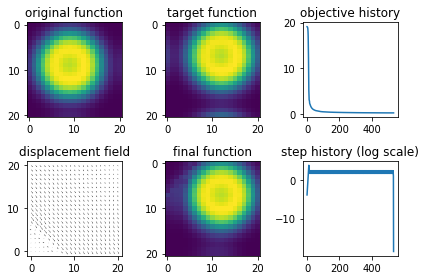

In [18]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

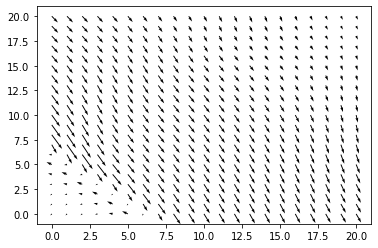

In [19]:
plt.quiver(ux, uy)
plt.show()

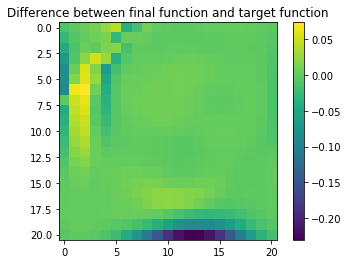

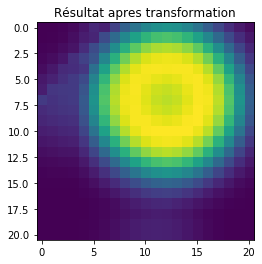

In [20]:
diff=interpol(f,ux,uy)-g
fig, ax = plt.subplots()
p = ax.imshow(diff)
cb = fig.colorbar(p)
plt.title('Difference between final function and target function')
plt.show()
plt.title('Résultat apres transformation')
plt.imshow(interpol(f,ux,uy))

# 4. Algorithme de moindres carrés.

On souhaite maintenant implémenter un algorithme de second ordre pour résoudre le problème $(P)\quad\min_u E(u)+R(u)$ afin d'accélérer la convergence de l'algorithme. Pour cela, on va reformuler le problème $(P)$ en un problème de moindres carrés et appliquer l'algorithme de Levenberg-Marquardt.

Soit:
$$\Psi(u)=\begin{pmatrix} 
f\circ(Id+u)-g \\ 
\sqrt{\mu}(\partial_xu_y+\partial_yu_x) \\ 
\sqrt{\mu+\lambda}(\partial_xu_x+\partial_yu_y) \end{pmatrix},$$
où $f\circ(id+u)$ est l'interpolation de $x\mapsto f(x+u(x))$ sur la grille. Minimiser $E(u)+R(u)$ est équivalent à résoudre le problème suivant:

>$$\min_u \|\Psi(u)\|_2^2.$$

Il s'agit maintenant d'un problème de moindres carrés que l'on va résoudre à l'aide de l'algorithme de Levenberg Marquardt :

$$
u_{k+1}=u_k- H_k^{-1} J_{\Psi}(u_k)^\top \Psi(u_k) \quad\mbox{ avec }\quad H_k=J_{\Psi}(u_k)^\top J_{\Psi}(u_k) +\varepsilon Id
$$

Q6. Calculer la matrice jacobienne de $\Psi$, notée $J_\Psi(u)$.

Q7. Implémenter les fonctions JPsi, JTPsi et JTJ qui calculent respectivement:
- le produit de $J_\psi(u)$ par une direction $v=(v_x,v_y)\in V^2$,

- le produit de $J_\Psi(u)^\top$ par $\phi=(\phi_1,\phi_2,\phi_3)\in V^3$,

- le produit de $(J_\Psi(u)^\top J_\Psi(u)+\epsilon I)$ par une direction $v=(v_x,v_y)\in V^2$.

In [5]:
def JTPsi(phi,df,lamb,mu):
    ux = df[0]*phi[0] + np.sqrt(mu)*dyT(phi[1]) + np.sqrt(mu+lamb)*(dxT(phi[2]))
    uy = df[1]*phi[0] + np.sqrt(mu)*dxT(phi[1]) + np.sqrt(mu+lamb)*(dyT(phi[2]))
    #raise ValueError('to be implemented') 
    return np.array([ux,uy])

def JPsi(vx,vy,df,lamb,mu):
    JPsi0 = df[0]*vx + df[1]*vy
    JPsi1 = np.sqrt(mu)*(dy(vx)+dx(vy))
    JPsi2 = np.sqrt(mu+lamb)*(dx(vx)+dy(vy))
    return np.array([JPsi0,JPsi1,JPsi2])
  
def JTJ(vx,vy,df,lamb,mu,epsilon) :
    #raise ValueError('to be implemented')
    psi = JPsi(vx,vy,df,lamb,mu)
    u = JTPsi(psi,df,lamb,mu)
    uxs = u[0] + epsilon*vx
    uys = u[1] + epsilon*vy
    return uxs,uys

def Psi(f,g,ux,uy,lamb,mu):
    Psi0 = interpol(f,ux,uy) - g
    Psi1 = np.sqrt(mu)*(dy(ux)+dx(uy))
    Psi2 = np.sqrt(mu+lamb)*(dx(ux)+dy(uy))
    return np.array([Psi0,Psi1,Psi2])

Calculons maintenant la direction de recherche $d_k$ comme solution du système linéaire:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = -J_\Psi(u_k)^\top \Psi(u_k)$$
Pour cela, on vous donne l'algorithme suivant qui par la méthode du gradient conjugué calcule une solution $d=(d_x,d_y)\in V^2$ du problème:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = b$$

In [6]:
 def CGSolve(u0x,u0y,lamb,mu,b,epsilon,df) :
    nitmax=100;
    ux=u0x; uy=u0y; #point de départ de l'algorithme
    # Computes JTJu
    Ax,Ay=JTJ(ux,uy,df,lamb,mu,epsilon);
    rx=b[0]-Ax
    ry=b[1]-Ay
    px=rx
    py=ry
    rsold=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
    for i in range(nitmax) :
        Apx,Apy=JTJ(px,py,df,lamb,mu,epsilon);
        alpha=rsold/(np.vdot(rx[:],Apx[:])+np.vdot(ry[:],Apy[:]))
        ux=ux+alpha*px
        uy=uy+alpha*py
        rx=rx-alpha*Apx
        ry=ry-alpha*Apy
        rsnew=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
        if np.sqrt(rsnew)<1e-10 :
            return [ux,uy]
        px=rx+rsnew/rsold*px
        py=ry+rsnew/rsold*py
        rsold=rsnew
    return [ux,uy]

Q8. Compléter l'algorithme RecalageGN implémentant la méthode de Levenberg-Marquardt.

In [42]:
def RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    descentx=np.zeros(f.shape)
    descenty=np.zeros(f.shape)  
    #raise ValueError('To complete if necessary')
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        # Gradient of F at point u
        dfx = interpol(dx(f),ux,uy)
        dfy = interpol(dy(f),ux,uy)
        psi = Psi(f,g,ux,uy,lamb,mu)
        b = JTPsi(psi,[dfx,dfy],lamb,mu)
        [descentx,descenty]=CGSolve(descentx,descenty,lamb,mu,b,epsi,[dfx,dfy])
        ux,uy,step=linesearch(ux,uy,step,descentx,descenty,obj,f,g,lamb,mu)
        step_list.append(step)
        # Display
        if (niter % 1 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter

Q9. Tester le nouvel algorithme et comparer sa vitesse de convergence avec celle de l'algorithme de gradient.

In [24]:
epsi=0.001
nitermax = 2500
tab2 = []
stepini = 0.01
for i in range(-1,5):
    for j in range(-1,5):
        mu = 10/(10**j)
        lamb = 10/(10**i)
        ux,uy,CF,step,niter=RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi)
        tab2+= [((lamb,mu),niter,CF[-1],step[-1])]


iteration : 1  cost function : 19.117153747845773 step : 0.02
iteration : 2  cost function : 18.85281847058099 step : 0.04
iteration : 3  cost function : 18.32849452162173 step : 0.08
iteration : 4  cost function : 17.224862024893234 step : 0.16
iteration : 5  cost function : 15.0526676970555 step : 0.32
iteration : 6  cost function : 10.985244060393377 step : 0.64
iteration : 7  cost function : 4.845850846587251 step : 1.28
iteration : 8  cost function : 2.0023969629457907 step : 9.5367431640625e-09
iteration : 1  cost function : 19.117153747845773 step : 0.02
iteration : 2  cost function : 18.80831557153579 step : 0.04
iteration : 3  cost function : 18.192682976741214 step : 0.08
iteration : 4  cost function : 16.90211072298814 step : 0.16
iteration : 5  cost function : 14.373700951239039 step : 0.32
iteration : 6  cost function : 9.745385582205143 step : 0.64
iteration : 7  cost function : 3.2703290213831266 step : 1.28
iteration : 8  cost function : 1.7961963444069982 step : 9.5367

iteration : 6  cost function : 8.451585517014074 step : 0.64
iteration : 7  cost function : 2.356715196799823 step : 1.28
iteration : 8  cost function : 0.7317206526650615 step : 0.16
iteration : 9  cost function : 0.7290147846155675 step : 0.32
iteration : 10  cost function : 0.720596251882105 step : 0.64
iteration : 11  cost function : 0.4855582720384158 step : 1.28
iteration : 12  cost function : 0.2766923528723617 step : 0.32
iteration : 13  cost function : 0.27071681102428846 step : 0.64
iteration : 14  cost function : 0.2697900065364725 step : 0.64
iteration : 15  cost function : 0.26621452972457765 step : 1.28
iteration : 16  cost function : 0.26576211373927205 step : 0.64
iteration : 17  cost function : 0.2630041270248867 step : 0.64
iteration : 18  cost function : 0.2619237705339732 step : 1.28
iteration : 19  cost function : 0.26184683109396145 step : 0.64
iteration : 20  cost function : 0.2601780568267814 step : 0.005
iteration : 21  cost function : 0.2601780567848659 step :

iteration : 6  cost function : 7.789925645934621 step : 0.64
iteration : 7  cost function : 2.163338600355576 step : 1.28
iteration : 8  cost function : 0.35873366503316106 step : 2.56
iteration : 9  cost function : 0.358131658304906 step : 1.28
iteration : 10  cost function : 0.24753114582776997 step : 1.28
iteration : 11  cost function : 0.23864499673601014 step : 9.5367431640625e-09
iteration : 1  cost function : 19.117153747845773 step : 0.02
iteration : 2  cost function : 18.634951816125223 step : 0.04
iteration : 3  cost function : 17.688010731939393 step : 0.08
iteration : 4  cost function : 15.875149937160257 step : 0.16
iteration : 5  cost function : 12.599847795377205 step : 0.32
iteration : 6  cost function : 7.475011779657469 step : 0.64
iteration : 7  cost function : 2.0850807654309356 step : 1.28
iteration : 8  cost function : 0.41727337765504857 step : 1.28
iteration : 9  cost function : 0.26277566576517597 step : 2.56
iteration : 10  cost function : 0.2592166149287332 s

iteration : 10  cost function : 0.3917430103280252 step : 1.28
iteration : 11  cost function : 0.3047187634794047 step : 1.28
iteration : 12  cost function : 0.290555035739803 step : 1.28
iteration : 13  cost function : 0.27060759089505415 step : 0.64
iteration : 14  cost function : 0.2688495368420119 step : 1.28
iteration : 15  cost function : 0.26852192351544246 step : 1.28
iteration : 16  cost function : 0.26596511403652073 step : 0.64
iteration : 17  cost function : 0.2641534719399994 step : 0.64
iteration : 18  cost function : 0.26397922941267027 step : 0.64
iteration : 19  cost function : 0.26367508133216455 step : 9.5367431640625e-09
iteration : 1  cost function : 19.117153747845773 step : 0.02
iteration : 2  cost function : 18.674097855052672 step : 0.04
iteration : 3  cost function : 17.800467878898182 step : 0.08
iteration : 4  cost function : 16.11793935787138 step : 0.16
iteration : 5  cost function : 13.034728732835598 step : 0.32
iteration : 6  cost function : 8.032271242

iteration : 6  cost function : 5.489014451814611 step : 0.64
iteration : 7  cost function : 1.558344405594751 step : 1.28
iteration : 8  cost function : 0.8505119090747609 step : 1.28
iteration : 9  cost function : 0.7471745512179395 step : 1.28
iteration : 10  cost function : 0.7120042068034365 step : 1.28
iteration : 11  cost function : 0.49141490742489546 step : 1.28
iteration : 12  cost function : 0.444908629581902 step : 1.28
iteration : 13  cost function : 0.40047889376728085 step : 2.56
iteration : 14  cost function : 0.36349211432672557 step : 1.28
iteration : 15  cost function : 0.35244905059313597 step : 1.28
iteration : 16  cost function : 0.3356845999682902 step : 0.64
iteration : 17  cost function : 0.3349048358457575 step : 9.5367431640625e-09


In [25]:
df2 = pd.DataFrame(tab2,columns = ['(lamb-mu)','niter', 'costfunction', 'step'])
# Create a Pandas dataframe from some data.
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('pandas2.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df2.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [93]:
df2.style

In [26]:
#epsi=0.1
#nitermax=1000
epsi=0.001
#lamb=10
#mu=20
lamb = 0.01
mu = 0.01
step0 = 0.01
nitermax= 25000
ux,uy,CF,step,niter=RecalageGN(f,g,lamb,mu,nitermax,step0,epsi)

iteration : 1  cost function : 19.117153747845773 step : 0.02
iteration : 2  cost function : 18.550130645993626 step : 0.04
iteration : 3  cost function : 17.439295664736918 step : 0.08
iteration : 4  cost function : 15.324608860664922 step : 0.16
iteration : 5  cost function : 11.594862267518305 step : 0.32
iteration : 6  cost function : 6.2441242054504436 step : 0.64
iteration : 7  cost function : 1.7084098110578936 step : 1.28
iteration : 8  cost function : 0.524148250813856 step : 2.56
iteration : 9  cost function : 0.4323668050545123 step : 1.28
iteration : 10  cost function : 0.26751156769900847 step : 1.28
iteration : 11  cost function : 0.23763207087392804 step : 1.28
iteration : 12  cost function : 0.23162524299632187 step : 1.28
iteration : 13  cost function : 0.23054333114991213 step : 9.5367431640625e-09


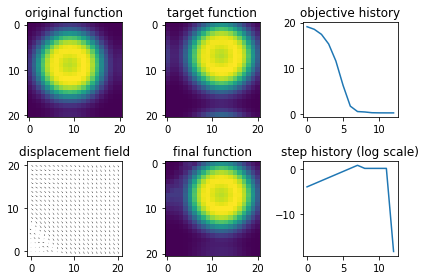

In [95]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

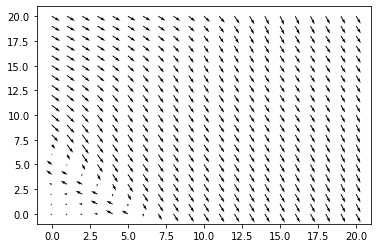

In [27]:
plt.quiver(ux, uy)
plt.show()

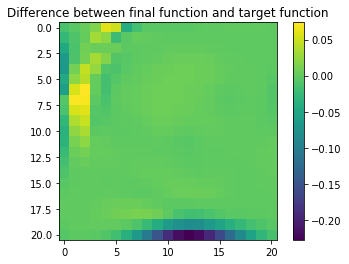

In [28]:
diff = interpol(f,ux,uy)-g
fig, ax = plt.subplots()
p = ax.imshow(diff)
cb = fig.colorbar(p)
plt.title('Difference between final function and target function')
plt.show()

5. Jeu des différences
======================
Maintenant que vous avez implémenté et testé les deux algorithmes sur l'image-jouet proposée, voyons que cela donne sur une image IRM d'un cerveau. Saurez-vous détecter les différences/déplacements entre les deux images ?

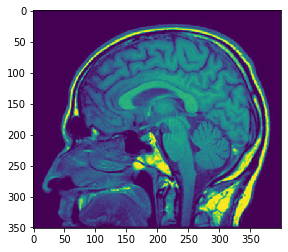

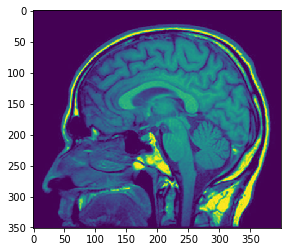

In [8]:
im1=Image.open('IRM1.png')
im2=Image.open("IRM2.png")
plt.imshow(plt.imread('IRM1.png'))
plt.show()
plt.imshow(plt.imread('IRM2.png'))
plt.show()

In [ ]:
# [n,m]=im1.size
#sigma=0.1
#[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
#Z=np.sqrt(X*X+Y*Y)
#G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
#f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
#g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
#f=f/np.max(f)
#g=g/np.max(g)

In [13]:
ratio=1
sigma=1e-2

im1=Image.open('IRM1.png')
im2=Image.open("IRM2.png")
im1 = im1.resize((int(im1.size[0]/ratio), int(im1.size[1]/ratio)), Image.ANTIALIAS)
im2 = im2.resize((int(im2.size[0]/ratio), int(im2.size[1]/ratio)), Image.ANTIALIAS)

[n,m]=im1.size
[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
Z=np.sqrt(X*X+Y*Y)
G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
fIMR=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
gIMR=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
fIMR=fIMR/np.max(fIMR)
gIMR=gIMR/np.max(gIMR)

In [31]:
epsi=0.001
nitermax = 500
tab4 = []
stepini = 0.01
for i in range(2,6):
    for j in range(2,6):
        mu = 10/(10**j)
        lamb = 10/(10**i)
        uxIMR,uyIMR,CFIMR,stepIMR,niter=RecalageDG(fIMR,gIMR,lamb,mu,nitermax,stepini)
        tab4+= [((lamb,mu),niter,CFIMR[-1],stepIMR[-1])]


iteration : 3  cost function : 2.765856456710081 step : 0.08
iteration : 6  cost function : 2.7533906097607956 step : 0.64
iteration : 9  cost function : 2.67572429826169 step : 5.12
iteration : 12  cost function : 2.489650445664473 step : 1.28
iteration : 15  cost function : 2.350542064251373 step : 1.28
iteration : 18  cost function : 2.3334053848278833 step : 0.64
iteration : 21  cost function : 2.3162896645533624 step : 1.28
iteration : 24  cost function : 2.3008623720039796 step : 1.28
iteration : 27  cost function : 2.2907816749011345 step : 0.64
iteration : 30  cost function : 2.271476598626712 step : 0.64
iteration : 33  cost function : 2.2570935927853113 step : 1.28
iteration : 36  cost function : 2.2439877514897852 step : 0.64
iteration : 39  cost function : 2.2296431848287264 step : 1.28
iteration : 42  cost function : 2.2184304995899597 step : 0.64
iteration : 45  cost function : 2.2035702255970206 step : 1.28
iteration : 48  cost function : 2.1951975989444237 step : 0.64
i

iteration : 393  cost function : 1.5181723005808183 step : 1.28
iteration : 396  cost function : 1.5160515462627346 step : 0.64
iteration : 399  cost function : 1.5130161502700583 step : 0.64
iteration : 402  cost function : 1.510440633035389 step : 1.28
iteration : 405  cost function : 1.508127131935441 step : 0.64
iteration : 408  cost function : 1.505385545652458 step : 1.28
iteration : 411  cost function : 1.5036409190488227 step : 0.64
iteration : 414  cost function : 1.5005417276611033 step : 0.64
iteration : 417  cost function : 1.498017468335592 step : 1.28
iteration : 420  cost function : 1.4959993980672366 step : 0.64
iteration : 423  cost function : 1.493248699603316 step : 1.28
iteration : 426  cost function : 1.4908896579796689 step : 1.28
iteration : 429  cost function : 1.4887122365267365 step : 0.64
iteration : 432  cost function : 1.486214218169782 step : 1.28
iteration : 435  cost function : 1.4845235208562022 step : 0.64
iteration : 438  cost function : 1.48172350882

iteration : 285  cost function : 1.0358600426727247 step : 2.56
iteration : 288  cost function : 1.032356838518991 step : 2.56
iteration : 291  cost function : 1.0304310043420624 step : 1.28
iteration : 294  cost function : 1.0271155390402977 step : 2.56
iteration : 297  cost function : 1.0244936116395968 step : 2.56
iteration : 300  cost function : 1.022338234334525 step : 2.56
iteration : 303  cost function : 1.0194617058710456 step : 2.56
iteration : 306  cost function : 1.0170402339793772 step : 2.56
iteration : 309  cost function : 1.0139450477591736 step : 2.56
iteration : 312  cost function : 1.0120995510582498 step : 1.28
iteration : 315  cost function : 1.0098051787295803 step : 1.28
iteration : 318  cost function : 1.0065130728969143 step : 2.56
iteration : 321  cost function : 1.0041381564169776 step : 5.12
iteration : 324  cost function : 1.0013669995748853 step : 2.56
iteration : 327  cost function : 0.9992288930434365 step : 2.56
iteration : 330  cost function : 0.9965153

iteration : 177  cost function : 1.0576150230861792 step : 2.56
iteration : 180  cost function : 1.055947367529899 step : 1.28
iteration : 183  cost function : 1.0410638897529112 step : 5.12
iteration : 186  cost function : 1.0380375221023979 step : 2.56
iteration : 189  cost function : 1.0362842690849856 step : 2.56
iteration : 192  cost function : 1.0244200349081916 step : 5.12
iteration : 195  cost function : 1.019949661857187 step : 2.56
iteration : 198  cost function : 1.0181388481492661 step : 2.56
iteration : 201  cost function : 1.0075640104617547 step : 5.12
iteration : 204  cost function : 1.0032081667500146 step : 2.56
iteration : 207  cost function : 1.0013575573408624 step : 2.56
iteration : 210  cost function : 0.9919173003541775 step : 5.12
iteration : 213  cost function : 0.9876809655922589 step : 2.56
iteration : 216  cost function : 0.9858111377982274 step : 2.56
iteration : 219  cost function : 0.977366805952178 step : 2.56
iteration : 222  cost function : 0.97325585

iteration : 66  cost function : 1.5393161433446532 step : 2.56
iteration : 69  cost function : 1.534519666740288 step : 2.56
iteration : 72  cost function : 1.4761329412363928 step : 5.12
iteration : 75  cost function : 1.4536509500800816 step : 2.56
iteration : 78  cost function : 1.440011467000177 step : 2.56
iteration : 81  cost function : 1.4281963824845028 step : 2.56
iteration : 84  cost function : 1.41880409054081 step : 2.56
iteration : 87  cost function : 1.412714110090426 step : 2.56
iteration : 90  cost function : 1.3716411866361866 step : 2.56
iteration : 93  cost function : 1.3520945274748501 step : 2.56
iteration : 96  cost function : 1.3403516968985403 step : 2.56
iteration : 99  cost function : 1.3298922405504807 step : 2.56
iteration : 102  cost function : 1.3211185860963957 step : 2.56
iteration : 105  cost function : 1.3146243535745852 step : 2.56
iteration : 108  cost function : 1.3112838380854774 step : 2.56
iteration : 111  cost function : 1.27305718834483 step : 

iteration : 453  cost function : 0.7665494034365148 step : 2.56
iteration : 456  cost function : 0.7660637521854969 step : 2.56
iteration : 459  cost function : 0.7632387877895483 step : 5.12
iteration : 462  cost function : 0.7622292355156863 step : 2.56
iteration : 465  cost function : 0.7619865858650059 step : 1.28
iteration : 468  cost function : 0.7584497912120812 step : 2.56
iteration : 471  cost function : 0.7572905848323961 step : 2.56
iteration : 474  cost function : 0.7562151336059864 step : 2.56
iteration : 477  cost function : 0.7552873175664125 step : 2.56
iteration : 480  cost function : 0.7546286370520672 step : 2.56
iteration : 483  cost function : 0.7524926722855227 step : 2.56
iteration : 486  cost function : 0.7512738068162265 step : 2.56
iteration : 489  cost function : 0.7507852137650105 step : 2.56
iteration : 492  cost function : 0.7484091510554632 step : 5.12
iteration : 495  cost function : 0.7474328360007036 step : 2.56
iteration : 498  cost function : 0.74714

iteration : 345  cost function : 1.3180817073549078 step : 1.28
iteration : 348  cost function : 1.3133116548931918 step : 2.56
iteration : 351  cost function : 1.3099223745857196 step : 1.28
iteration : 354  cost function : 1.3077154512256994 step : 1.28
iteration : 357  cost function : 1.3063761782049181 step : 1.28
iteration : 360  cost function : 1.301561305786623 step : 2.56
iteration : 363  cost function : 1.2983993242844145 step : 1.28
iteration : 366  cost function : 1.2963811319778034 step : 1.28
iteration : 369  cost function : 1.2952886059831232 step : 0.64
iteration : 372  cost function : 1.2897388111015307 step : 1.28
iteration : 375  cost function : 1.2874626529120627 step : 1.28
iteration : 378  cost function : 1.285627270822583 step : 1.28
iteration : 381  cost function : 1.2847804242915082 step : 0.64
iteration : 384  cost function : 1.279200761155039 step : 1.28
iteration : 387  cost function : 1.2770746043456467 step : 1.28
iteration : 390  cost function : 1.27541714

iteration : 234  cost function : 0.490998360271747 step : 5.12
iteration : 237  cost function : 0.48931855864214924 step : 10.24
iteration : 240  cost function : 0.4880334185267081 step : 10.24
iteration : 243  cost function : 0.48685591989248544 step : 5.12
iteration : 246  cost function : 0.4858513883673117 step : 5.12
iteration : 249  cost function : 0.48438572057982787 step : 10.24
iteration : 252  cost function : 0.48323754347738984 step : 10.24
iteration : 255  cost function : 0.48218068431905914 step : 5.12
iteration : 258  cost function : 0.4812699433631147 step : 5.12
iteration : 261  cost function : 0.47998685356285353 step : 10.24
iteration : 264  cost function : 0.4789574877080522 step : 10.24
iteration : 267  cost function : 0.4780057488802717 step : 5.12
iteration : 270  cost function : 0.4771776149687762 step : 5.12
iteration : 273  cost function : 0.47605065026246557 step : 10.24
iteration : 276  cost function : 0.47512478944173353 step : 10.24
iteration : 279  cost fun

iteration : 117  cost function : 0.33189486002018986 step : 10.24
iteration : 120  cost function : 0.32901215188171784 step : 20.48
iteration : 123  cost function : 0.3264174374483001 step : 20.48
iteration : 126  cost function : 0.3244499591629436 step : 10.24
iteration : 129  cost function : 0.32152805759775105 step : 20.48
iteration : 132  cost function : 0.31947594165390775 step : 10.24
iteration : 135  cost function : 0.3171145930785341 step : 20.48
iteration : 138  cost function : 0.3150928047154533 step : 10.24
iteration : 141  cost function : 0.31364310590711175 step : 10.24
iteration : 144  cost function : 0.3111665546476225 step : 20.48
iteration : 147  cost function : 0.30957963722228354 step : 10.24
iteration : 150  cost function : 0.3076138619584844 step : 20.48
iteration : 153  cost function : 0.3060143633880847 step : 10.24
iteration : 156  cost function : 0.30437420619547173 step : 20.48
iteration : 159  cost function : 0.3028233409547306 step : 20.48
iteration : 162  c

iteration : 495  cost function : 0.25720452940577193 step : 10.24
iteration : 498  cost function : 0.2571034565046343 step : 20.48
iteration : 3  cost function : 2.7658518643420766 step : 0.08
iteration : 6  cost function : 2.7528718630572295 step : 0.64
iteration : 9  cost function : 2.6532564596327255 step : 5.12
iteration : 12  cost function : 2.067311623436662 step : 40.96
iteration : 15  cost function : 0.919898504060448 step : 40.96
iteration : 18  cost function : 0.8210405783499833 step : 20.48
iteration : 21  cost function : 0.7650653604654111 step : 20.48
iteration : 24  cost function : 0.7215932170218924 step : 20.48
iteration : 27  cost function : 0.6914251063426182 step : 20.48
iteration : 30  cost function : 0.6778400533215976 step : 20.48
iteration : 33  cost function : 0.5981932883984074 step : 40.96
iteration : 36  cost function : 0.5615515658625362 step : 20.48
iteration : 39  cost function : 0.539160053845565 step : 20.48
iteration : 42  cost function : 0.523294883051

iteration : 375  cost function : 0.2122610472428889 step : 10.24
iteration : 378  cost function : 0.21205245152490165 step : 10.24
iteration : 381  cost function : 0.21176036192910275 step : 20.48
iteration : 384  cost function : 0.21152416101737004 step : 20.48
iteration : 387  cost function : 0.21129512138462087 step : 20.48
iteration : 390  cost function : 0.2110753466005093 step : 20.48
iteration : 393  cost function : 0.21086768091687916 step : 10.24
iteration : 396  cost function : 0.21067757607379714 step : 10.24
iteration : 399  cost function : 0.21041177265487088 step : 20.48
iteration : 402  cost function : 0.21019625105753265 step : 20.48
iteration : 405  cost function : 0.20998703208100372 step : 20.48
iteration : 408  cost function : 0.20978602692550824 step : 20.48
iteration : 411  cost function : 0.20959584303327178 step : 10.24
iteration : 414  cost function : 0.2094214292328297 step : 10.24
iteration : 417  cost function : 0.20917862086005068 step : 20.48
iteration : 4

iteration : 261  cost function : 1.3958714714998424 step : 2.56
iteration : 264  cost function : 1.3916354026128581 step : 1.28
iteration : 267  cost function : 1.3881144928140157 step : 1.28
iteration : 270  cost function : 1.3849213907811464 step : 1.28
iteration : 273  cost function : 1.3821683033798906 step : 1.28
iteration : 276  cost function : 1.3800144784937232 step : 1.28
iteration : 279  cost function : 1.3786868599044162 step : 1.28
iteration : 282  cost function : 1.366609287167826 step : 1.28
iteration : 285  cost function : 1.3612929059178644 step : 1.28
iteration : 288  cost function : 1.3579876093183803 step : 1.28
iteration : 291  cost function : 1.3549214278766522 step : 1.28
iteration : 294  cost function : 1.352172280129536 step : 1.28
iteration : 297  cost function : 1.349851499771889 step : 1.28
iteration : 300  cost function : 1.3481170314399105 step : 1.28
iteration : 303  cost function : 1.3471939196781966 step : 1.28
iteration : 306  cost function : 1.33555565

iteration : 150  cost function : 0.43355737284084866 step : 10.24
iteration : 153  cost function : 0.43226407961629265 step : 10.24
iteration : 156  cost function : 0.4274489290079967 step : 20.48
iteration : 159  cost function : 0.4244347683606806 step : 10.24
iteration : 162  cost function : 0.4224827307002068 step : 10.24
iteration : 165  cost function : 0.42120156908487505 step : 10.24
iteration : 168  cost function : 0.4173576739888527 step : 20.48
iteration : 171  cost function : 0.41471075422031783 step : 10.24
iteration : 174  cost function : 0.41296530889272065 step : 10.24
iteration : 177  cost function : 0.41172864935393566 step : 10.24
iteration : 180  cost function : 0.4086295756267574 step : 10.24
iteration : 183  cost function : 0.40629948120786885 step : 10.24
iteration : 186  cost function : 0.4047403944395427 step : 10.24
iteration : 189  cost function : 0.40357151577266437 step : 10.24
iteration : 192  cost function : 0.4010402771057001 step : 10.24
iteration : 195  

iteration : 30  cost function : 0.3480377914555365 step : 40.96
iteration : 33  cost function : 0.32361034158331703 step : 40.96
iteration : 36  cost function : 0.3073053051353101 step : 40.96
iteration : 39  cost function : 0.2958163306959424 step : 20.48
iteration : 42  cost function : 0.28047345678904656 step : 40.96
iteration : 45  cost function : 0.26850694619490595 step : 40.96
iteration : 48  cost function : 0.25820413347436383 step : 40.96
iteration : 51  cost function : 0.2526090555123187 step : 20.48
iteration : 54  cost function : 0.24172178498183705 step : 20.48
iteration : 57  cost function : 0.23376324053311337 step : 20.48
iteration : 60  cost function : 0.22760440497670875 step : 20.48
iteration : 63  cost function : 0.22305576393807167 step : 20.48
iteration : 66  cost function : 0.2191111981481391 step : 20.48
iteration : 69  cost function : 0.21329516740938365 step : 40.96
iteration : 72  cost function : 0.20912735413078407 step : 20.48
iteration : 75  cost function 

iteration : 405  cost function : 0.10938158543653176 step : 20.48
iteration : 408  cost function : 0.1091799430563771 step : 20.48
iteration : 411  cost function : 0.1090355367696794 step : 20.48
iteration : 414  cost function : 0.10886454922989316 step : 40.96
iteration : 417  cost function : 0.10871325367915208 step : 20.48
iteration : 420  cost function : 0.10859561578389729 step : 20.48
iteration : 423  cost function : 0.10840872110688538 step : 20.48
iteration : 426  cost function : 0.10827686387978358 step : 20.48
iteration : 429  cost function : 0.1081185061834608 step : 40.96
iteration : 432  cost function : 0.10797968504919003 step : 20.48
iteration : 435  cost function : 0.10787284857266276 step : 20.48
iteration : 438  cost function : 0.10769901406374366 step : 20.48
iteration : 441  cost function : 0.10757815942672194 step : 20.48
iteration : 444  cost function : 0.10743130259990602 step : 40.96
iteration : 447  cost function : 0.10730377959359601 step : 20.48
iteration : 4

iteration : 285  cost function : 0.07430570920555941 step : 40.96
iteration : 288  cost function : 0.07405224814066191 step : 20.48
iteration : 291  cost function : 0.07369915273866803 step : 20.48
iteration : 294  cost function : 0.07337707895530114 step : 20.48
iteration : 297  cost function : 0.07307331140947435 step : 40.96
iteration : 300  cost function : 0.07278379786129027 step : 40.96
iteration : 303  cost function : 0.07256997655842268 step : 20.48
iteration : 306  cost function : 0.07224781304754044 step : 20.48
iteration : 309  cost function : 0.0719519121526038 step : 20.48
iteration : 312  cost function : 0.0716765912826195 step : 40.96
iteration : 315  cost function : 0.07141388185067314 step : 40.96
iteration : 318  cost function : 0.071238229590497 step : 20.48
iteration : 321  cost function : 0.07093746208697906 step : 20.48
iteration : 324  cost function : 0.07066764901141162 step : 20.48
iteration : 327  cost function : 0.07041537409741178 step : 20.48
iteration : 33

iteration : 168  cost function : 1.55038678303056 step : 1.28
iteration : 171  cost function : 1.5263396932539317 step : 2.56
iteration : 174  cost function : 1.520080412021607 step : 1.28
iteration : 177  cost function : 1.5169090801301504 step : 1.28
iteration : 180  cost function : 1.5148061925988014 step : 1.28
iteration : 183  cost function : 1.5141081934509444 step : 0.64
iteration : 186  cost function : 1.487713739466129 step : 5.12
iteration : 189  cost function : 1.4850154764171535 step : 1.28
iteration : 192  cost function : 1.4825519198660122 step : 1.28
iteration : 195  cost function : 1.4812037877394648 step : 1.28
iteration : 198  cost function : 1.4611960733189762 step : 2.56
iteration : 201  cost function : 1.4558735615641916 step : 1.28
iteration : 204  cost function : 1.4531819070962624 step : 1.28
iteration : 207  cost function : 1.451378092545501 step : 1.28
iteration : 210  cost function : 1.4507423838428273 step : 0.64
iteration : 213  cost function : 1.4286931545

iteration : 57  cost function : 0.6258501914589982 step : 10.24
iteration : 60  cost function : 0.6103556887037114 step : 10.24
iteration : 63  cost function : 0.5983748354554426 step : 10.24
iteration : 66  cost function : 0.5852355147596737 step : 20.48
iteration : 69  cost function : 0.574274278138627 step : 10.24
iteration : 72  cost function : 0.5630341223567016 step : 20.48
iteration : 75  cost function : 0.5530185113996517 step : 10.24
iteration : 78  cost function : 0.5462936329933894 step : 10.24
iteration : 81  cost function : 0.5341734026648219 step : 10.24
iteration : 84  cost function : 0.5275691257994235 step : 10.24
iteration : 87  cost function : 0.5173863098648855 step : 10.24
iteration : 90  cost function : 0.511010323518803 step : 10.24
iteration : 93  cost function : 0.5023680550190525 step : 10.24
iteration : 96  cost function : 0.4962830362192023 step : 10.24
iteration : 99  cost function : 0.4888786723085128 step : 10.24
iteration : 102  cost function : 0.4831230

iteration : 435  cost function : 0.3326310532132454 step : 10.24
iteration : 438  cost function : 0.3324987227442129 step : 10.24
iteration : 441  cost function : 0.33244513859578917 step : 5.12
iteration : 444  cost function : 0.33195517162575405 step : 10.24
iteration : 447  cost function : 0.3317821256038094 step : 10.24
iteration : 450  cost function : 0.33163187917622816 step : 10.24
iteration : 453  cost function : 0.3315262027787341 step : 10.24
iteration : 456  cost function : 0.33122663528174373 step : 10.24
iteration : 459  cost function : 0.33100663583332046 step : 10.24
iteration : 462  cost function : 0.3308528038140063 step : 10.24
iteration : 465  cost function : 0.3307250865736679 step : 10.24
iteration : 468  cost function : 0.3306490737783705 step : 10.24
iteration : 471  cost function : 0.3303351524996784 step : 20.48
iteration : 474  cost function : 0.3301380658204305 step : 10.24
iteration : 477  cost function : 0.33000249134148996 step : 10.24
iteration : 480  cos

iteration : 315  cost function : 0.09414876645113382 step : 20.48
iteration : 318  cost function : 0.0938515672599784 step : 20.48
iteration : 321  cost function : 0.09356486784449548 step : 20.48
iteration : 324  cost function : 0.09328657254757024 step : 20.48
iteration : 327  cost function : 0.09302087982746318 step : 20.48
iteration : 330  cost function : 0.09265332500146142 step : 40.96
iteration : 333  cost function : 0.09237083437476853 step : 40.96
iteration : 336  cost function : 0.0920942340736176 step : 40.96
iteration : 339  cost function : 0.09182381784025063 step : 40.96
iteration : 342  cost function : 0.09155926474279338 step : 20.48
iteration : 345  cost function : 0.09130122717892081 step : 20.48
iteration : 348  cost function : 0.09104925886592882 step : 20.48
iteration : 351  cost function : 0.09080423713019645 step : 20.48
iteration : 354  cost function : 0.09056562794941461 step : 20.48
iteration : 357  cost function : 0.09033515198337892 step : 20.48
iteration : 

iteration : 195  cost function : 0.06529183390533552 step : 40.96
iteration : 198  cost function : 0.06477144278966261 step : 40.96
iteration : 201  cost function : 0.0642700247385421 step : 20.48
iteration : 204  cost function : 0.06375170223111098 step : 40.96
iteration : 207  cost function : 0.0633188120137719 step : 20.48
iteration : 210  cost function : 0.06278687672703104 step : 40.96
iteration : 213  cost function : 0.06244148843600818 step : 20.48
iteration : 216  cost function : 0.06187600076369363 step : 20.48
iteration : 219  cost function : 0.061423644380150036 step : 40.96
iteration : 222  cost function : 0.06102062029032457 step : 20.48
iteration : 225  cost function : 0.06055964980403207 step : 40.96
iteration : 228  cost function : 0.06022307537545504 step : 20.48
iteration : 231  cost function : 0.059739246479659155 step : 40.96
iteration : 234  cost function : 0.05934375192146633 step : 40.96
iteration : 237  cost function : 0.058964873453414474 step : 20.48
iteration

In [32]:
df4 = pd.DataFrame(tab4,columns = ['(lamb-mu)','niter', 'costfunction', 'step'])
# Create a Pandas dataframe from some data.
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('pandas4.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df4.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [33]:
df4.style

In [105]:
epsi=0.001
nitermax = 500
tab6 = []
stepini = 0.01
for i in range(2,6):
    for j in range(2,6):
        mu = 10/(10**j)
        lamb = 10/(10**i)
        uxIMR,uyIMR,CFIMR,stepIMR,niter=RecalageGN(fIMR,gIMR,lamb,mu,nitermax,stepini,epsi)
        tab6+= [((lamb,mu),niter,CFIMR[-1],stepIMR[-1])]

iteration : 1  cost function : 2.7672497682543185 step : 0.02
iteration : 2  cost function : 2.7250288403884877 step : 0.04
iteration : 3  cost function : 2.6434325196400765 step : 0.08
iteration : 4  cost function : 2.4911893153419373 step : 0.16
iteration : 5  cost function : 2.2267699962066256 step : 0.32
iteration : 6  cost function : 1.8313654581838867 step : 0.64
iteration : 7  cost function : 1.4031146672592847 step : 1.28
iteration : 8  cost function : 1.174868758144276 step : 2.56
iteration : 9  cost function : 1.1364318608727142 step : 2.56
iteration : 10  cost function : 1.130472653269896 step : 1.28
iteration : 11  cost function : 1.1278962747104568 step : 2.56
iteration : 12  cost function : 1.1264746312111813 step : 1.28
iteration : 13  cost function : 1.1262773828721246 step : 2.56
iteration : 14  cost function : 1.1257038083073305 step : 0.64
iteration : 15  cost function : 1.1256758100681747 step : 1.28
iteration : 16  cost function : 1.1256294864417815 step : 2.56
ite

In [106]:
df6 = pd.DataFrame(tab6,columns = ['(lamb-mu)','niter', 'costfunction', 'step'])
# Create a Pandas dataframe from some data.
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('pandas6.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df6.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [107]:
df6.style

In [34]:
nitermax = 1000
tab5 = []
stepini = 0.01
for i in range(-1,10):
    epsi=10/5**i
    mu = 0.0001
    lamb = 0.0001
    uxIMR,uyIMR,CFIMR,stepIMR,niter=RecalageGN(fIMR,gIMR,lamb,mu,nitermax,stepini,epsi)
    tab5+= [(epsi,niter,CFIMR[-1],stepIMR[-1])]


iteration : 1  cost function : 2.7672497682543193 step : 0.02
iteration : 2  cost function : 2.7672404462925626 step : 0.04
iteration : 3  cost function : 2.7672218024934776 step : 0.08
iteration : 4  cost function : 2.7671845153930548 step : 0.16
iteration : 5  cost function : 2.7671099431831205 step : 0.32
iteration : 6  cost function : 2.766960806726635 step : 0.64
iteration : 7  cost function : 2.7666625656649506 step : 1.28
iteration : 8  cost function : 2.7660662109286758 step : 2.56
iteration : 9  cost function : 2.7648740108603196 step : 5.12
iteration : 10  cost function : 2.762491647186579 step : 10.24
iteration : 11  cost function : 2.757735056462908 step : 20.48
iteration : 12  cost function : 2.748254347715167 step : 40.96
iteration : 13  cost function : 2.7294222311357874 step : 81.92
iteration : 14  cost function : 2.6922704908002606 step : 163.84
iteration : 15  cost function : 2.619979441475756 step : 327.68
iteration : 16  cost function : 2.483149561824614 step : 655.

iteration : 125  cost function : 0.08970347738805887 step : 1310.72
iteration : 126  cost function : 0.08928155684681793 step : 1310.72
iteration : 127  cost function : 0.08885985374603786 step : 1310.72
iteration : 128  cost function : 0.08845988840739841 step : 2621.44
iteration : 129  cost function : 0.08840688469959054 step : 1310.72
iteration : 130  cost function : 0.08791654655825755 step : 1310.72
iteration : 131  cost function : 0.08736932774458891 step : 1310.72
iteration : 132  cost function : 0.08693454172746634 step : 1310.72
iteration : 133  cost function : 0.08647835467726667 step : 1310.72
iteration : 134  cost function : 0.08608021808031935 step : 1310.72
iteration : 135  cost function : 0.08567589093185783 step : 1310.72
iteration : 136  cost function : 0.08530352045555753 step : 1310.72
iteration : 137  cost function : 0.0849314030692038 step : 1310.72
iteration : 138  cost function : 0.08457805647737798 step : 2621.44
iteration : 139  cost function : 0.08454118343724

iteration : 246  cost function : 0.060714286237873435 step : 1310.72
iteration : 247  cost function : 0.06057744507383102 step : 1310.72
iteration : 248  cost function : 0.060446563439856785 step : 1310.72
iteration : 249  cost function : 0.060316863427784376 step : 2621.44
iteration : 250  cost function : 0.06029956832416865 step : 1310.72
iteration : 251  cost function : 0.06011820863924481 step : 1310.72
iteration : 252  cost function : 0.059967297802467665 step : 1310.72
iteration : 253  cost function : 0.05981294789465168 step : 1310.72
iteration : 254  cost function : 0.059675198227708795 step : 1310.72
iteration : 255  cost function : 0.05953706203003335 step : 1310.72
iteration : 256  cost function : 0.05940832949095086 step : 1310.72
iteration : 257  cost function : 0.05928037143891217 step : 1310.72
iteration : 258  cost function : 0.05915796899916785 step : 1310.72
iteration : 259  cost function : 0.05903669176654794 step : 2621.44
iteration : 260  cost function : 0.05902609

iteration : 367  cost function : 0.04939921583407551 step : 1310.72
iteration : 368  cost function : 0.04933386134087093 step : 1310.72
iteration : 369  cost function : 0.04926862258406601 step : 1310.72
iteration : 370  cost function : 0.04920430766243625 step : 1310.72
iteration : 371  cost function : 0.04914017108013534 step : 1310.72
iteration : 372  cost function : 0.04907679956439444 step : 1310.72
iteration : 373  cost function : 0.04901364711200611 step : 2621.44
iteration : 374  cost function : 0.049009232797749006 step : 1310.72
iteration : 375  cost function : 0.04893280181769432 step : 1310.72
iteration : 376  cost function : 0.048862390866811566 step : 1310.72
iteration : 377  cost function : 0.048789873205092454 step : 1310.72
iteration : 378  cost function : 0.048721867407752584 step : 1310.72
iteration : 379  cost function : 0.04865248979880814 step : 1310.72
iteration : 380  cost function : 0.04858652531725837 step : 1310.72
iteration : 381  cost function : 0.048519702

iteration : 487  cost function : 0.04329030213905899 step : 1310.72
iteration : 488  cost function : 0.04324736080640963 step : 1310.72
iteration : 489  cost function : 0.04320380681867758 step : 1310.72
iteration : 490  cost function : 0.04316214605019504 step : 1310.72
iteration : 491  cost function : 0.0431201218897564 step : 1310.72
iteration : 492  cost function : 0.0430795530451821 step : 1310.72
iteration : 493  cost function : 0.04303879303054643 step : 1310.72
iteration : 494  cost function : 0.04299916246113383 step : 1310.72
iteration : 495  cost function : 0.04295945871118191 step : 1310.72
iteration : 496  cost function : 0.042920640861850254 step : 1310.72
iteration : 497  cost function : 0.04288182973787909 step : 1310.72
iteration : 498  cost function : 0.04284372174785071 step : 1310.72
iteration : 499  cost function : 0.042805673746335635 step : 1310.72
iteration : 500  cost function : 0.04276819117158951 step : 1310.72
iteration : 501  cost function : 0.0427308033076

iteration : 608  cost function : 0.03950688618563618 step : 1310.72
iteration : 609  cost function : 0.039480383292128496 step : 1310.72
iteration : 610  cost function : 0.039454305444861434 step : 1310.72
iteration : 611  cost function : 0.039428342609017564 step : 1310.72
iteration : 612  cost function : 0.03940267911656949 step : 1310.72
iteration : 613  cost function : 0.039377067700451476 step : 1310.72
iteration : 614  cost function : 0.039351636093713074 step : 1310.72
iteration : 615  cost function : 0.039326208441759686 step : 1310.72
iteration : 616  cost function : 0.03930088759411422 step : 2621.44
iteration : 617  cost function : 0.039296469239243584 step : 1310.72
iteration : 618  cost function : 0.0392671202287013 step : 1310.72
iteration : 619  cost function : 0.03923724546255196 step : 1310.72
iteration : 620  cost function : 0.039208735332547595 step : 1310.72
iteration : 621  cost function : 0.03917989972593498 step : 1310.72
iteration : 622  cost function : 0.039152

iteration : 729  cost function : 0.036778599753020655 step : 1310.72
iteration : 730  cost function : 0.036759335548221576 step : 1310.72
iteration : 731  cost function : 0.036740035277521066 step : 1310.72
iteration : 732  cost function : 0.03672153704436723 step : 1310.72
iteration : 733  cost function : 0.03670307117522373 step : 1310.72
iteration : 734  cost function : 0.03668524603155174 step : 1310.72
iteration : 735  cost function : 0.03666749757479184 step : 1310.72
iteration : 736  cost function : 0.03665026689459209 step : 1310.72
iteration : 737  cost function : 0.03663314011153722 step : 1310.72
iteration : 738  cost function : 0.03661643647560189 step : 1310.72
iteration : 739  cost function : 0.036599851854636496 step : 1310.72
iteration : 740  cost function : 0.036583616752252836 step : 1310.72
iteration : 741  cost function : 0.036567507326616795 step : 1310.72
iteration : 742  cost function : 0.036551689476251814 step : 1310.72
iteration : 743  cost function : 0.036535

iteration : 850  cost function : 0.03532448863795824 step : 1310.72
iteration : 851  cost function : 0.03531826236041853 step : 1310.72
iteration : 852  cost function : 0.03531234490557293 step : 1310.72
iteration : 853  cost function : 0.03530662760540027 step : 1310.72
iteration : 854  cost function : 0.035301187938323736 step : 1310.72
iteration : 855  cost function : 0.0352959439578861 step : 1310.72
iteration : 856  cost function : 0.03529094893705254 step : 1310.72
iteration : 857  cost function : 0.035286140003128214 step : 1310.72
iteration : 858  cost function : 0.035281552342863884 step : 1310.72
iteration : 859  cost function : 0.035277136637431296 step : 1310.72
iteration : 860  cost function : 0.035272914563985056 step : 1310.72
iteration : 861  cost function : 0.0352688464686465 step : 1310.72
iteration : 862  cost function : 0.035264944060148365 step : 1310.72
iteration : 863  cost function : 0.0352611747568414 step : 1310.72
iteration : 864  cost function : 0.0352575431

iteration : 54  cost function : 0.1653642060117518 step : 327.68
iteration : 55  cost function : 0.16284282152377408 step : 327.68
iteration : 56  cost function : 0.16031285958211094 step : 327.68
iteration : 57  cost function : 0.15803151577677288 step : 327.68
iteration : 58  cost function : 0.15577631408331716 step : 327.68
iteration : 59  cost function : 0.1536867827649695 step : 327.68
iteration : 60  cost function : 0.15163832647412953 step : 327.68
iteration : 61  cost function : 0.14970783755256997 step : 327.68
iteration : 62  cost function : 0.1478237098181883 step : 327.68
iteration : 63  cost function : 0.14602848777118563 step : 327.68
iteration : 64  cost function : 0.1442801886161887 step : 655.36
iteration : 65  cost function : 0.14405901721764625 step : 327.68
iteration : 66  cost function : 0.14182966300447925 step : 327.68
iteration : 67  cost function : 0.13994614657917076 step : 327.68
iteration : 68  cost function : 0.13805962749092315 step : 327.68
iteration : 69

iteration : 178  cost function : 0.06822052181578195 step : 327.68
iteration : 179  cost function : 0.06815102687585256 step : 163.84
iteration : 180  cost function : 0.067754428775051 step : 327.68
iteration : 181  cost function : 0.06755326967940767 step : 655.36
iteration : 182  cost function : 0.06750237786408338 step : 163.84
iteration : 183  cost function : 0.06701475137951282 step : 327.68
iteration : 184  cost function : 0.06682425637487625 step : 327.68
iteration : 185  cost function : 0.06665205293063231 step : 327.68
iteration : 186  cost function : 0.06651825870098982 step : 327.68
iteration : 187  cost function : 0.06644892803562354 step : 163.84
iteration : 188  cost function : 0.06609172975793944 step : 327.68
iteration : 189  cost function : 0.06590480422536175 step : 655.36
iteration : 190  cost function : 0.06584737824186268 step : 163.84
iteration : 191  cost function : 0.06540541170274891 step : 327.68
iteration : 192  cost function : 0.0652281418298244 step : 327.6

iteration : 300  cost function : 0.05123156313937263 step : 327.68
iteration : 301  cost function : 0.05114818119017235 step : 655.36
iteration : 302  cost function : 0.051118023272414936 step : 163.84
iteration : 303  cost function : 0.050924780071546626 step : 327.68
iteration : 304  cost function : 0.05084479919244523 step : 327.68
iteration : 305  cost function : 0.05077213211186907 step : 327.68
iteration : 306  cost function : 0.05071468284995147 step : 327.68
iteration : 307  cost function : 0.05068460117014757 step : 163.84
iteration : 308  cost function : 0.050535874116932854 step : 327.68
iteration : 309  cost function : 0.050456216212786786 step : 655.36
iteration : 310  cost function : 0.0504279248909094 step : 163.84
iteration : 311  cost function : 0.050242691246679266 step : 327.68
iteration : 312  cost function : 0.050166265490308594 step : 327.68
iteration : 313  cost function : 0.050096858319944954 step : 327.68
iteration : 314  cost function : 0.05004204794384623 ste

iteration : 422  cost function : 0.04332156395817953 step : 163.84
iteration : 423  cost function : 0.04320852542753778 step : 327.68
iteration : 424  cost function : 0.043166024436699965 step : 327.68
iteration : 425  cost function : 0.043127898014021976 step : 327.68
iteration : 426  cost function : 0.04309884272892904 step : 327.68
iteration : 427  cost function : 0.04308656115157727 step : 163.84
iteration : 428  cost function : 0.04299906105276338 step : 327.68
iteration : 429  cost function : 0.0429563954112403 step : 655.36
iteration : 430  cost function : 0.04295040853600215 step : 163.84
iteration : 431  cost function : 0.0428406693729344 step : 327.68
iteration : 432  cost function : 0.0427997032109723 step : 327.68
iteration : 433  cost function : 0.042762988449979354 step : 327.68
iteration : 434  cost function : 0.042735090179881544 step : 327.68
iteration : 435  cost function : 0.042723518050481094 step : 163.84
iteration : 436  cost function : 0.04263855976842687 step : 

iteration : 544  cost function : 0.03893670762416686 step : 163.84
iteration : 545  cost function : 0.03888694141841926 step : 327.68
iteration : 546  cost function : 0.038861190811443014 step : 655.36
iteration : 547  cost function : 0.03885249258803302 step : 163.84
iteration : 548  cost function : 0.03879179730395389 step : 327.68
iteration : 549  cost function : 0.03876680516909693 step : 327.68
iteration : 550  cost function : 0.03874427778895184 step : 327.68
iteration : 551  cost function : 0.038726446391186845 step : 327.68
iteration : 552  cost function : 0.03871849227705987 step : 163.84
iteration : 553  cost function : 0.038669702479618345 step : 327.68
iteration : 554  cost function : 0.03864479945543437 step : 655.36
iteration : 555  cost function : 0.03863735092485271 step : 163.84
iteration : 556  cost function : 0.03857799330674253 step : 327.68
iteration : 557  cost function : 0.03855423074842751 step : 327.68
iteration : 558  cost function : 0.03853294532285394 step :

iteration : 666  cost function : 0.03620447442195717 step : 327.68
iteration : 667  cost function : 0.03619149044629637 step : 327.68
iteration : 668  cost function : 0.03618159727642234 step : 327.68
iteration : 669  cost function : 0.03617747133921323 step : 163.84
iteration : 670  cost function : 0.036148788594532 step : 327.68
iteration : 671  cost function : 0.03613490641550364 step : 655.36
iteration : 672  cost function : 0.03613355376913014 step : 163.84
iteration : 673  cost function : 0.0360979989863395 step : 327.68
iteration : 674  cost function : 0.03608528413468176 step : 327.68
iteration : 675  cost function : 0.03607416175360236 step : 327.68
iteration : 676  cost function : 0.036066095265036305 step : 327.68
iteration : 677  cost function : 0.03606372226502901 step : 163.84
iteration : 678  cost function : 0.03603628215651099 step : 327.68
iteration : 679  cost function : 0.03602429130279124 step : 327.68
iteration : 680  cost function : 0.03601356838131146 step : 327.

iteration : 67  cost function : 0.12445079130505694 step : 81.92
iteration : 68  cost function : 0.12380147728333842 step : 81.92
iteration : 69  cost function : 0.12346560544193724 step : 40.96
iteration : 70  cost function : 0.12039325919902298 step : 81.92
iteration : 71  cost function : 0.11919333944151045 step : 81.92
iteration : 72  cost function : 0.11811470275539844 step : 81.92
iteration : 73  cost function : 0.11718661423995819 step : 81.92
iteration : 74  cost function : 0.116632850224655 step : 81.92
iteration : 75  cost function : 0.11645666904866216 step : 40.96
iteration : 76  cost function : 0.11373662229180878 step : 81.92
iteration : 77  cost function : 0.11277894350734238 step : 81.92
iteration : 78  cost function : 0.11211408789228679 step : 40.96
iteration : 79  cost function : 0.11096629657888804 step : 81.92
iteration : 80  cost function : 0.11010812167596842 step : 81.92
iteration : 81  cost function : 0.10976366565219606 step : 40.96
iteration : 82  cost functi

iteration : 192  cost function : 0.06587820568436652 step : 40.96
iteration : 193  cost function : 0.0655350900395076 step : 81.92
iteration : 194  cost function : 0.06546003951943556 step : 40.96
iteration : 195  cost function : 0.06516195443237793 step : 81.92
iteration : 196  cost function : 0.06505960030121016 step : 40.96
iteration : 197  cost function : 0.06479733989244818 step : 81.92
iteration : 198  cost function : 0.06467396118515625 step : 40.96
iteration : 199  cost function : 0.0644405130673922 step : 81.92
iteration : 200  cost function : 0.06430094357663649 step : 40.96
iteration : 201  cost function : 0.0640908981957084 step : 81.92
iteration : 202  cost function : 0.06393889753383712 step : 40.96
iteration : 203  cost function : 0.06374803253932634 step : 81.92
iteration : 204  cost function : 0.06358655145624666 step : 40.96
iteration : 205  cost function : 0.06341153572967287 step : 81.92
iteration : 206  cost function : 0.06324290816412953 step : 81.92
iteration : 2

iteration : 316  cost function : 0.0505639621772702 step : 40.96
iteration : 317  cost function : 0.05041141677643939 step : 81.92
iteration : 318  cost function : 0.05038419336342043 step : 40.96
iteration : 319  cost function : 0.05024957864445753 step : 81.92
iteration : 320  cost function : 0.05021004505417844 step : 40.96
iteration : 321  cost function : 0.050090260493054165 step : 81.92
iteration : 322  cost function : 0.05004075696254674 step : 40.96
iteration : 323  cost function : 0.049933276256767675 step : 81.92
iteration : 324  cost function : 0.0498757158214253 step : 40.96
iteration : 325  cost function : 0.04977847250062496 step : 81.92
iteration : 326  cost function : 0.04971442315308957 step : 40.96
iteration : 327  cost function : 0.04962572148848975 step : 81.92
iteration : 328  cost function : 0.049556471069224846 step : 40.96
iteration : 329  cost function : 0.0494749159238497 step : 81.92
iteration : 330  cost function : 0.04940152383607743 step : 81.92
iteration 

iteration : 440  cost function : 0.04303693412556349 step : 81.92
iteration : 441  cost function : 0.04299244653953464 step : 81.92
iteration : 442  cost function : 0.04298326735800185 step : 40.96
iteration : 443  cost function : 0.042903914379802406 step : 81.92
iteration : 444  cost function : 0.04288699174680349 step : 40.96
iteration : 445  cost function : 0.042816621653729806 step : 81.92
iteration : 446  cost function : 0.04279337187884735 step : 40.96
iteration : 447  cost function : 0.042730464397312866 step : 81.92
iteration : 448  cost function : 0.042702052999910464 step : 40.96
iteration : 449  cost function : 0.04264535649078738 step : 81.92
iteration : 450  cost function : 0.04261274407712275 step : 40.96
iteration : 451  cost function : 0.04256122615292734 step : 81.92
iteration : 452  cost function : 0.04252520537301213 step : 40.96
iteration : 453  cost function : 0.042478013204678505 step : 81.92
iteration : 454  cost function : 0.04243923869396439 step : 40.96
itera

iteration : 564  cost function : 0.03882036042076722 step : 81.92
iteration : 565  cost function : 0.03879303448111508 step : 81.92
iteration : 566  cost function : 0.03878949523987859 step : 40.96
iteration : 567  cost function : 0.03873667258110465 step : 81.92
iteration : 568  cost function : 0.03872741372874268 step : 40.96
iteration : 569  cost function : 0.03868046899127774 step : 81.92
iteration : 570  cost function : 0.03866649299478102 step : 40.96
iteration : 571  cost function : 0.038624443691579906 step : 81.92
iteration : 572  cost function : 0.03860663415862835 step : 40.96
iteration : 573  cost function : 0.03856868006938073 step : 81.92
iteration : 574  cost function : 0.038547775295175175 step : 40.96
iteration : 575  cost function : 0.03851325250584899 step : 81.92
iteration : 576  cost function : 0.0384898539469534 step : 40.96
iteration : 577  cost function : 0.03845820761484426 step : 81.92
iteration : 578  cost function : 0.03843280182328111 step : 40.96
iteration

iteration : 688  cost function : 0.03603201562045983 step : 81.92
iteration : 689  cost function : 0.0360187078135181 step : 40.96
iteration : 690  cost function : 0.036002431133198384 step : 81.92
iteration : 691  cost function : 0.03598830218208797 step : 40.96
iteration : 692  cost function : 0.03597328012191932 step : 81.92
iteration : 693  cost function : 0.03595851181822176 step : 81.92
iteration : 694  cost function : 0.03595549116163307 step : 40.96
iteration : 695  cost function : 0.0359292893631796 step : 81.92
iteration : 696  cost function : 0.035923802696104276 step : 40.96
iteration : 697  cost function : 0.03590058479194588 step : 81.92
iteration : 698  cost function : 0.03589308553062095 step : 40.96
iteration : 699  cost function : 0.035872357115075096 step : 81.92
iteration : 700  cost function : 0.03586321866296482 step : 40.96
iteration : 701  cost function : 0.03584456927736597 step : 81.92
iteration : 702  cost function : 0.035834099490193505 step : 40.96
iteratio

iteration : 812  cost function : 0.03500768378674195 step : 40.96
iteration : 813  cost function : 0.0350074240641812 step : 40.96
iteration : 814  cost function : 0.03500734013393717 step : 10.24
iteration : 815  cost function : 0.03500733637477725 step : 7.62939453125e-08
iteration : 816  cost function : 0.03500733637477723 step : 1.52587890625e-07
iteration : 817  cost function : 0.035007336374777216 step : 1.9073486328125e-08
iteration : 818  cost function : 0.035007336374777216 step : 9.5367431640625e-09
iteration : 1  cost function : 2.7672497682543193 step : 0.02
iteration : 2  cost function : 2.76610562350718 step : 0.04
iteration : 3  cost function : 2.7638191852299565 step : 0.08
iteration : 4  cost function : 2.7592537058599507 step : 0.16
iteration : 5  cost function : 2.7501522743886 step : 0.32
iteration : 6  cost function : 2.732067028786941 step : 0.64
iteration : 7  cost function : 2.696363074050295 step : 1.28
iteration : 8  cost function : 2.6267898788286392 step : 2

iteration : 120  cost function : 0.07817225462804259 step : 20.48
iteration : 121  cost function : 0.07785313183610075 step : 10.24
iteration : 122  cost function : 0.07743547168381862 step : 20.48
iteration : 123  cost function : 0.07722221895385445 step : 10.24
iteration : 124  cost function : 0.07673066216255738 step : 20.48
iteration : 125  cost function : 0.07666286733281713 step : 10.24
iteration : 126  cost function : 0.07606055545575031 step : 10.24
iteration : 127  cost function : 0.0757182802125779 step : 20.48
iteration : 128  cost function : 0.07544575161138488 step : 10.24
iteration : 129  cost function : 0.07505361843412828 step : 20.48
iteration : 130  cost function : 0.07489457961174012 step : 10.24
iteration : 131  cost function : 0.07442298167978978 step : 10.24
iteration : 132  cost function : 0.0741149249155893 step : 20.48
iteration : 133  cost function : 0.07382887392596287 step : 10.24
iteration : 134  cost function : 0.07348292585941806 step : 20.48
iteration : 

iteration : 245  cost function : 0.053227739933315 step : 10.24
iteration : 246  cost function : 0.05307692803951372 step : 20.48
iteration : 247  cost function : 0.05304876569054201 step : 10.24
iteration : 248  cost function : 0.052862126092751996 step : 10.24
iteration : 249  cost function : 0.05275155634026013 step : 20.48
iteration : 250  cost function : 0.0526611090086784 step : 10.24
iteration : 251  cost function : 0.052533465449794495 step : 20.48
iteration : 252  cost function : 0.05247796252796423 step : 10.24
iteration : 253  cost function : 0.052323562027156004 step : 20.48
iteration : 254  cost function : 0.052320463350330464 step : 10.24
iteration : 255  cost function : 0.05212450538695967 step : 10.24
iteration : 256  cost function : 0.05200898590854702 step : 20.48
iteration : 257  cost function : 0.05193837486117806 step : 10.24
iteration : 258  cost function : 0.05180204748389551 step : 20.48
iteration : 259  cost function : 0.05177095271386124 step : 10.24
iteration

iteration : 369  cost function : 0.043544800663631644 step : 20.48
iteration : 370  cost function : 0.043507749697105184 step : 10.24
iteration : 371  cost function : 0.04343876172168935 step : 20.48
iteration : 372  cost function : 0.043427171964791816 step : 10.24
iteration : 373  cost function : 0.0433383312523721 step : 10.24
iteration : 374  cost function : 0.04328317718388926 step : 20.48
iteration : 375  cost function : 0.04324636503302341 step : 10.24
iteration : 376  cost function : 0.04317965030161418 step : 20.48
iteration : 377  cost function : 0.04316793901681918 step : 10.24
iteration : 378  cost function : 0.04308158386833731 step : 10.24
iteration : 379  cost function : 0.04302830105816685 step : 20.48
iteration : 380  cost function : 0.042992129421468336 step : 10.24
iteration : 381  cost function : 0.042927521597055734 step : 20.48
iteration : 382  cost function : 0.042916397607386456 step : 10.24
iteration : 383  cost function : 0.0428323730364373 step : 10.24
iterat

iteration : 493  cost function : 0.038563585696377425 step : 10.24
iteration : 494  cost function : 0.038530625209817065 step : 20.48
iteration : 495  cost function : 0.038517854914027996 step : 10.24
iteration : 496  cost function : 0.03847591060375644 step : 10.24
iteration : 497  cost function : 0.038448413589223324 step : 20.48
iteration : 498  cost function : 0.03842738673660387 step : 10.24
iteration : 499  cost function : 0.038394595289084746 step : 20.48
iteration : 500  cost function : 0.03838839781903999 step : 10.24
iteration : 501  cost function : 0.03834578063361702 step : 10.24
iteration : 502  cost function : 0.03831907972502324 step : 20.48
iteration : 503  cost function : 0.03830404923895611 step : 10.24
iteration : 504  cost function : 0.03827115406880804 step : 10.24
iteration : 505  cost function : 0.0382486551565062 step : 20.48
iteration : 506  cost function : 0.038227803918142296 step : 10.24
iteration : 507  cost function : 0.038201171849718045 step : 20.48
iter

iteration : 617  cost function : 0.03564810550860433 step : 10.24
iteration : 618  cost function : 0.03563304241470033 step : 20.48
iteration : 619  cost function : 0.03561930703316916 step : 10.24
iteration : 620  cost function : 0.035601420311832895 step : 20.48
iteration : 621  cost function : 0.03559446208555171 step : 10.24
iteration : 622  cost function : 0.03557148070964381 step : 10.24
iteration : 623  cost function : 0.03555625312282445 step : 20.48
iteration : 624  cost function : 0.03554419867482912 step : 10.24
iteration : 625  cost function : 0.03552580242982461 step : 20.48
iteration : 626  cost function : 0.0355212881420012 step : 10.24
iteration : 627  cost function : 0.035497216579673974 step : 10.24
iteration : 628  cost function : 0.03548174455734042 step : 20.48
iteration : 629  cost function : 0.03547164493913675 step : 10.24
iteration : 630  cost function : 0.03545255625129336 step : 20.48
iteration : 631  cost function : 0.03545106653251387 step : 10.24
iteration

iteration : 20  cost function : 0.19913660477561768 step : 5.12
iteration : 21  cost function : 0.19705180749851842 step : 2.56
iteration : 22  cost function : 0.17847394194626098 step : 5.12
iteration : 23  cost function : 0.17353205181737372 step : 10.24
iteration : 24  cost function : 0.1667555115194245 step : 5.12
iteration : 25  cost function : 0.16375072513501485 step : 5.12
iteration : 26  cost function : 0.16165842898259108 step : 5.12
iteration : 27  cost function : 0.16010657115285445 step : 2.56
iteration : 28  cost function : 0.15073164071681933 step : 5.12
iteration : 29  cost function : 0.14739720962087033 step : 10.24
iteration : 30  cost function : 0.14255584074262054 step : 5.12
iteration : 31  cost function : 0.1403913126433881 step : 5.12
iteration : 32  cost function : 0.13878144456055408 step : 5.12
iteration : 33  cost function : 0.13759463892393284 step : 5.12
iteration : 34  cost function : 0.13742323295626196 step : 2.56
iteration : 35  cost function : 0.129060

iteration : 148  cost function : 0.052270560697898164 step : 2.56
iteration : 149  cost function : 0.051874554061738534 step : 5.12
iteration : 150  cost function : 0.05171429240041398 step : 5.12
iteration : 151  cost function : 0.05157802784542066 step : 5.12
iteration : 152  cost function : 0.05148964495004828 step : 2.56
iteration : 153  cost function : 0.05124742473886998 step : 5.12
iteration : 154  cost function : 0.05108478002137108 step : 10.24
iteration : 155  cost function : 0.051011984528742685 step : 2.56
iteration : 156  cost function : 0.050658162092837355 step : 5.12
iteration : 157  cost function : 0.05050991039117432 step : 5.12
iteration : 158  cost function : 0.05038335864870555 step : 5.12
iteration : 159  cost function : 0.050302038419311176 step : 2.56
iteration : 160  cost function : 0.0500781147734887 step : 5.12
iteration : 161  cost function : 0.04992776108976836 step : 10.24
iteration : 162  cost function : 0.04986419835046312 step : 2.56
iteration : 163  co

iteration : 274  cost function : 0.03900080024688292 step : 2.56
iteration : 275  cost function : 0.03887820363852533 step : 5.12
iteration : 276  cost function : 0.03882547937476079 step : 5.12
iteration : 277  cost function : 0.038780027427878984 step : 5.12
iteration : 278  cost function : 0.038749517273743345 step : 2.56
iteration : 279  cost function : 0.03867191339675734 step : 5.12
iteration : 280  cost function : 0.038617655130691944 step : 10.24
iteration : 281  cost function : 0.03858935206051078 step : 2.56
iteration : 282  cost function : 0.038474652921757946 step : 5.12
iteration : 283  cost function : 0.03842420572149926 step : 5.12
iteration : 284  cost function : 0.03838060156725744 step : 5.12
iteration : 285  cost function : 0.03835146486506348 step : 2.56
iteration : 286  cost function : 0.03827730189627477 step : 5.12
iteration : 287  cost function : 0.03822540469506051 step : 10.24
iteration : 288  cost function : 0.03819893410434057 step : 2.56
iteration : 289  co

iteration : 400  cost function : 0.0344303964219575 step : 2.56
iteration : 401  cost function : 0.03440122125260853 step : 5.12
iteration : 402  cost function : 0.03438801151248409 step : 5.12
iteration : 403  cost function : 0.034376901651123136 step : 5.12
iteration : 404  cost function : 0.034369661043812234 step : 2.56
iteration : 405  cost function : 0.03435144822095158 step : 5.12
iteration : 406  cost function : 0.03433902646113024 step : 10.24
iteration : 407  cost function : 0.034334169295367825 step : 2.56
iteration : 408  cost function : 0.03430730684455313 step : 5.12
iteration : 409  cost function : 0.034295913092579115 step : 5.12
iteration : 410  cost function : 0.03428601089155109 step : 5.12
iteration : 411  cost function : 0.034279325586975586 step : 2.56
iteration : 412  cost function : 0.03426182079451736 step : 5.12
iteration : 413  cost function : 0.03424950373343495 step : 10.24
iteration : 414  cost function : 0.03424315638105471 step : 2.56
iteration : 415  co

iteration : 91  cost function : 0.04281691247961915 step : 2.56
iteration : 92  cost function : 0.042735817214005975 step : 2.56
iteration : 93  cost function : 0.04264045299719893 step : 1.28
iteration : 94  cost function : 0.041869788862317764 step : 2.56
iteration : 95  cost function : 0.0416718060478226 step : 5.12
iteration : 96  cost function : 0.04131790753822729 step : 5.12
iteration : 97  cost function : 0.04128882513154007 step : 2.56
iteration : 98  cost function : 0.0412188253089208 step : 2.56
iteration : 99  cost function : 0.041138082043575025 step : 1.28
iteration : 100  cost function : 0.04046456942138396 step : 2.56
iteration : 101  cost function : 0.04029224335089722 step : 5.12
iteration : 102  cost function : 0.039983442277469784 step : 5.12
iteration : 103  cost function : 0.03995728790094414 step : 2.56
iteration : 104  cost function : 0.03989459009081535 step : 2.56
iteration : 105  cost function : 0.03982430609726072 step : 1.28
iteration : 106  cost function :

iteration : 27  cost function : 0.043855259082042956 step : 1.28
iteration : 28  cost function : 0.04277057237273316 step : 2.56
iteration : 29  cost function : 0.04202151490950223 step : 1.28
iteration : 30  cost function : 0.04119392961183695 step : 2.56
iteration : 31  cost function : 0.04049526314589438 step : 1.28
iteration : 32  cost function : 0.03985216263309335 step : 2.56
iteration : 33  cost function : 0.03919864174584193 step : 2.56
iteration : 34  cost function : 0.03899720230768765 step : 1.28
iteration : 35  cost function : 0.038042945228075574 step : 2.56
iteration : 36  cost function : 0.03761484526674142 step : 2.56
iteration : 37  cost function : 0.0375389377451034 step : 1.28
iteration : 38  cost function : 0.0366416648595912 step : 2.56
iteration : 39  cost function : 0.0364766060307896 step : 1.28
iteration : 40  cost function : 0.03578263106283194 step : 2.56
iteration : 41  cost function : 0.035557275214307384 step : 1.28
iteration : 42  cost function : 0.035023

iteration : 23  cost function : 0.023893974575597443 step : 1.28
iteration : 24  cost function : 0.023861269861098124 step : 2.56
iteration : 25  cost function : 0.02385515260775483 step : 9.5367431640625e-09
iteration : 1  cost function : 2.7672497682543193 step : 0.02
iteration : 2  cost function : 2.663291030156943 step : 0.04
iteration : 3  cost function : 2.4646066024516675 step : 0.08
iteration : 4  cost function : 2.102590837349363 step : 0.16
iteration : 5  cost function : 1.5068329566455492 step : 0.32
iteration : 6  cost function : 0.7253164022234773 step : 0.64
iteration : 7  cost function : 0.12935739804863342 step : 1.28
iteration : 8  cost function : 0.03480505083265874 step : 1.28
iteration : 9  cost function : 0.02746542031372609 step : 1.28
iteration : 10  cost function : 0.02515951568445194 step : 0.64
iteration : 11  cost function : 0.023250607106229566 step : 0.16
iteration : 12  cost function : 0.02323635941867203 step : 0.04
iteration : 13  cost function : 0.02323

In [35]:
df5 = pd.DataFrame(tab5,columns = ['epsilon','niter', 'costfunction', 'step'])
# Create a Pandas dataframe from some data.
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('pandas5.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df4.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [36]:
df5.style

In [18]:
epsi=0.001
lamb = 0.0001
mu = 0.0001
stepini = 0.01
uxIMR,uyIMR,CFIMR,stepIMR,niter=RecalageGN(fIMR,gIMR,lamb,mu,50000,stepini,epsi)

iteration : 1  cost function : 2.7672497682543193 step : 0.02
iteration : 2  cost function : 2.6936197053760504 step : 0.04
iteration : 3  cost function : 2.551359042197408 step : 0.08
iteration : 4  cost function : 2.286189775122958 step : 0.16
iteration : 5  cost function : 1.827863034935124 step : 0.32
iteration : 6  cost function : 1.1551856243797176 step : 0.64
iteration : 7  cost function : 0.46964079676276205 step : 1.28
iteration : 8  cost function : 0.15497180756950382 step : 2.56
iteration : 9  cost function : 0.08713433819921804 step : 2.56
iteration : 10  cost function : 0.07105749912843876 step : 1.28
iteration : 11  cost function : 0.05702089094778691 step : 2.56
iteration : 12  cost function : 0.05050840845044402 step : 2.56
iteration : 13  cost function : 0.04922067282689306 step : 1.28
iteration : 14  cost function : 0.042168771929058185 step : 2.56
iteration : 15  cost function : 0.04033214675537978 step : 1.28
iteration : 16  cost function : 0.03782524443459592 step 

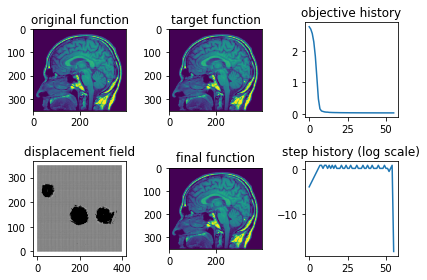

In [19]:
fig1, ax = plt.subplots(2,3)
ax[0,0].imshow(fIMR)
ax[0,0].set_title('original function')
ax[0,1].imshow(gIMR)
ax[0,1].set_title('target function')
ax[1,0].quiver(uxIMR,uyIMR)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(fIMR,uxIMR,uyIMR))
ax[1,1].set_title('final function')
ax[0,2].plot(CFIMR)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(stepIMR))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

In [115]:
plt.imsave('test1.png', fIMR)
plt.imsave('test2.png', interpol(fIMR,uxIMR,uyIMR))

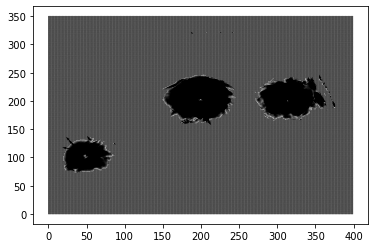

In [21]:
plt.quiver(np.flip(uxIMR,0), np.flip(uyIMR,0))
plt.show()

In [46]:
epsi=10**-5
lamb = 0.0001
mu = 0.0001
stepini = 0.01
uxIMR,uyIMR,CFIMR,stepIMR,niter=RecalageGN(fIMR,gIMR,lamb,mu,50000,stepini,epsi)

iteration : 1  cost function : 2.7672497682543193 step : 0.02
iteration : 2  cost function : 2.661815988840503 step : 0.04
iteration : 3  cost function : 2.4604199233050315 step : 0.08
iteration : 4  cost function : 2.093953039477548 step : 0.16
iteration : 5  cost function : 1.4925633621731238 step : 0.32
iteration : 6  cost function : 0.7085662916312995 step : 0.64
iteration : 7  cost function : 0.12005288322809474 step : 1.28
iteration : 8  cost function : 0.03299242945241826 step : 1.28
iteration : 9  cost function : 0.026785597926178843 step : 1.28
iteration : 10  cost function : 0.026009113645295116 step : 0.64
iteration : 11  cost function : 0.023004618487823324 step : 9.5367431640625e-09


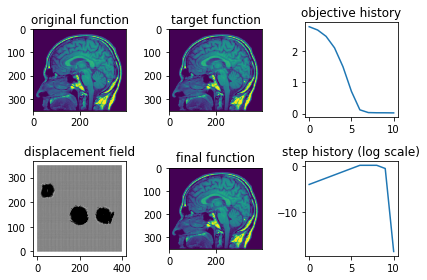

In [47]:
fig1, ax = plt.subplots(2,3)
ax[0,0].imshow(fIMR)
ax[0,0].set_title('original function')
ax[0,1].imshow(gIMR)
ax[0,1].set_title('target function')
ax[1,0].quiver(uxIMR,uyIMR)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(fIMR,uxIMR,uyIMR))
ax[1,1].set_title('final function')
ax[0,2].plot(CFIMR)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(stepIMR))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

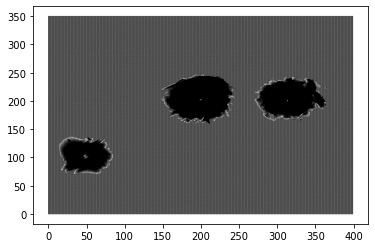

In [48]:
plt.quiver(np.flip(uxIMR,0), np.flip(uyIMR,0))
plt.show()